# 0.0 Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from geopy.geocoders         import Nominatim
import inflection  
from tabulate                import tabulate
from scipy.stats             import normaltest
from scipy                   import stats  as ss
  

import matplotlib  
from matplotlib              import pyplot as plt
from matplotlib              import gridspec
  
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
import pickle
from sklearn.model_selection import train_test_split
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestRegressor

from sklearn.metrics         import mean_absolute_error
from sklearn.metrics         import mean_absolute_percentage_error
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import Lasso
import xgboost as xgb
from sklearn.model_selection import KFold
import random
import json
import requests

from IPython.core.display    import HTML
from IPython.display         import Image

## 0.1 helper Functions

In [2]:
#ajusta graficos
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 40
    
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
#Retirar notação cientifica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def percentage_pandas(df1, df_total ):
    percentage = df1.shape[0]/df_total.shape[0] *100
    return percentage
    
#cramer V Function
def cramer_v( x, y ):
    cm = np.asmatrix ( pd.crosstab( x, y ) )
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr / n ) / min( kcorr-1, rcorr-1 ) )

# #Erro percentual absoluto medio
# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( (y - yhat) / y ) )

#Erro percentual medio
def mean_percentage_error( y, yhat ):
    return np.mean( (y - yhat) / y )

# calcula performance do Modelo
def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y , yhat) )
    
    return pd.DataFrame( { 'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse }, index = [0] )


#cross-validation kfold
def cross_validation(x_train_cv, y_train_cv, kfold, model_name, model, verbose=False):
    
    #criando das listas
    mae_list = [] 
    mape_list = [] 
    rmse_list = []
    k=0
    
    #Instanciar kfolds
    kf = KFold( n_splits = kfold )
    
    #adequando dados dataframe
    x_train_cv = x_train.values
    y_train_cv = y_train_cv.values

    for train_index, test_index in kf.split(x_train_cv, y_train_cv):
        
        X_train, X_test, = x_train_cv[train_index], x_train_cv[test_index]
        Y_train, Y_test  = y_train_cv[train_index], y_train_cv[test_index]

        

        #training and validation dataset

        #training
        xtraining = X_train
        ytraining = Y_train

        #xvalidation
        xvalidation = X_test
        yvalidation = Y_test

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )
        
        #acompanhar as iterações
        if verbose:
            k += 1 
            print('\nkfold Number: {}'.format(k) )
            print( m_result )

        #store performance of each kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':  np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),
                          'Score':   model.score(x_train_cv, y_train_cv)}, index=[0] )



In [3]:
jupyter_settings()

# 1.0 Descrição dos dados

## 1.1 Carregando o dataset e descrição das variáveis

In [4]:
#loading data
df_raw = pd.read_csv('/home/deivison/Documentos/projetos/kc_house/data/kc_house_data.csv')

In [5]:
df1 = df_raw.copy()
df1.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1  6414100192  20141209T000000 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2  5631500400  20150225T000000 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0    98028 47.74 -122.23           2720        8062
3  2487200875  20141209T000000 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4  1954400510  20150218T000000 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0    98074 47.62 -122.05           1800        7503

In [6]:
df1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Descrição das variáveis

id            - ID exclusivo para cada casa vendida

date          - Data da venda da casa

price         - Preço de cada casa vendida

bedrooms      - Número de quartos

bathrooms     - Número de banheiros, onde 0,5 representa um quarto com vaso sanitário, mas sem chuveiro

sqft_living   - Metragem quadrada do espaço interior do apartamento

sqft_lot      - Metragem quadrada do espaço terrestre

floors        - Número de andares

waterfront    - Uma variável fictícia para saber se o apartamento estava com vista para o mar ou não

view          - Um índice de 0 a 4 de quão boa era a vista do imóvel

condition     - Um índice de 1 a 5 sobre a condição do apartamento,

grade         - Um índice de 1 a 13, onde 1-3 padrão de qualidade baixo da construção e design de edifícios, 7 tem um nível                 médio de construção e design e 11-13 tem um nível de construção e design de alta qualidade.

sqft_above    - A metragem quadrada do espaço interno da habitação que está acima do nível do solo

sqft_basement - A metragem quadrada do espaço interno da habitação que está abaixo do nível do solo

yr_built      - O ano em que a casa foi construída inicialmente

yr_renovated  - O ano da última reforma da casa

zipcode       - Em que área de código postal a casa está

lat           - Latitude

long          - Longitude

sqft_living15 - A metragem quadrada do espaço habitacional interior para os 15 vizinhos mais próximos

sqft_lot15    - A metragem quadrada dos lotes dos 15 vizinhos mais próximos

## 1.2 Dimensão dos dados

In [7]:
# Dimensão do dataframe e dimensionalidade
print('Numero de colunas do dataframe:  {} '.format(df1.shape[1]) )
print('\nNumero de linhas do dataframe: {} '.format(df1.shape[0]) )

Numero de colunas do dataframe:  21 

Numero de linhas do dataframe: 21613 


## 1.3 Tipo dos dados

In [8]:
#Verificar os tipos de cada variavel
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [9]:
# Converter variavel 'date' para formato datetime
df1['date'] = pd.to_datetime(df1['date'])
df1['date'].head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

In [10]:
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 1.4 Verificação de Na

In [11]:
# Resumo de valores Na por variável
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1.5 Estatística Descritiva

In [12]:
# separar todas as variaveis numericas, exceto 'date'
cols_drop = ['id','waterfront','view','condition','grade','date']
num_attributes = df1.drop(cols_drop, axis = 1 )

# separar todas as variaveis categoricas, exceto 'date'
cat_attributes = df1[['waterfront','view','condition','grade']]

In [13]:
# variaveis numericas
num_attributes.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0 221900.00         3       1.00         1180      5650    1.00        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1 538000.00         3       2.25         2570      7242    2.00        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2 180000.00         2       1.00          770     10000    1.00         770              0      1933             0    98028 47.74 -122.23           2720        8062
3 604000.00         4       3.00         1960      5000    1.00        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4 510000.00         3       2.00         1680      8080    1.00        1680              0      1987             0    98074 47.62 -122.05           1800        7503

In [14]:
# variaveis categoricas
cat_attributes.head()

waterfront  view  condition  grade
0           0     0          3      7
1           0     0          3      7
2           0     0          3      6
3           0     0          5      7
4           0     0          3      8

### 1.7.1 Variáveis Numéricas 

#### Tendência Central

In [15]:
# media
ct1 = pd.DataFrame( num_attributes.apply(np.mean ) ).T

# mediana
ct2 = pd.DataFrame( num_attributes.apply(np.median ) ).T

#### Dispersão

In [16]:
# min
d1 = pd.DataFrame( num_attributes.apply( np.min ) ).T

#max
d2 = pd.DataFrame( num_attributes.apply( np.max ) ).T

#range
d3 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

# desvio padrao
d4 = pd.DataFrame( num_attributes.apply( np.std ) ).T

# assimetria - skew
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

# Curtosi - Kurtosis
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#### Tabela

In [17]:
table = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
table.columns = ['attributes', 'min','max','range','mean', 'median','std','skew','kurtosis']
table

attributes      min        max      range      mean    median       std  skew  kurtosis
0           price 75000.00 7700000.00 7625000.00 540088.14 450000.00 367118.70  4.02     34.59
1        bedrooms     0.00      33.00      33.00      3.37      3.00      0.93  1.97     49.06
2       bathrooms     0.00       8.00       8.00      2.11      2.25      0.77  0.51      1.28
3     sqft_living   290.00   13540.00   13250.00   2079.90   1910.00    918.42  1.47      5.24
4        sqft_lot   520.00 1651359.00 1650839.00  15106.97   7618.00  41419.55 13.06    285.08
5          floors     1.00       3.50       2.50      1.49      1.50      0.54  0.62     -0.48
6      sqft_above   290.00    9410.00    9120.00   1788.39   1560.00    828.07  1.45      3.40
7   sqft_basement     0.00    4820.00    4820.00    291.51      0.00    442.56  1.58      2.72
8        yr_built  1900.00    2015.00     115.00   1971.01   1975.00     29.37 -0.47     -0.66
9    yr_renovated     0.00    2015.00    2015.00     84.40      0.00    401.67  4.55     18.70
10        zipcode 98001.00   98199.00     198.00  98077.94  98065.00     53.50  0.41     -0.85
11            lat    47.16      47.78       0.62     47.56     47.57      0.14 -0.49     -0.68
12           long  -122.52    -121.31       1.20   -122.21   -122.23      0.14  0.89      1.05
13  sqft_living15   399.00    6210.00    5811.00   1986.55   1840.00    685.38  1.11      1.60
14     sqft_lot15   651.00  871200.00  870549.00  12768.46   7620.00  27303.55  9.51    150.76

#### Variável resposta - price ( preço de venda )

In [18]:
# Variavel resposta price
# range
# $75.000 - $7.700.000

#mean
# $540.000

#std
# $367.118,70

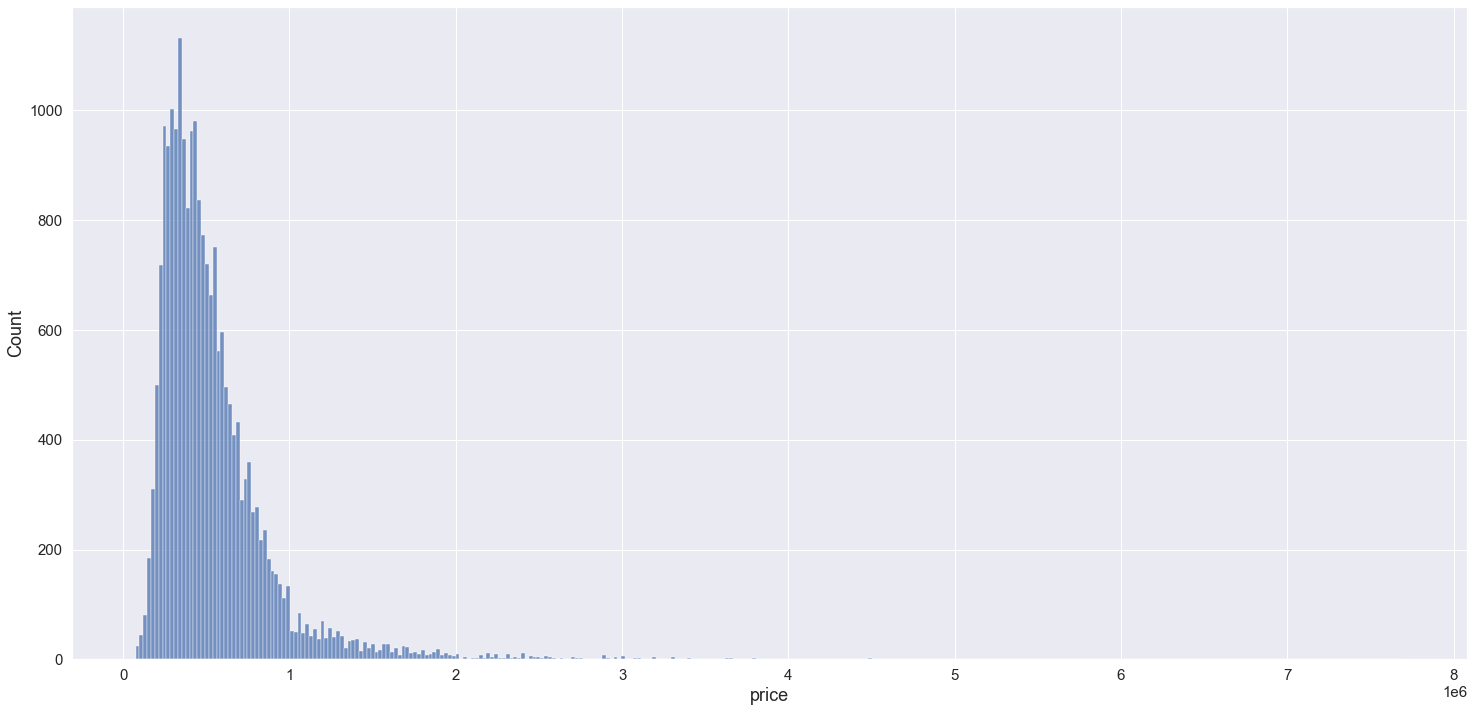

In [19]:
# distribuicao dos precos de venda
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18)

sns.histplot(x='price',data = df1);

#### Algumas observações

Bedrooms = numero de quartos máximo = 33

sqft_lot = valor maximo de 1.651.359,00 sqft squared

yr_built --> range do ano de construção 1900 - 2015

sqft_lot15 = valro maximo de 871.200,00 sqft squared

### 1.7.2 Variáveis Categoricas

In [20]:
# quantidade de categorias de cada variavel categorica
cat_attributes.apply( lambda x: x.unique().shape[0] )

waterfront     2
view           5
condition      5
grade         12
dtype: int64

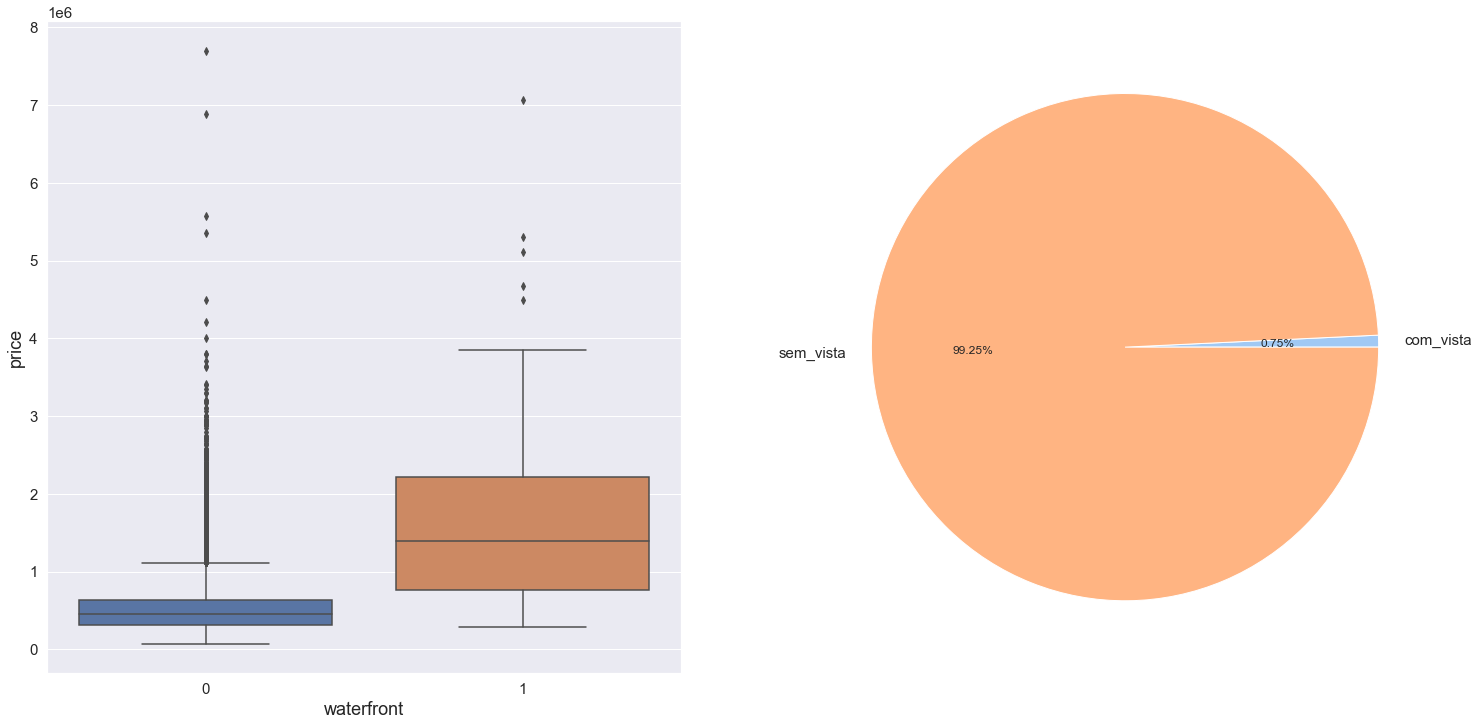

In [21]:
#Waterfront

#boxplot
plt.subplot(1,2,1)
sns.boxplot(data=df1, x='waterfront',y='price' );

#pie chart
aux1 = percentage_pandas(df1[ df1['waterfront']==1 ], df1 )
aux2 = percentage_pandas(df1[ df1['waterfront']==0 ], df1 )
colors = sns.color_palette('pastel')[0:2]
data = [ aux1, aux2]
labels = ['com_vista','sem_vista']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')  
plt.show()

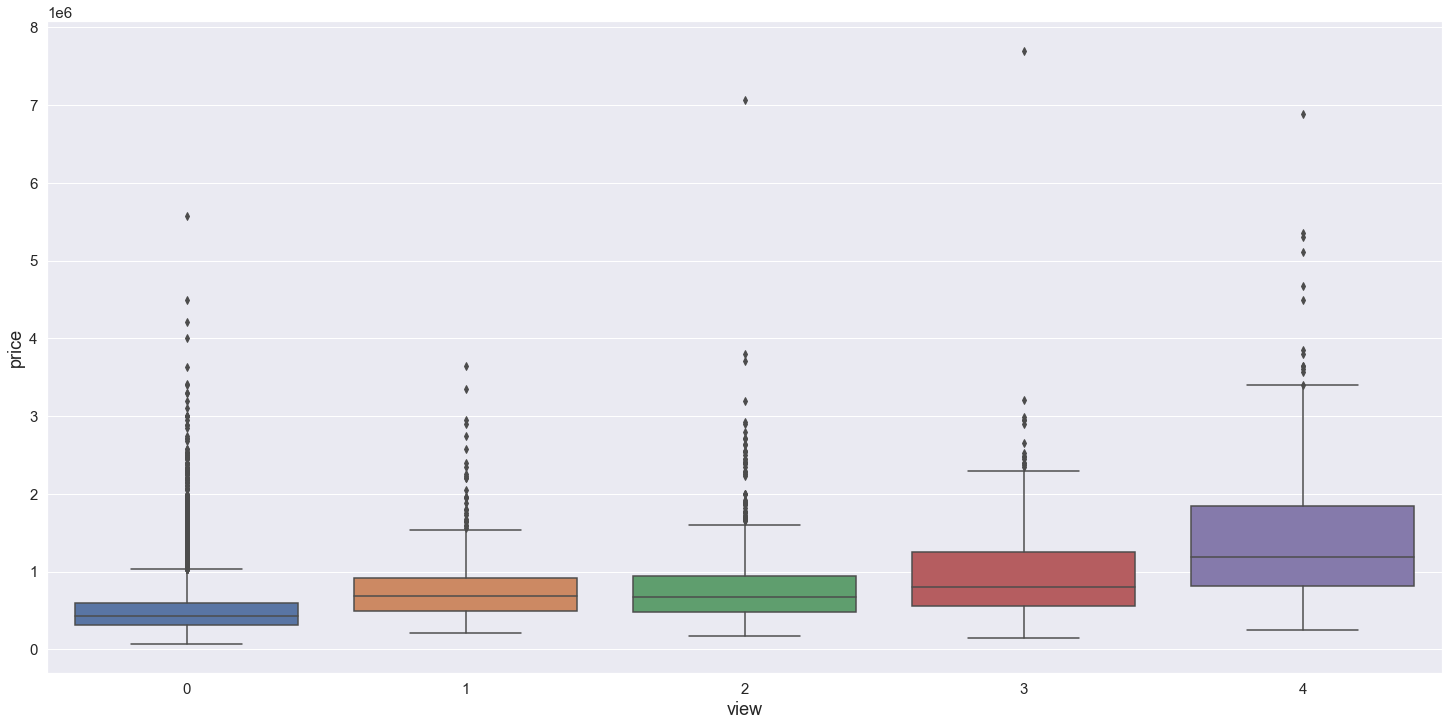

In [22]:
#view

#boxplot
sns.boxplot(data = df1, x = 'view', y= 'price');
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=20)


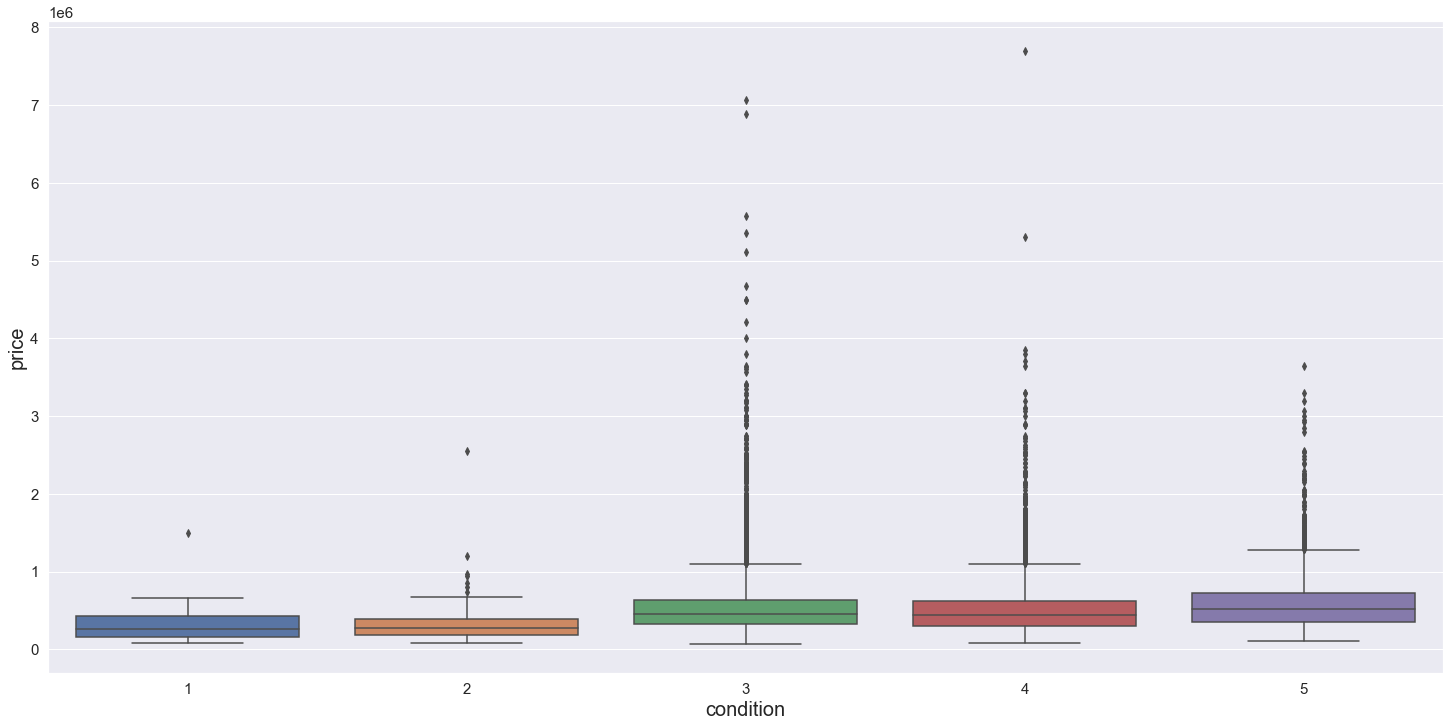

In [23]:
#condition

#boxplot
sns.boxplot(data = df1, x = 'condition', y= 'price');

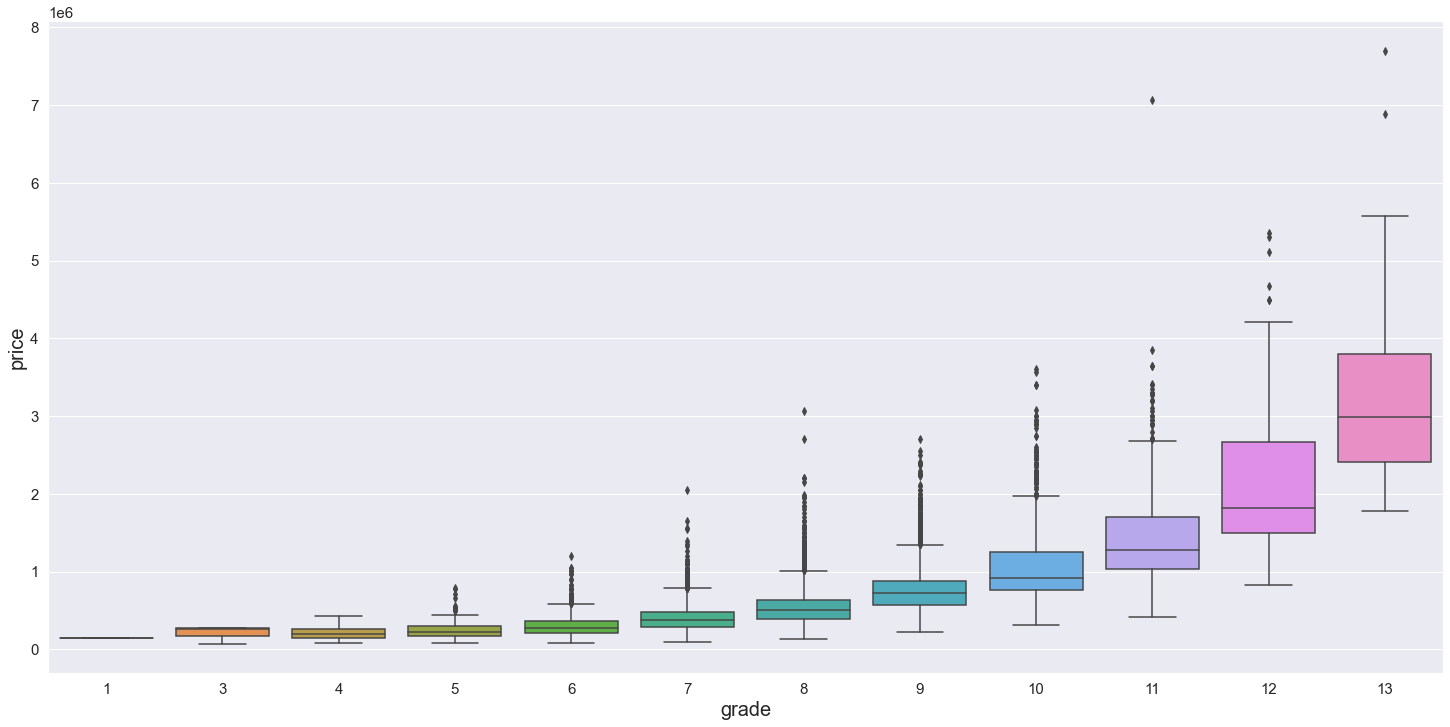

In [24]:
# grade

#boxplot
sns.boxplot(data = df1, x = 'grade', y= 'price');

# 2.0 Featuring Engineering

In [25]:
df2 = df1.copy()
df2.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0  7129300520 2014-10-13 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1  6414100192 2014-12-09 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2  5631500400 2015-02-25 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0    98028 47.74 -122.23           2720        8062
3  2487200875 2014-12-09 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4  1954400510 2015-02-18 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0    98074 47.62 -122.05           1800        7503

## 2.1 Mapa mental de hipóteses

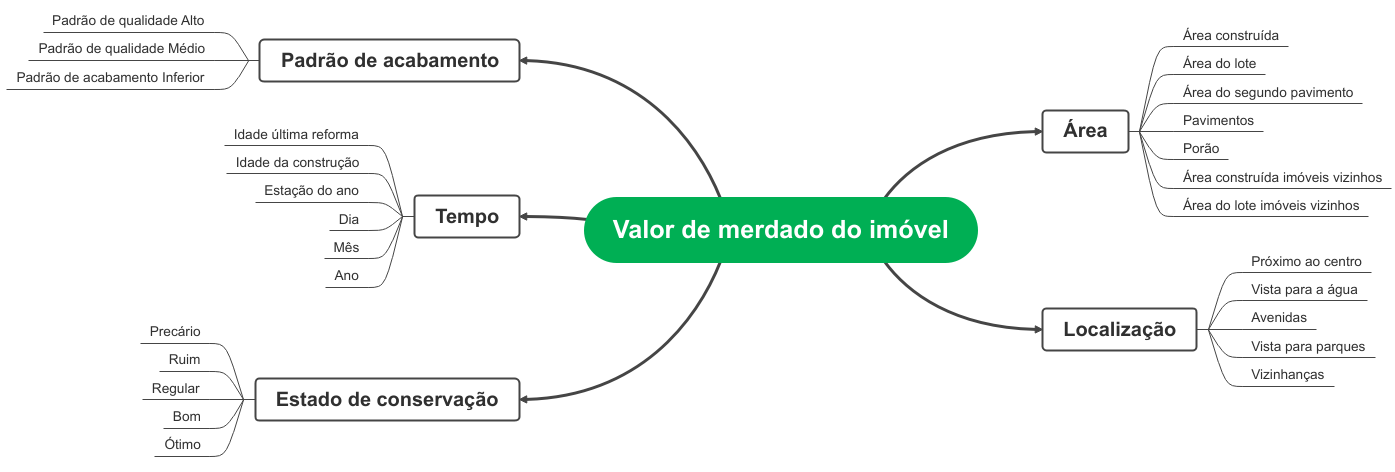

In [26]:
Image( '/home/deivison/Documentos/projetos/kc_house/imagem/mind_map_1.png')

## 2.2 Criação das hipóteses

### 2.2.1 Área 

1. Imóveis com maior área construída possuem preços maiores.

2. Imóveis com lotes maiores possuem preços maiores.

3. Imóveis com maiores áreas do segundo pavimento possuem preços maiores.

4. Imóveis com mais pavimentos possuem preços maiores.

5. Imóveis com porão possuem preços maiores.

6. Imóveis com porões maiores possuem maiores preços.

7. Imóveis com áreas construídas maiores que as dos imóveis vizinhos possuem preços maiores.

8. Imóveis com áreas de lote maiores que as dos imóveis vizinhos possuem maiores preços.

### 2.2.2 Localização

1. Imóveis localizados próximo ao centro são mais valorizados.

2. Imóveis localizados de frente para a água possuem preços maiores.

3. Imóveis residenciais localizados em avenidas possuem preços menores.

4. Imóveis localizados com vista para a parques possuem maiores preços.

5. Imóveis localizados em vizinhanças com áreas menores possuem preços maiores.

6. Imóveis localizados em vizinhanças com áreas menores possuem maiores preços/sqft 2

7. Imóveis localizados em Seattle são mais valorizados.

### 2.2.3 Padrão de acabamento

1. Imóveis com alto padrão de qualidade possuem preços maiores.

2. Imóveis com padrão de acabamento médio possuem maiores preços por metro quadrado.

3. Imóveis com padrão de acabamento inferior são mais vendidos.

### 2.2.4 Tempo 

1. Imóveis reformados nos ultimos 3 anos possuem preços maiores.

2. Imóveis reformados nos ultimos 3 anos possuem preços/sqft maiores.

3. Imóveis com idade de construção superior a 50 anos possuem preços menores.

4. Imóveis com idade de construção superior a 50 anos possuem preços/sqft menores

5. Imóveis com idade de construção inferior a 3 anos possuem preços maiores.

6. Imóveis vendidos no inverno possuem preços menores.

7. Imóveis vendidos no final do mês tem preços menores.

8. Imóveis vendidos no ano de 2015 possuem preços maiores.

### 2.2.5 Estado de conservação

1. Imóveis em melhores condições possuem preços maiores.

### 2.2.6 Mapa Mental Hipóteses Criadas

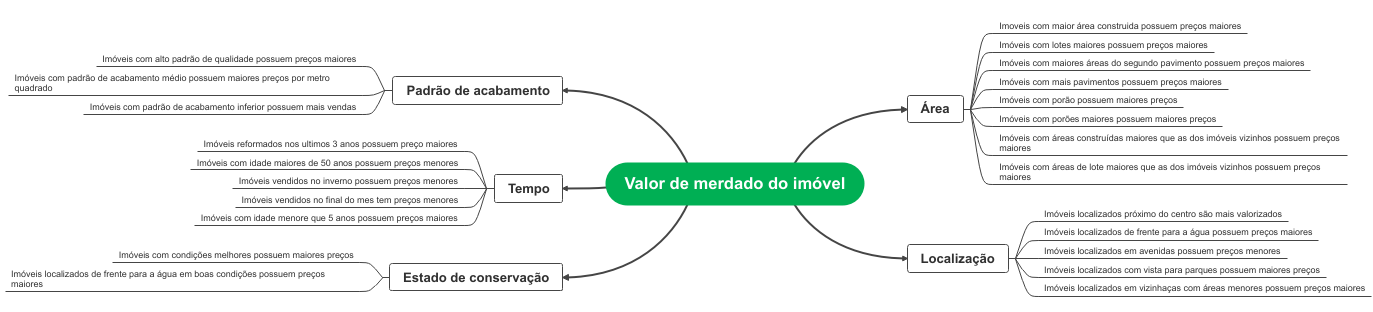

In [27]:
Image( '/home/deivison/Documentos/projetos/kc_house/imagem/mind_map_2.png')

## 2.3 Lista Final de Hipóteses

### 2.3.1 Area

1. Imóveis com maior área construída possuem preços maiores. --> ok

2. Imóveis com lotes maiores possuem preços maiores. --> ok

3. Imóveis com maiores áreas do segundo pavimento possuem preços maiores. --> ok

4. Imóveis com mais pavimentos possuem preços maiores. --> ok

5. Imóveis com porão possuem preços maiores. --> ok

6. Imóveis com porões maiores possuem maiores preços. --> ok

7. Imóveis com áreas construídas maiores que as dos imóveis vizinhos possuem preços maiores. --> ok

8. Imóveis com áreas de lote maiores que as dos imóveis vizinhos possuem maiores preços. --> ok

### 2.3.2 Localização

1. Imóveis localizados próximo ao centro são mais valorizados. --> next CRISP cycle

2. Imóveis localizados de frente para a água possuem preços maiores. --> ok

3. Imóveis residenciais localizados em avenidas possuem preços menores. --> ok

4. Imóveis localizados com vista para a parques possuem maiores preços. --> Next CRISP cycle

5. Imóveis localizados em vizinhanças com áreas menores possuem preços maiores.--> ok

6. Imóveis localizados em vizinhanças com áreas menores possuem maiores preços/sqft 2 --> ok

7. Imóveis localizados em Seattle são mais valorizados. --> ok

### 2.3.3 Padrão de acabamento

1. Imóveis com alto padrão de qualidade possuem preços maiores. --> ok

2. Imóveis com padrão de acabamento médio possuem maiores preços por metro quadrado. --> ok

3. Imóveis com padrão de acabamento inferior são mais vendidos. -> ok

### 2.3.4 Tempo 

1. Imóveis reformados nos ultimos 3 anos possuem preços maiores. --> ok 

2. Imóveis reformados nos ultimos 3 anos possuem preços/sqft maiores. --> ok 

3. Imóveis com idade de construção superior a 50 anos possuem preços menores. --> ok

4. Imóveis com idade de construção superior a 50 anos possuem preços/sqft menores

5. Imóveis com idade de construção inferior a 3 anos possuem preços maiores. --> ok

6. Imóveis vendidos no inverno possuem preços menores. --> ok

7. Imóveis vendidos no final do mês tem preços menores. --> ok

8. Imóveis vendidos no ano de 2015 possuem preços maiores. --> ok

### 2.3.5 Estado de conservação

1. Imóveis em melhores condições possuem preços maiores. --> ok

## 2.4 Featuring Engineering

### Porão

In [28]:
# 5. Imóveis com porão possuem preços maiores. --> ok

In [29]:
df2['sqft_basement'].unique()

array([   0,  400,  910, 1530,  730, 1700,  300,  970,  760,  720,  700,
        820,  780,  790,  330, 1620,  360,  588, 1510,  410,  990,  600,
        560,  550, 1000, 1600,  500, 1040,  880, 1010,  240,  265,  290,
        800,  540,  380,  710,  840,  770,  480,  570, 1490,  620, 1250,
       1270,  120,  650,  180, 1130,  450, 1640, 1460, 1020, 1030,  750,
        640, 1070,  490, 1310,  630, 2000,  390,  430,  850,  210, 1430,
       1950,  440,  220, 1160,  860,  580, 2060, 1820, 1180,  200, 1150,
       1200,  680,  530, 1450, 1170, 1080,  960, 1100,  280,  870,  460,
       1400, 1320,  660, 1220,  900,  420, 1580, 1380,  475,  690,  270,
        350,  935, 1370,  980, 1470,  160,  950,   50,  740, 1780, 1900,
        340,  470,  370,  140, 1760,  130,  610,  520,  890, 1110,  150,
       1720,  810,  190, 1290,  670, 1800, 1120, 1810,   60, 1050,  940,
        310,  930, 1390, 1830, 1300,  510, 1330, 1590,  920, 1420, 1240,
       1960, 1560, 2020, 1190, 2110, 1280,  250, 23

In [30]:
# basement variable 
#     no_basement = 0 -->  sqft_basement =  0 sqft
#     basement    = 1 -->  sqft_basement != 0 sqft 
df2['basement'] = df2.apply(lambda x: 0 if ( x['sqft_basement'] == 0)  else 1, axis =1 ).astype(int)

In [31]:
df2.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
basement                  int64
dtype: object

### Preço por pé quadrado

In [32]:
# 2. Imóveis com padrão de acabamento médio possuem maiores preços por sqft quadrado. --> ok

In [33]:
# price_sqft
df2['price_sqft'] = df2.apply( lambda x: x['price'] / x['sqft_living'], axis = 1 )    

In [34]:
df2[['price','sqft_living','price_sqft']].sample(10)

price  sqft_living  price_sqft
3392  122000.00          860      141.86
12919 428000.00         1580      270.89
2971  400000.00         1060      377.36
6128  775000.00         2620      295.80
13234 699000.00         2650      263.77
11894 672500.00         1860      361.56
13152 575000.00         2280      252.19
20001 605000.00         1660      364.46
542   318888.00         2320      137.45
17389 525000.00         2320      226.29

### Variavéis associadas a data da venda

In [35]:
# time variables

In [36]:
# ano
df2['year'] = df2['date'].dt.year.astype(str)

# mes
df2['month'] = df2['date'].dt.month

# dia 
df2['day'] = df2['date'].dt.day

# estacao do ano
df2['season'] = df2.apply( lambda x: 'spring' if x['date'] in pd.date_range( start = x['year'] + '/3/21' , end= x['year'] + '/6/20'  , freq='D' ) else
                                     'summer' if x['date'] in pd.date_range( start = x['year'] + '/6/21' , end= x['year'] + '/9/20'  , freq='D' ) else
                                     'fall'   if x['date'] in pd.date_range( start = x['year'] + '/9/21' , end= x['year'] + '/12/20' , freq='D' ) else 'winter', axis = 1 )

df2[['date','day','month','year','season']].head()

date  day  month  year  season
0 2014-10-13   13     10  2014    fall
1 2014-12-09    9     12  2014    fall
2 2015-02-25   25      2  2015  winter
3 2014-12-09    9     12  2014    fall
4 2015-02-18   18      2  2015  winter

### Áreas construídas e do lote com relação aos vizinhos

In [37]:
df2['sqft_living_compare'] = df2.apply( lambda x: 1 if x['sqft_living'] > x['sqft_living15'] else 0, axis = 1 )
df2['sqft_lot_compare']    = df2.apply( lambda x: 1 if x['sqft_lot'] > x['sqft_lot15'] else 0, axis = 1 )

In [38]:
df2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'price_sqft',
       'year', 'month', 'day', 'season', 'sqft_living_compare',
       'sqft_lot_compare'],
      dtype='object')

### Variáveis associadas a localização

In [39]:
aux1 = pd.read_csv('/home/deivison/Documentos/projetos/kc_house/data/geo_index.csv')
aux1[['id','lat','long','zipcode','road','postcode','city','neighbourhood']].head()

id   lat    long  zipcode                      road postcode       city  neighbourhood
0  7129300520 47.51 -122.26    98178         61st Avenue South    98178    Seattle  Rainier Beach
1  6414100192 47.72 -122.32    98125    Northeast 127th Street    98125    Seattle            NaN
2  5631500400 47.74 -122.23    98028     81st Avenue Northeast    98028    Kenmore            NaN
3  2487200875 47.52 -122.39    98136  Fauntleroy Way Southwest    98136    Seattle     Fauntleroy
4  1954400510 47.62 -122.05    98074    221st Avenue Northeast    98074  Sammamish            NaN

In [40]:
aux1.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated         0
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
basement             0
price_sqft           0
year                 0
month                0
day                  0
season               0
road               209
postcode            98
city              5125
neighbourhood    14004
dtype: int64

In [41]:
#tratar na's de 'city'

In [42]:
dic_zip = {'98001': 'Auburn','98002': 'Auburn','98003': 'Federal Way','98004': 'Bellevue',
           '98005': 'Bellevue','98006': 'Bellevue','98007': 'Bellevue','98008': 'Bellevue',
           '98009': 'Bellevue','98010': 'Black Diamond','98011': 'Bothell','98013': 'Burton',
           '98014': 'Carnation','98015': 'Bellevue','98019': 'Duvall','98022': 'Enumclaw',
           '98023': 'Federal Way','98024': 'Fall City','98025': 'Hobart','98027': 'Issaquah',
           '98028': 'Kenmore','98029': 'Issaquah','98030': 'Kent','98031': 'Kent','98032': 'Kent',
           '98033': 'Kirkland','98034': 'Kirkland','98035': 'Kent','98038': 'Maple Valley',
           '98039': 'Medina','98040': 'Mercer Island','98041': 'Bothell','98042': 'Kent',
           '98045': 'North Bend','98047': 'Pacific','98050': 'Preston','98051': 'Ravensdale',
           '98052': 'Redmond','98053': 'Redmond','98055': 'Renton','98056': 'Renton',
           '98057': 'Renton','98058': 'Renton','98059': 'Renton','98062': 'Seahurst',
           '98063': 'Federal Way','98064': 'Kent','98065': 'Snoqualmie','98070': 'Vashon',
           '98071': 'Auburn','98072': 'Woodinville','98073': 'Redmond','98074': 'Sammamish',
           '98075': 'Sammamish','98077': 'Woodinville','98083': 'Kirkland','98089': 'Kent',
           '98092': 'Auburn','98093': 'Federal Way','98101': 'Seattle','98102': 'Seattle',
           '98103': 'Seattle','98104': 'Seattle','98105': 'Seattle','98106': 'Seattle','98107': 'Seattle',
           '98108': 'Seattle','98109': 'Seattle','98111': 'Seattle','98112': 'Seattle','98113': 'Seattle',
           '98114': 'Seattle','98115': 'Seattle','98116': 'Seattle','98117': 'Seattle','98118': 'Seattle',
           '98119': 'Seattle','98121': 'Seattle','98122': 'Seattle','98124': 'Seattle','98125': 'Seattle',
           '98126': 'Seattle','98127': 'Seattle','98129': 'Seattle','98131': 'Seattle','98133': 'Seattle',
           '98134': 'Seattle','98136': 'Seattle','98138': 'Seattle','98139': 'Seattle','98141': 'Seattle',
           '98144': 'Seattle','98145': 'Seattle','98146': 'Seattle','98148': 'Seattle','98154': 'Seattle',
           '98155': 'Seattle','98158': 'Seattle','98160': 'Seattle','98161': 'Seattle','98164': 'Seattle',
           '98165': 'Seattle','98166': 'Seattle','98168': 'Seattle','98170': 'Seattle','98174': 'Seattle',
           '98175': 'Seattle','98177': 'Seattle','98178': 'Seattle','98181': 'Seattle','98185': 'Seattle',
           '98188': 'Seattle','98190': 'Seattle','98191': 'Seattle','98194': 'Seattle','98195': 'Seattle',
           '98198': 'Seattle','98199': 'Seattle','98224': 'Baring','98288': 'Skykomish'}




In [43]:
# preencher na's das cidades
aux1['zipcode'] = aux1['zipcode'].astype(str)

aux1['city_zip'] = aux1['zipcode'].map(dic_zip) 

aux1[['city', 'road','postcode','zipcode','city_zip']][ aux1['city'].isna() ].head()

aux1['city'] = aux1.apply( lambda x: x['city_zip'] if ( x['city'] != x['city_zip'] )  else x['city'], axis = 1 )

aux1['city'] = aux1['city'].apply( lambda x: inflection.underscore(x).replace(' ', '_') )

aux1['city'].unique()

array(['seattle', 'kenmore', 'sammamish', 'redmond', 'federal_way',
       'maple_valley', 'bellevue', 'duvall', 'auburn', 'mercer_island',
       'kent', 'issaquah', 'renton', 'vashon', 'kirkland',
       'black_diamond', 'north_bend', 'woodinville', 'snoqualmie',
       'enumclaw', 'fall_city', 'bothell', 'carnation', 'medina'],
      dtype=object)

In [44]:
aux1.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated         0
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
basement             0
price_sqft           0
year                 0
month                0
day                  0
season               0
road               209
postcode            98
city                 0
neighbourhood    14004
city_zip             0
dtype: int64

In [45]:
# variável avenida

In [46]:
# avenue feature
#     avenue --> 1
#     other  --> 0
aux1['avenue'] = aux1['road'].str.contains('Avenue', regex = False)
aux1['avenue'] = aux1['avenue'].apply( lambda x: 1 if (x==True) else 0 )

In [47]:
# variavel rua

In [48]:
aux1['road'].unique().shape[0]

5541

In [49]:
#Fill na road
aux1['road'].fillna('not_available', inplace = True)
aux1.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated         0
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
basement             0
price_sqft           0
year                 0
month                0
day                  0
season               0
road                 0
postcode            98
city                 0
neighbourhood    14004
city_zip             0
avenue               0
dtype: int64

In [50]:
df2['zipcode'] = df2['zipcode'].astype(str)
aux2 = pd.DataFrame()
aux2 = aux1[['id','city','avenue']]
aux2.head()

id       city  avenue
0  7129300520    seattle       1
1  6414100192    seattle       0
2  5631500400    kenmore       1
3  2487200875    seattle       0
4  1954400510  sammamish       1

In [51]:
### versão final do df2 com variáveis criadas --> dataframe 2

In [52]:
df2 = pd.merge(df2,aux2, left_index = True, right_index = True )
cols_old = ['id_y']
df2 = df2.drop( cols_old, axis = 1)
df2.columns = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors',
               'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
               'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement',
               'price_sqft', 'year', 'month', 'day', 'season', 'sqft_living_compare', 'sqft_lot_compare',
               'city', 'avenue']
df2.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated zipcode   lat    long  sqft_living15  sqft_lot15  basement  price_sqft  year  month  day  season  sqft_living_compare  sqft_lot_compare       city  avenue
0  7129300520 2014-10-13 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0   98178 47.51 -122.26           1340        5650         0      188.05  2014     10   13    fall                    0                 0    seattle       1
1  6414100192 2014-12-09 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991   98125 47.72 -122.32           1690        7639         1      209.34  2014     12    9    fall                    1                 0    seattle       0
2  5631500400 2015-02-25 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0   98028 47.74 -122.23           2720        8062         0      233.77  2015      2   25  winter                    0                 1    kenmore       1
3  2487200875 2014-12-09 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0   98136 47.52 -122.39           1360        5000         1      308.16  2014     12    9    fall                    1                 0    seattle       0
4  1954400510 2015-02-18 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0   98074 47.62 -122.05           1800        7503         0      303.57  2015      2   18  winter                    0                 1  sammamish       1

# 3.0 Filtragem das variáveis

In [53]:
df3 = df2.copy()
df3.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated zipcode   lat    long  sqft_living15  sqft_lot15  basement  price_sqft  year  month  day  season  sqft_living_compare  sqft_lot_compare       city  avenue
0  7129300520 2014-10-13 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0   98178 47.51 -122.26           1340        5650         0      188.05  2014     10   13    fall                    0                 0    seattle       1
1  6414100192 2014-12-09 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991   98125 47.72 -122.32           1690        7639         1      209.34  2014     12    9    fall                    1                 0    seattle       0
2  5631500400 2015-02-25 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0   98028 47.74 -122.23           2720        8062         0      233.77  2015      2   25  winter                    0                 1    kenmore       1
3  2487200875 2014-12-09 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0   98136 47.52 -122.39           1360        5000         1      308.16  2014     12    9    fall                    1                 0    seattle       0
4  1954400510 2015-02-18 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0   98074 47.62 -122.05           1800        7503         0      303.57  2015      2   18  winter                    0                 1  sammamish       1

## 3.1 Filtragem de linhas

In [54]:
# remove row with 33 bedrooms
df3 = df3[df3['bedrooms']<33]

# 4.0 Análise Exploratória dos Dados

In [55]:
df4 = df3.copy()
df4.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated zipcode   lat    long  sqft_living15  sqft_lot15  basement  price_sqft  year  month  day  season  sqft_living_compare  sqft_lot_compare       city  avenue
0  7129300520 2014-10-13 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0   98178 47.51 -122.26           1340        5650         0      188.05  2014     10   13    fall                    0                 0    seattle       1
1  6414100192 2014-12-09 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991   98125 47.72 -122.32           1690        7639         1      209.34  2014     12    9    fall                    1                 0    seattle       0
2  5631500400 2015-02-25 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0   98028 47.74 -122.23           2720        8062         0      233.77  2015      2   25  winter                    0                 1    kenmore       1
3  2487200875 2014-12-09 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0   98136 47.52 -122.39           1360        5000         1      308.16  2014     12    9    fall                    1                 0    seattle       0
4  1954400510 2015-02-18 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0   98074 47.62 -122.05           1800        7503         0      303.57  2015      2   18  winter                    0                 1  sammamish       1

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta Price

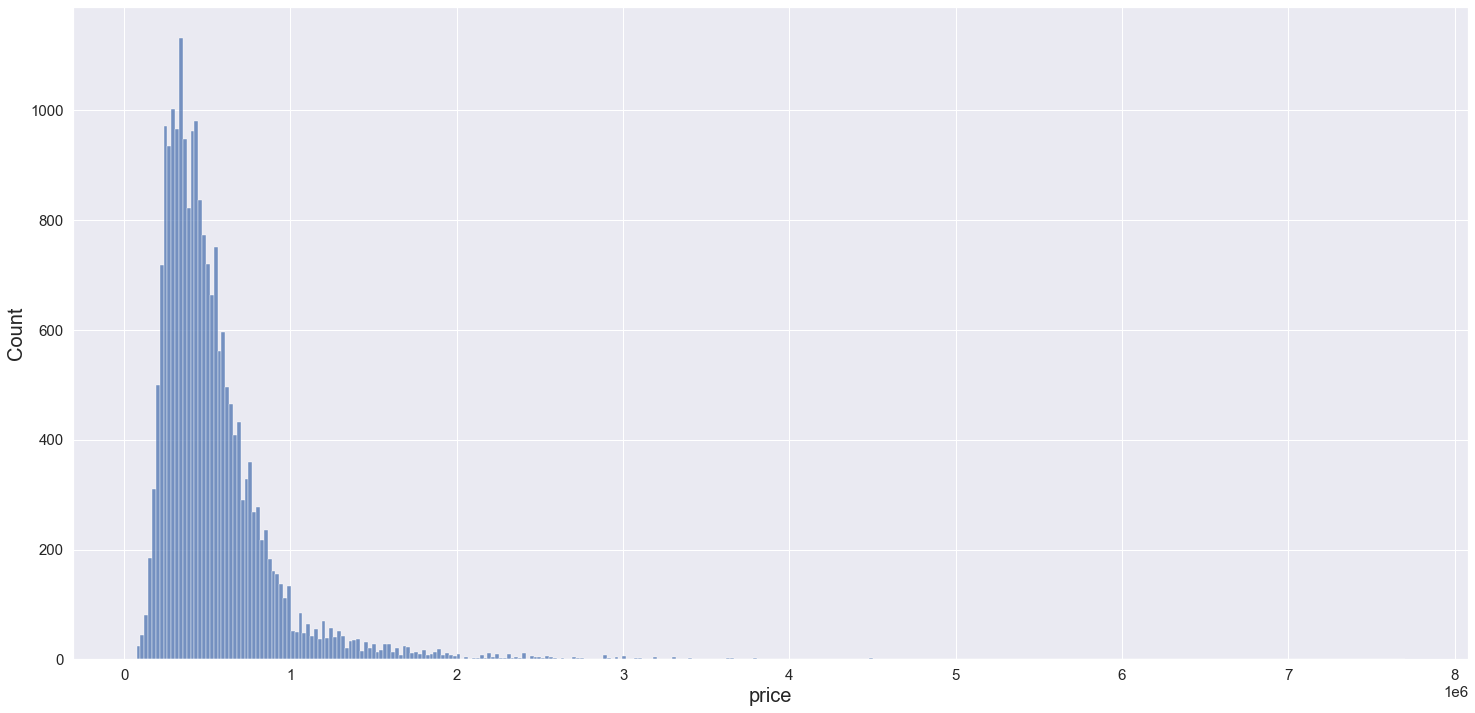

In [56]:
# histograma distribuição price
sns.histplot(data = df4, x = 'price' );

In [57]:
# Range         --> $75.000 - $7.700.000
# media         --> $540000
# desvio padrão --> $367118.70
# assimetria    --> 4.02
# curtose       --> 34.59

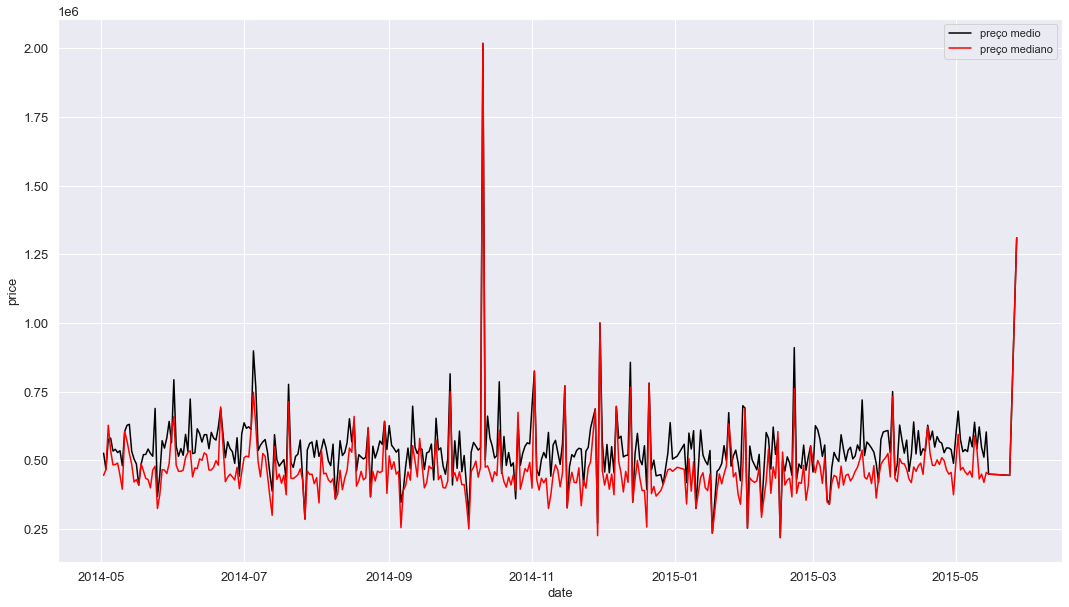

In [58]:
fig = plt.figure( figsize = ( 18,10 ) )
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( nrows = 1, ncols = 1, figure = fig ) 

ax1 = fig.add_subplot( specs[ 0, 0 ] )

aux1 = df4[['price','date']].groupby('date').mean().reset_index()
sns.lineplot( data = aux1, x = 'date', y = 'price', color = 'black', label = 'preço medio', ax = ax1);

aux1 = df4[['price','date']].groupby('date').median().reset_index()
sns.lineplot( data = aux1, x = 'date', y = 'price', color = 'red', label = 'preço mediano',ax = ax1);

### 4.1.2 Variáveis Numéricas

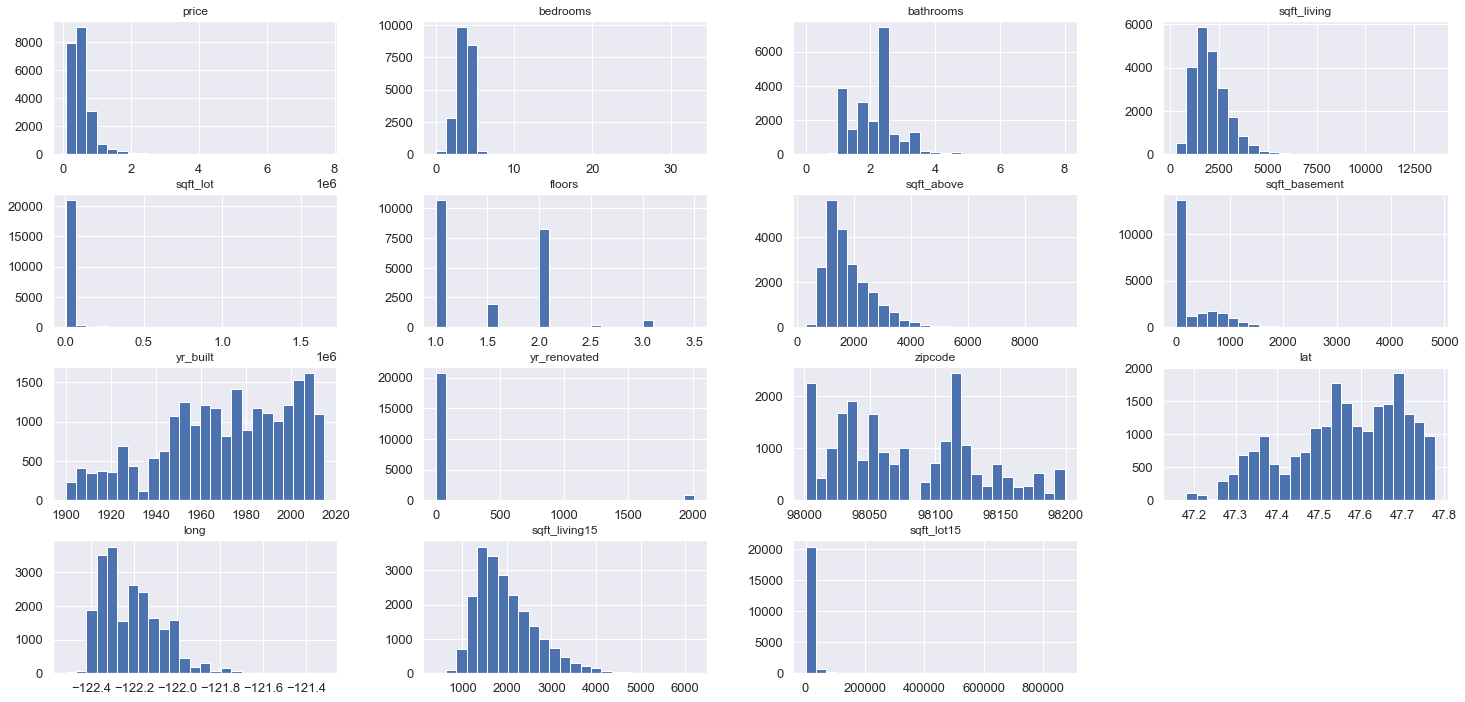

In [59]:
num_attributes.hist(bins=25);

In [60]:
#Bedrooms
df4['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10])

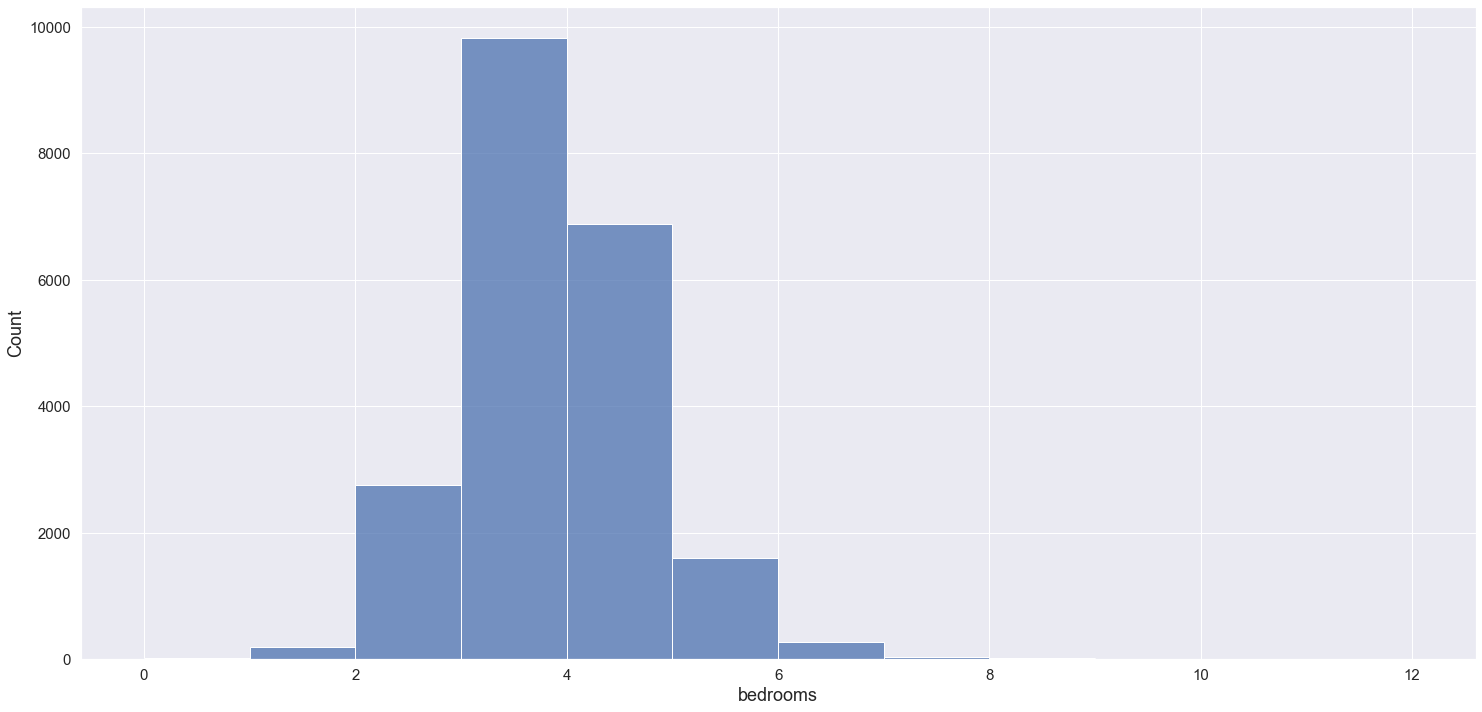

In [61]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
sns.histplot(data = df4, x = 'bedrooms', binwidth = 1, binrange = (0,12) );

In [62]:
#Bathromms
df4['bathrooms'].sort_values().unique()

array([0.  , 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ,
       5.75, 6.  , 6.25, 6.5 , 6.75, 7.5 , 7.75, 8.  ])

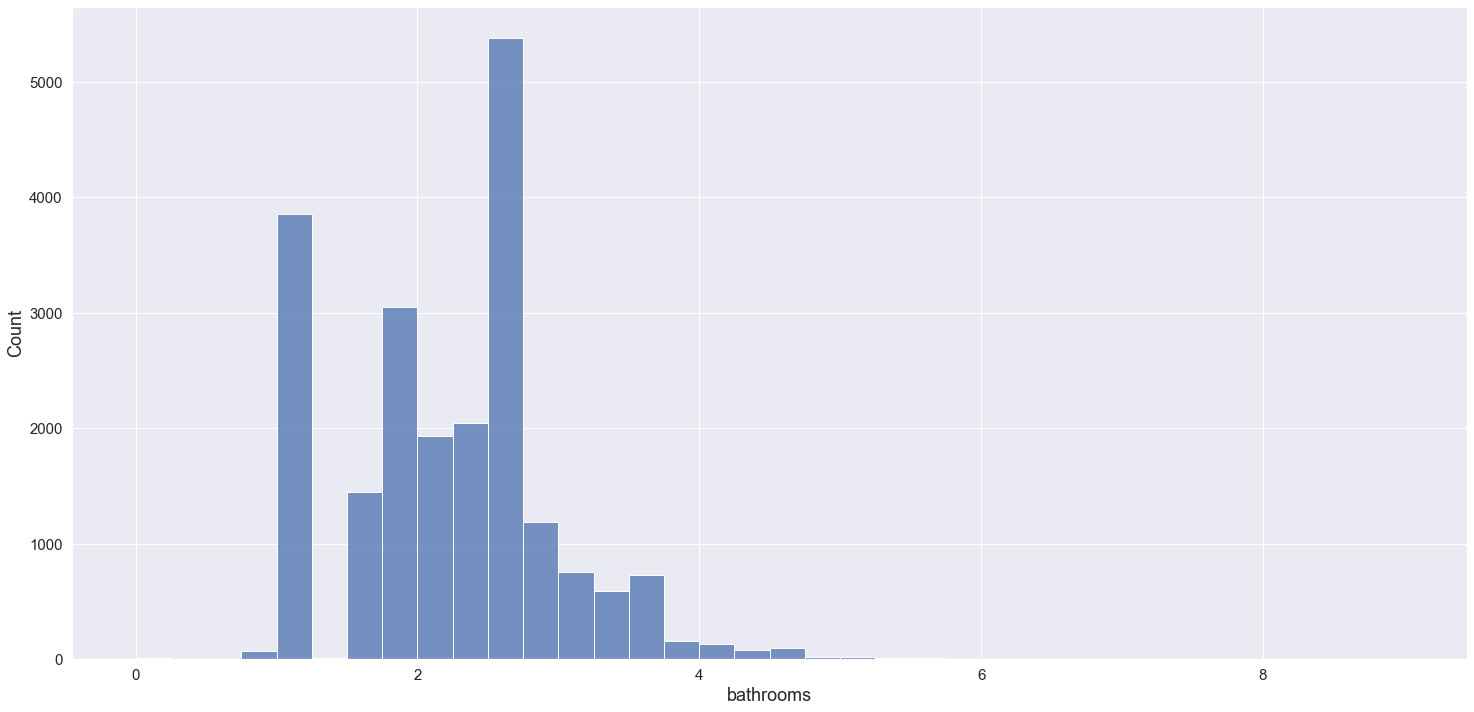

In [63]:
sns.histplot(data = df4, x = 'bathrooms', binwidth = 0.25, binrange = (0,9) );

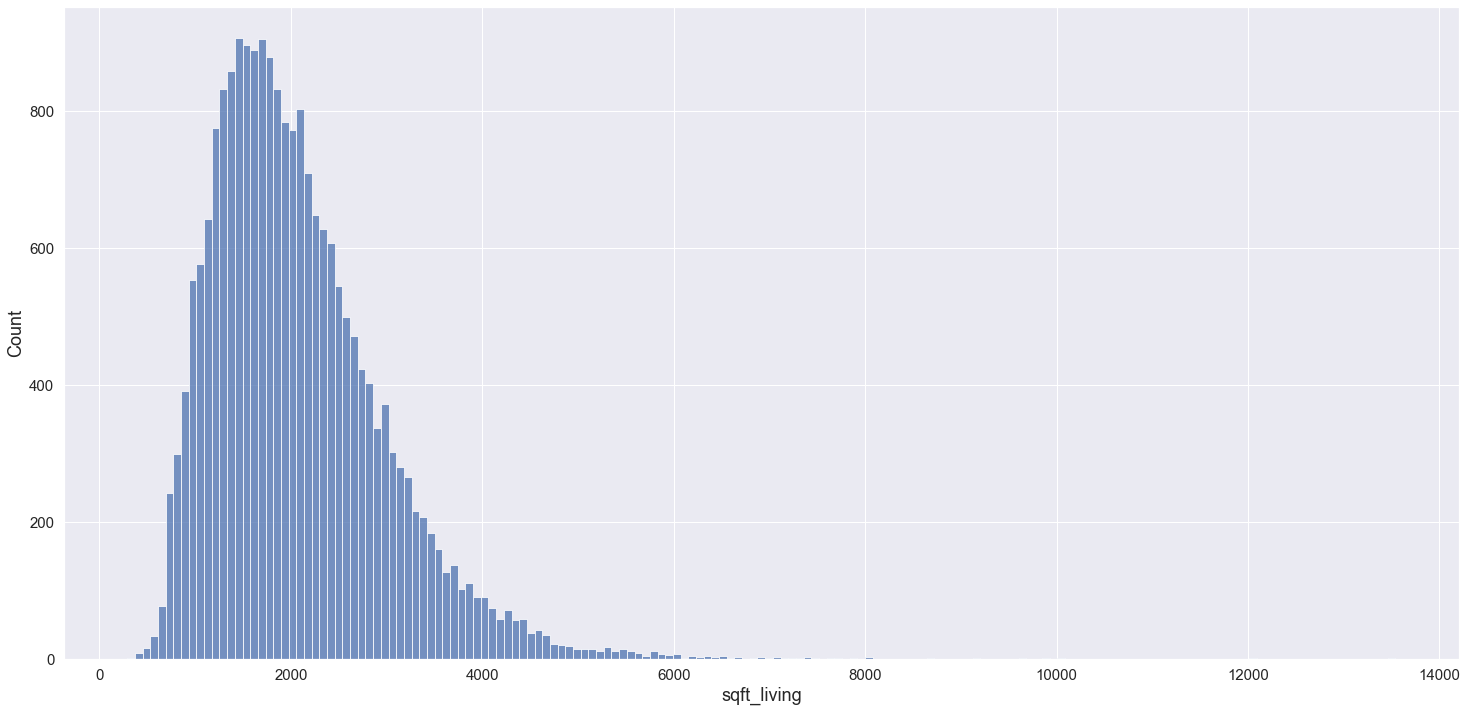

In [64]:
#Area construída
sns.histplot(data = df4, x = 'sqft_living');

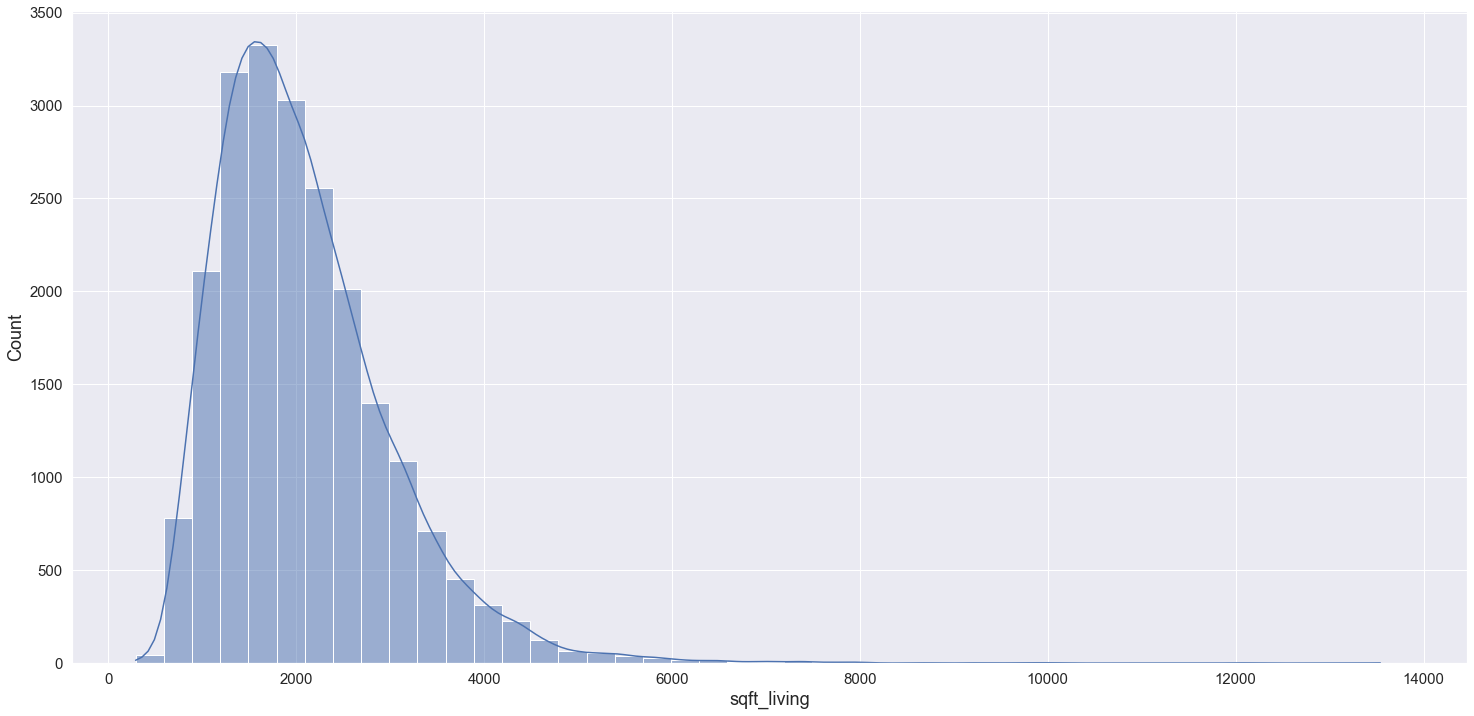

In [65]:
sns.histplot(data = df4, x = 'sqft_living', binwidth = 300, kde = True );

In [66]:
# Area do lote
df4['sqft_lot'].sort_values().unique()

array([    520,     572,     600, ..., 1074218, 1164794, 1651359])

In [67]:
# obs sqft_lot = 1651359.00 sqfts --> 15 ha

table

attributes      min        max      range      mean    median       std  skew  kurtosis
0           price 75000.00 7700000.00 7625000.00 540088.14 450000.00 367118.70  4.02     34.59
1        bedrooms     0.00      33.00      33.00      3.37      3.00      0.93  1.97     49.06
2       bathrooms     0.00       8.00       8.00      2.11      2.25      0.77  0.51      1.28
3     sqft_living   290.00   13540.00   13250.00   2079.90   1910.00    918.42  1.47      5.24
4        sqft_lot   520.00 1651359.00 1650839.00  15106.97   7618.00  41419.55 13.06    285.08
5          floors     1.00       3.50       2.50      1.49      1.50      0.54  0.62     -0.48
6      sqft_above   290.00    9410.00    9120.00   1788.39   1560.00    828.07  1.45      3.40
7   sqft_basement     0.00    4820.00    4820.00    291.51      0.00    442.56  1.58      2.72
8        yr_built  1900.00    2015.00     115.00   1971.01   1975.00     29.37 -0.47     -0.66
9    yr_renovated     0.00    2015.00    2015.00     84.40      0.00    401.67  4.55     18.70
10        zipcode 98001.00   98199.00     198.00  98077.94  98065.00     53.50  0.41     -0.85
11            lat    47.16      47.78       0.62     47.56     47.57      0.14 -0.49     -0.68
12           long  -122.52    -121.31       1.20   -122.21   -122.23      0.14  0.89      1.05
13  sqft_living15   399.00    6210.00    5811.00   1986.55   1840.00    685.38  1.11      1.60
14     sqft_lot15   651.00  871200.00  870549.00  12768.46   7620.00  27303.55  9.51    150.76


Total de linhas selecionadas 19712 



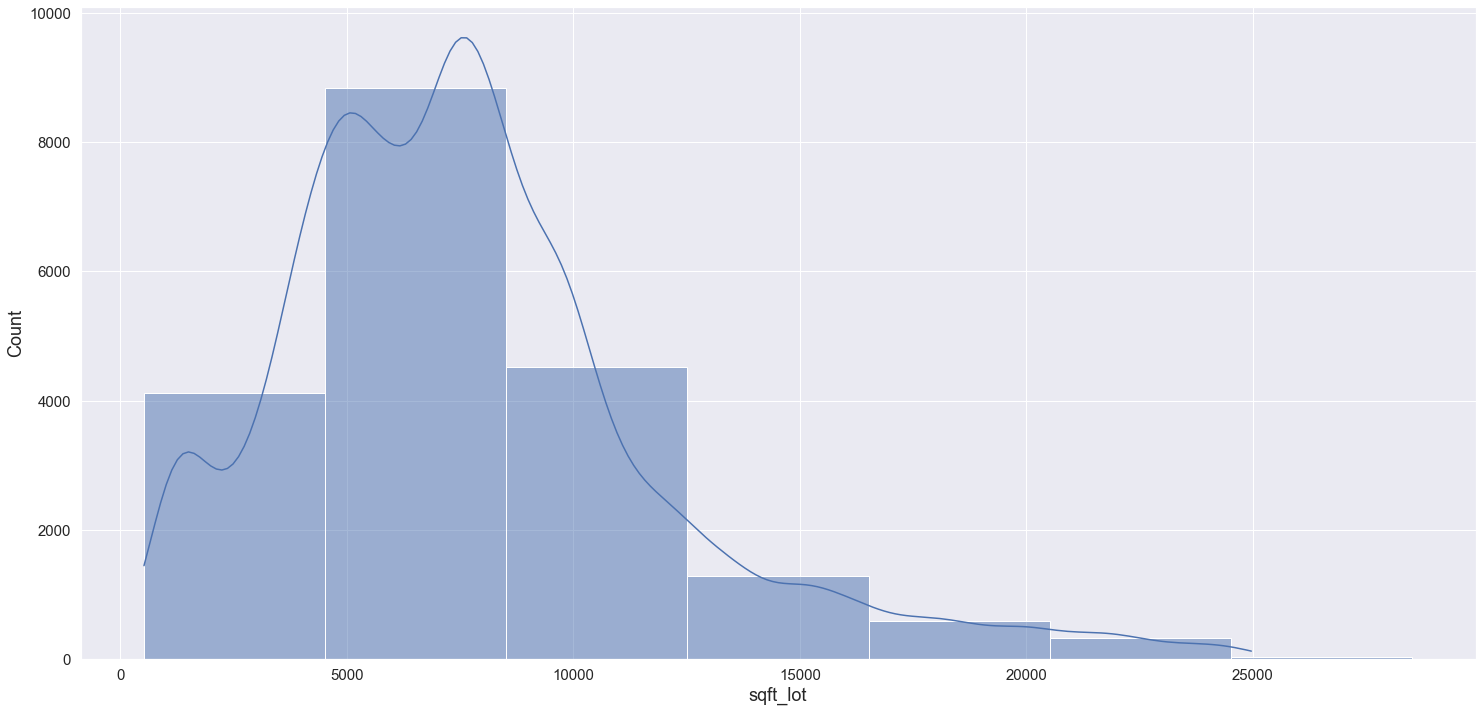

In [68]:
#lotes menores que 25000 sqft --> 2322 m
aux1 = pd.DataFrame()
aux1 = df4.loc[ df4['sqft_lot'] < 25000 ]
print( '\nTotal de linhas selecionadas {}'.format(df4.loc[ df4['sqft_lot'] < 25000 ].shape[0]), '\n')
sns.histplot(data = aux1, x = 'sqft_lot', binwidth = 4000, kde = True );

In [69]:
#Floors
df4['floors'].sort_values().unique()

array([1. , 1.5, 2. , 2.5, 3. , 3.5])

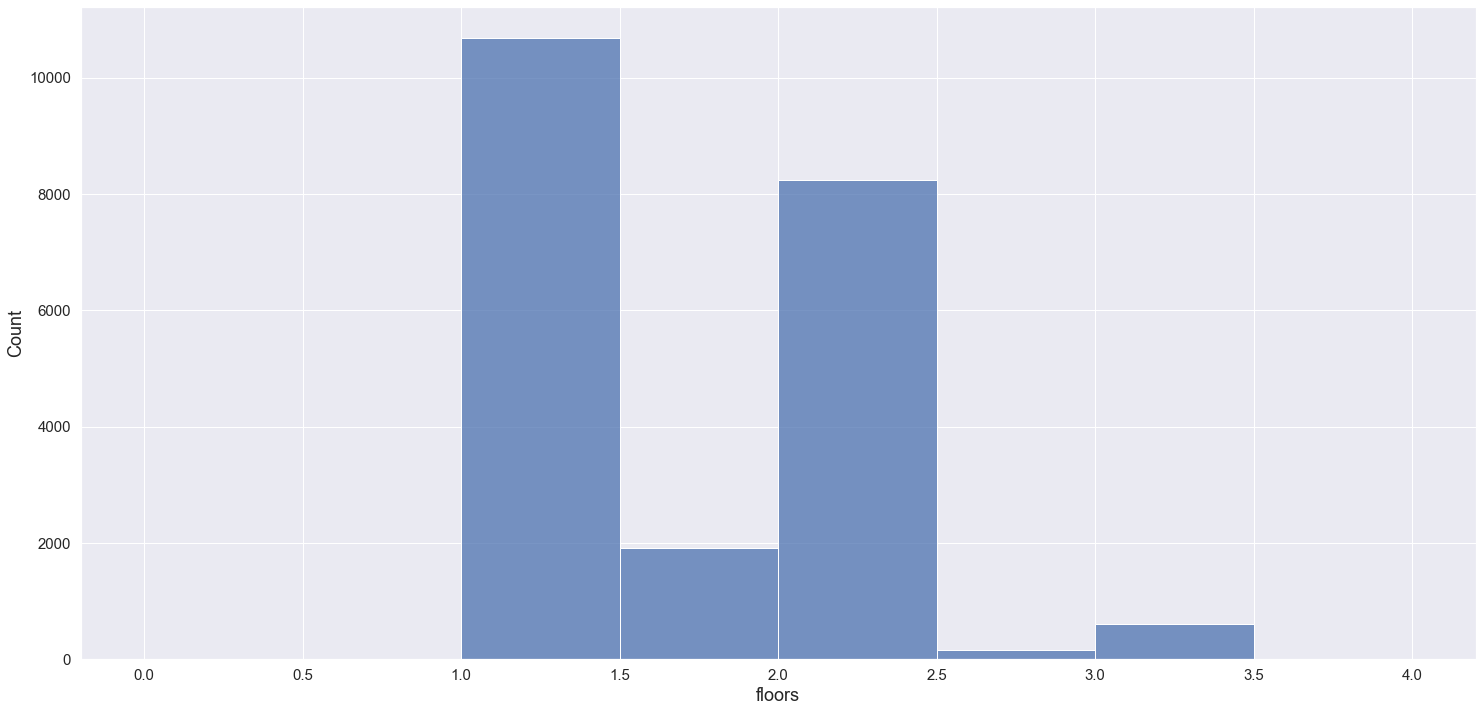

In [70]:
sns.histplot(data = df4, x = 'floors', binwidth = 0.5, binrange = (0,4) );

In [71]:
#bedrooms
df4['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10])

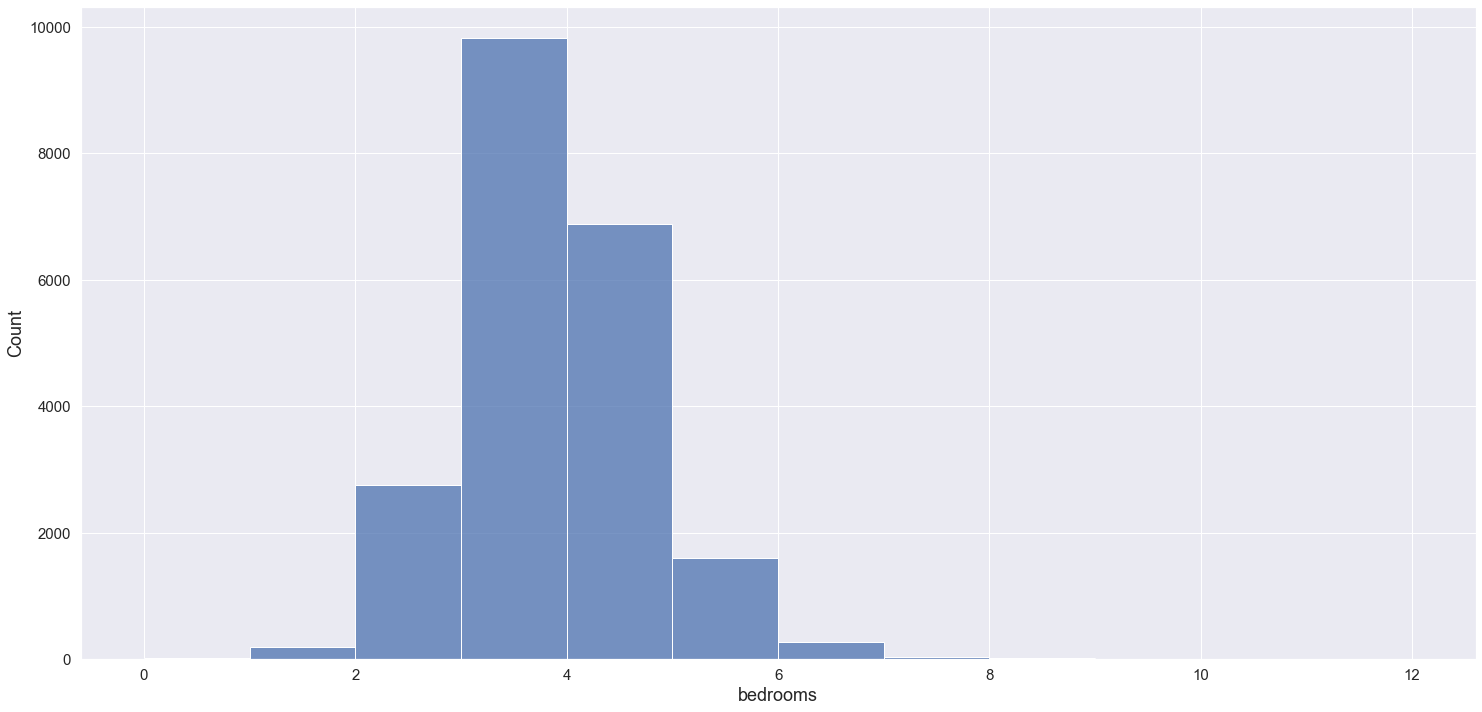

In [72]:
sns.histplot(data = df4, x = 'bedrooms', binwidth = 1, binrange = (0,12) );

### 4.1.3 Categorical Variables

In [73]:
# Todas as variaveis categoricas, exceto 'date'
cat_attributes = df4[['waterfront','view','condition','grade', 'zipcode', 'season','city','avenue', 'basement',
                      'sqft_living_compare','sqft_lot_compare']]
cat_attributes.head()

waterfront  view  condition  grade zipcode  season       city  avenue  basement  sqft_living_compare  sqft_lot_compare
0           0     0          3      7   98178    fall    seattle       1         0                    0                 0
1           0     0          3      7   98125    fall    seattle       0         1                    1                 0
2           0     0          3      6   98028  winter    kenmore       1         0                    0                 1
3           0     0          5      7   98136    fall    seattle       0         1                    1                 0
4           0     0          3      8   98074  winter  sammamish       1         0                    0                 1

In [74]:
# quantidade de categorias por variavel categorica
cat_attributes.apply( lambda x: x.unique().shape[0] )

waterfront              2
view                    5
condition               5
grade                  12
zipcode                70
season                  4
city                   24
avenue                  2
basement                2
sqft_living_compare     2
sqft_lot_compare        2
dtype: int64

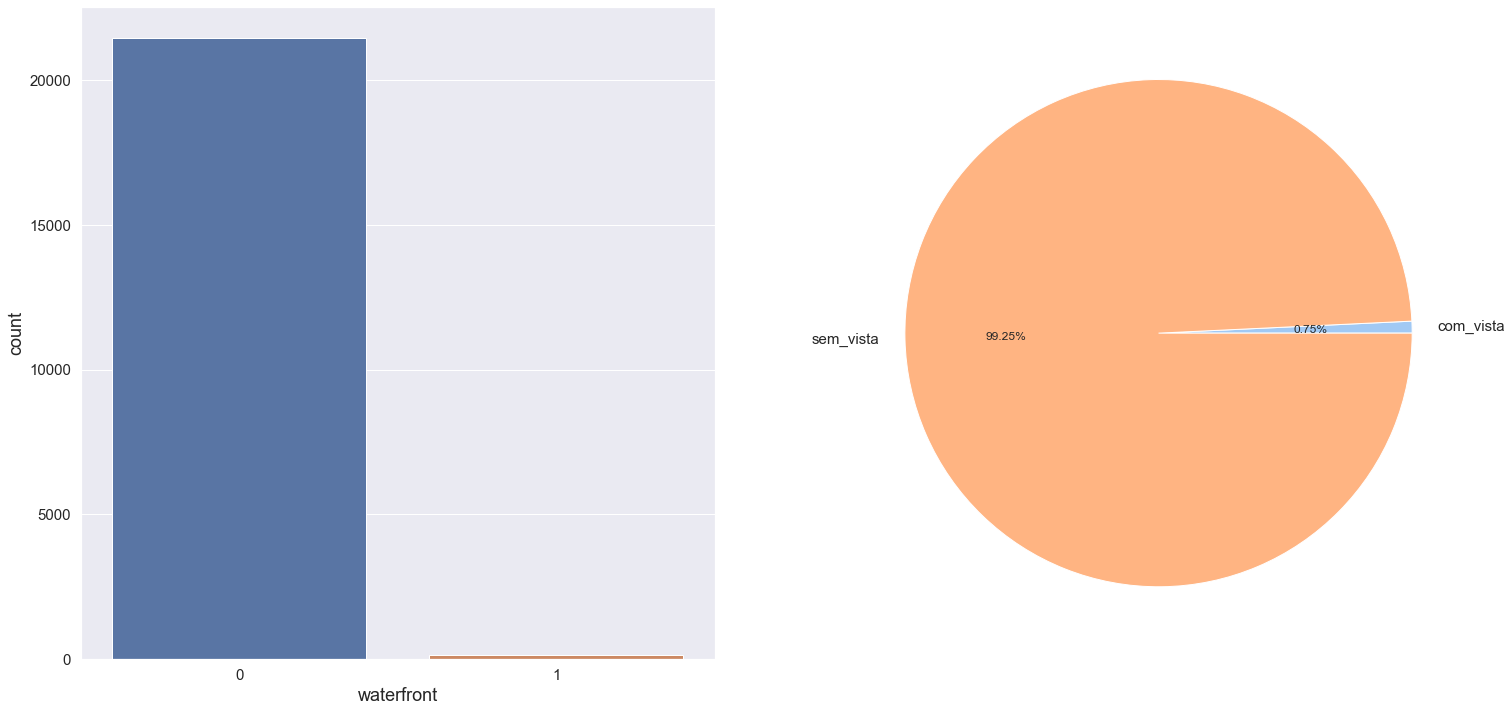

In [75]:
#Waterfront
plt.subplot(1,2,1)
sns.countplot(data=df4,x='waterfront');

#pie chart
aux1 = percentage_pandas(df4[ df4['waterfront']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['waterfront']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_vista','sem_vista']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

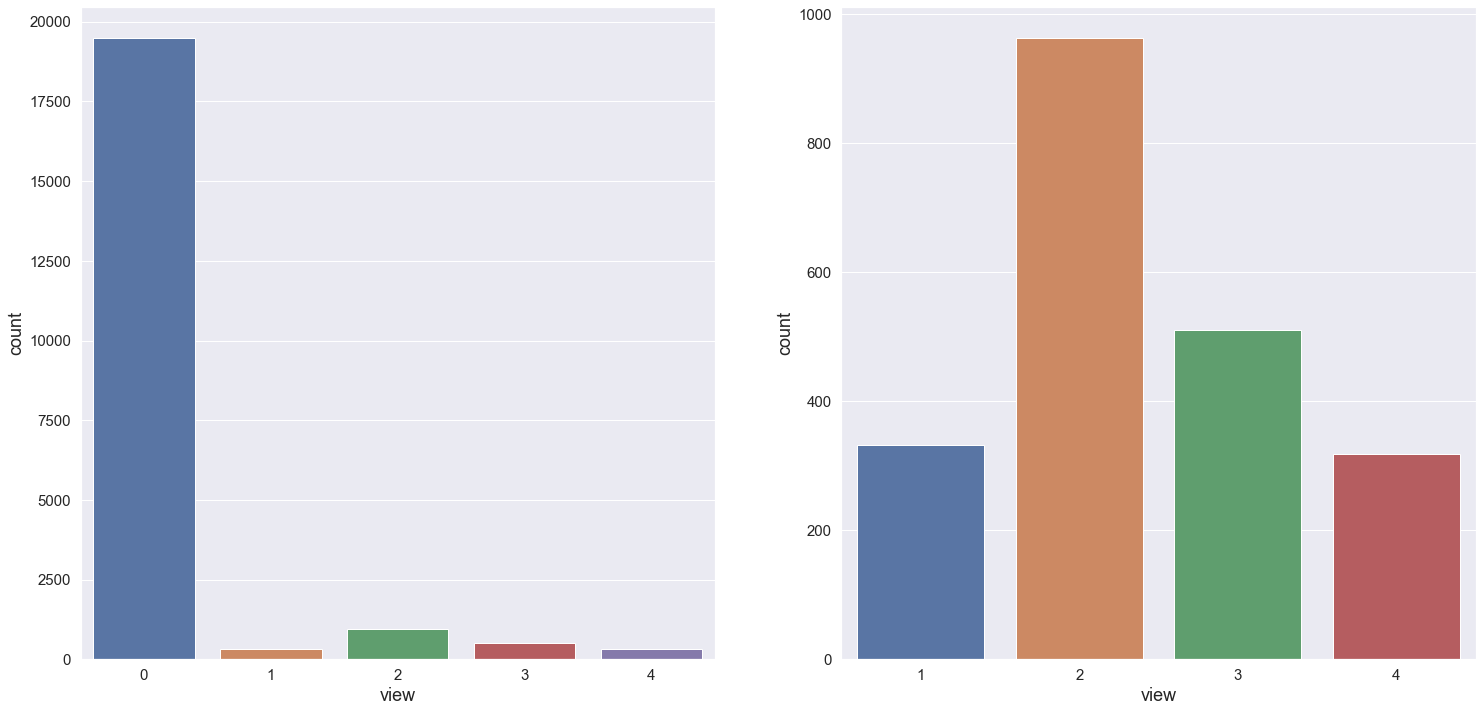

In [76]:
#view
plt.subplot(1,2,1)

sns.countplot(data = df4, x = 'view');

plt.subplot(1,2,2)
aux1 = df4[ df4['view'] != 0 ]
#colors = sns.color_palette('pastel')[0:5]
sns.countplot(data = aux1, x = 'view');

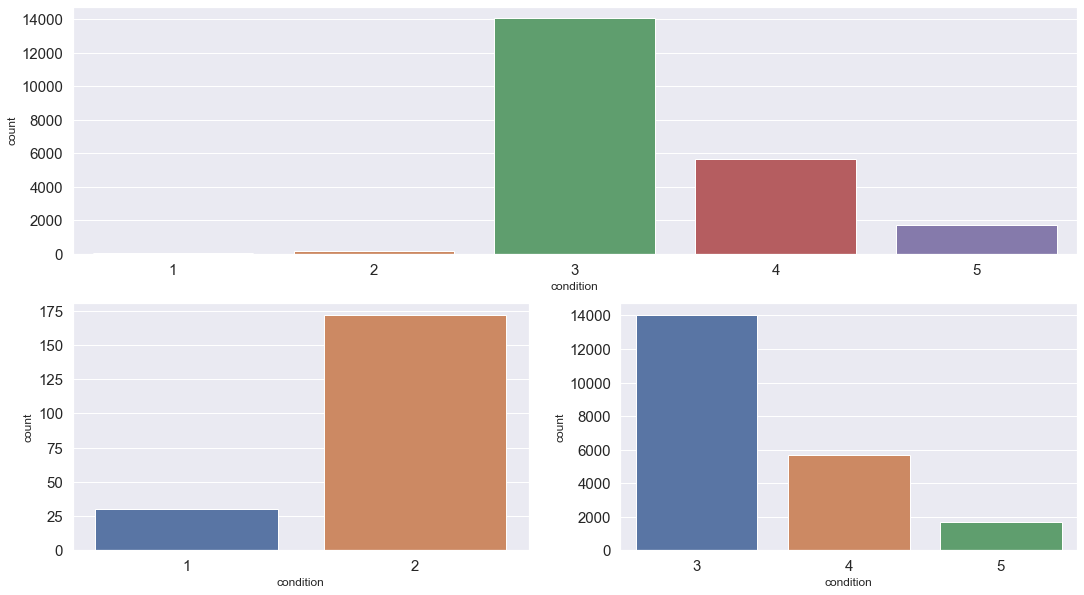

In [77]:
#condition
fig = plt.figure( figsize = (18,10) )
plt.rc('axes',  labelsize=12);
specs = gridspec.GridSpec( ncols = 2, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,:] )
ax2 = fig.add_subplot( specs[ 1,0] )
ax3 = fig.add_subplot( specs[ 1,1] )

#geral
sns.countplot(data = df4, x = 'condition',ax = ax1);

#precario - ruim
aux1 = df4[ (df4['condition'] < 3) ]
sns.countplot( data = aux1, x = 'condition',ax = ax2);

#regular - bom - otimo
aux1 = df4[ (df4['condition'] >= 3) ]
sns.countplot( data = aux1, x = 'condition', ax = ax3);

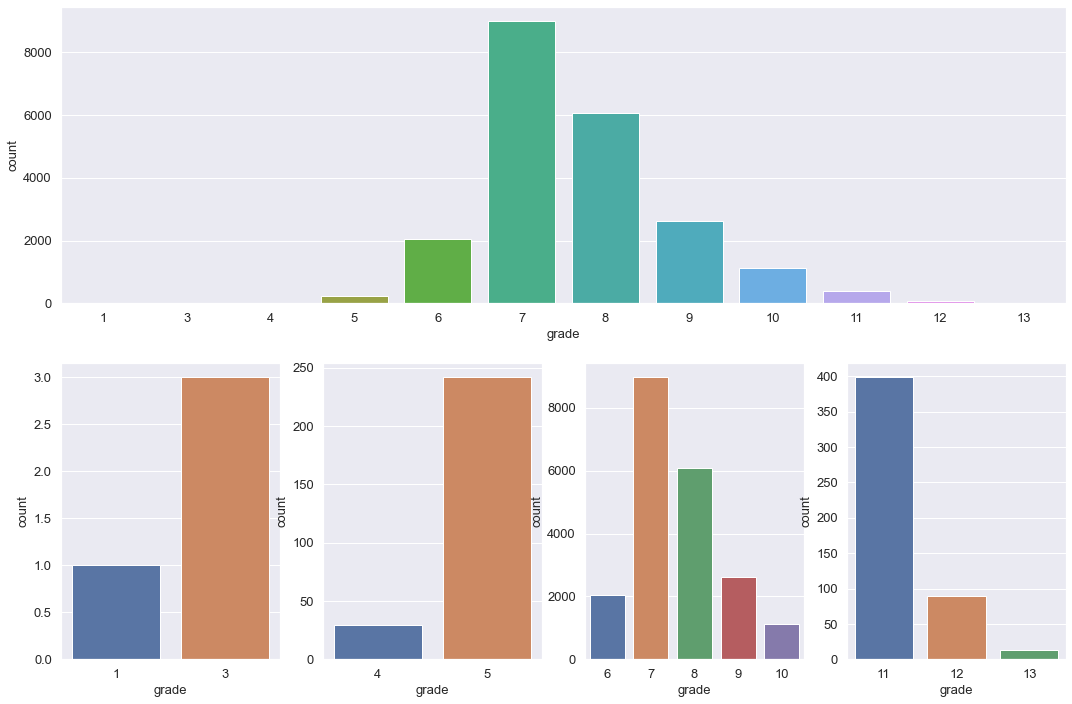

In [78]:
#grade

fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( ncols = 4, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,:] )
ax2 = fig.add_subplot( specs[ 1,0] )
ax3 = fig.add_subplot( specs[ 1,1] )
ax4 = fig.add_subplot( specs[ 1,2] )
ax5 = fig.add_subplot( specs[ 1,3] )

# All grades
sns.countplot(data = df4, x = 'grade',ax = ax1);

# padrao baixo de acabamento e design da construcao
aux1 = df4[ (df4['grade'] < 4) ]
sns.countplot( data = aux1, x = 'grade',ax = ax2);

# padrao medio de acabamento e design da construcao
aux1 = df4[ (df4['grade'] >= 4) & (df4['grade'] < 6)]
sns.countplot( data = aux1, x = 'grade', ax = ax3);

# padrao medio de acabamento e design da construcao
aux1 = df4[ (df4['grade'] >= 6) & (df4['grade'] < 11)]
sns.countplot( data = aux1, x = 'grade', ax = ax4);

# padrao alto de acabamento e desing da construcao
aux1 = df4[ (df4['grade'] >= 11) ]
sns.countplot( data = aux1, x = 'grade', ax = ax5);

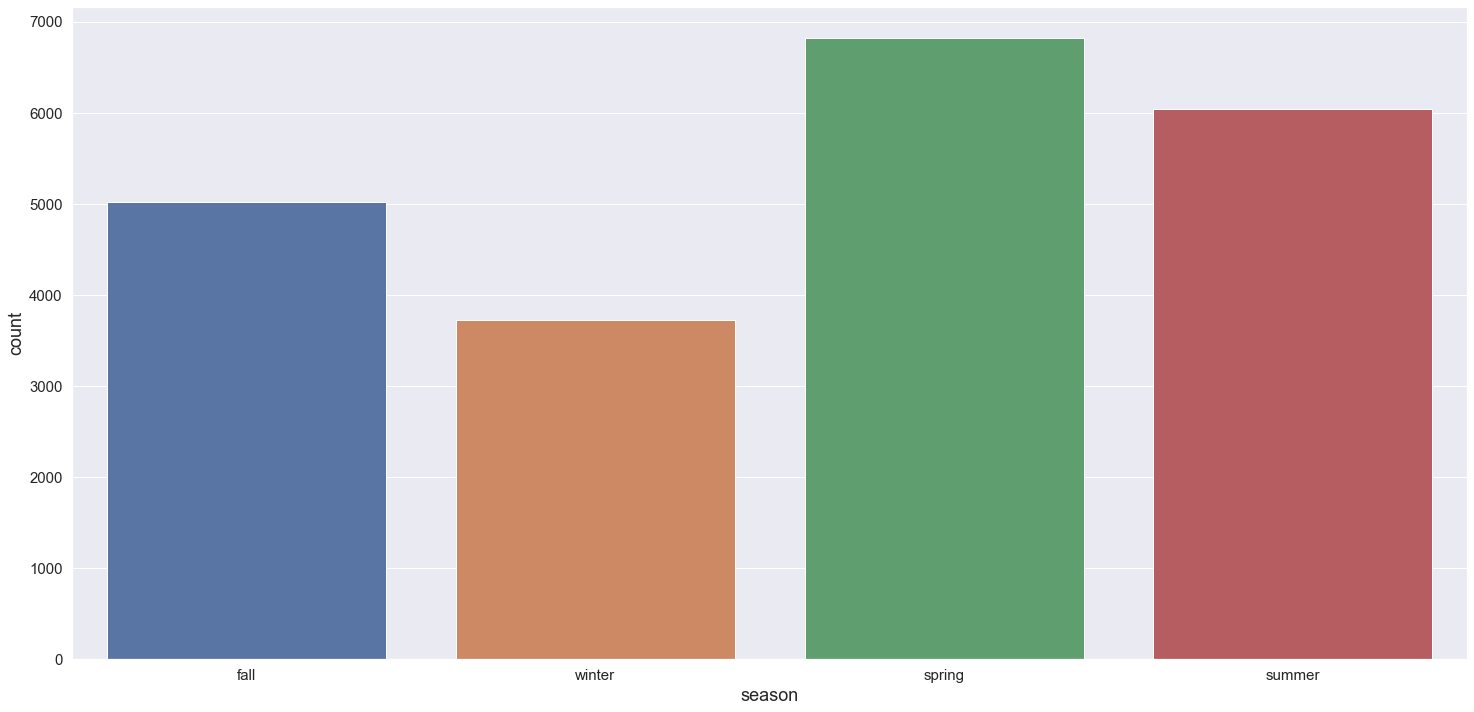

In [79]:
#season
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
sns.countplot(data=df4,x='season');

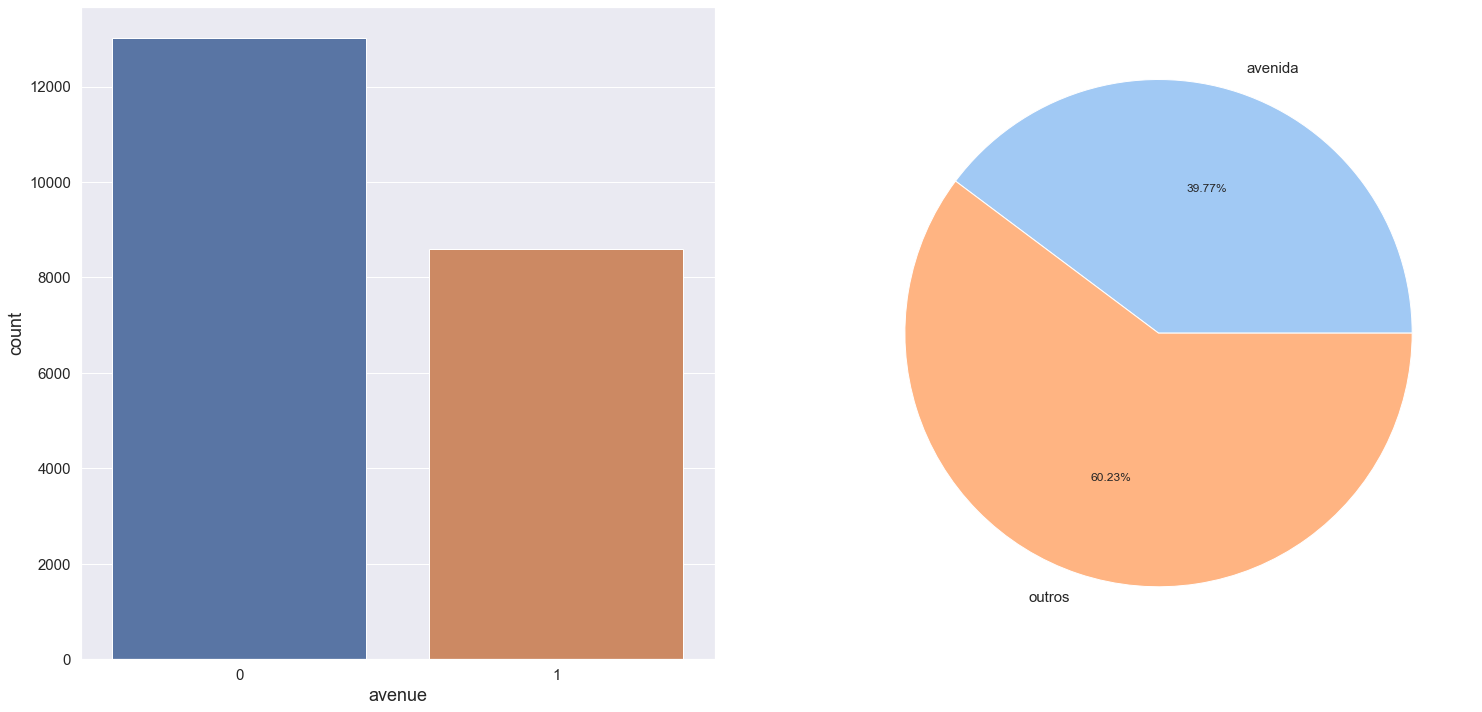

In [80]:
#avenue
plt.subplot(1,2,1)
sns.countplot(data=df4,x='avenue');

#pie chart
aux1 = percentage_pandas(df4[ df4['avenue']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['avenue']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['avenida','outros']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

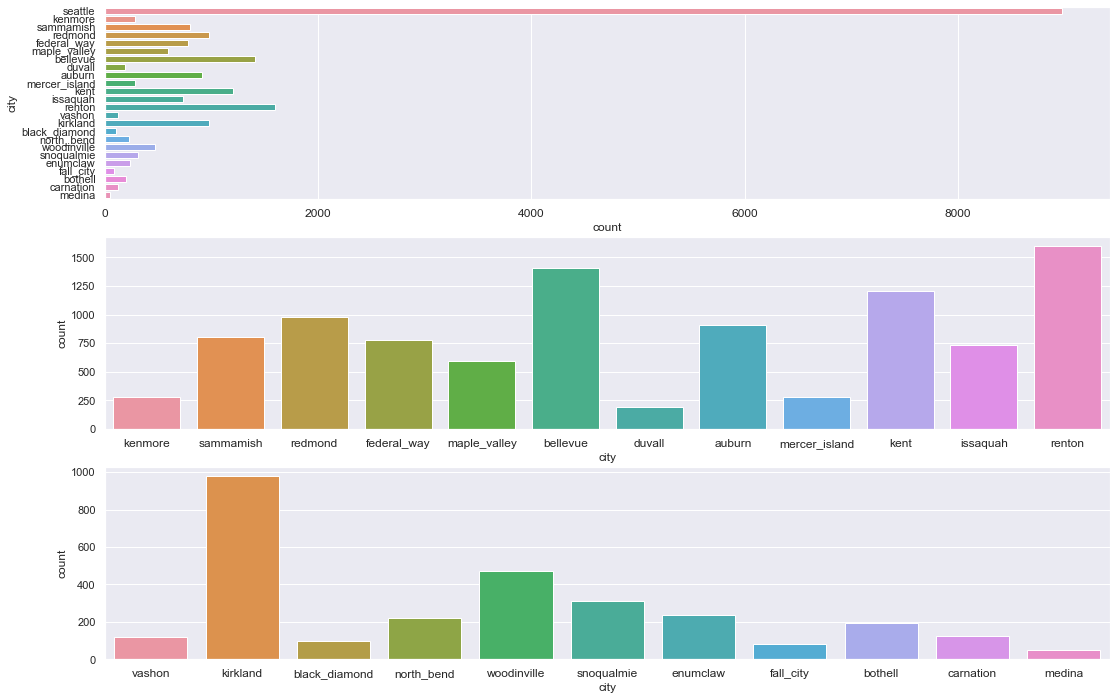

In [81]:
#city
fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=11)
plt.rc('axes',  labelsize=12)  
specs = gridspec.GridSpec( ncols = 1, nrows = 3, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax2 = fig.add_subplot( specs[ 1,0] )
ax3 = fig.add_subplot( specs[ 2,0] )

#todas as cidades
sns.countplot(data=df4, y='city', ax = ax1);

sns.countplot(data=df4, x='city', ax = ax2, order = ['kenmore', 'sammamish', 'redmond', 'federal_way',
                                                     'maple_valley', 'bellevue', 'duvall', 'auburn', 
                                                     'mercer_island','kent', 'issaquah', 'renton'] );

sns.countplot(data=df4, x='city', ax = ax3, order = ['vashon', 'kirkland','black_diamond', 'north_bend',
                                                     'woodinville', 'snoqualmie','enumclaw', 'fall_city',
                                                     'bothell', 'carnation', 'medina'] );

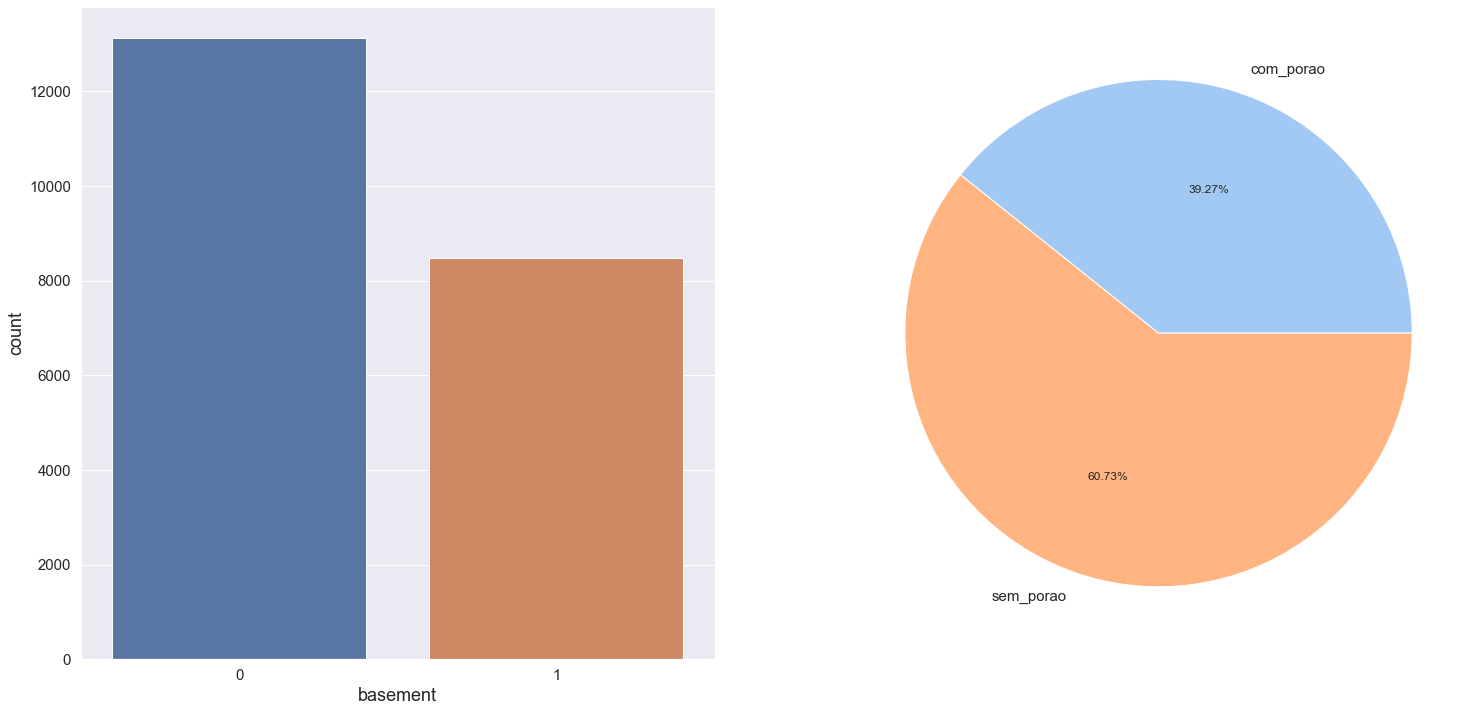

In [82]:
#Porão
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
plt.subplot(1,2,1)
sns.countplot(data=df4,x='basement');

#pie chart
aux1 = percentage_pandas(df4[ df4['basement']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['basement']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_porao','sem_porao']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

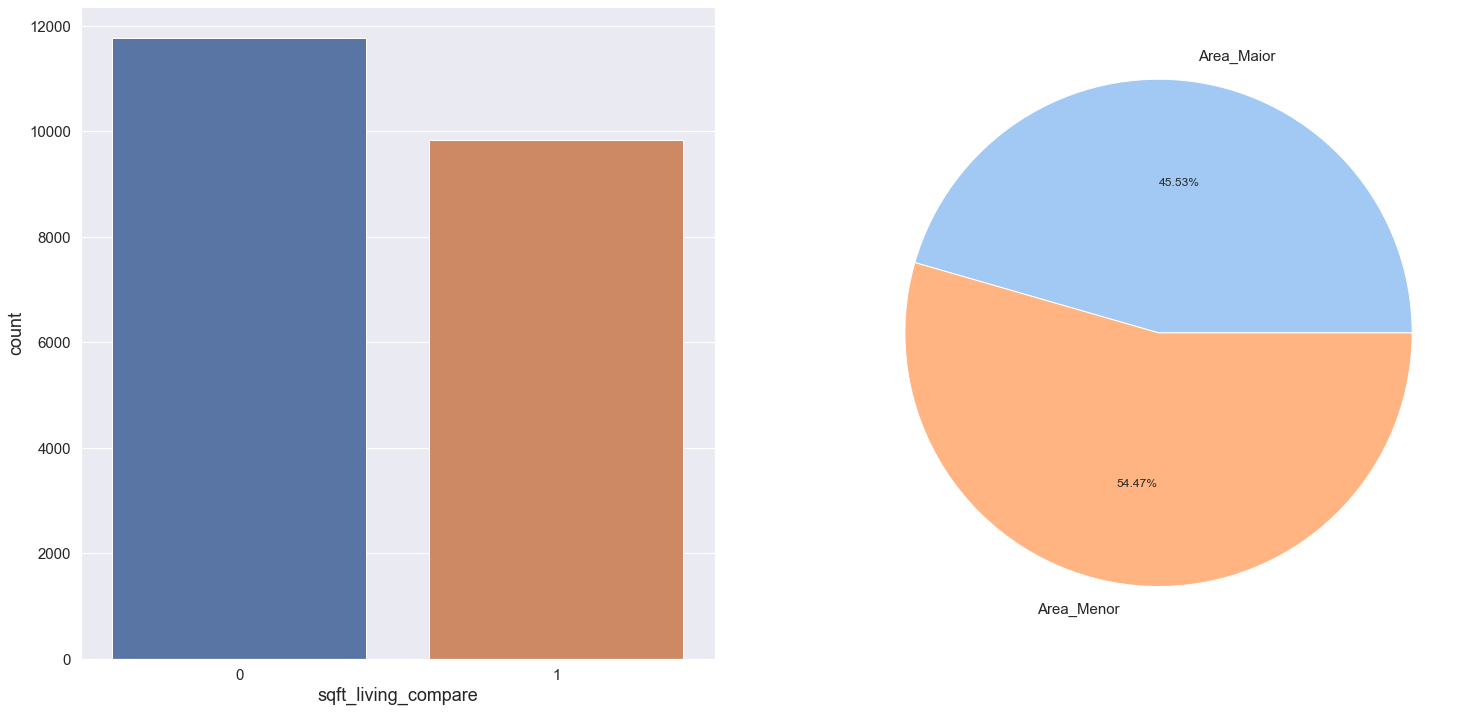

In [83]:
#sqft_living_compare
plt.subplot(1,2,1)
sns.countplot(data=df4,x='sqft_living_compare');

#pie chart
aux1 = percentage_pandas(df4[ df4['sqft_living_compare']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['sqft_living_compare']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['Area_Maior','Area_Menor']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

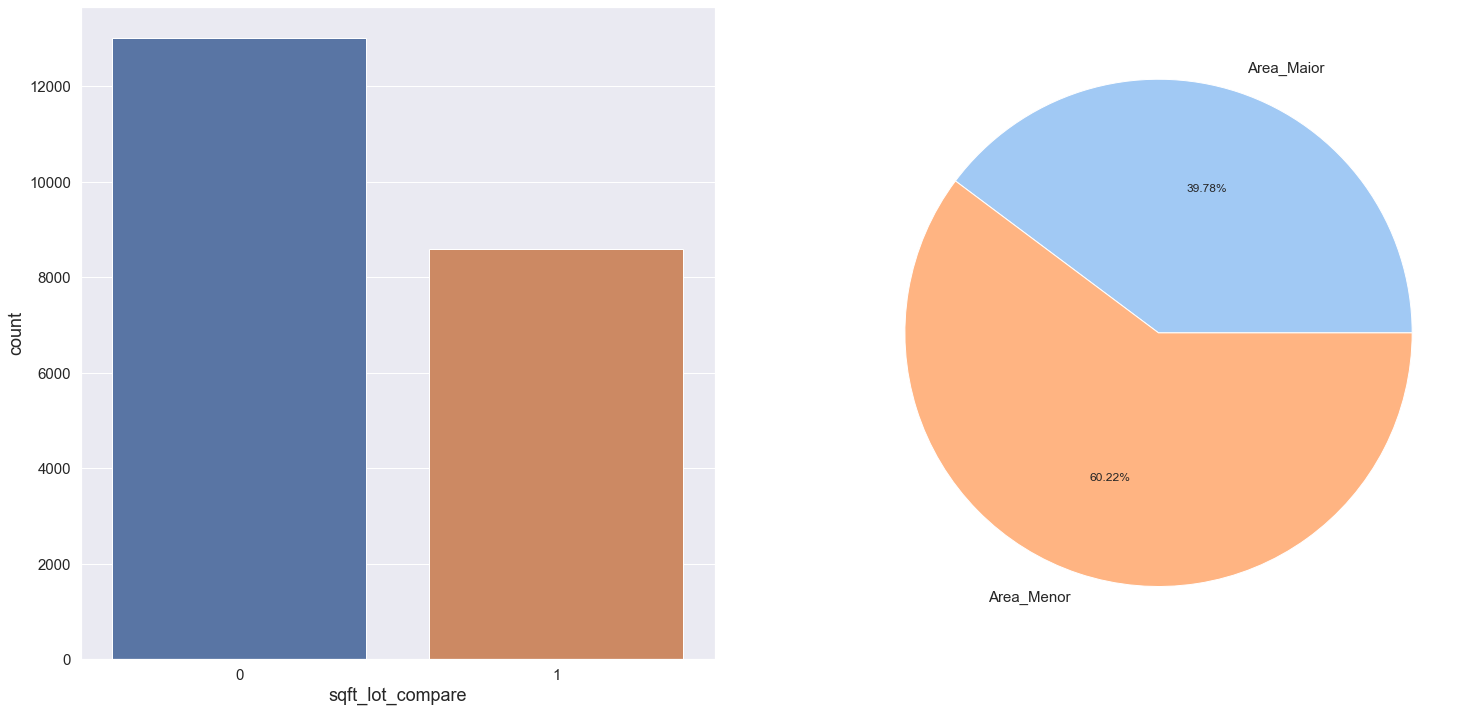

In [84]:
#sqft_lot_compare
plt.subplot(1,2,1)
sns.countplot(data=df4,x='sqft_lot_compare');

#pie chart
aux1 = percentage_pandas(df4[ df4['sqft_lot_compare']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['sqft_lot_compare']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['Area_Maior','Area_Menor']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

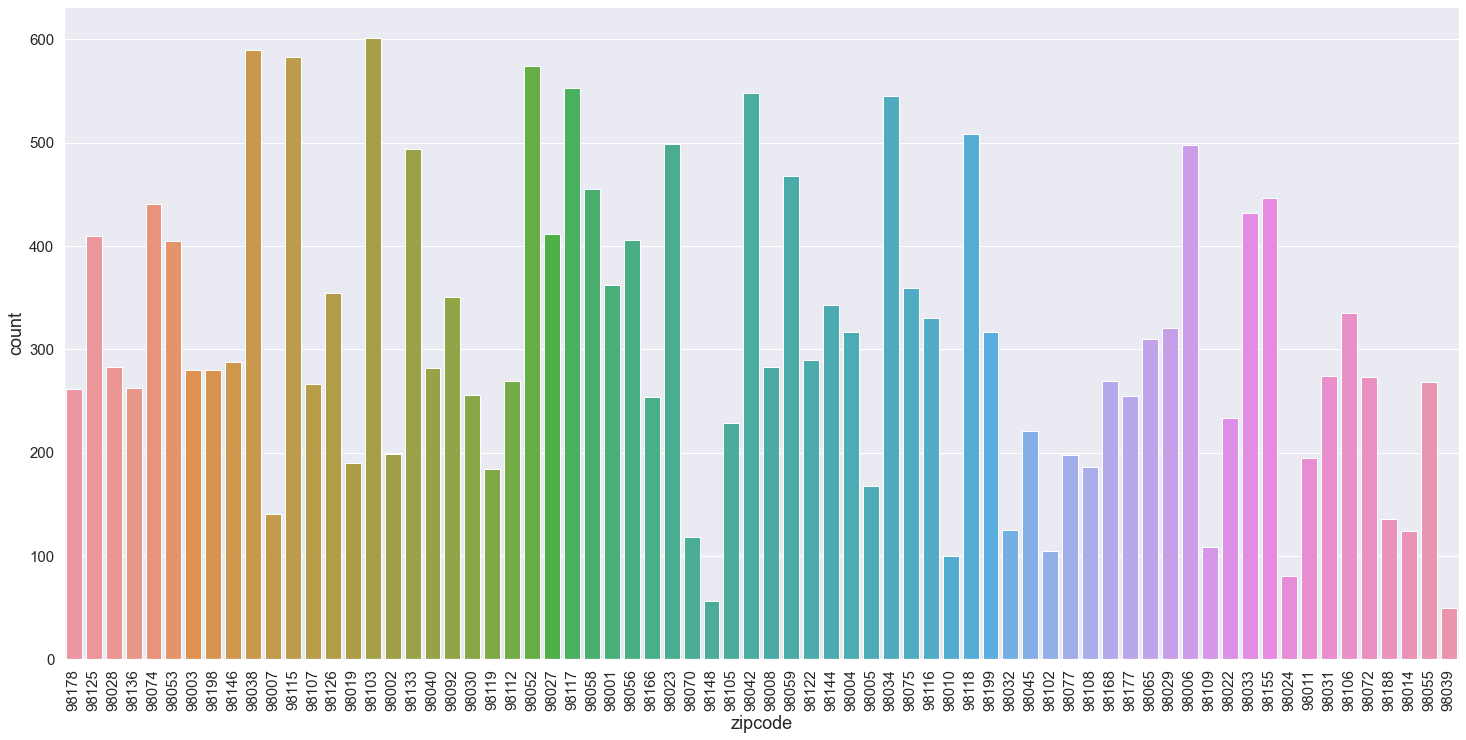

In [85]:
# quantidade de imoveis vendidos por zipcodes
sns.countplot( data = df4, x= 'zipcode');
plt.xticks(rotation = 'vertical');

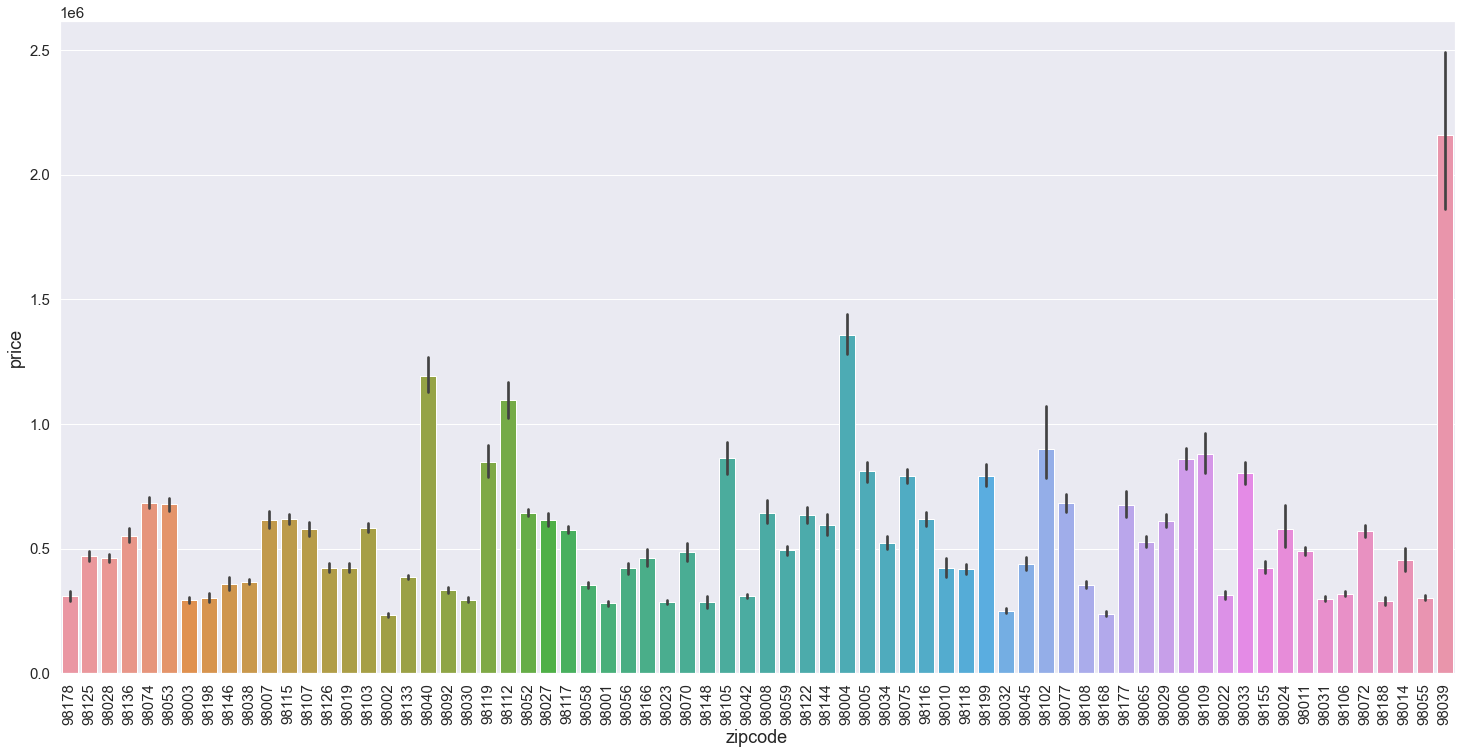

In [86]:
# Somatorio das vendas por zipcode
sns.barplot(data = df4, x = 'zipcode', y = 'price');
plt.xticks( rotation = 'vertical');

## 4.2 Análise Bivariada

### 4.2.1 Hipótese 1: Imóveis com maior área construída possuem preços maiores.
Hipótese Verdadeira: Imóveis com maior área construída possuem maior preço de venda

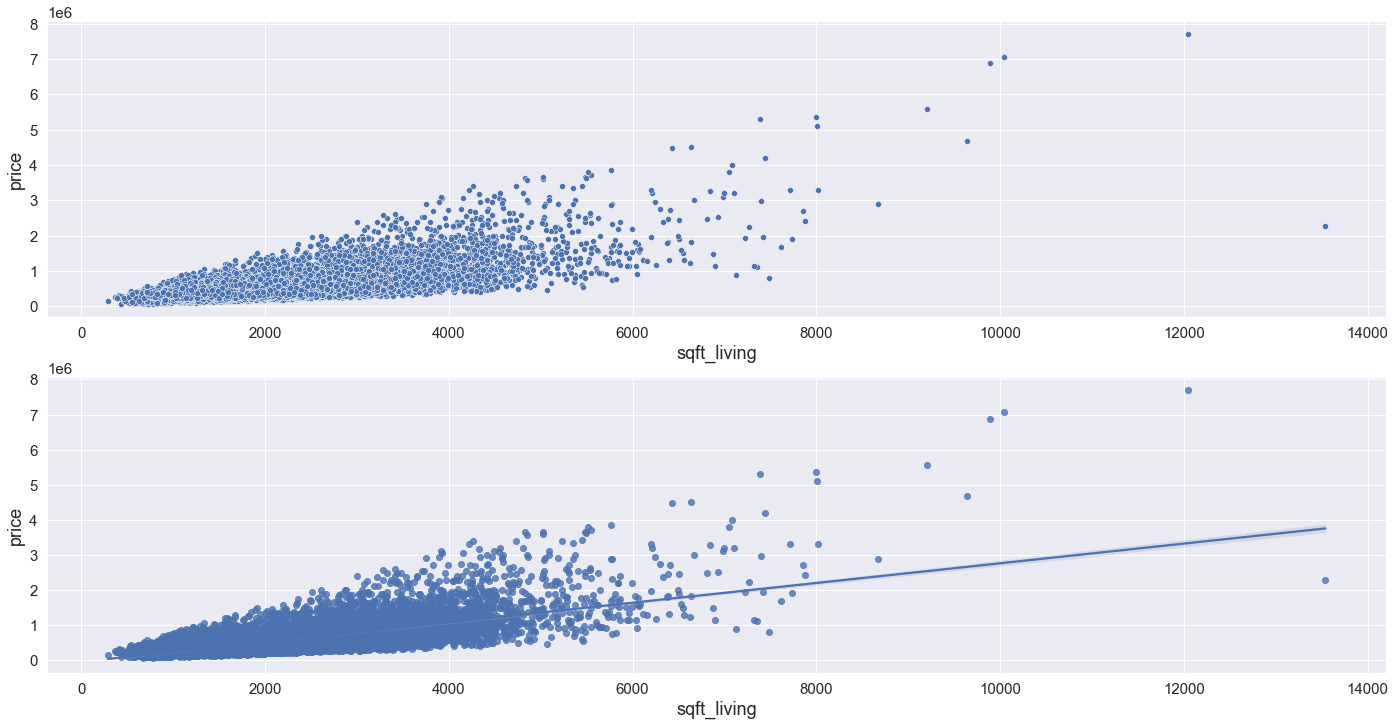

In [87]:
fig = plt.figure( figsize = (24,12) )
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax2 = fig.add_subplot( specs[ 1,0] )

sns.scatterplot(data = df4, x = 'sqft_living', y = 'price', ax = ax1);

sns.regplot( x = 'sqft_living', y = 'price', data = df4, ax = ax2 );

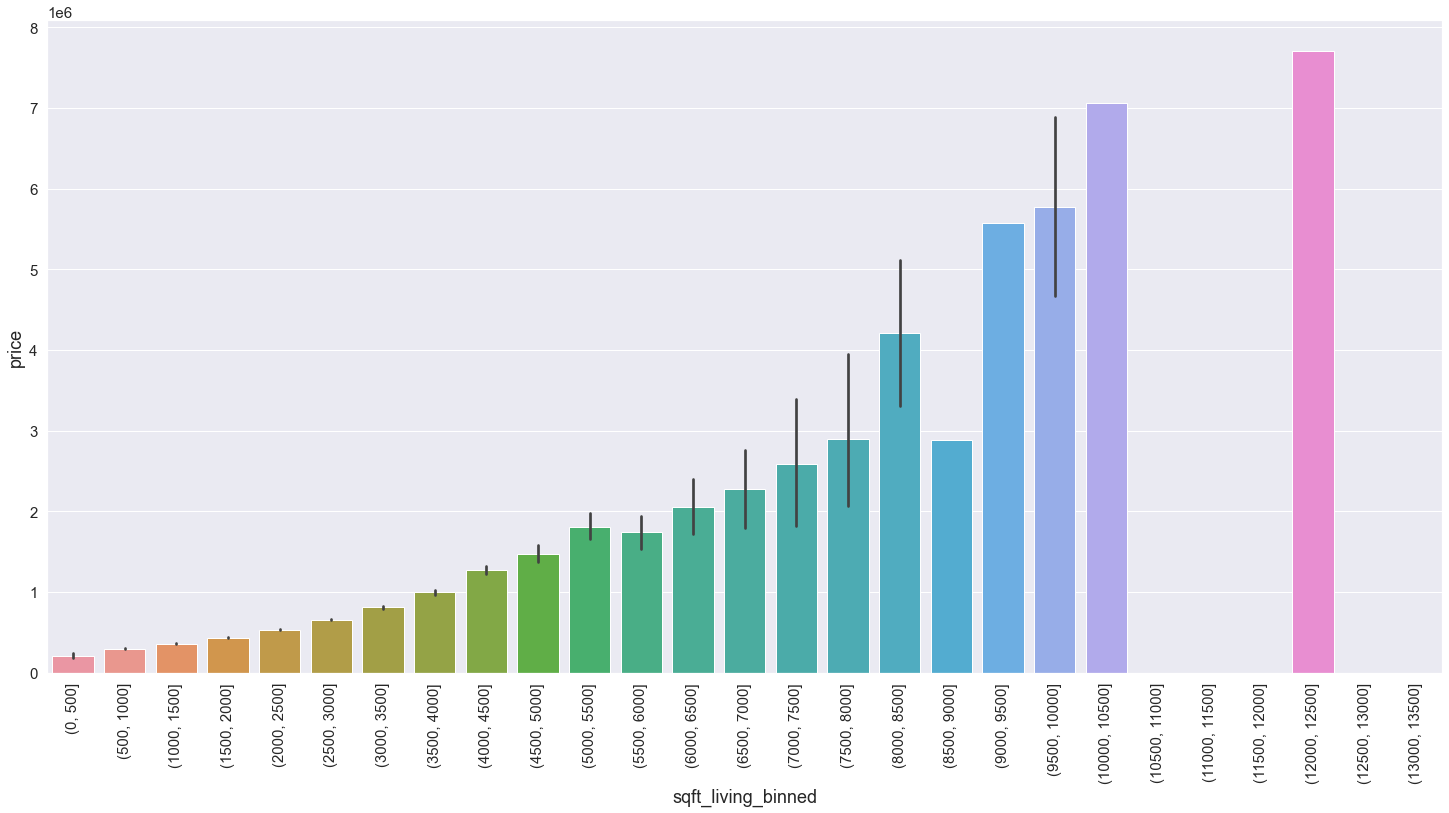

In [88]:
# volume medio por faixa de bin (range total)
aux1 = df4.copy()
bins = np.arange(0, 14000, 500 )
aux1['sqft_living_binned'] = pd.cut( df4['sqft_living'], bins = bins)

#geral
sns.barplot( x = 'sqft_living_binned', y = 'price', data = aux1);
plt.xticks( rotation = 'vertical' );

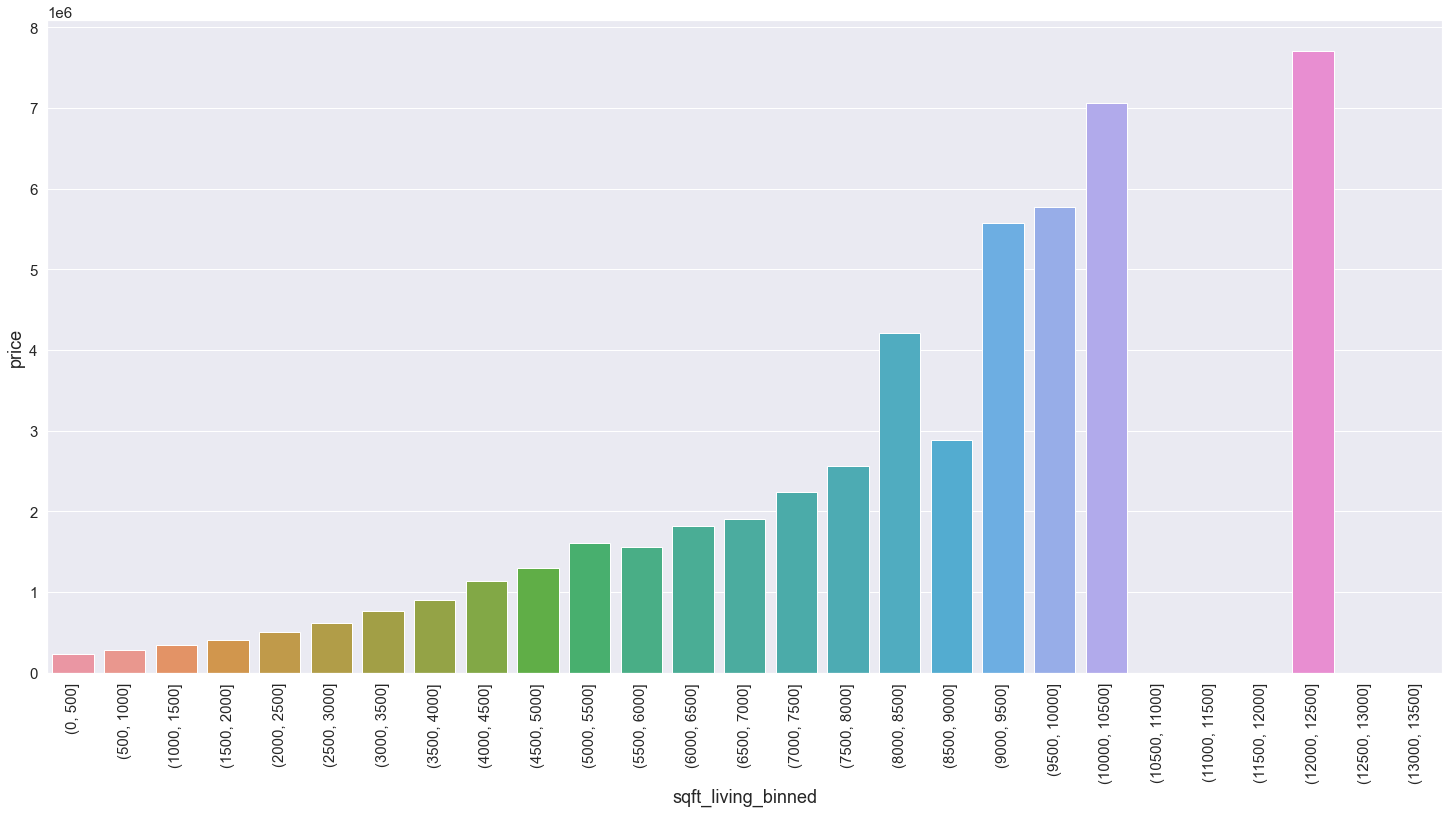

In [89]:
#volume mediano por faixa de bin (range total)
aux3 = aux1[ ['sqft_living_binned', 'price' ]].groupby('sqft_living_binned').median().reset_index()
sns.barplot( x = 'sqft_living_binned', y = 'price', data = aux3);
plt.xticks( rotation = 90 );

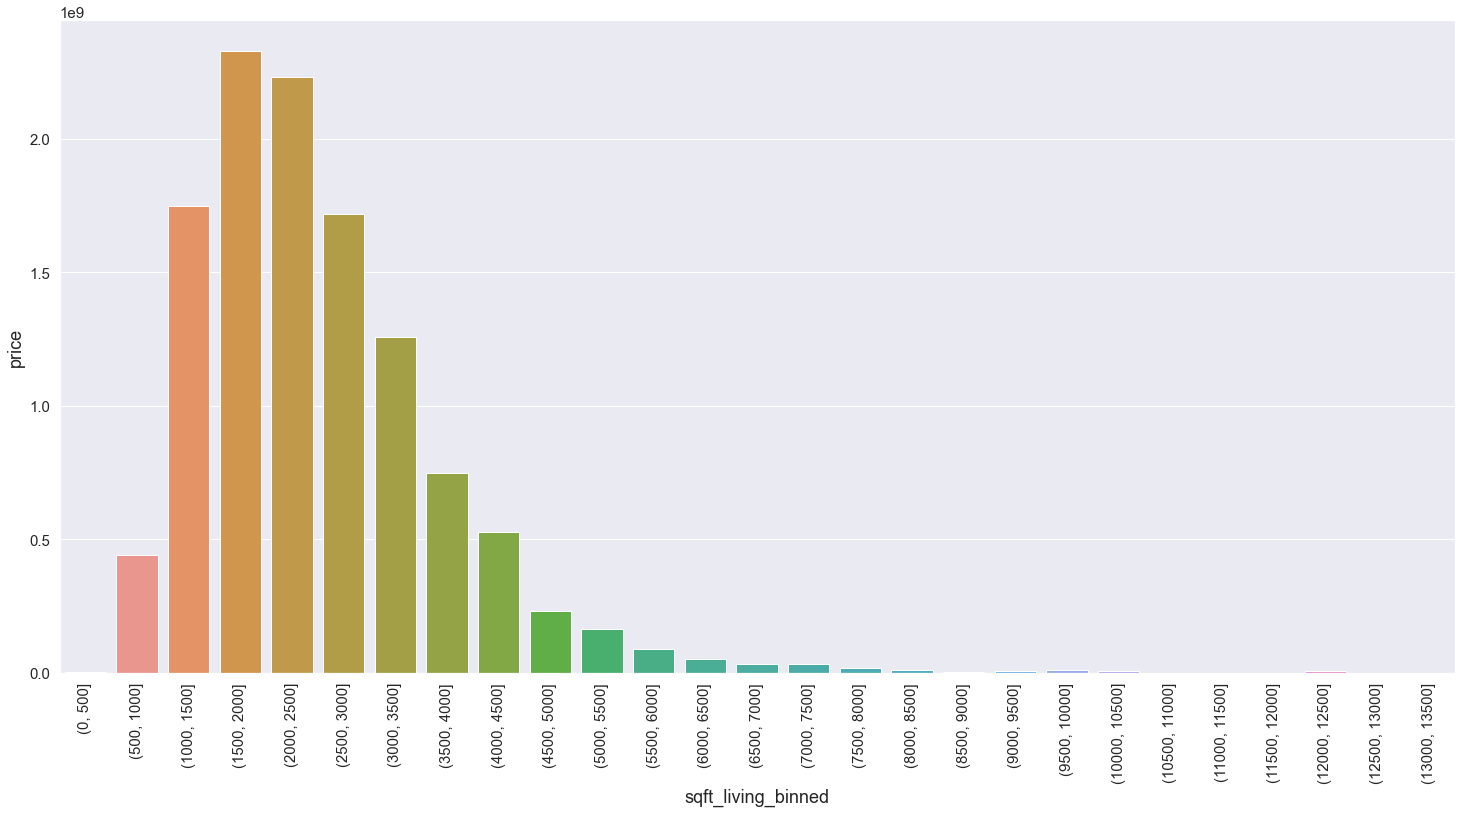

In [90]:
# Volume total de vendas por faixa
aux3 = aux1[ ['sqft_living_binned', 'price' ]].groupby('sqft_living_binned').sum().reset_index()
sns.barplot( x = 'sqft_living_binned', y = 'price', data = aux3);
plt.xticks( rotation = 90 );

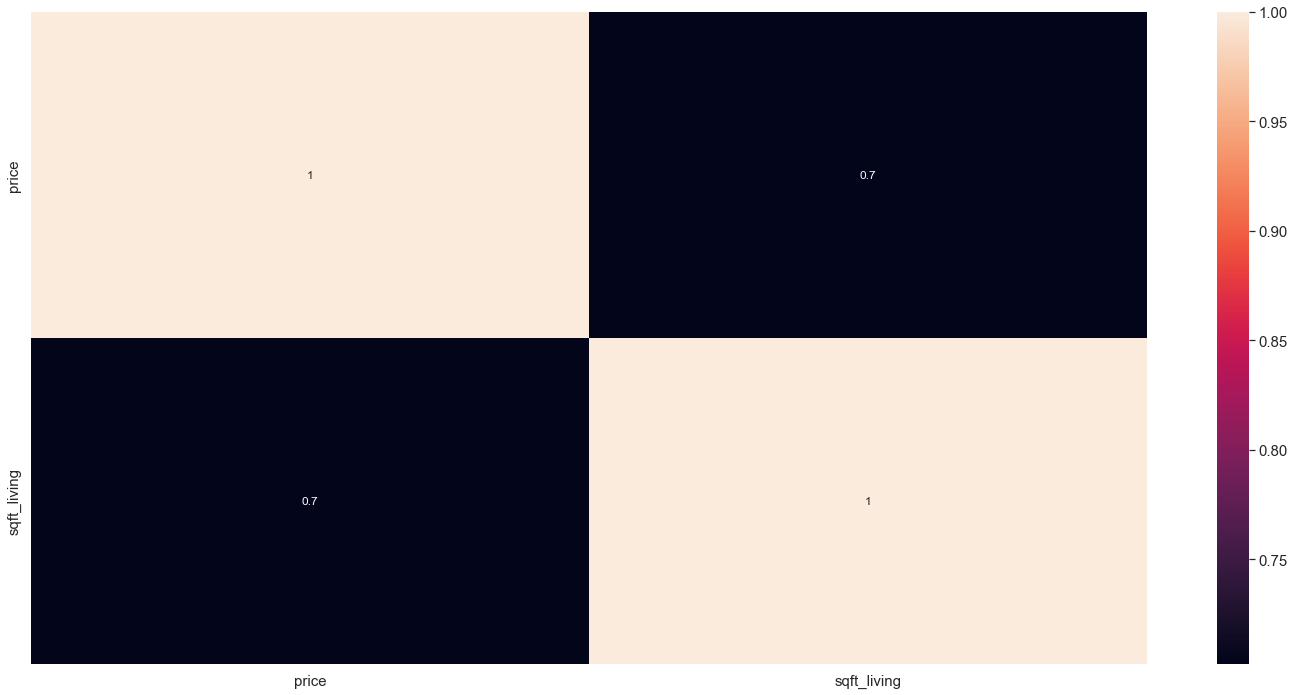

In [91]:
# correlacao com price
aux1 = df4[['price','sqft_living']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.2 Hipótese 2: Imóveis com lotes maiores possuem preços maiores.
Hipótese Falsa: Imóveis com lotes maiores não possuem preços de venda maiores

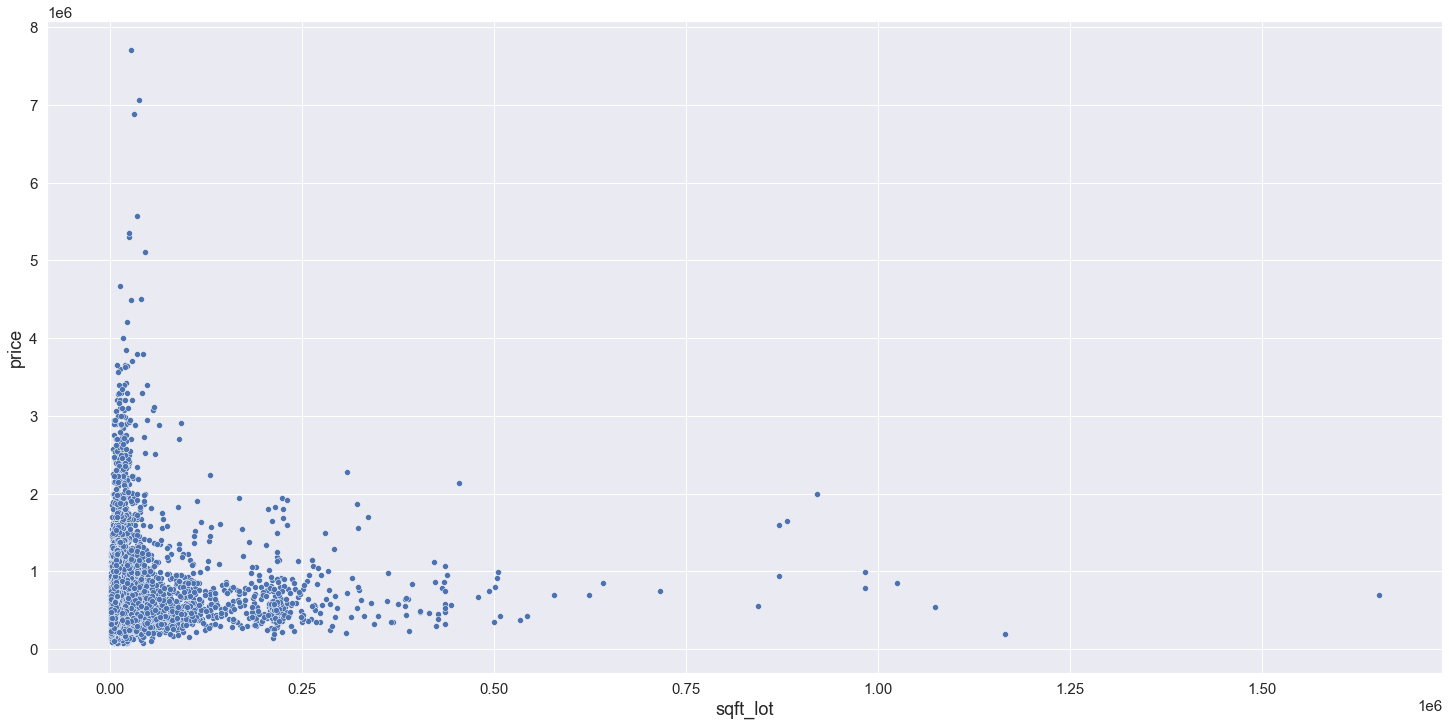

In [92]:
sns.scatterplot(data = df4, x = 'sqft_lot', y = 'price');

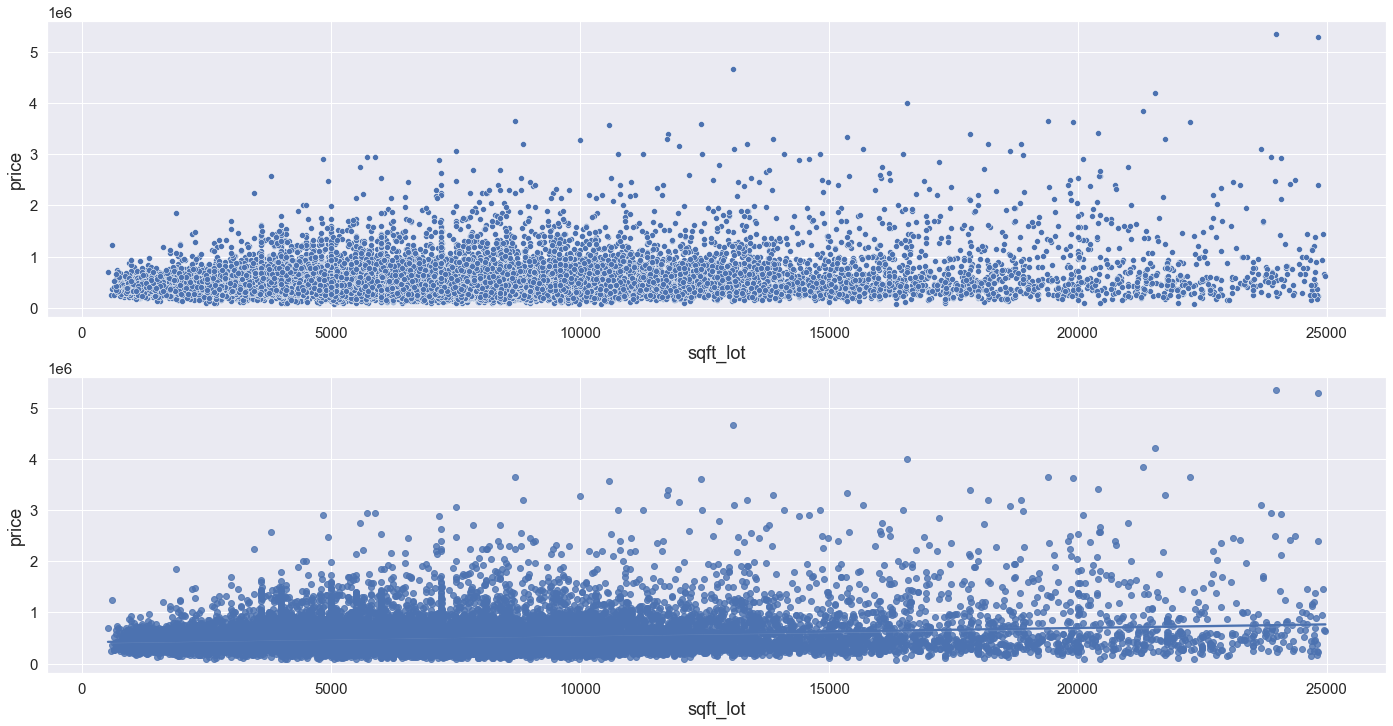

In [93]:
aux1=pd.DataFrame()
aux1 = df4.loc[ df4['sqft_lot'] < 25000]

fig = plt.figure( figsize = (24,12) )
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax2 = fig.add_subplot( specs[ 1,0] )

sns.scatterplot(data = aux1, x = 'sqft_lot', y = 'price', ax = ax1);

sns.regplot( x = 'sqft_lot', y = 'price', data = aux1, ax = ax2 );

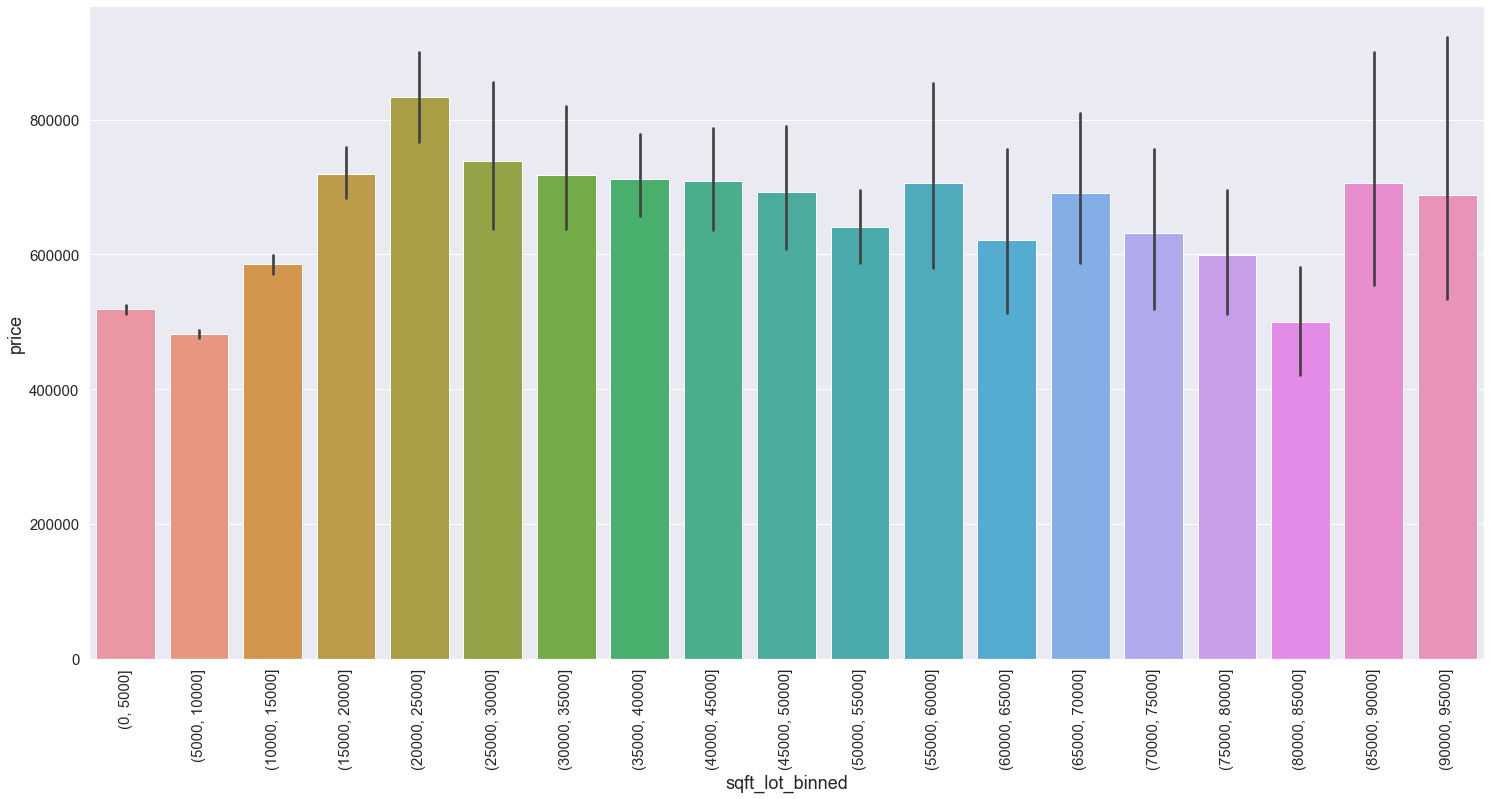

In [94]:
aux1 = df4.copy()
bins = np.arange(0, 100000, 5000 )
aux1['sqft_lot_binned'] = pd.cut( df4['sqft_lot'], bins = bins)

#geral
sns.barplot( x = 'sqft_lot_binned', y = 'price', data = aux1);
plt.xticks(rotation = 'vertical');

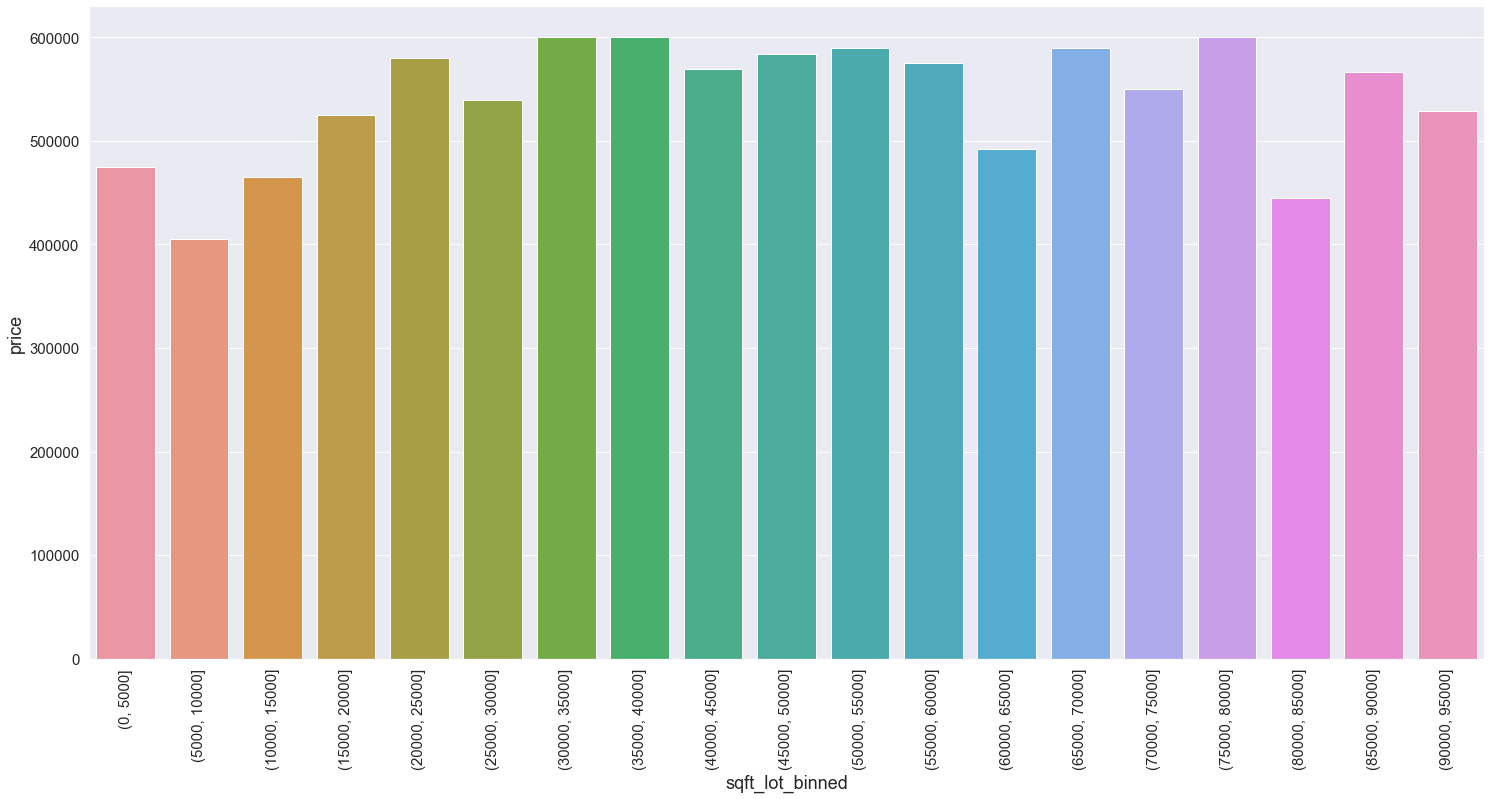

In [95]:
#mediana
aux3 = aux1[ ['sqft_lot_binned', 'price' ]].groupby('sqft_lot_binned').median().reset_index()
sns.barplot( x = 'sqft_lot_binned', y = 'price', data = aux3);
plt.xticks( rotation = 'vertical' );

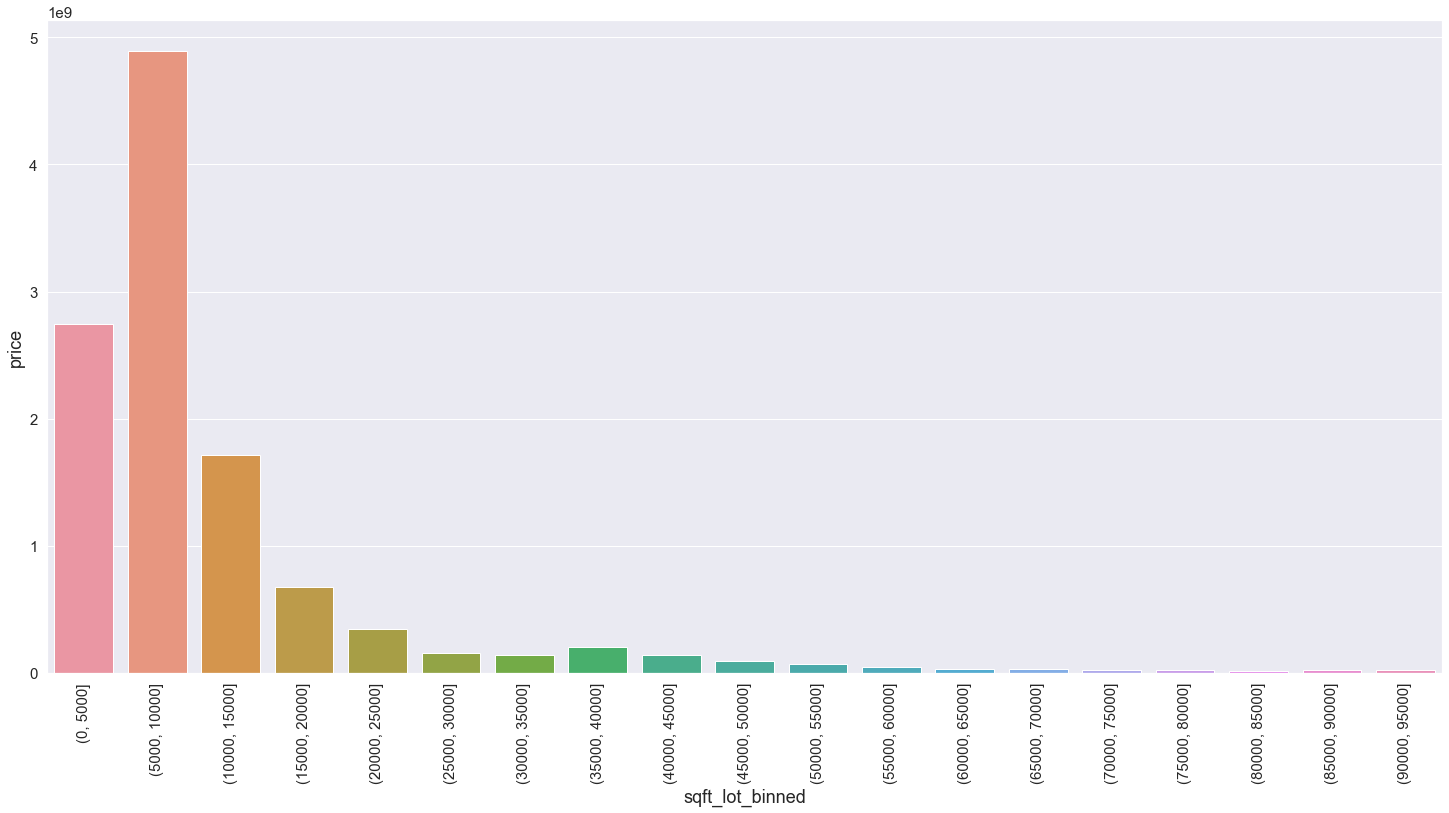

In [96]:
#volume total 
aux3 = aux1[ ['sqft_lot_binned', 'price' ]].groupby('sqft_lot_binned').sum().reset_index()
sns.barplot( x = 'sqft_lot_binned', y = 'price', data = aux3);
plt.xticks( rotation = 'vertical' );

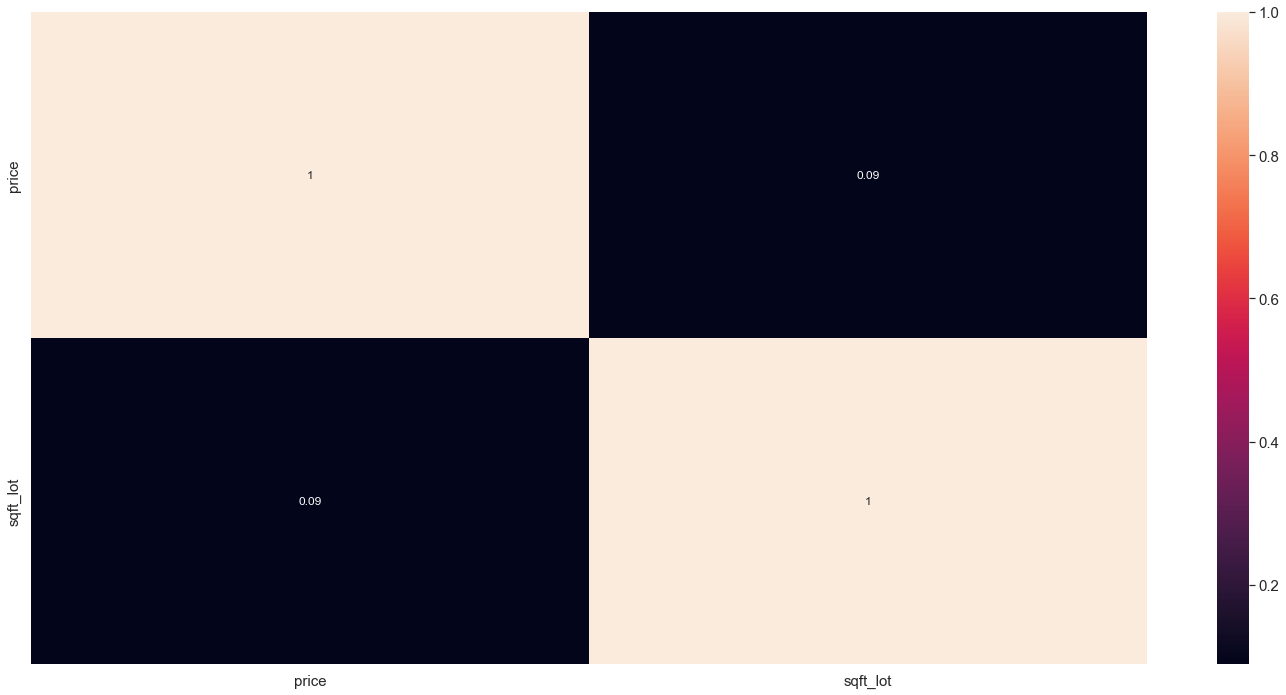

In [97]:
# correlacao com price
aux1 = df4[['price','sqft_lot']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.3 Hipótese 3: Imóveis com maiores áreas do segundo pavimento possuem preços maiores.
Hipótese Verdadeira: Imóveis com maiores áreas do segundo pavimento possuem maiores preços de venda.

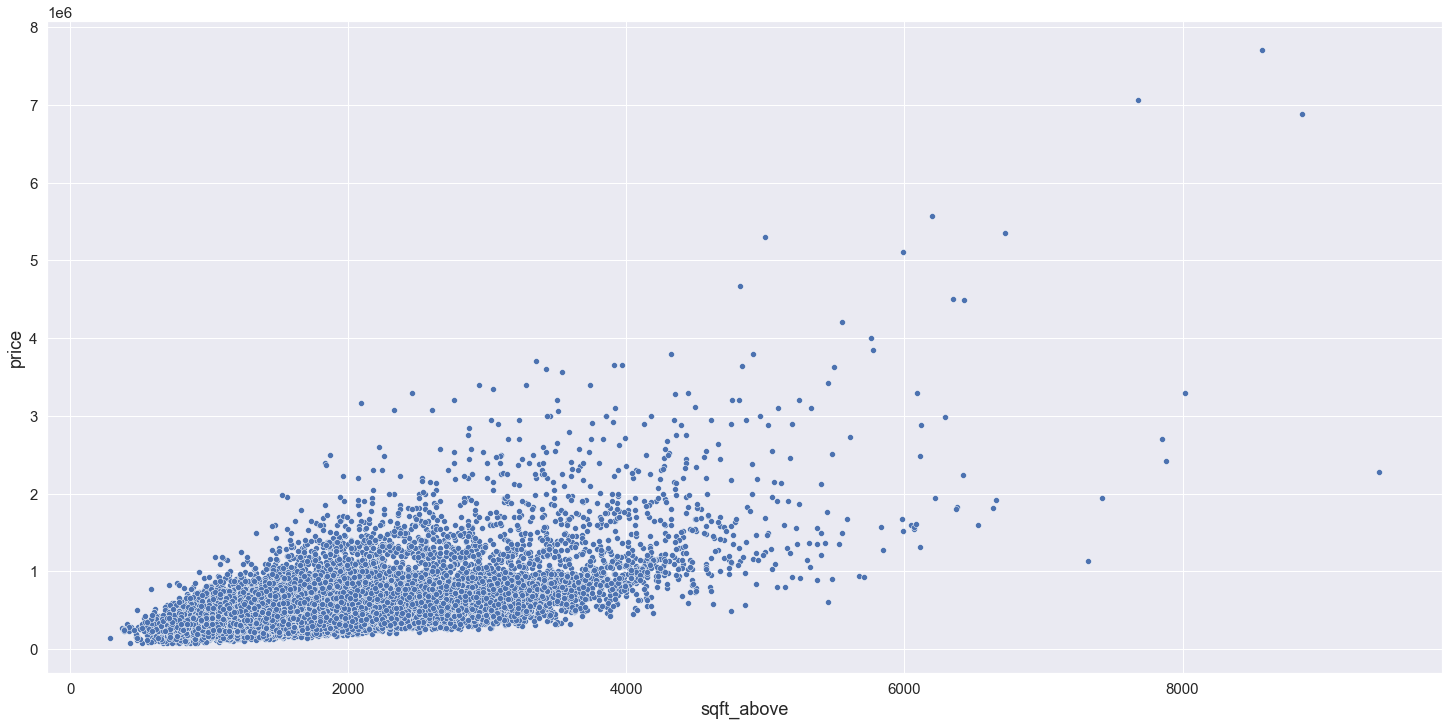

In [98]:
sns.scatterplot(data = df4, x = 'sqft_above', y = 'price');

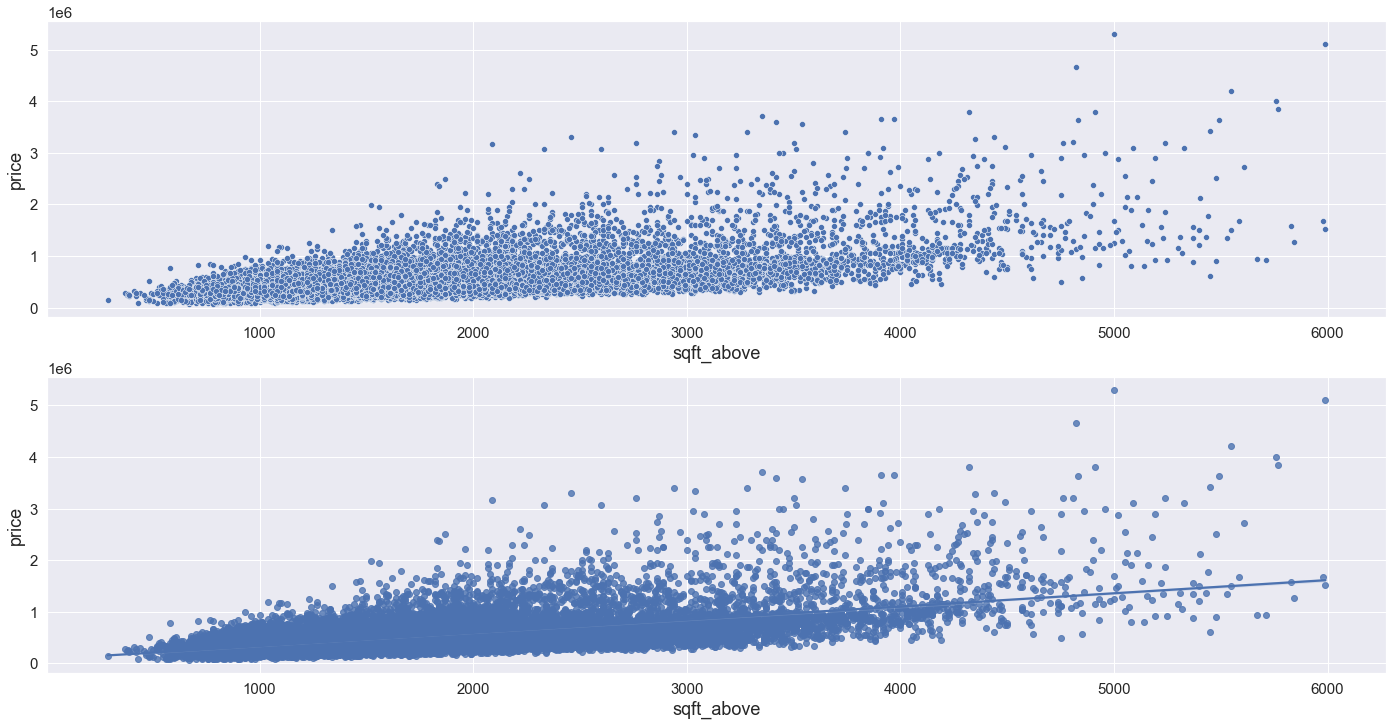

In [99]:
aux1=pd.DataFrame()
aux1 = df4.loc[ df4['sqft_above'] < 6000]

fig = plt.figure( figsize = (24,12) )
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax2 = fig.add_subplot( specs[ 1,0] )

sns.scatterplot(data = aux1, x = 'sqft_above', y = 'price', ax = ax1);

sns.regplot( x = 'sqft_above', y = 'price', data = aux1, ax = ax2 );

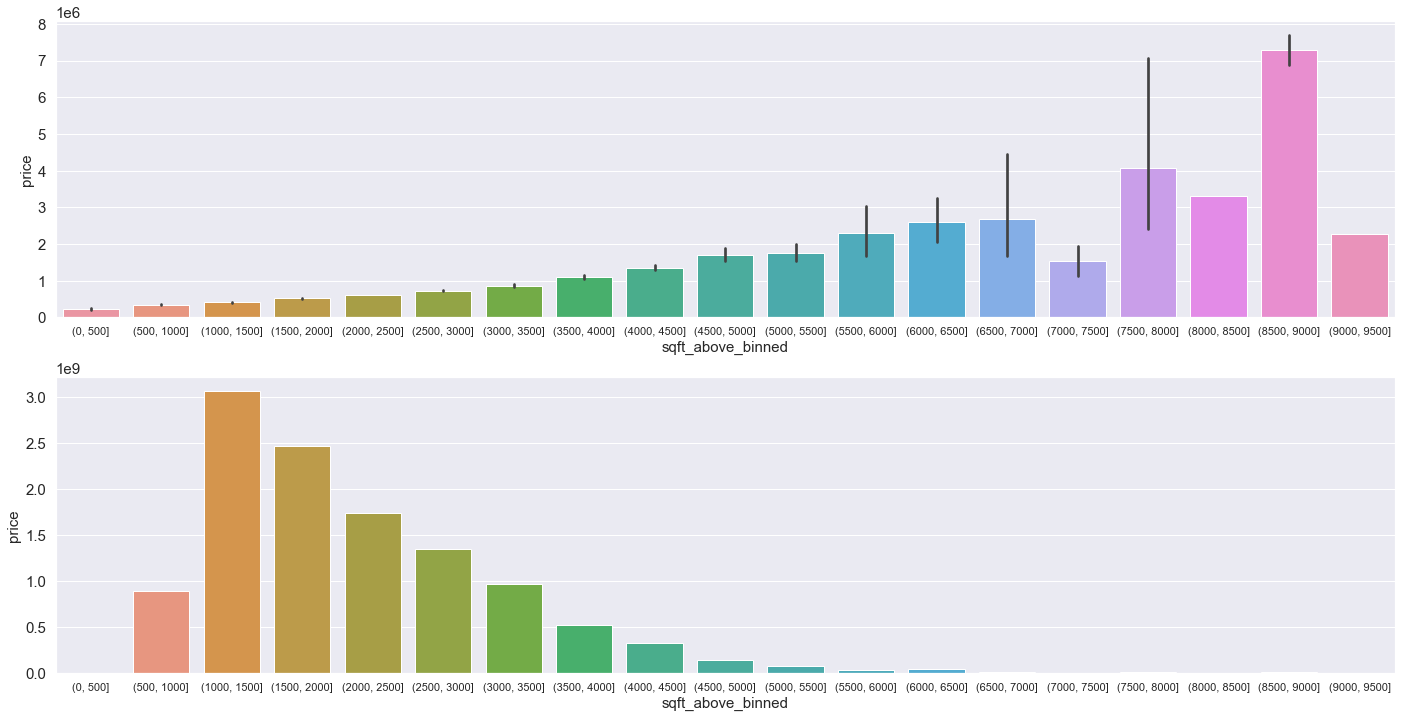

In [100]:
aux1 = df4.copy()
bins = np.arange(0, 10000, 500 )
aux1['sqft_above_binned'] = pd.cut( df4['sqft_above'], bins = bins)

fig = plt.figure( figsize = (24,12) )
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=15) 
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax2 = fig.add_subplot( specs[ 1,0] )

#geral
sns.barplot( x = 'sqft_above_binned', y = 'price', data = aux1, ax = ax1);

#sum
aux3 = aux1[ ['sqft_above_binned', 'price' ]].groupby('sqft_above_binned').sum().reset_index()
sns.barplot( x = 'sqft_above_binned', y = 'price', data = aux3, ax = ax2);

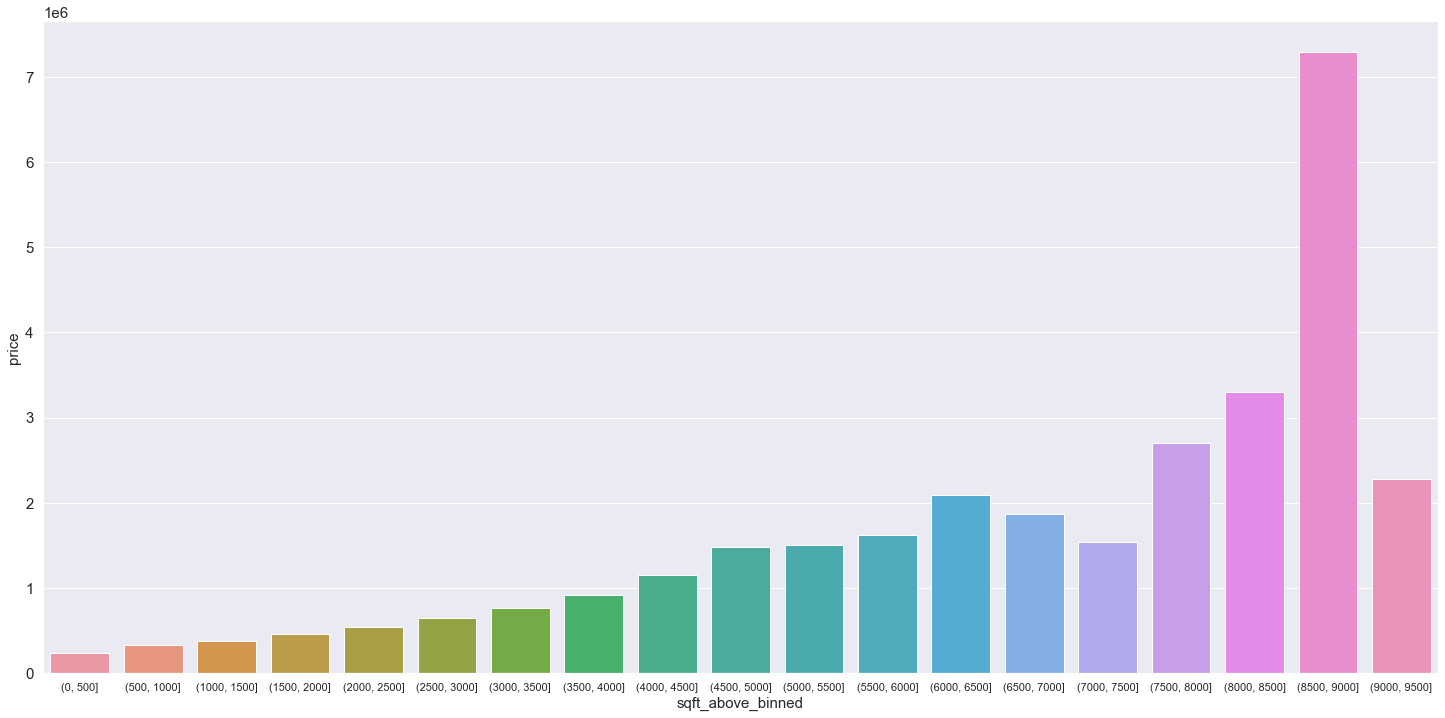

In [101]:
#mediana
aux3 = aux1[ ['sqft_above_binned', 'price' ]].groupby('sqft_above_binned').median().reset_index()
sns.barplot( x = 'sqft_above_binned', y = 'price', data = aux3);


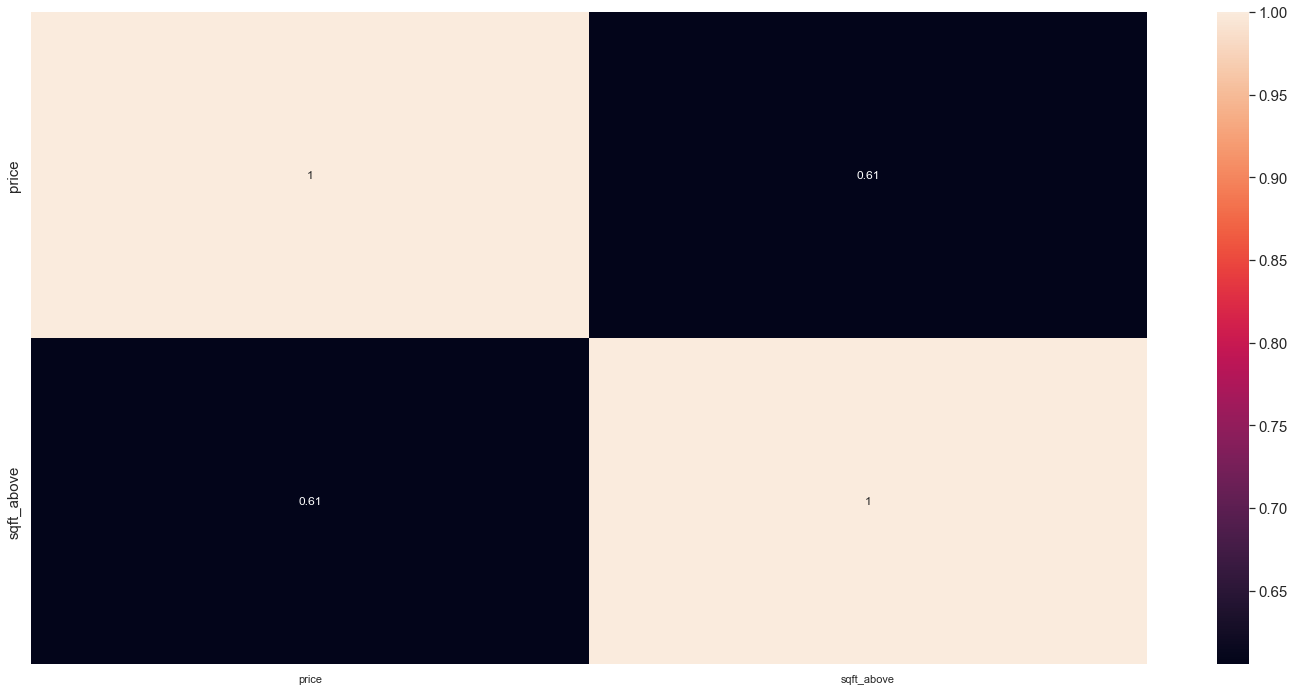

In [102]:
# correlacao com price
aux1 = df4[['price','sqft_above']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.4 Hipótese 4: Imóveis com mais pavimentos possuem preços maiores.
Hipótese verdadeira: Imóveis com mais pavimentos possuem maiores preços de venda.

In [103]:
# Tabela média - mediana
aux1 = df4[['floors','price']].groupby('floors').mean().reset_index()
aux2 = df4[['floors','price']].groupby('floors').median().reset_index()
aux3 = pd.merge(aux1, aux2, how = 'inner', on = 'floors', suffixes=( '_media','_mediana'))
aux3

floors  price_media  price_mediana
0    1.00    442162.11      390000.00
1    1.50    558980.64      524475.00
2    2.00    648891.16      542950.00
3    2.50   1060346.49      799200.00
4    3.00    582526.04      490000.00
5    3.50    933312.50      534500.00

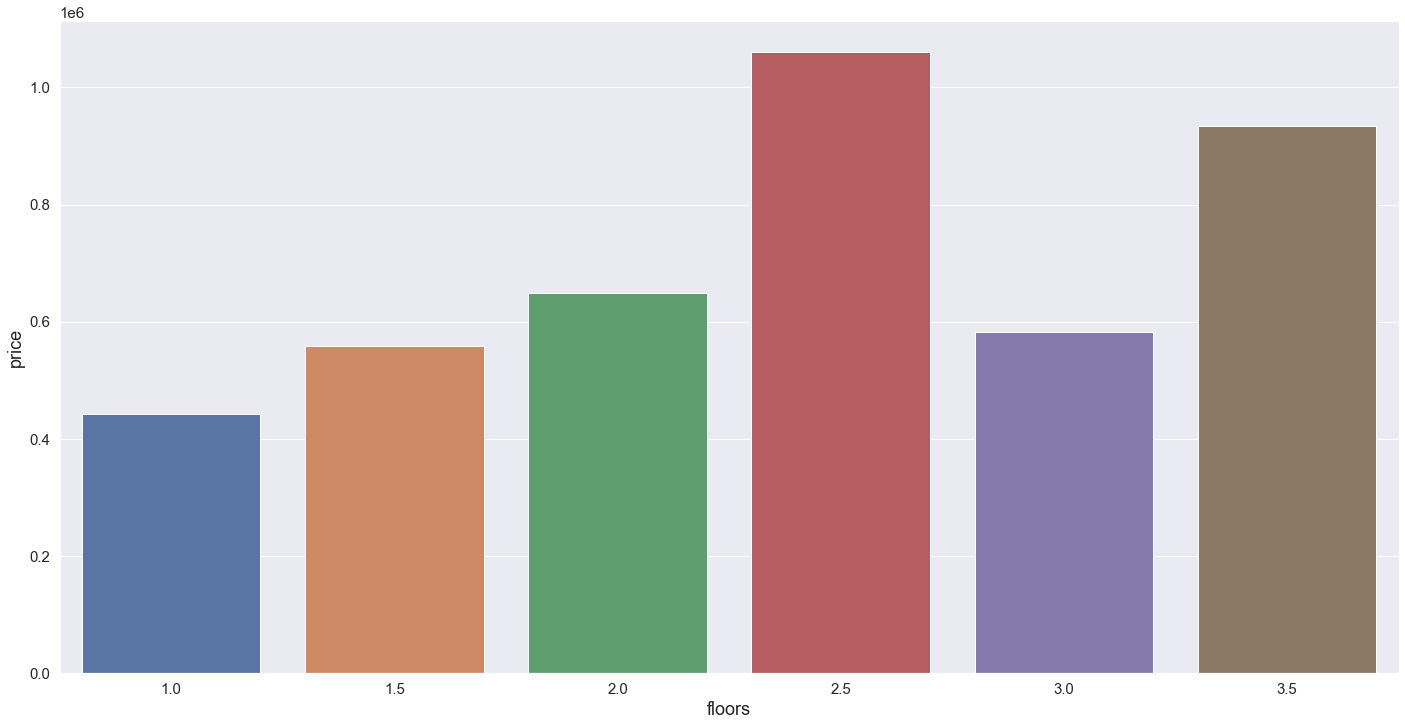

In [104]:
#media
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
fig = plt.figure( figsize = (24,12) )
sns.barplot(data = aux1, x = 'floors', y = 'price');

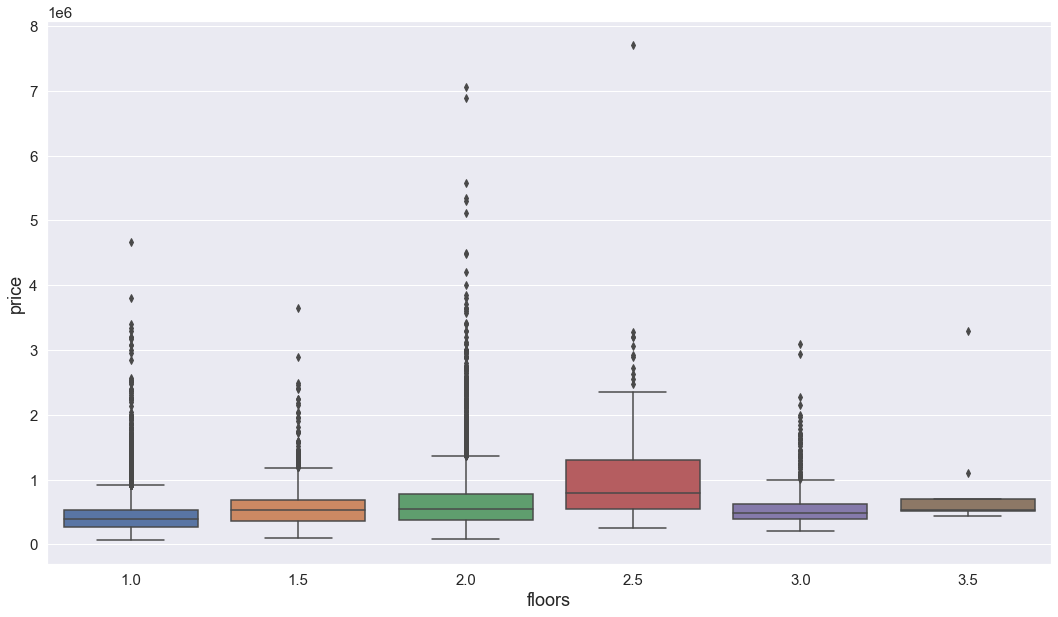

In [105]:
fig = plt.figure( figsize = (18,10) )
sns.boxplot(data = df4, x = 'floors',y='price');


Total imóveis com 3.5 andares =  8


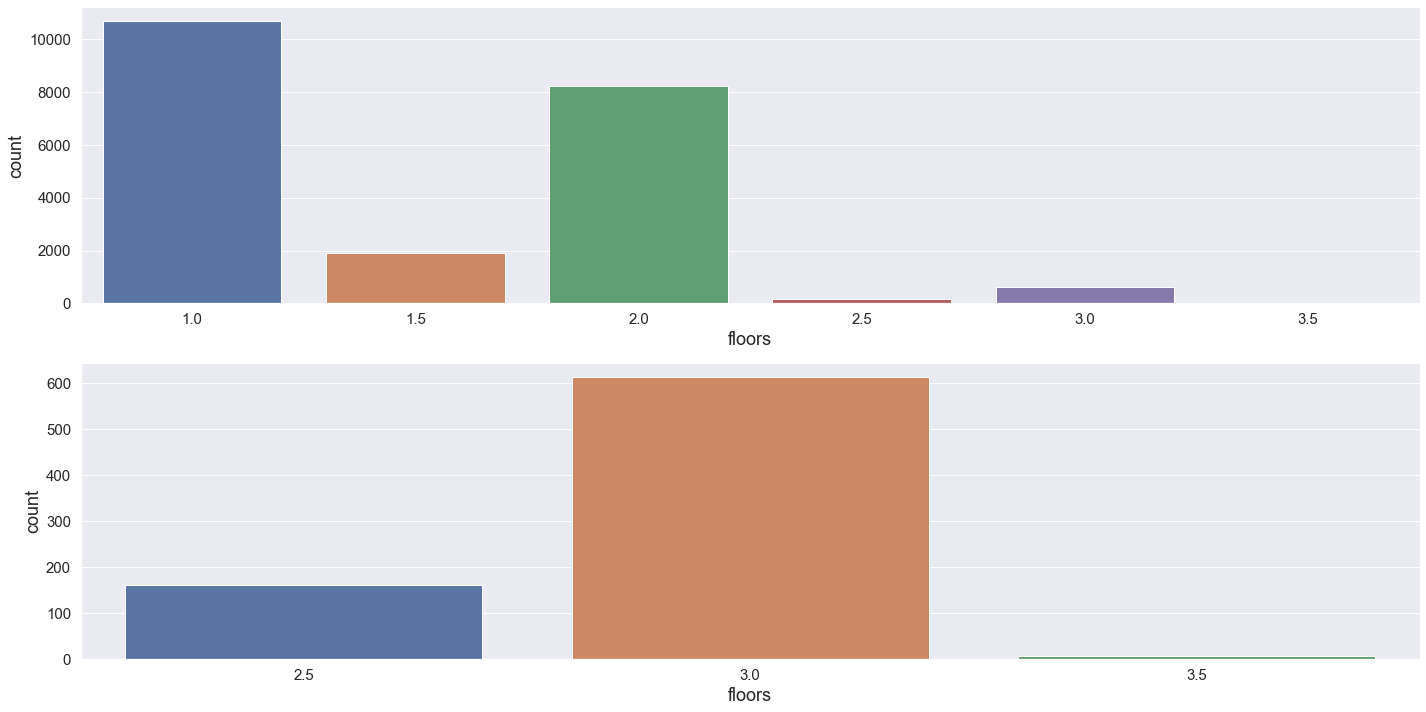

In [106]:
fig = plt.figure( figsize = (24,12) )
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax2 = fig.add_subplot( specs[ 1,0] )

#total
sns.countplot( data = df4, x = 'floors', ax = ax1);

#Maiores que 2.5 andares
aux1 = pd.DataFrame()
aux1 = df4.loc[ df4['floors'] >= 2.5 ]
sns.countplot( data = aux1, x = 'floors', ax = ax2);

print('\nTotal imóveis com 3.5 andares =  {}'.format( df4.loc[df4['floors']== 3.5 ].shape[0]))


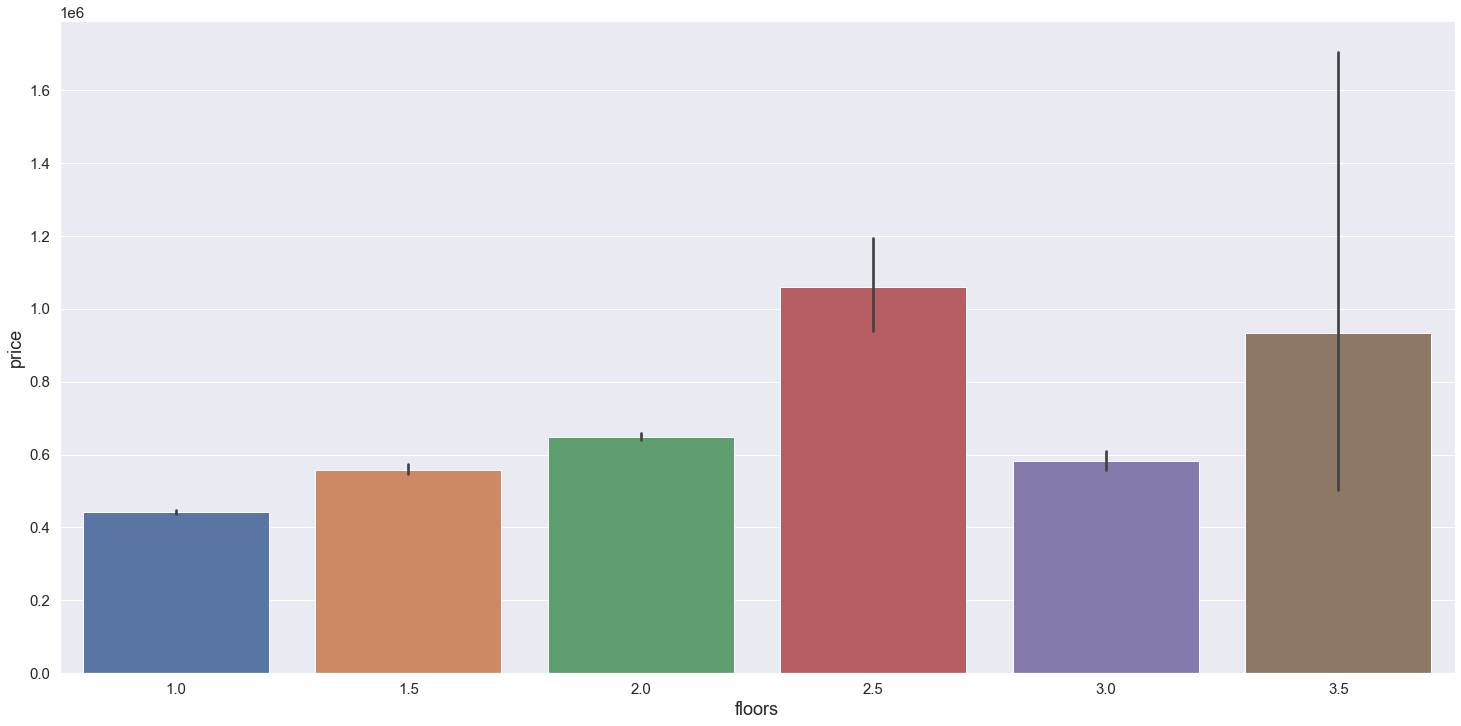

In [107]:
sns.barplot( data = df4, x = 'floors', y = 'price');

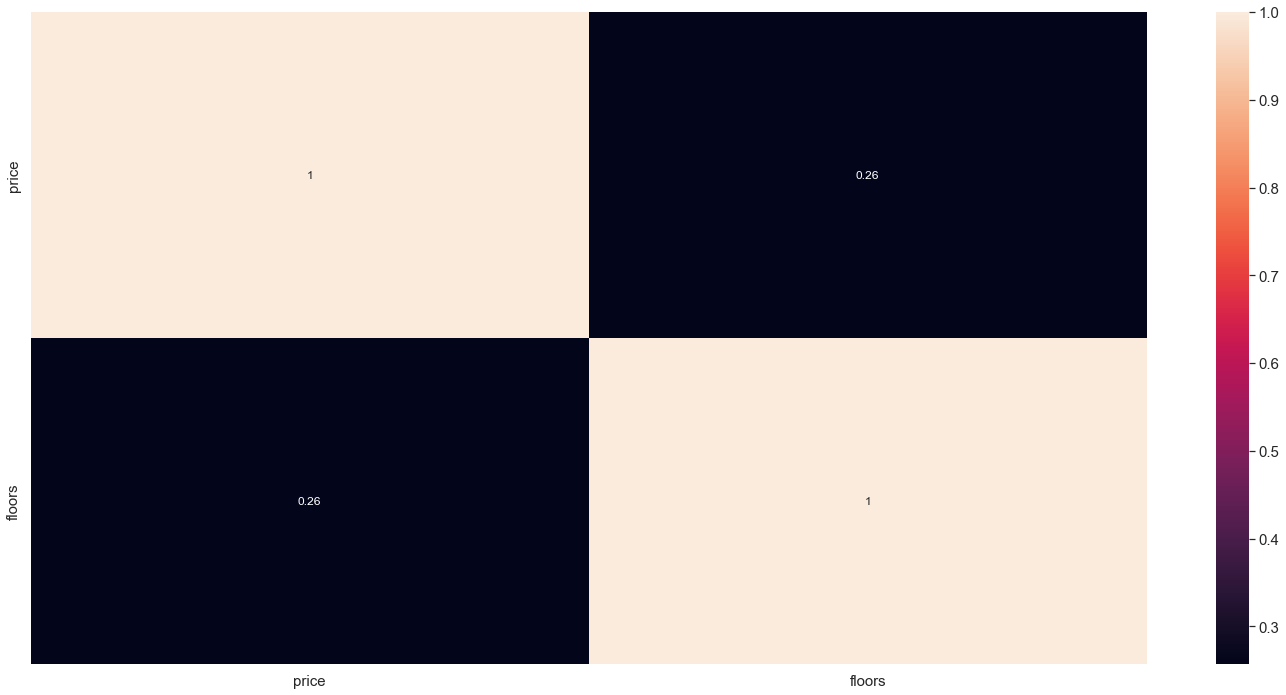

In [108]:
# correlacao com price
aux1 = df4[['price','floors']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.5 Hipótese 5: Imóveis com porão possuem preços maiores
Hipótese verdadeira: Imóveis com porão possuem maiores preços de venda

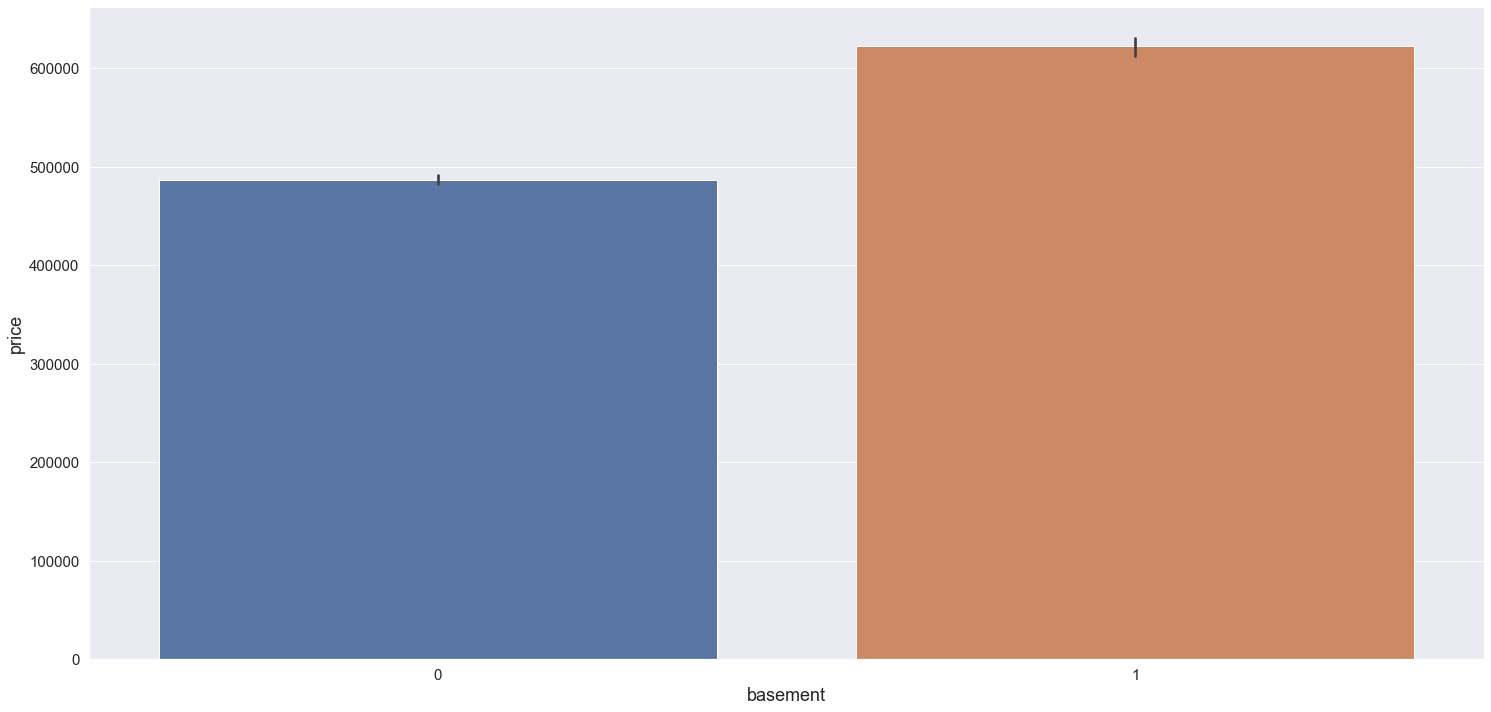

In [109]:
sns.barplot( data = df4, x = 'basement', y = 'price' );

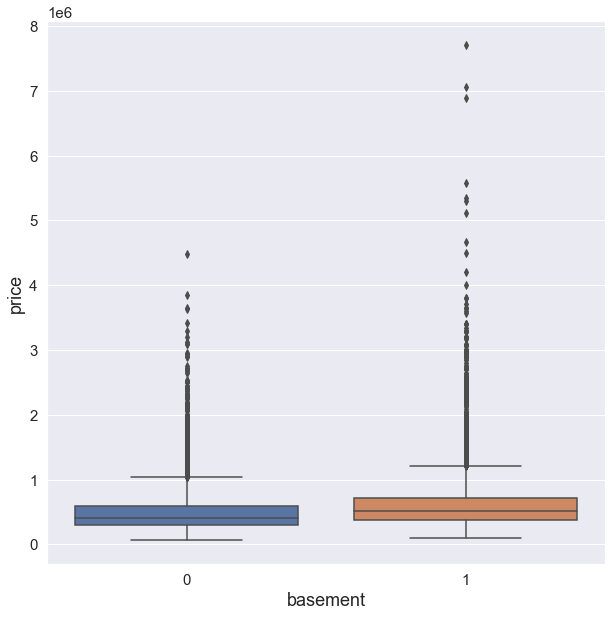

In [110]:
fig = plt.figure( figsize = (10,10) )
sns.boxplot( data = df4, x = 'basement', y = 'price');

### 4.2.6 Hipótese 6: Imóveis com porões maiores possuem maiores preços
Hipótese verdadeira: Imóveis com porões maiores possuem maiores preços de venda.

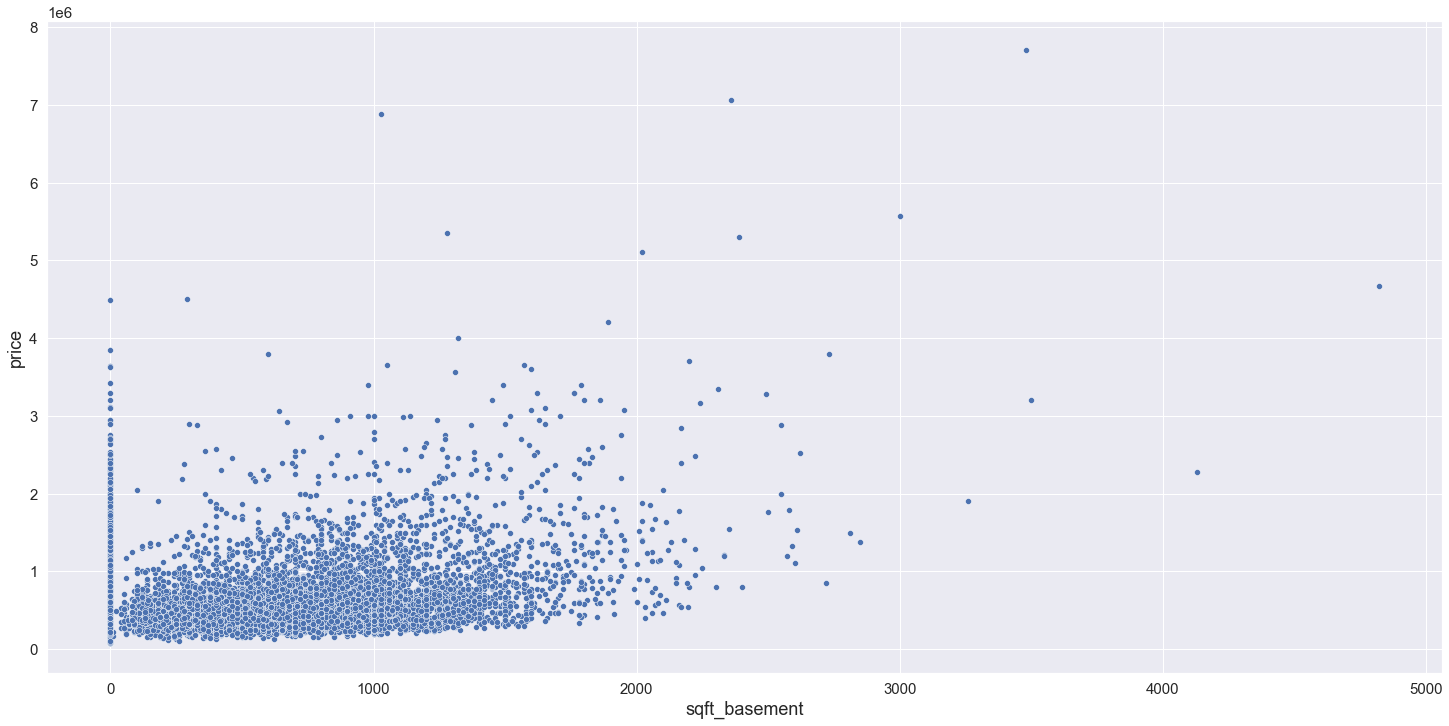

In [111]:
sns.scatterplot(data = df4, x = 'sqft_basement', y = 'price');

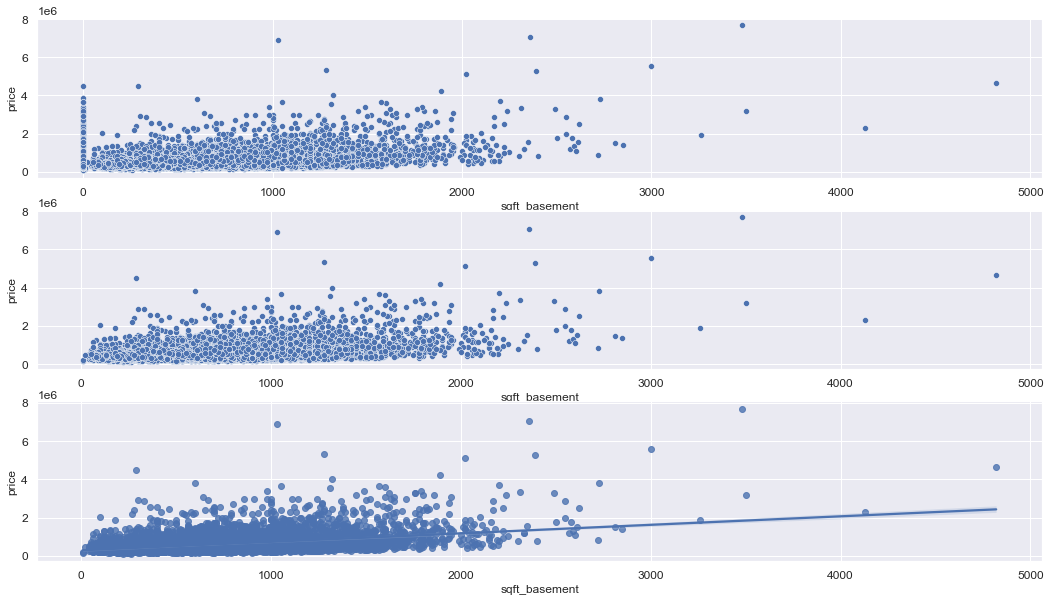

In [112]:
aux1 = pd.DataFrame()
aux1 = df4.loc[ ( df4['sqft_basement'] > 0 ) ]

fig = plt.figure( figsize = ( 18,10) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=12) 
specs = gridspec.GridSpec( nrows = 3, ncols = 1, figure = fig )

ax1 = fig.add_subplot( specs[ 0, 0 ])
ax2 = fig.add_subplot( specs[ 1, 0 ])
ax3 = fig.add_subplot( specs[ 2, 0 ])

sns.scatterplot(data = df4, x = 'sqft_basement', y = 'price', ax = ax1);
sns.scatterplot(data = aux1, x = 'sqft_basement', y = 'price', ax = ax2);
sns.regplot(data = aux1, x = 'sqft_basement', y = 'price', ax = ax3);

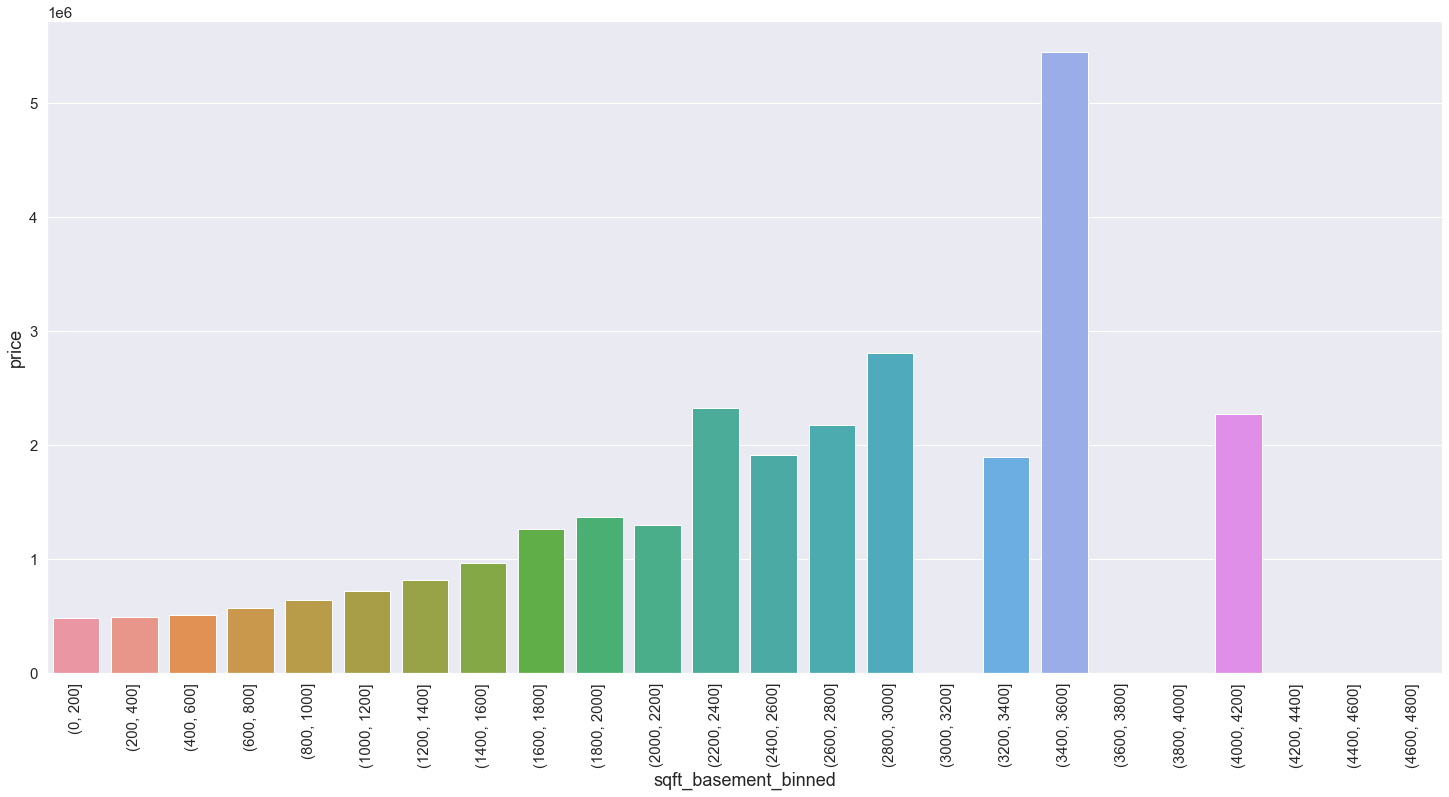

In [113]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18)
aux1 = df4.copy()
bins = np.arange( 0, 5000, 200 )
aux1['sqft_basement_binned'] = pd.cut( df4['sqft_basement'], bins = bins)

#barplot mean
aux3 = aux1[['sqft_basement_binned','price']].groupby('sqft_basement_binned').mean().reset_index()
sns.barplot( data = aux3, x = 'sqft_basement_binned', y = 'price' );
plt.xticks(rotation = 'vertical');

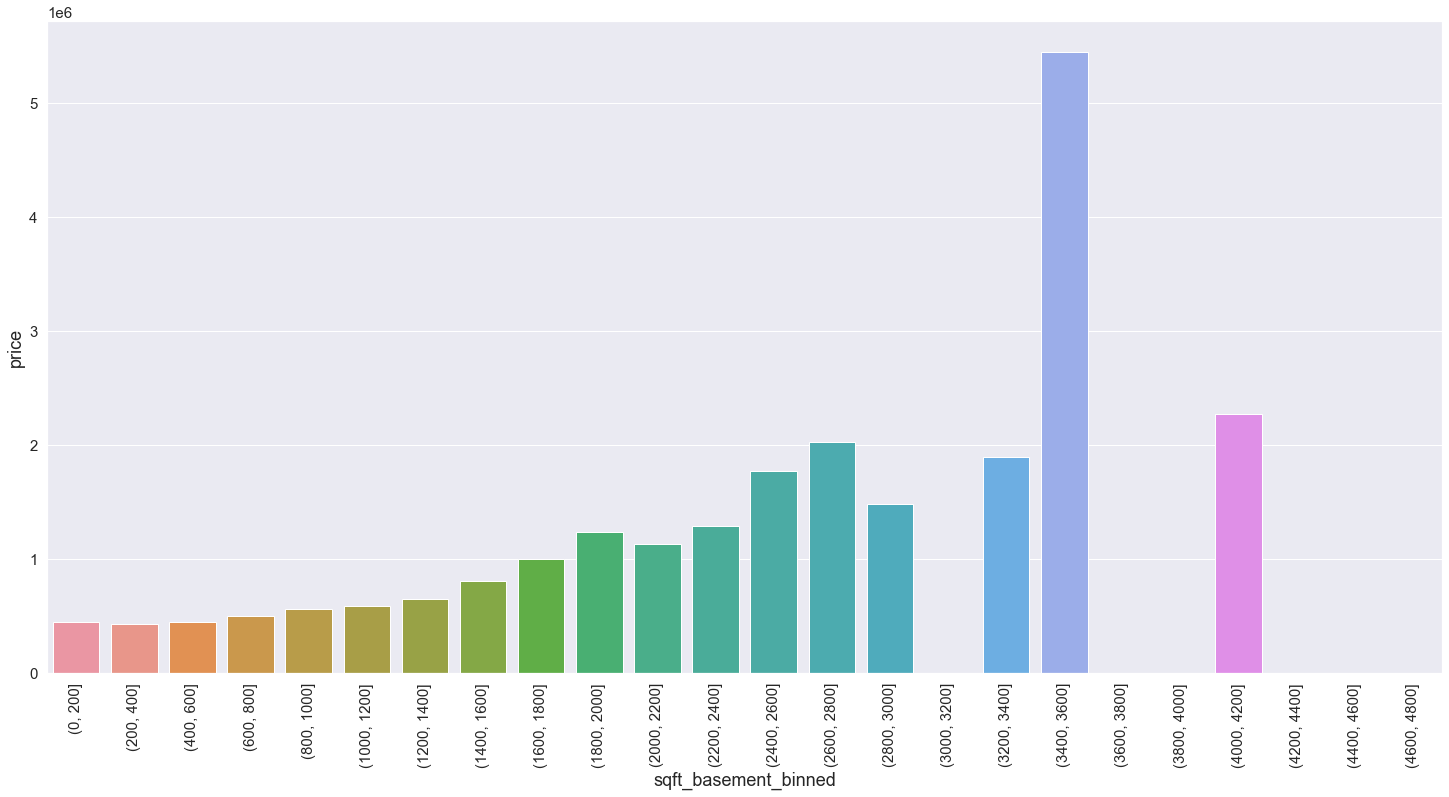

In [114]:
#barplot mediana
aux4 = aux1[['sqft_basement_binned','price']].groupby('sqft_basement_binned').median().reset_index()
sns.barplot( data = aux4, x = 'sqft_basement_binned', y = 'price' );
plt.xticks(rotation = 'vertical');

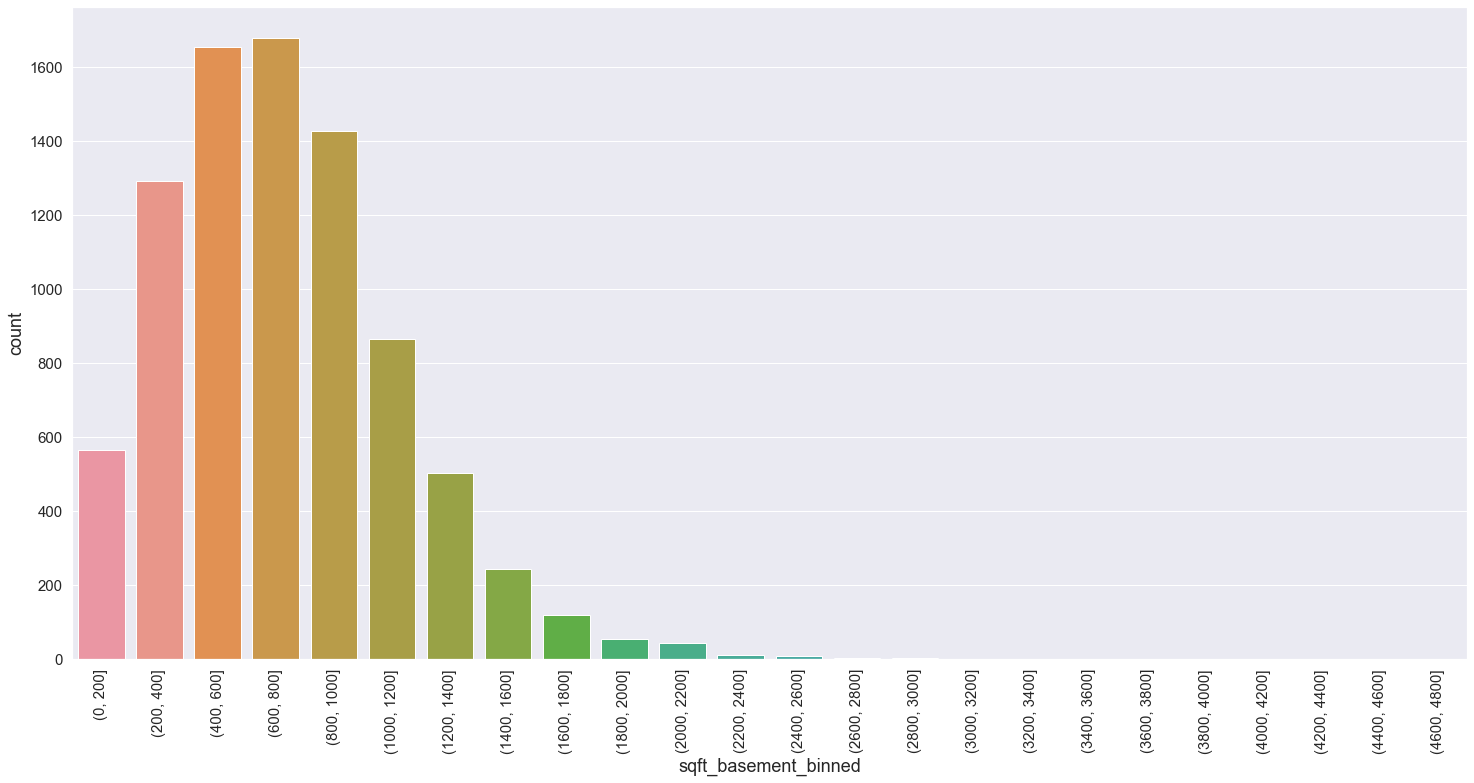

In [115]:
# volume total por bin
sns.countplot( data = aux1, x = 'sqft_basement_binned');
plt.xticks(rotation = 'vertical');

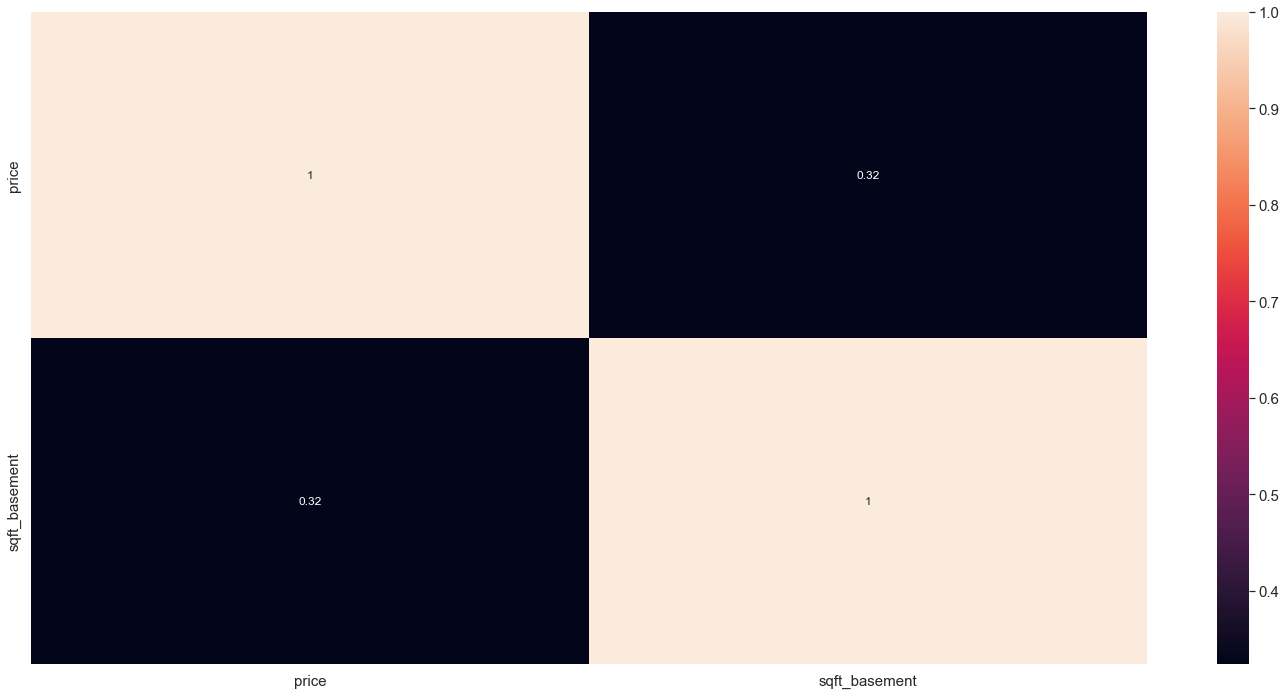

In [116]:
# correlacao com price
aux1 = df4[['price','sqft_basement']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.7 Hipótese 7: Imóveis com áreas construídas maiores que as dos imóveis vizinhos possuem preços maiores
Hipótese verdadeira: Imóveis com áreas construídas maiores que as dos imóveis vizinhos possuem preços maiores.

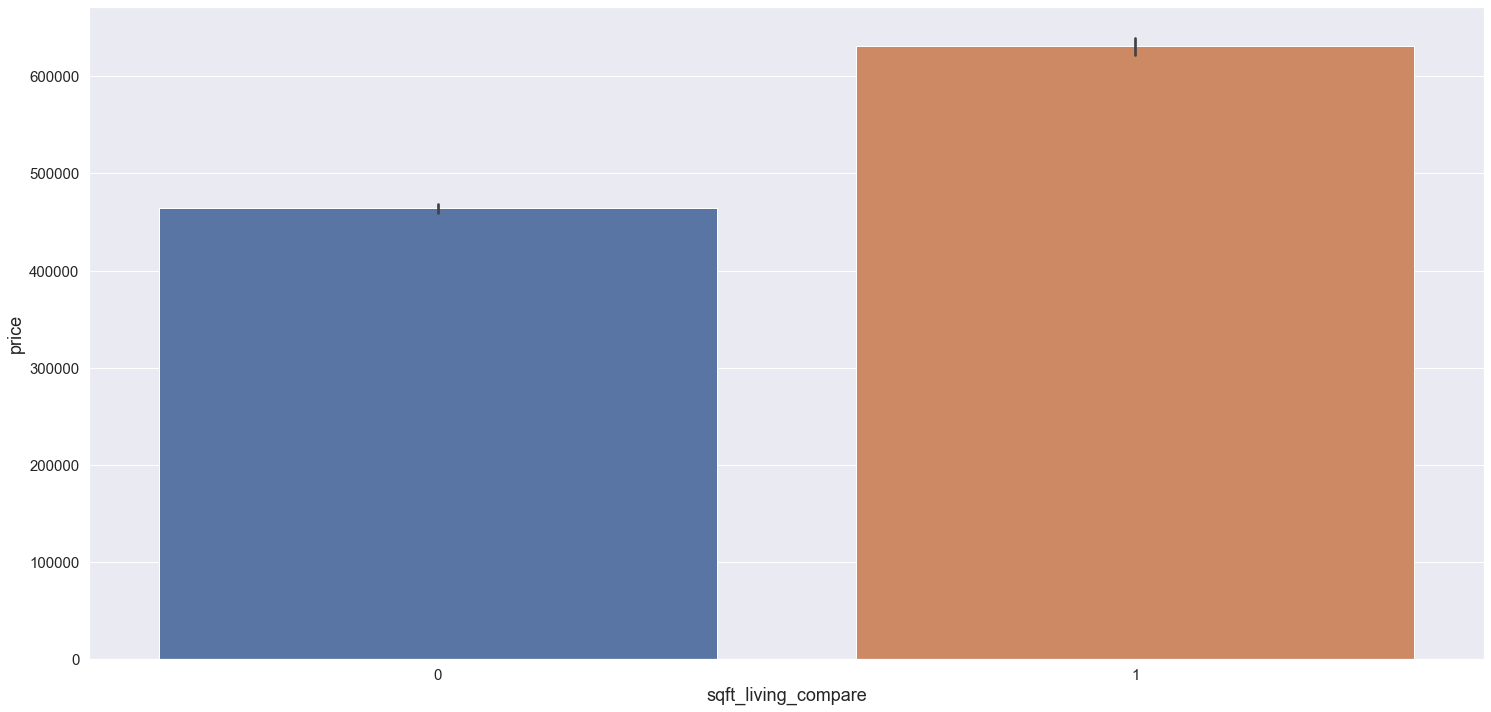

In [117]:
sns.barplot( data = df4, x = 'sqft_living_compare', y = 'price');

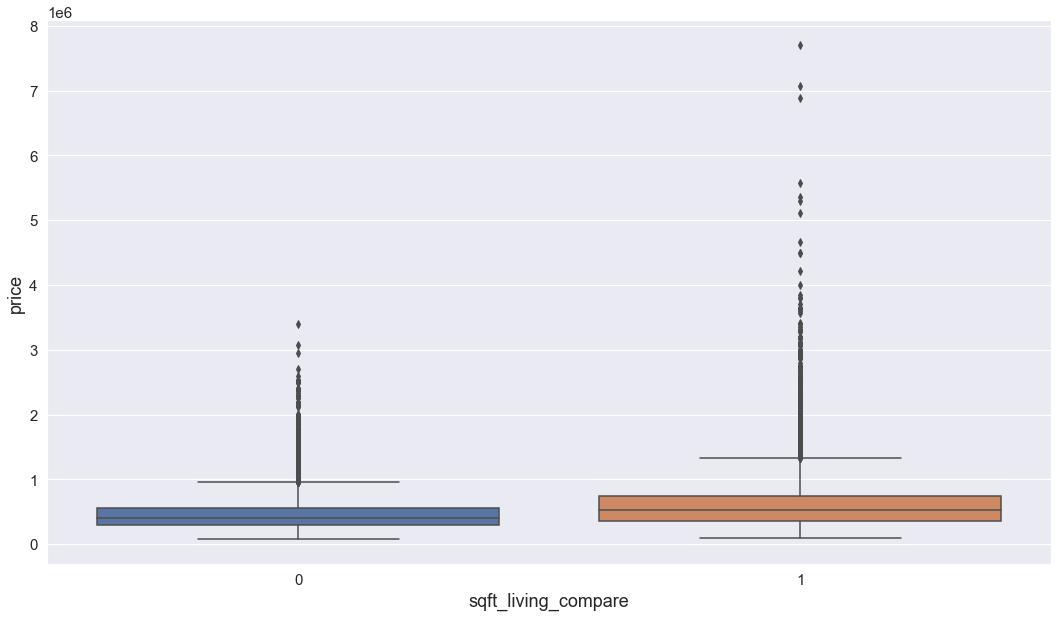

In [118]:
fig = plt.figure(figsize= (18,10))
sns.boxplot(data = df4, x = 'sqft_living_compare', y = 'price');

### 4.2.8 Hipótese 8: Imóveis com áreas de lote maiores que as dos imóveis vizinhos possuem maiores preços
Hipótese verdadeira: Imóveis com áreas de lote maiores que as dos imóveis vizinhos possuem maiores preços de venda.

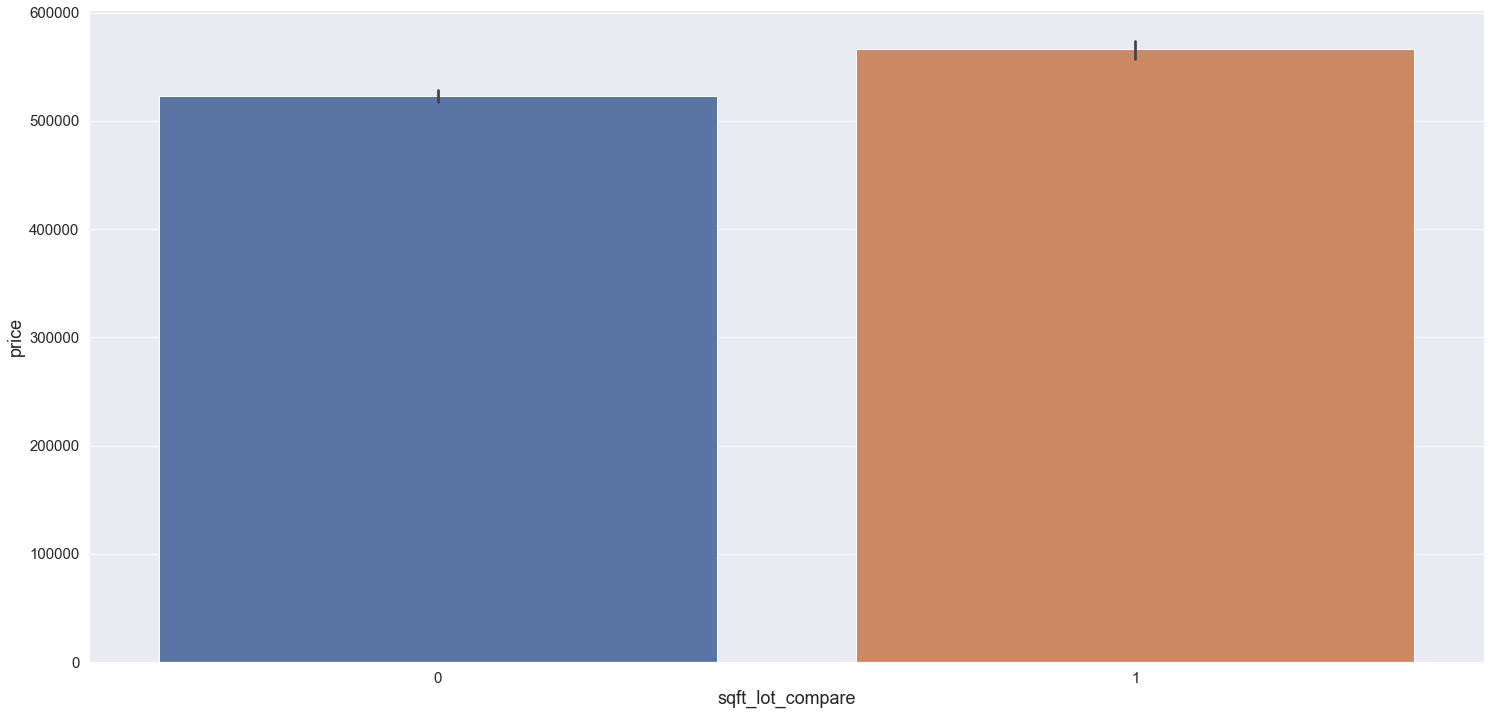

In [119]:
sns.barplot( data = df4, x = 'sqft_lot_compare', y = 'price');

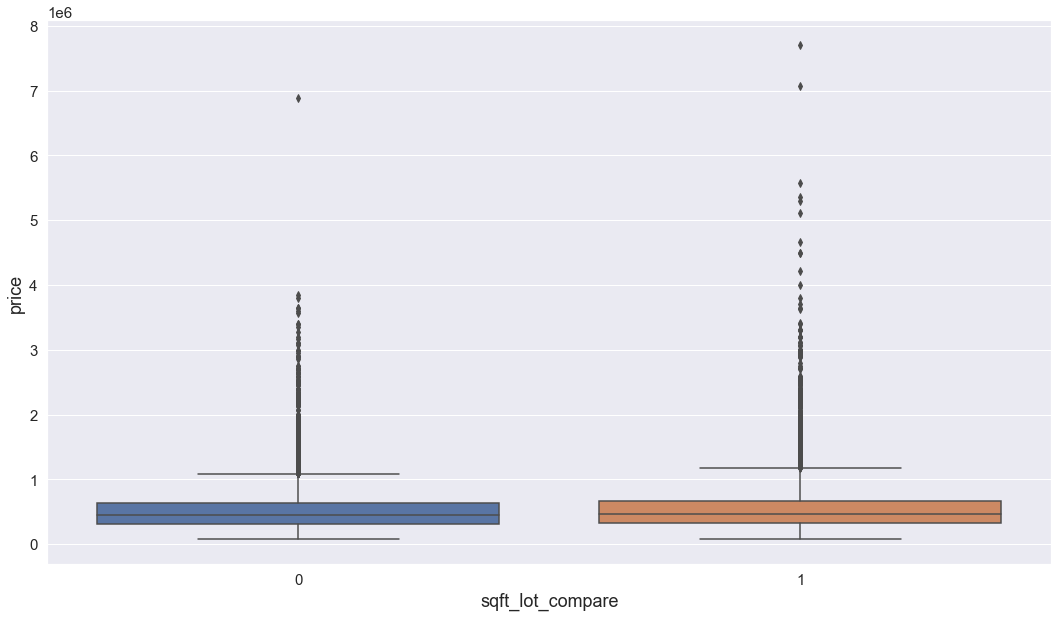

In [120]:
fig = plt.figure(figsize= (18,10))
sns.boxplot(data = df4, x = 'sqft_lot_compare', y = 'price');

### 4.2.9 Hipótese 9: Imóveis localizados de frente para a água possuem preços maiores.
Hipótese verdadeira: Imóveis localizados de frente para a água possuem maiores preços de venda.

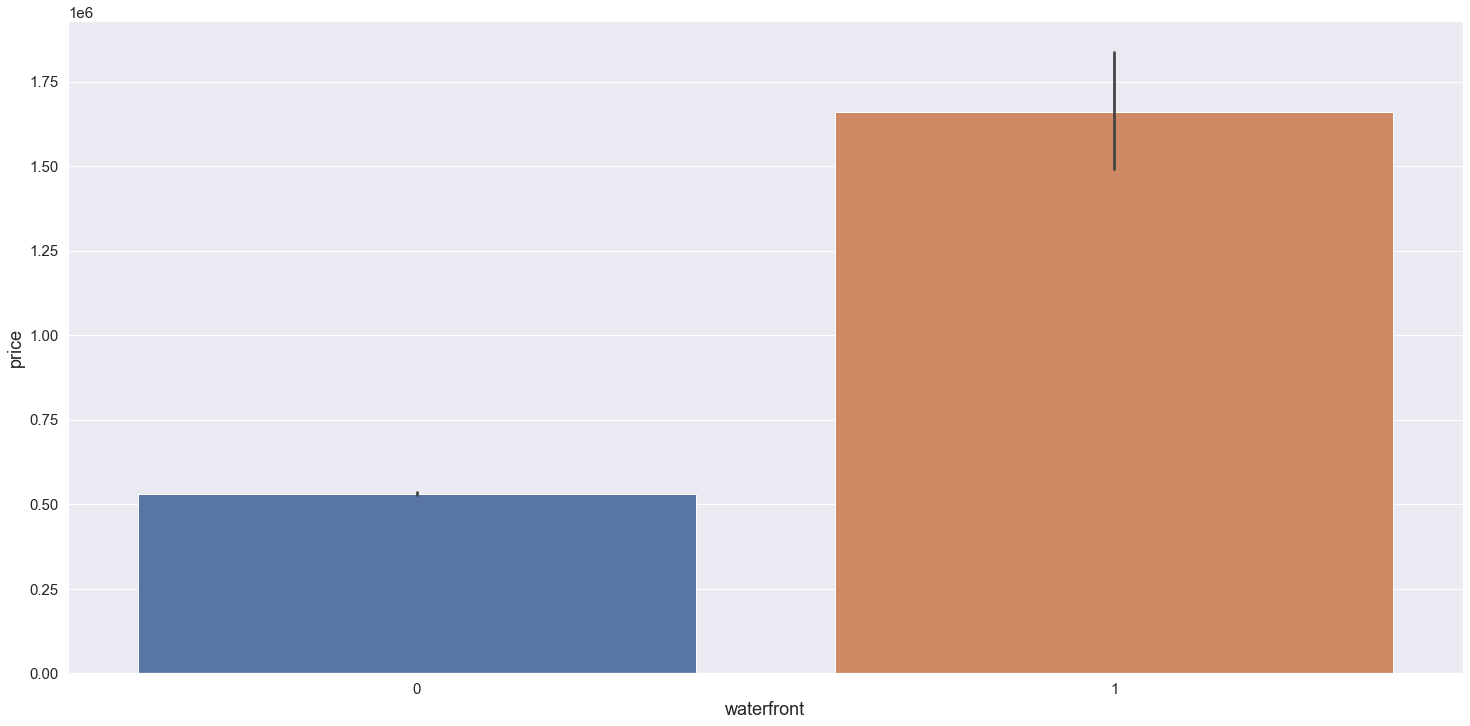

In [121]:
sns.barplot( data = df4, x = 'waterfront', y = 'price');

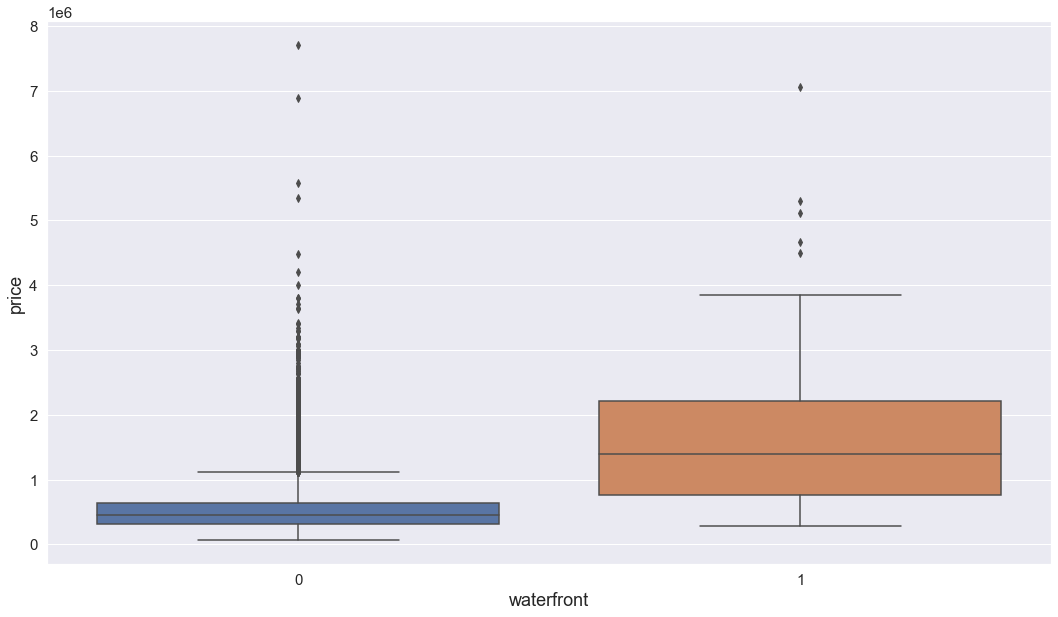

In [122]:
fig = plt.figure(figsize= (18,10))
sns.boxplot(data = df4, x = 'waterfront', y = 'price');

### 4.2.10 Hipótese 10: Imóveis localizados em avenidas possuem preços menores
Hipótese Falsa: Imóveis residenciais localizados em avenidas possuem mesmo preços de vendas

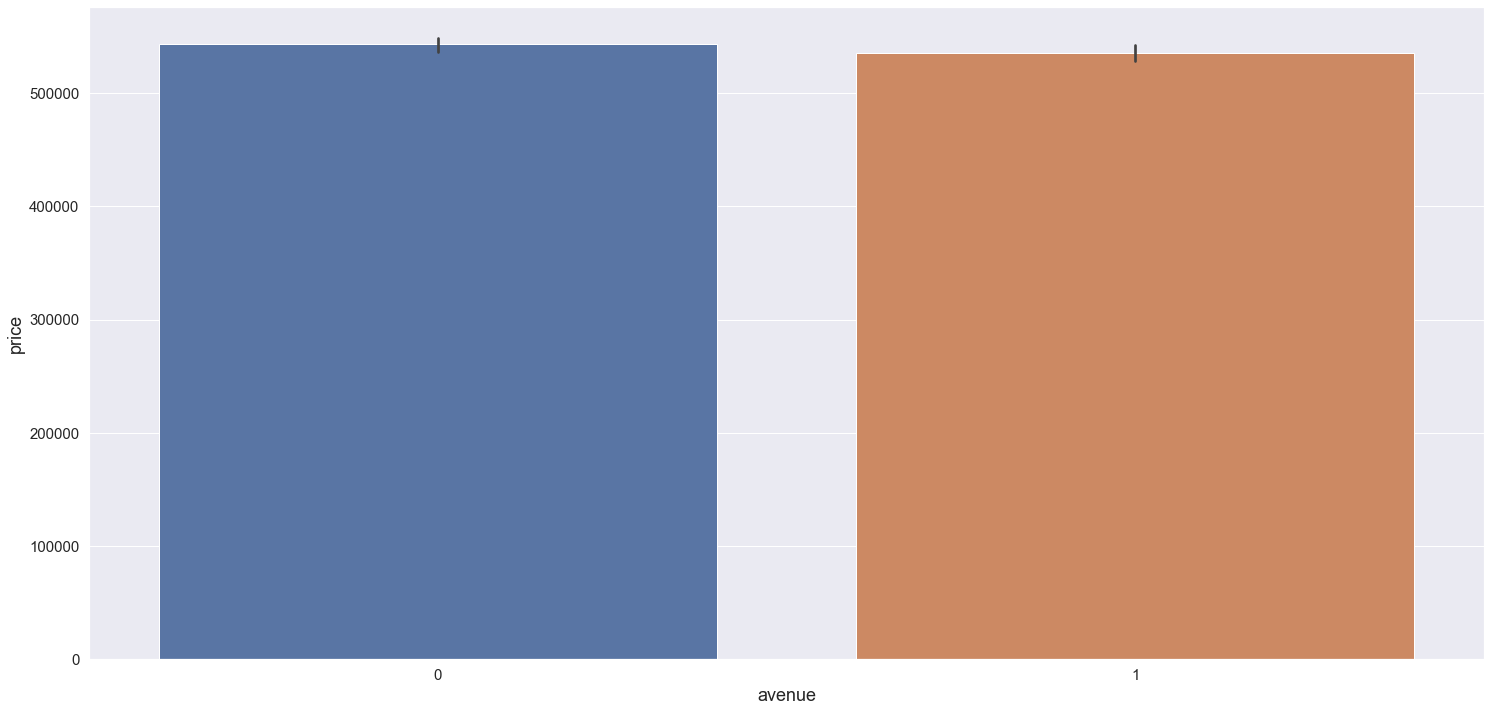

In [123]:
sns.barplot( data = df4, x = 'avenue', y = 'price');

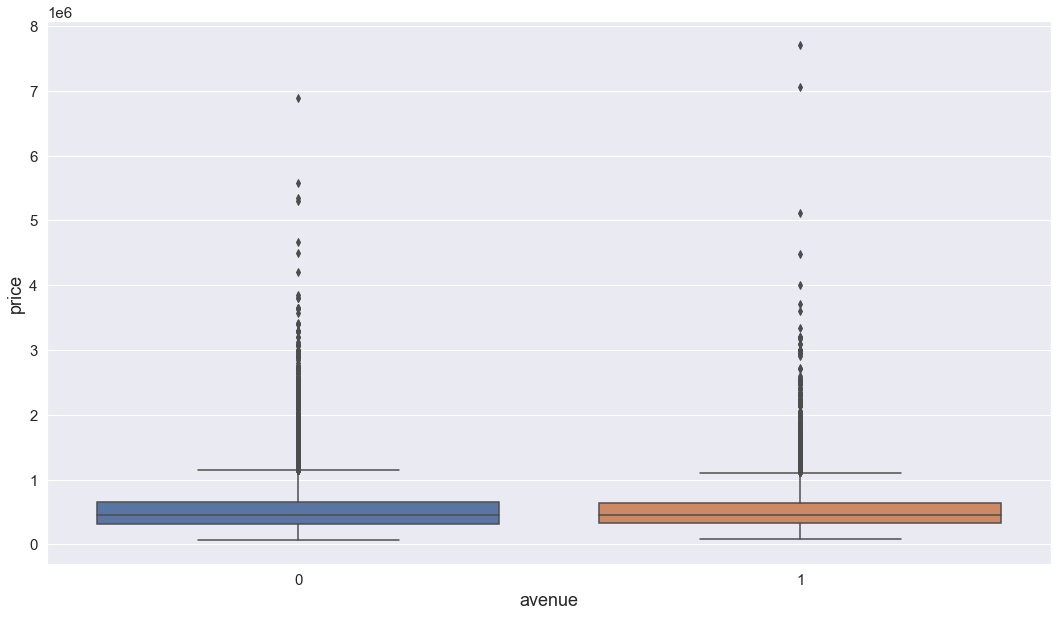

In [124]:
fig = plt.figure(figsize= (18,10))
sns.boxplot(data = df4, x = 'avenue', y = 'price');

### 4.2.11 Hipótese 11: Imóveis localizados em vizinhanças com áreas menores possuem preços maiores
Hipótese Falsa: Imóveis localizados em vizinhanças com áreas menores possuem preços menores.

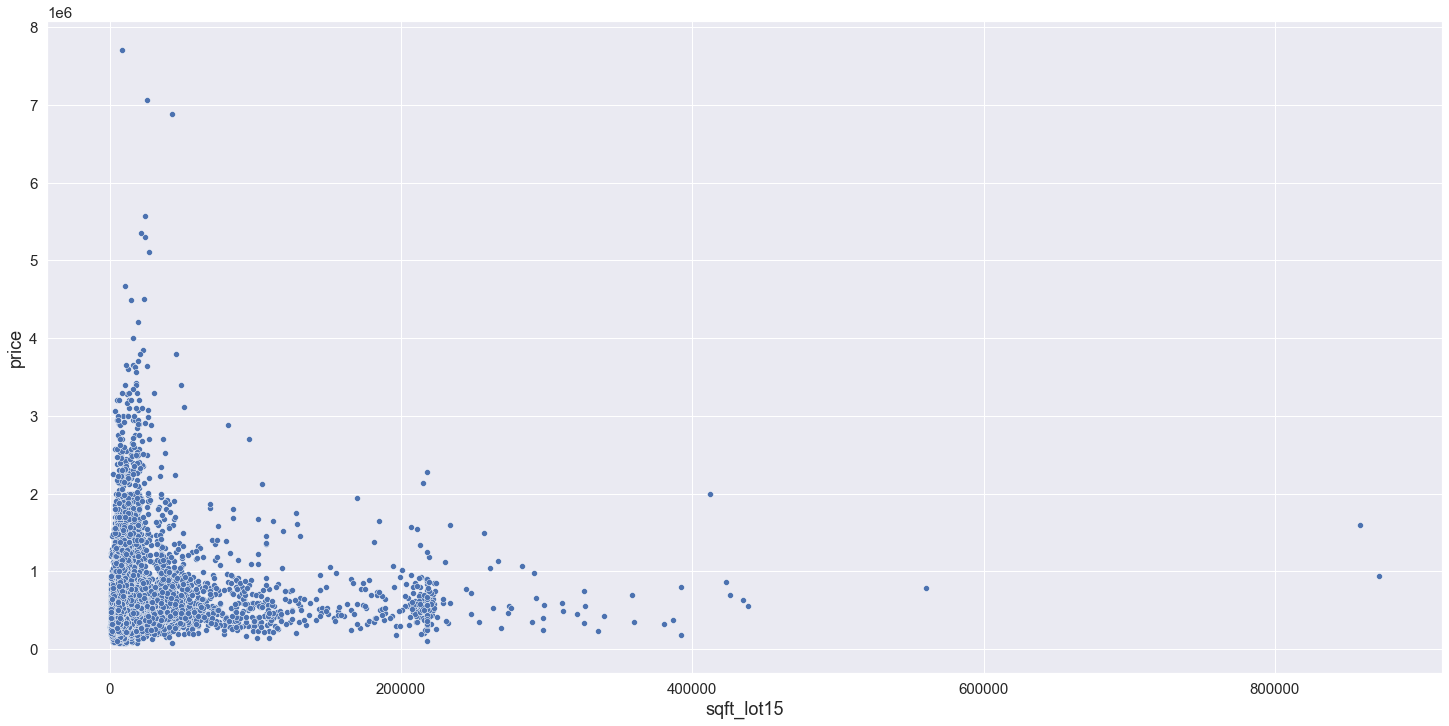

In [125]:
sns.scatterplot( data = df4, x = 'sqft_lot15',y = 'price');

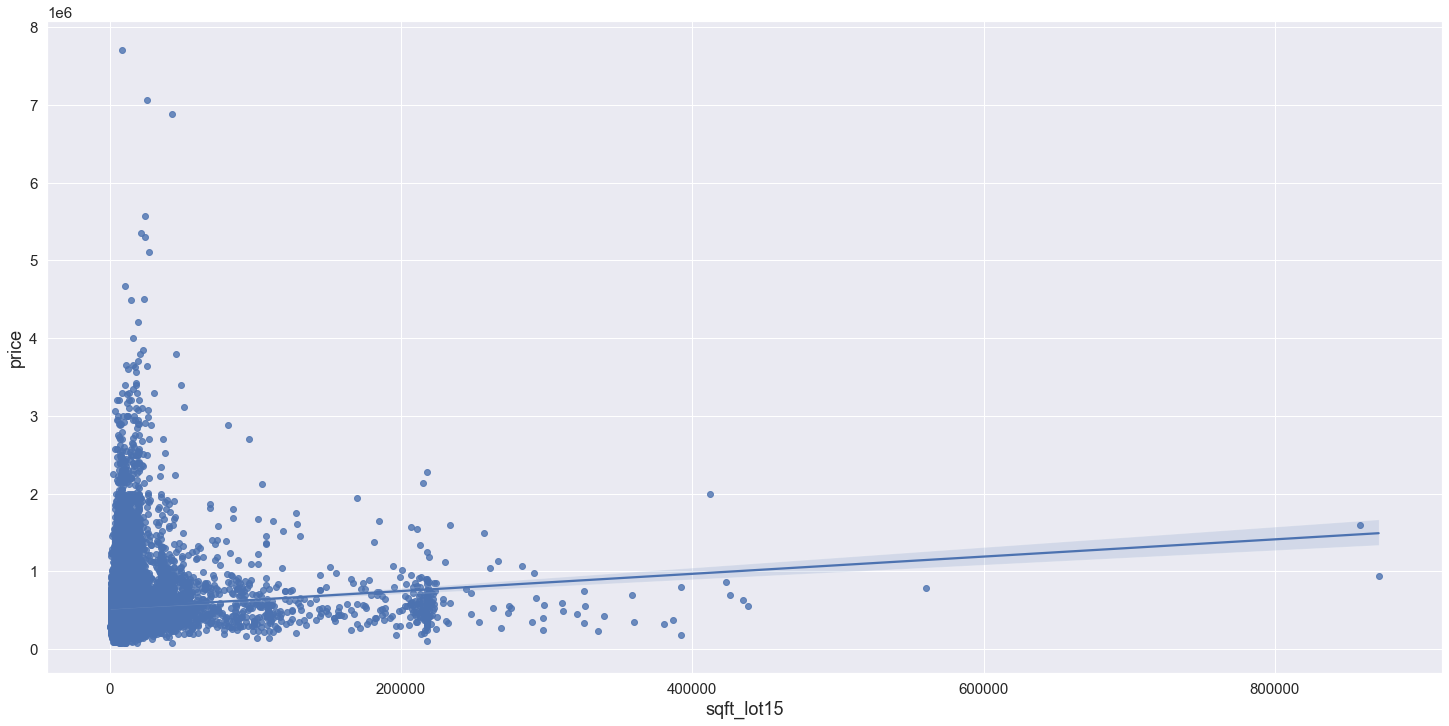

In [126]:
sns.regplot( data = df4, x = 'sqft_lot15',y = 'price');

In [127]:
df4['sqft_lot15'].describe()

count    21612.00
mean     12768.83
std      27304.76
min        651.00
25%       5100.00
50%       7620.00
75%      10083.25
max     871200.00
Name: sqft_lot15, dtype: float64

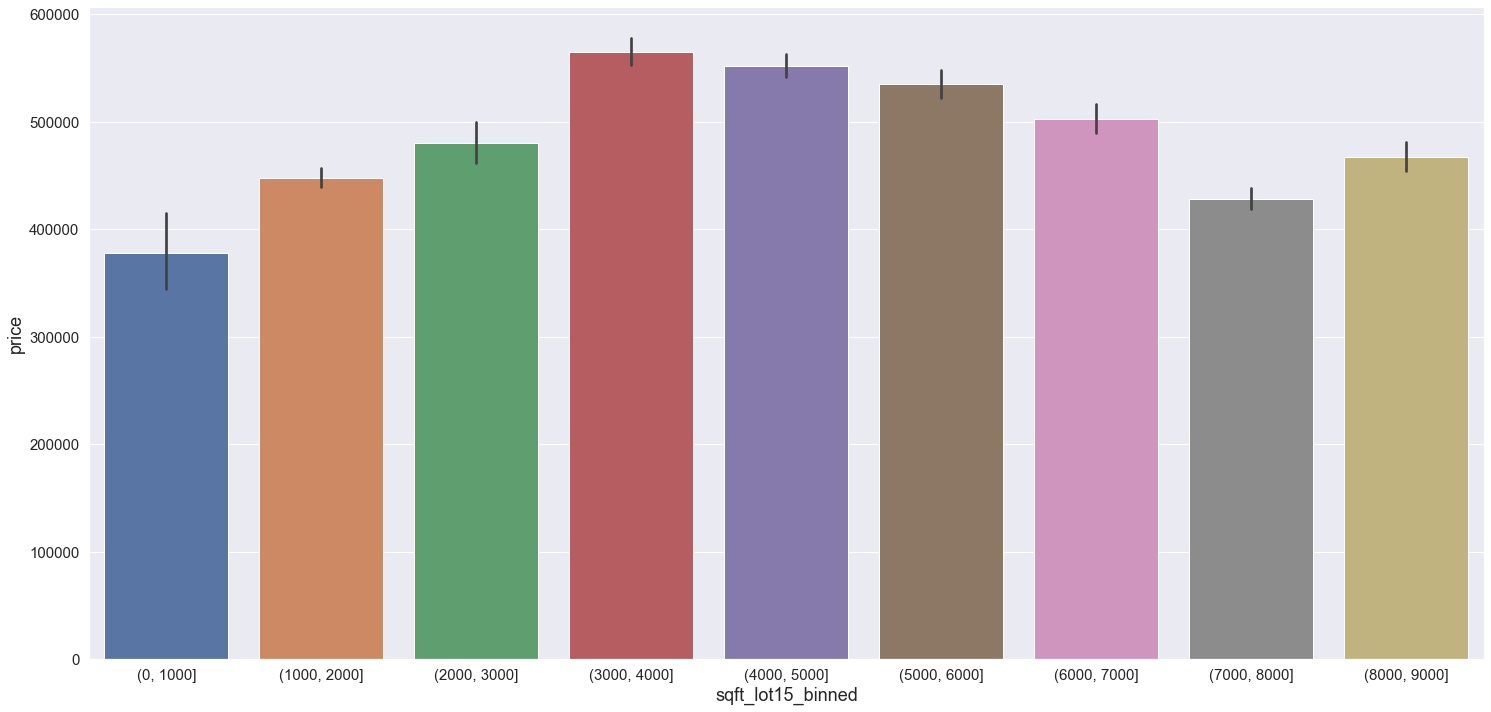

In [128]:
aux1 = df4.copy()
bins = np.arange( 0,10000,1000)
aux1['sqft_lot15_binned'] = pd.cut(df4['sqft_lot15'], bins = bins)
aux2 = aux1[['sqft_lot15_binned','price']].groupby('sqft_lot15_binned').mean().reset_index()
sns.barplot( data = aux1, x = 'sqft_lot15_binned', y = 'price');

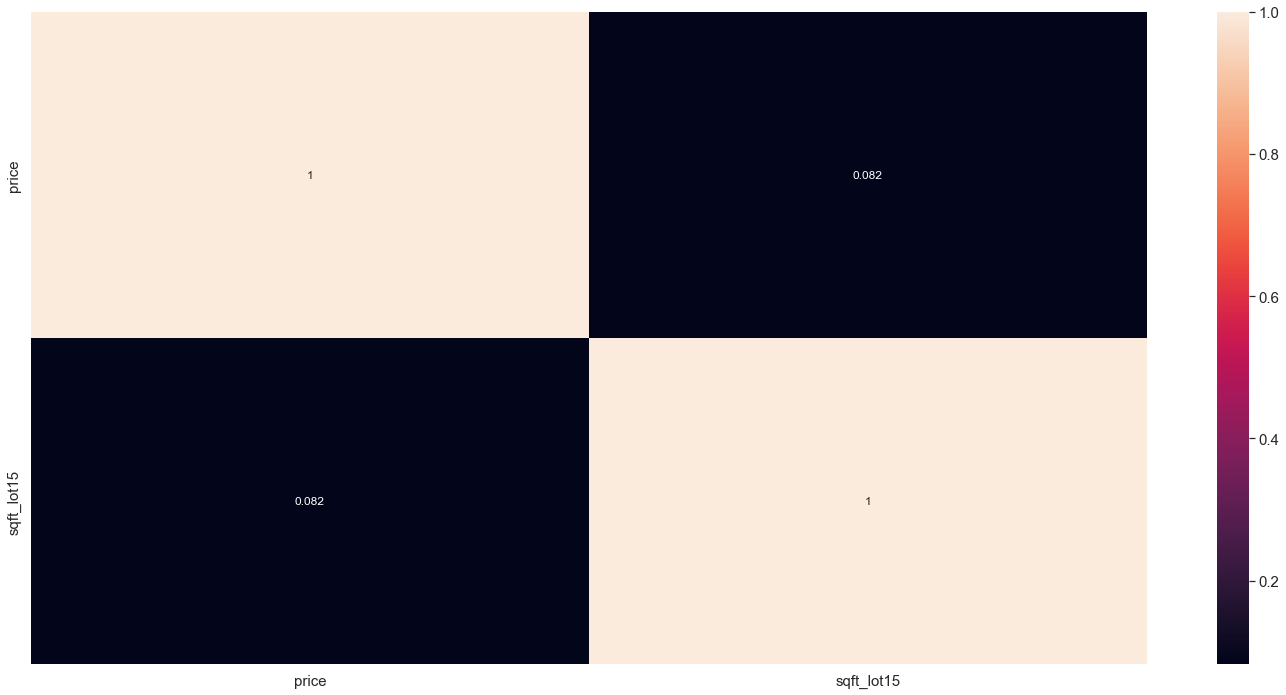

In [129]:
# correlacao com price
aux1 = df4[['price','sqft_lot15']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.12 Hipótese 12: Imóveis localizados em vizinhanças com áreas menores possuem maiores preços/sqft 2
Hipótese Falsa: Imóveis localizados em vizinhaças com área menores não possuem maiores preços/sqft2

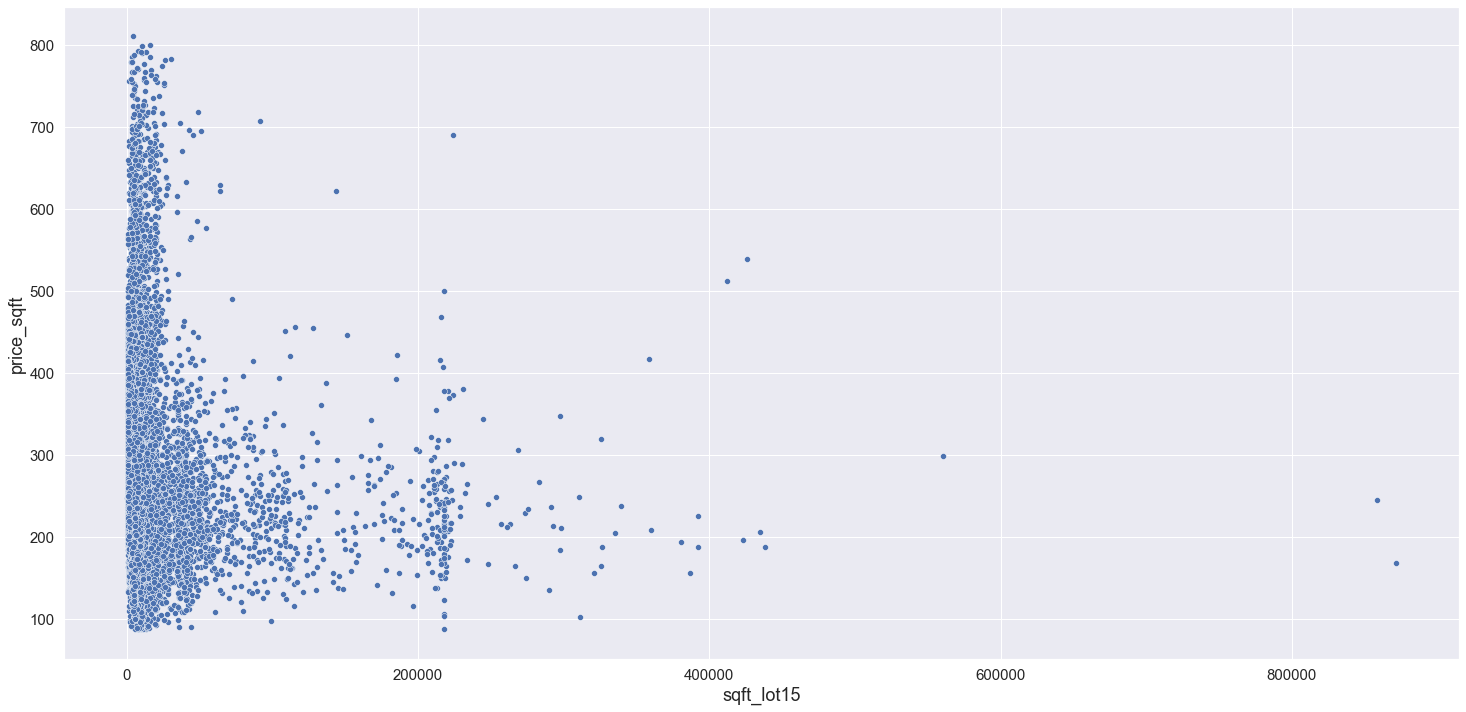

In [130]:
sns.scatterplot( data = df4, x = 'sqft_lot15',y = 'price_sqft');

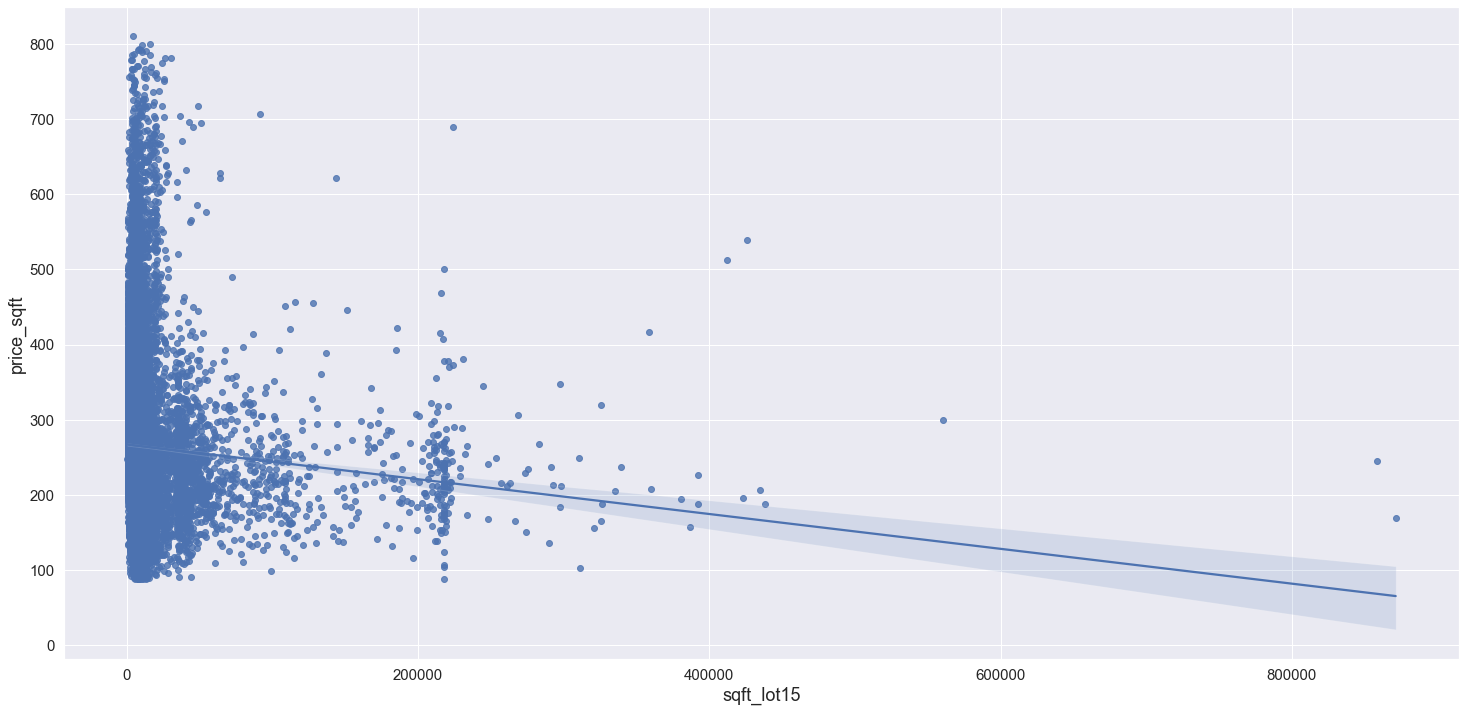

In [131]:
sns.regplot( data = df4, x = 'sqft_lot15',y = 'price_sqft');

In [132]:
df4['sqft_lot15'].describe()

count    21612.00
mean     12768.83
std      27304.76
min        651.00
25%       5100.00
50%       7620.00
75%      10083.25
max     871200.00
Name: sqft_lot15, dtype: float64

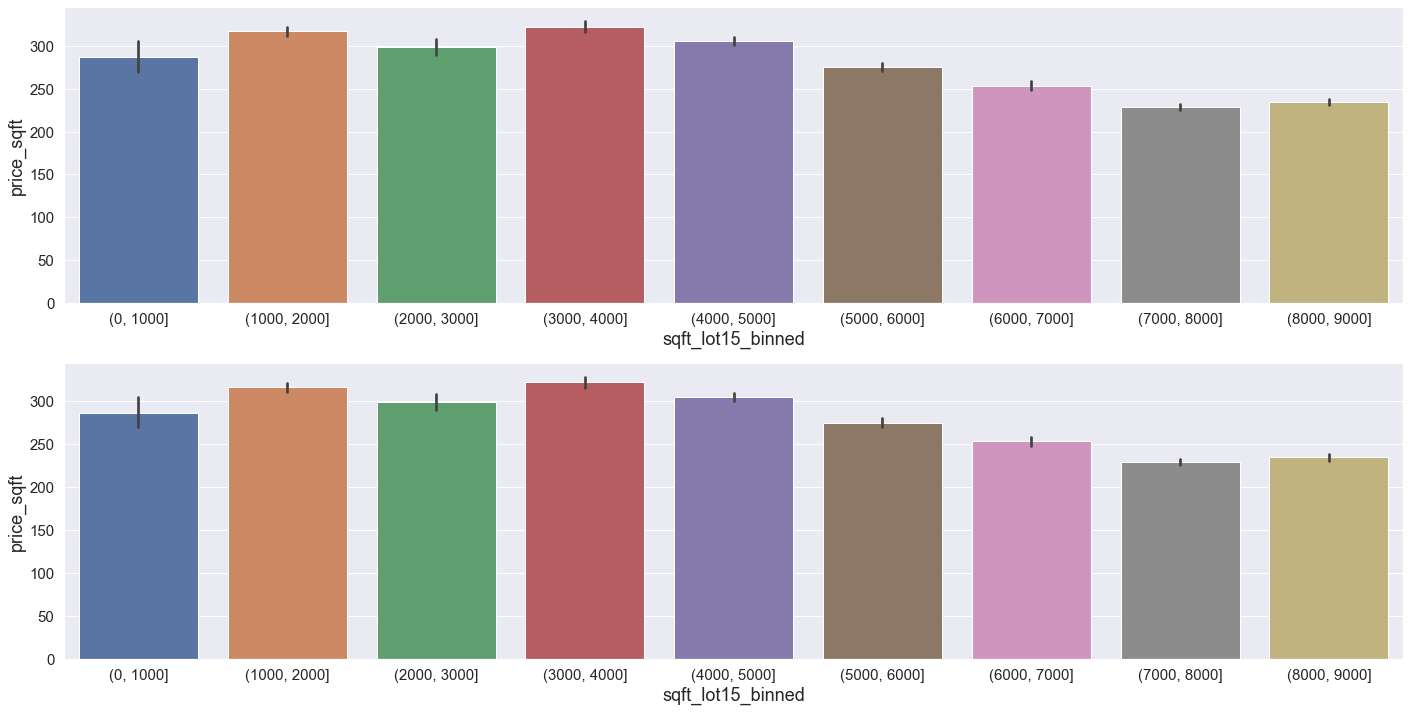

In [133]:
fig = plt.figure( figsize = (24,12) )
specs = gridspec.GridSpec( nrows = 2, ncols = 1, figure = fig )

ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )


aux1 = df4.copy()
bins = np.arange( 0,10000,1000)
aux1['sqft_lot15_binned'] = pd.cut(df4['sqft_lot15'], bins = bins)

#média
aux2 = aux1[['sqft_lot15_binned','price_sqft']].groupby('sqft_lot15_binned').mean().reset_index()
sns.barplot( data = aux1, x = 'sqft_lot15_binned', y = 'price_sqft', ax = ax1 );

#mediana
aux2 = aux1[['sqft_lot15_binned','price_sqft']].groupby('sqft_lot15_binned').median().reset_index()
sns.barplot( data = aux1, x = 'sqft_lot15_binned', y = 'price_sqft', ax = ax2 );

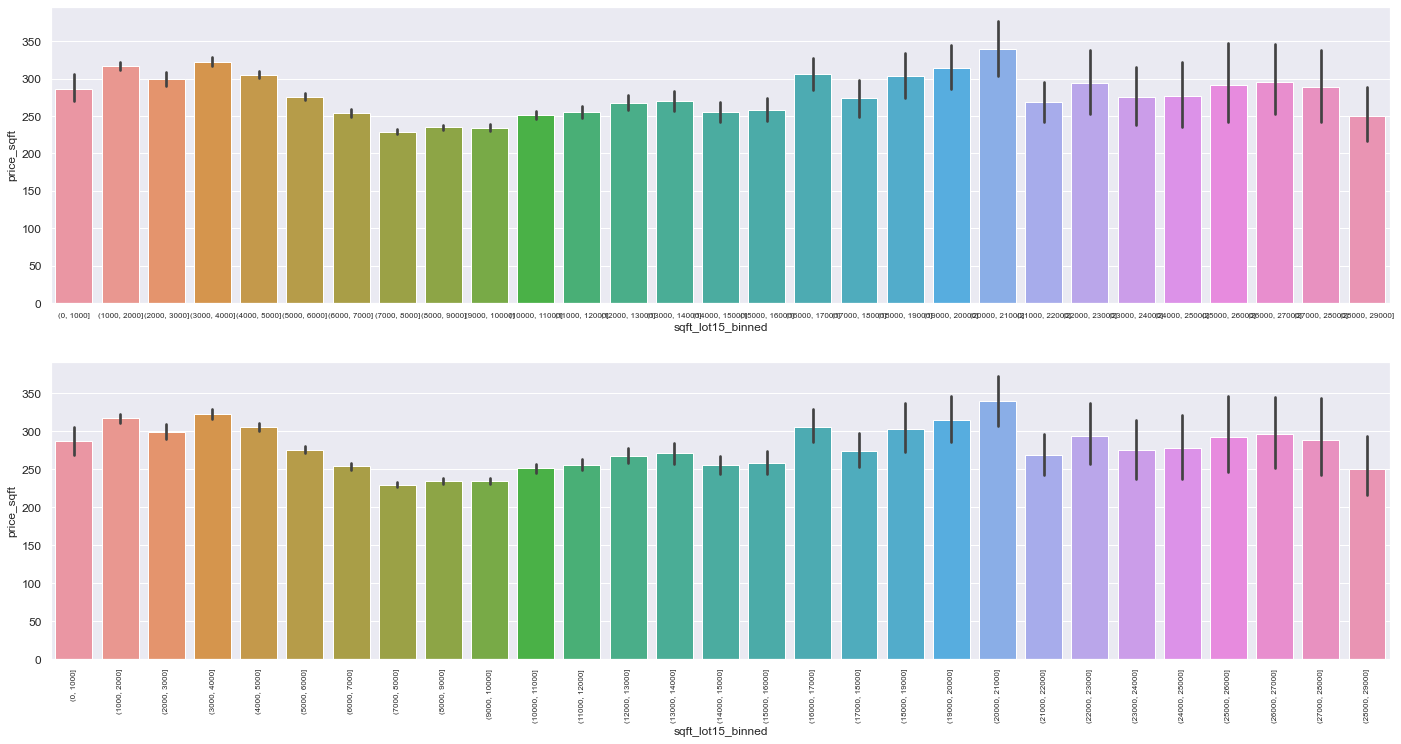

In [134]:
fig = plt.figure( figsize = (24,12) )
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=12) 
specs = gridspec.GridSpec( nrows = 2, ncols = 1, figure = fig )

ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )


aux1 = df4.copy()
bins = np.arange( 0,30000,1000)
aux1['sqft_lot15_binned'] = pd.cut(df4['sqft_lot15'], bins = bins)

#média
aux2 = aux1[['sqft_lot15_binned','price_sqft']].groupby('sqft_lot15_binned').mean().reset_index()
sns.barplot( data = aux1, x = 'sqft_lot15_binned', y = 'price_sqft', ax = ax1 );
plt.xticks(rotation = 'vertical');

#mediana
aux2 = aux1[['sqft_lot15_binned','price_sqft']].groupby('sqft_lot15_binned').median().reset_index()
sns.barplot( data = aux1, x = 'sqft_lot15_binned', y = 'price_sqft', ax = ax2);
plt.xticks(rotation = 'vertical');

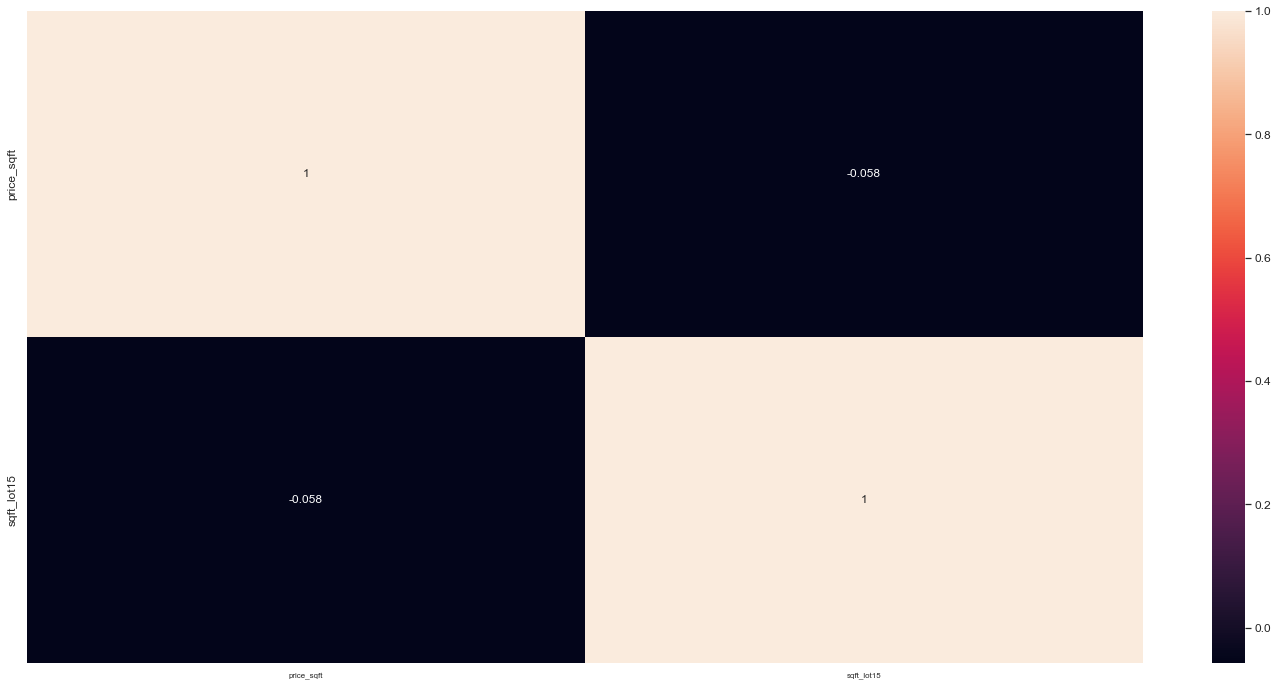

In [135]:
# correlacao com price
aux1 = df4[['price_sqft','sqft_lot15']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.13 Hipótese 13: Imóveis localizados em Seattle são mais valorizados.
Hipótese Falsa: Imóveis localizados em Seattle não são os mais valorizados.

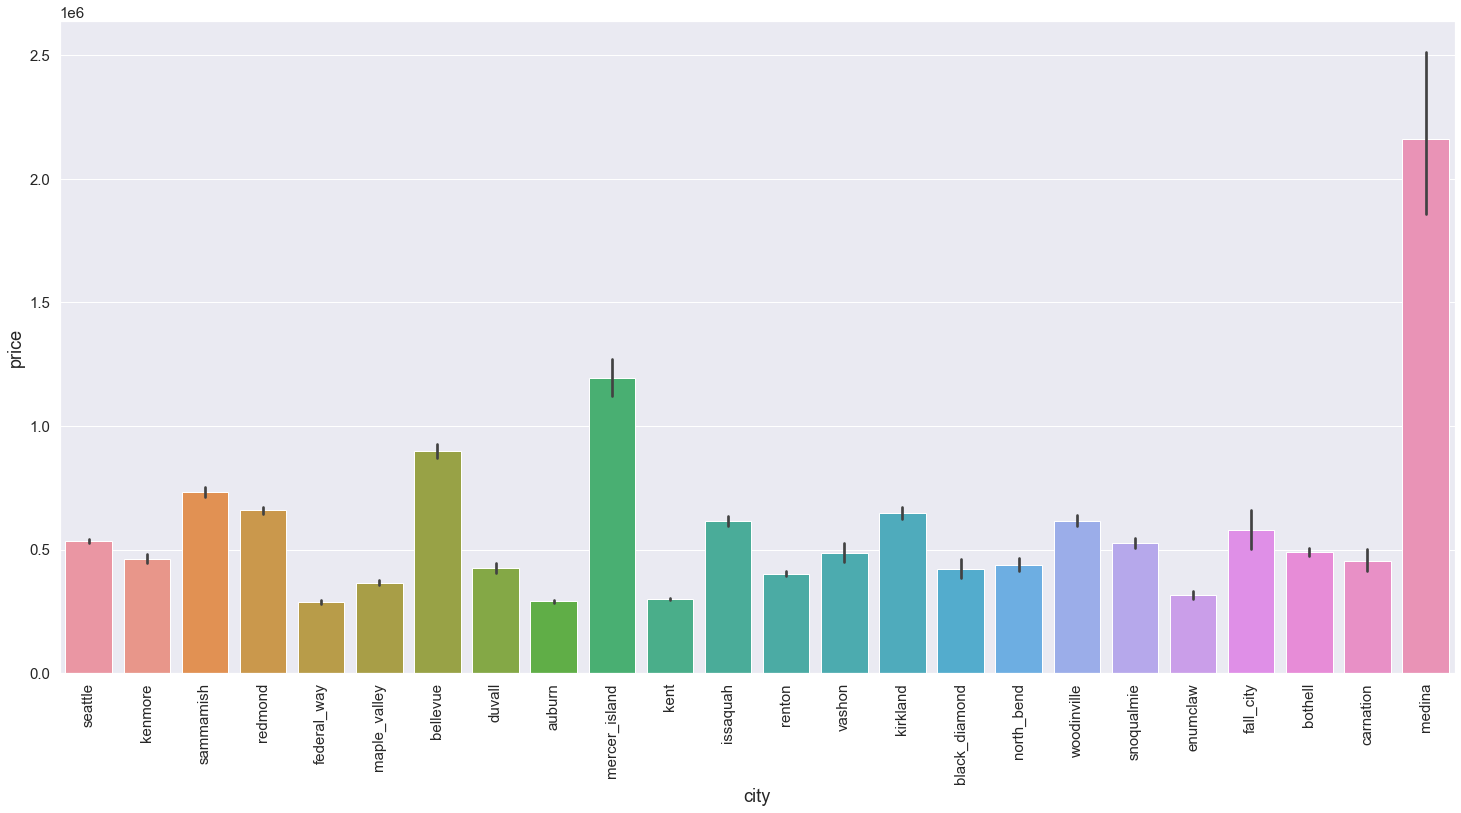

In [136]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18)

sns.barplot(data = df4, x = 'city', y = 'price');
plt.xticks(rotation = 'vertical');

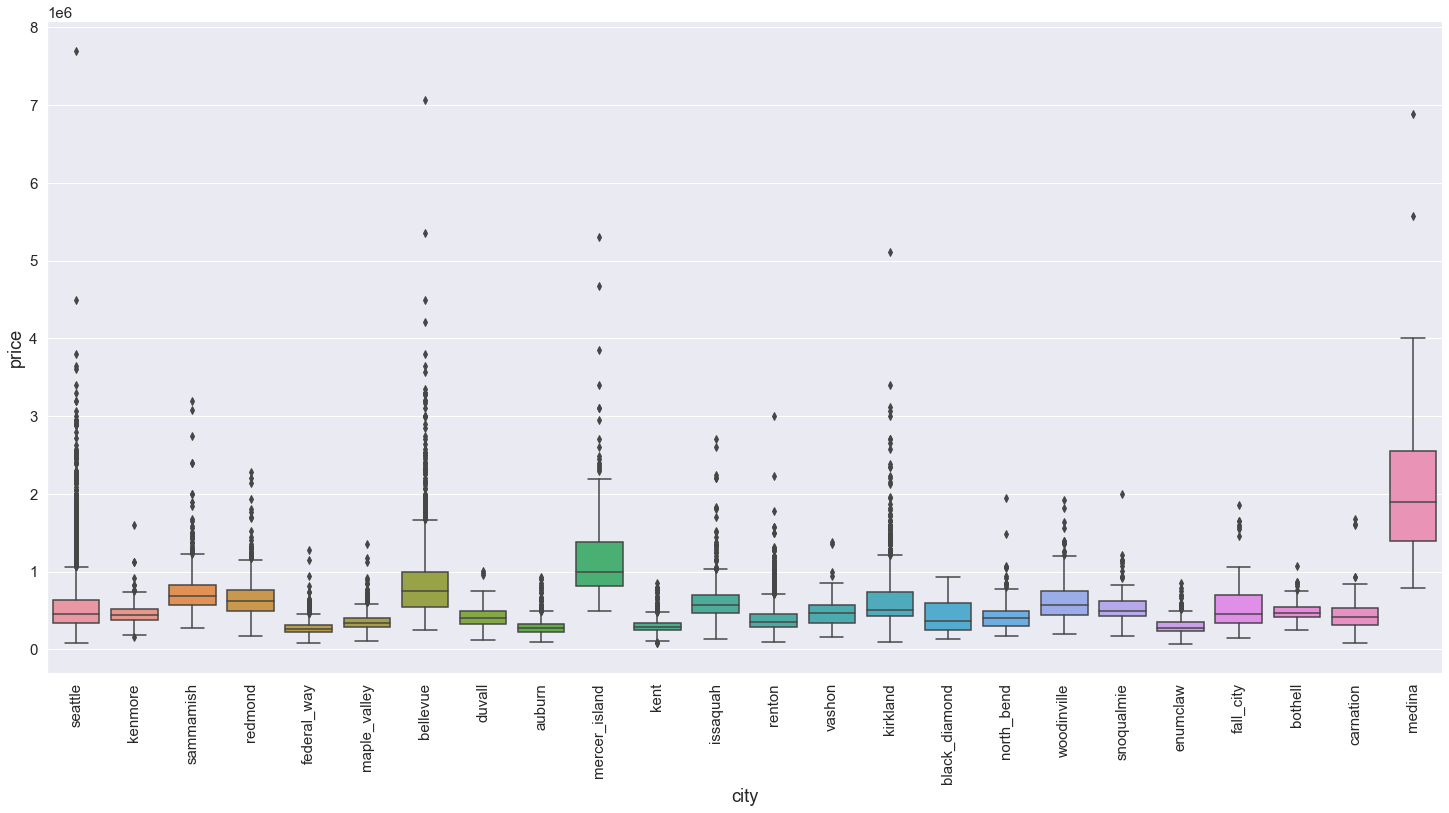

In [137]:
sns.boxplot(data = df4, x = 'city', y = 'price');
plt.xticks(rotation = 'vertical');

### 4.2.14 Hipótese 14: Imóveis com alto padrão de qualidade possuem preços maiores
Hipotese Verdadeira: Imóveis com alto padrão de qualidade possuem preços maiores

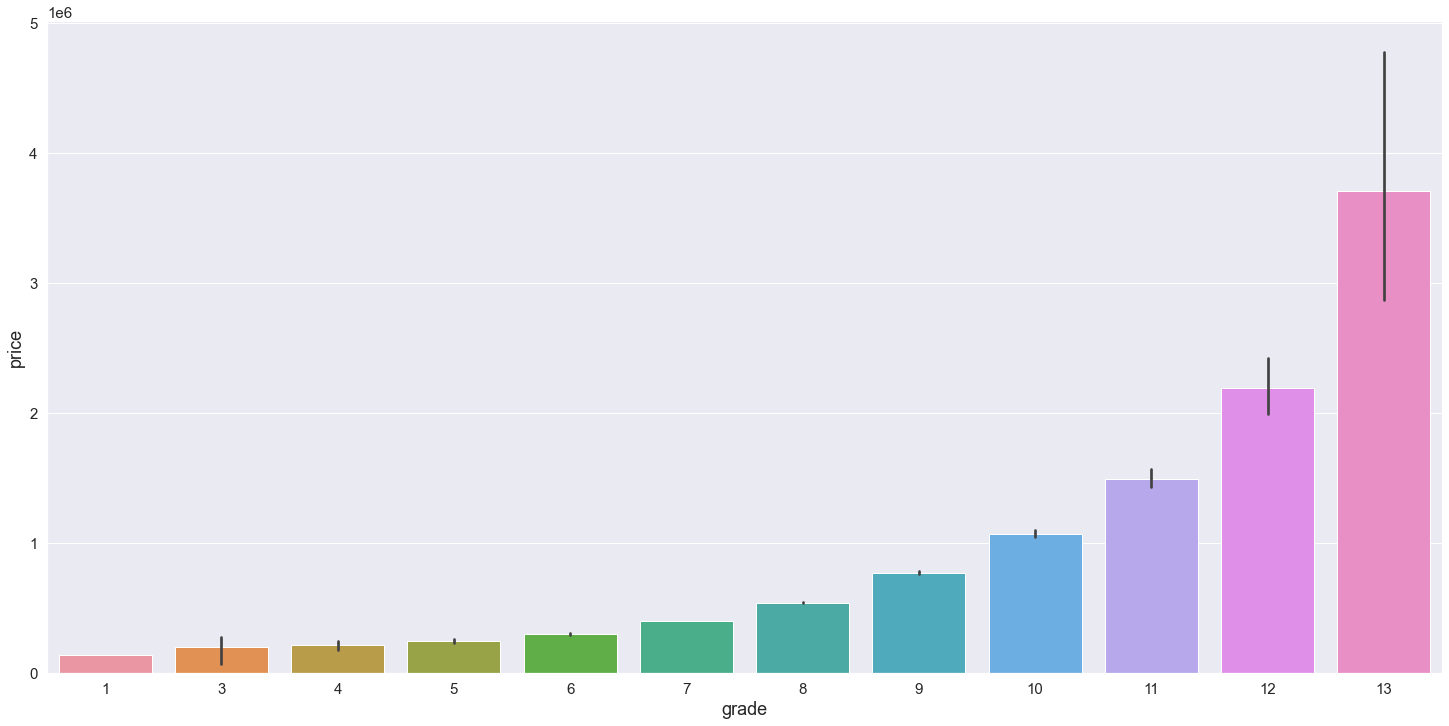

In [138]:
sns.barplot(data = df4, x = 'grade', y = 'price');

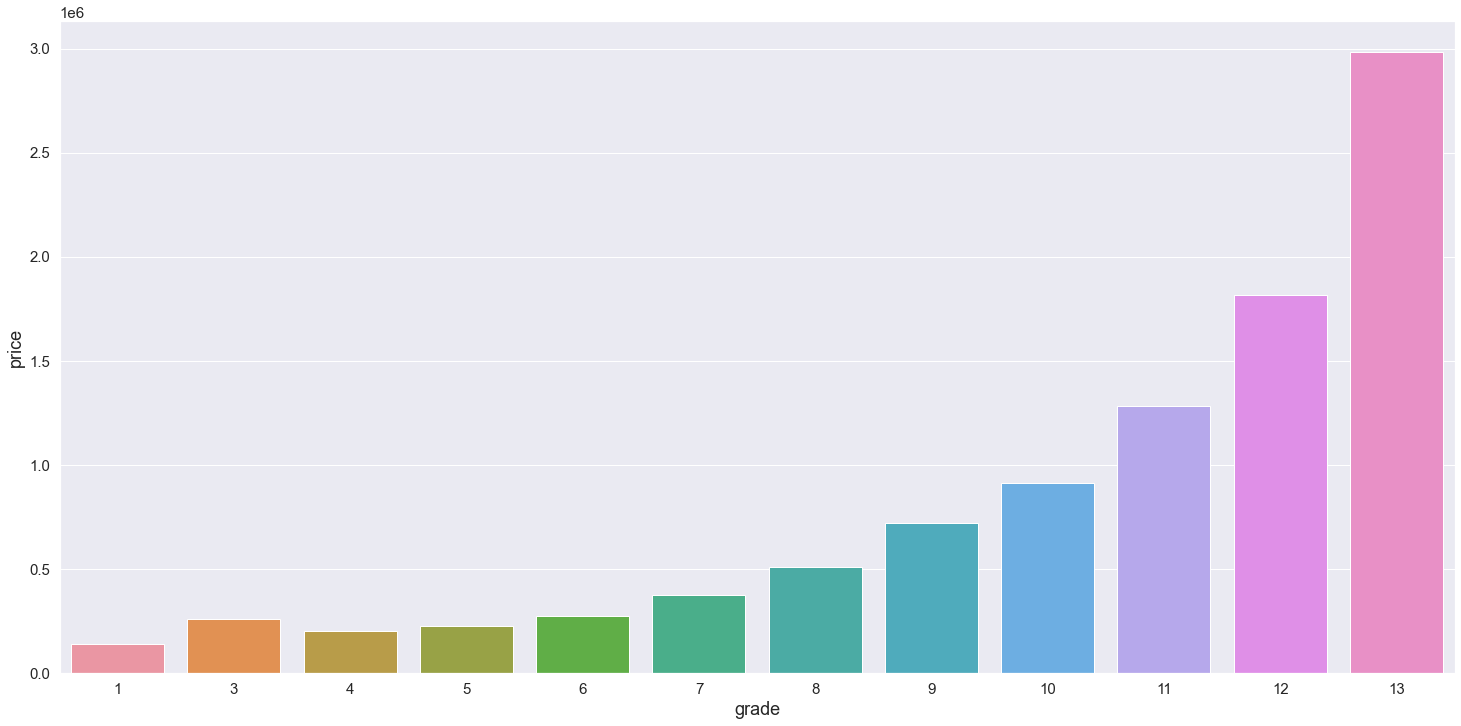

In [139]:
aux1 = df4[['grade','price']].groupby('grade').median().reset_index()
sns.barplot(data = aux1, x = 'grade', y = 'price');

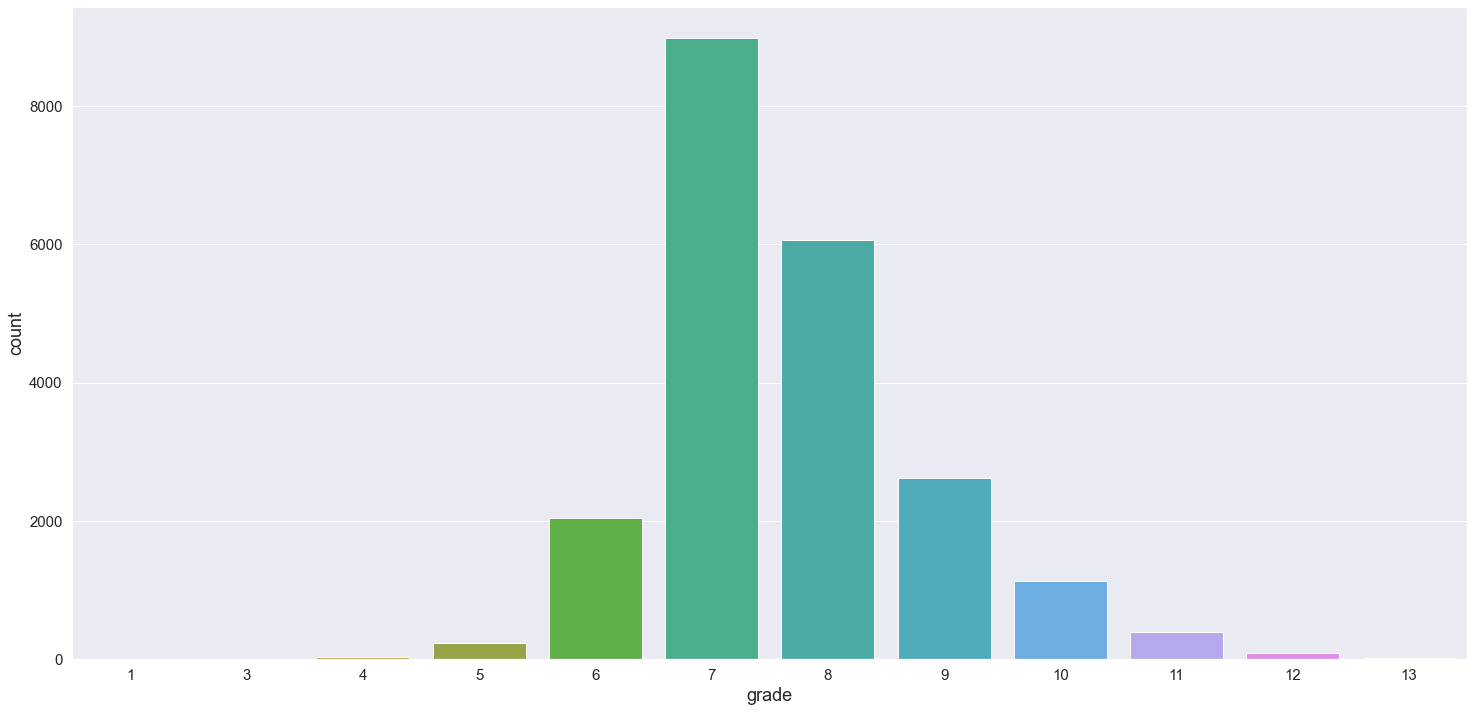

In [140]:
sns.countplot(data = df4, x = 'grade');

### 4.2.15 Hipotese 15: Imóveis com padrão de acabamento médio possuem maiores preços por metro quadrado
Hipótese Falsa: Imóveis com padrão de acabamento médio não possuem maiores preços por metro quadrado.

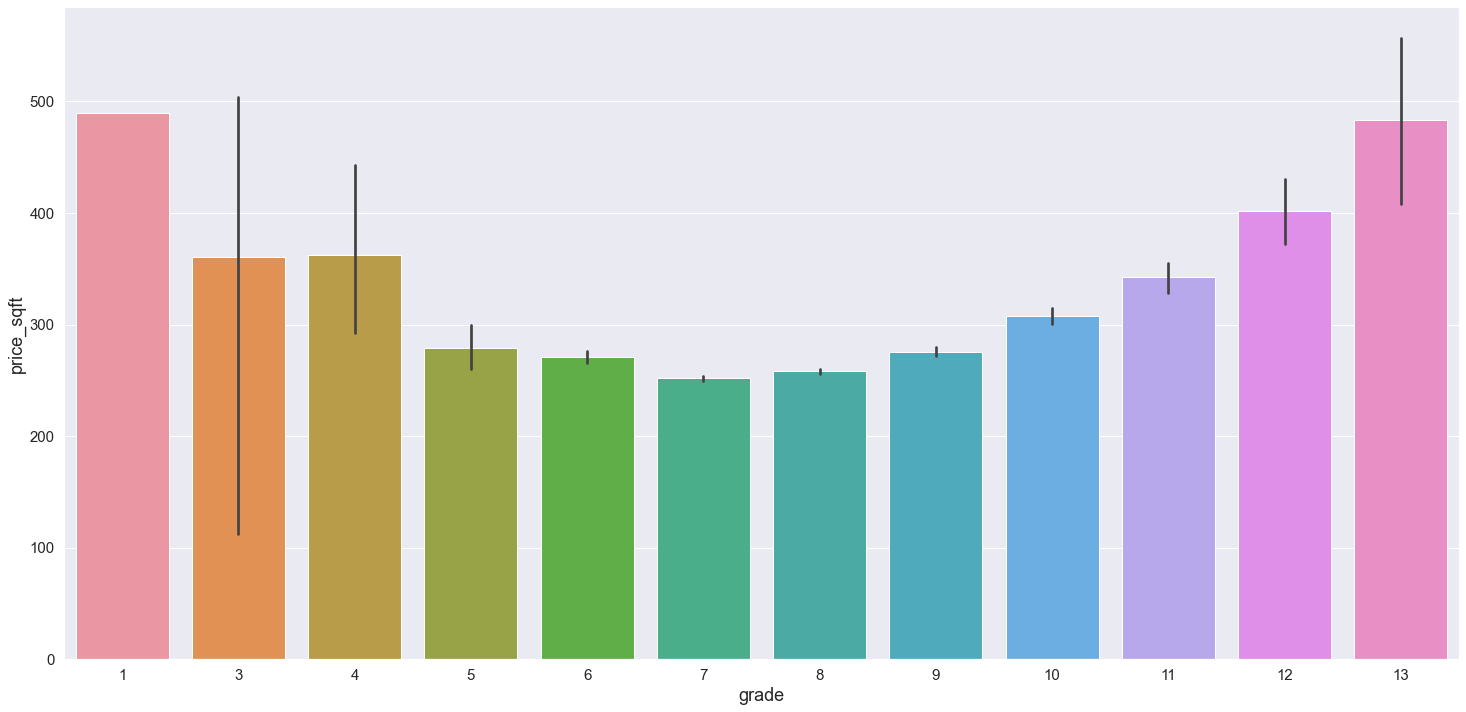

In [141]:
sns.barplot(data = df4, x = 'grade', y = 'price_sqft');

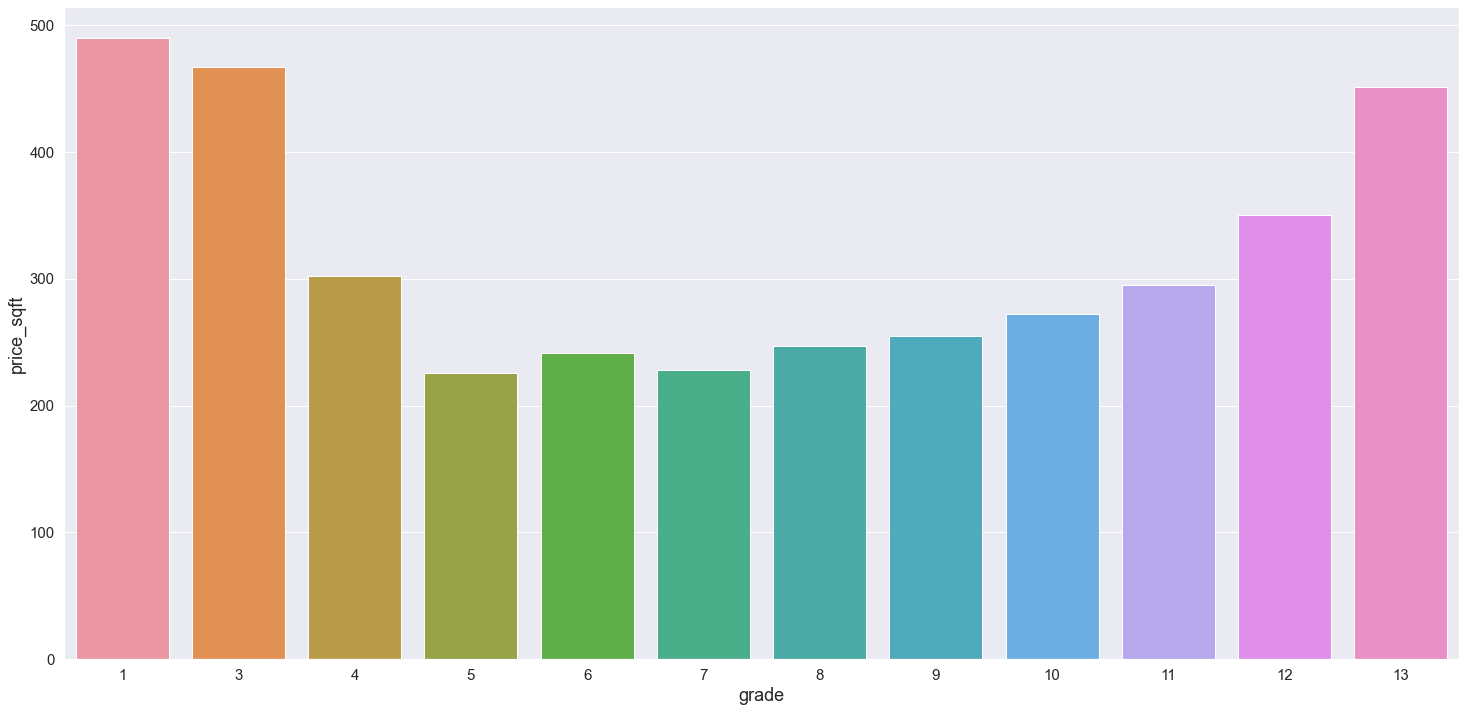

In [142]:
aux1 = df4[['grade','price_sqft']].groupby('grade').median().reset_index()
sns.barplot(data = aux1, x = 'grade', y = 'price_sqft');

### 4.2.16 Hipótese 16: Imóveis com padrão de acabamento inferior são mais vendidos
Hipótese Falsa: Imóveis com padrão de acamento inferior não são os mais vendidos

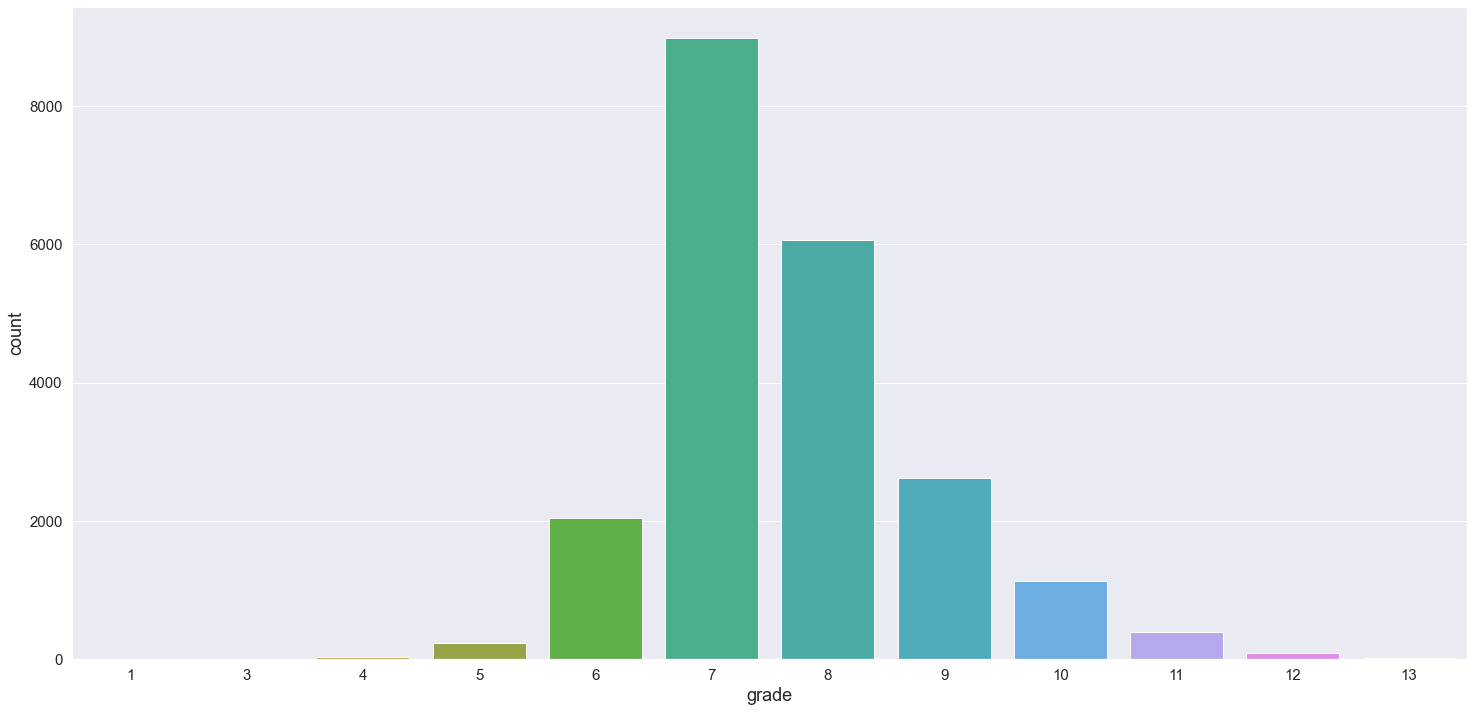

In [143]:
sns.countplot(data = df4, x = 'grade');

### 4.2.17 Hipótese 17: Imóveis reformados nos últimos 3 anos possuem preços maiores
Hipótese Falsa: Imóveis reformados nos ultimos 3 anos não possuem maiores preços de venda.

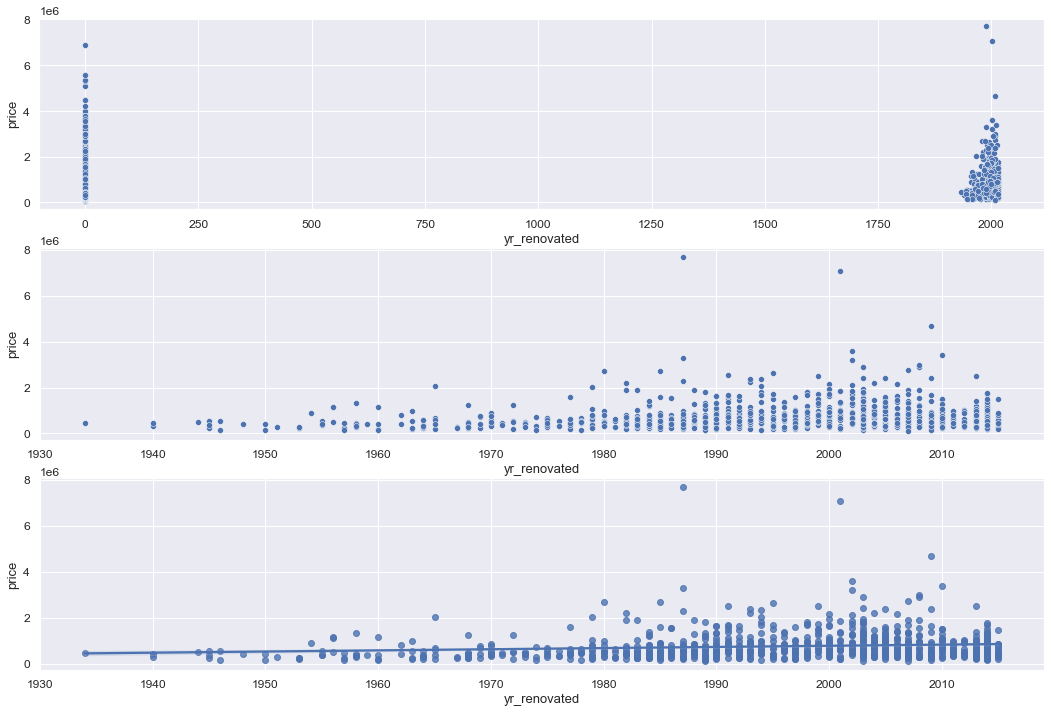

In [144]:
fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( nrows = 3, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )

#imóveis reformados e nao reformados 
sns.scatterplot(data = df4, x = 'yr_renovated', y = 'price', ax = ax1);

#imoveis reformados
aux1 = df4.loc[df4['yr_renovated'] != 0 ]
sns.scatterplot(data = aux1, x = 'yr_renovated', y = 'price', ax = ax2);

sns.regplot(data = aux1, x = 'yr_renovated', y = 'price', ax = ax3);
#sns.lineplot(data = df4, x = 'yr_renovated', y = 'price');

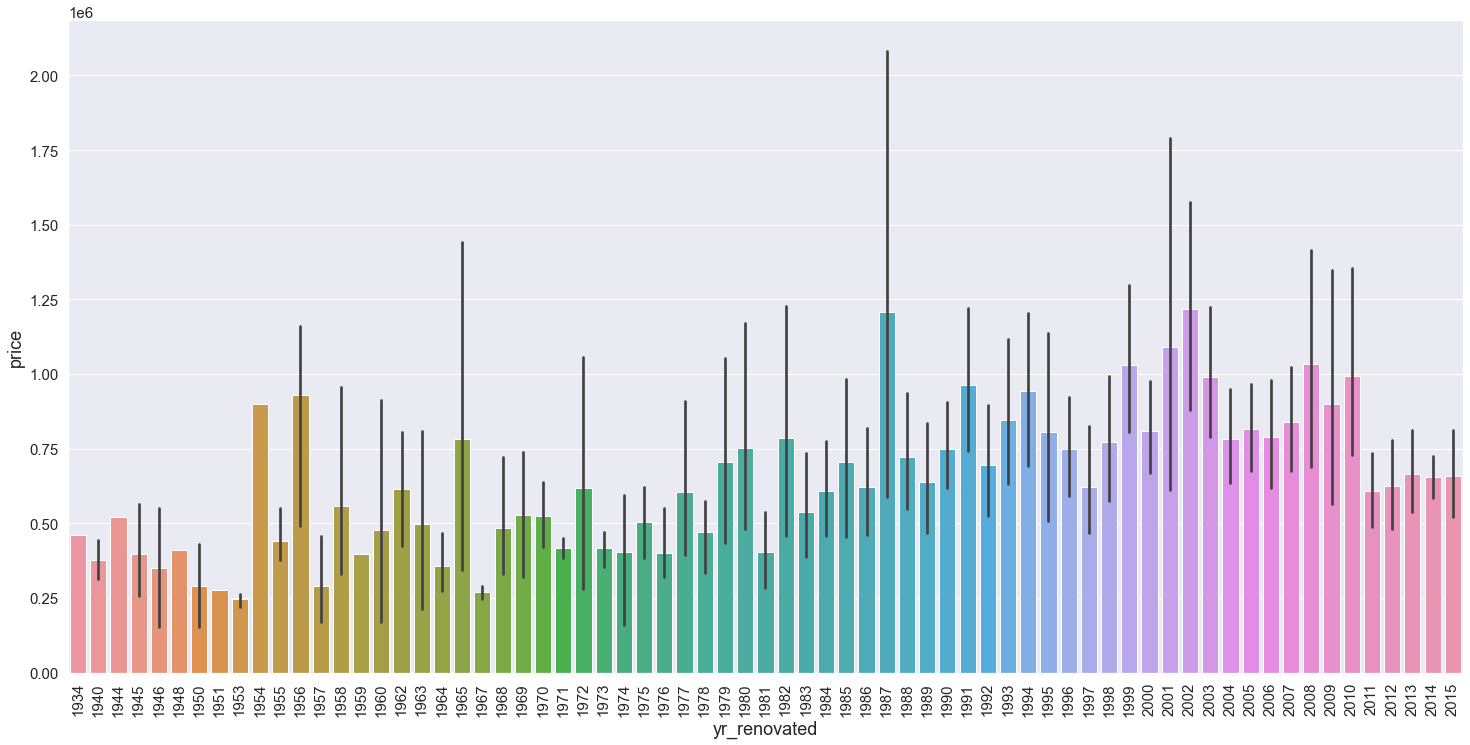

In [145]:
#média
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
sns.barplot(data = aux1, x = 'yr_renovated', y = 'price');
plt.xticks( rotation = 'vertical');

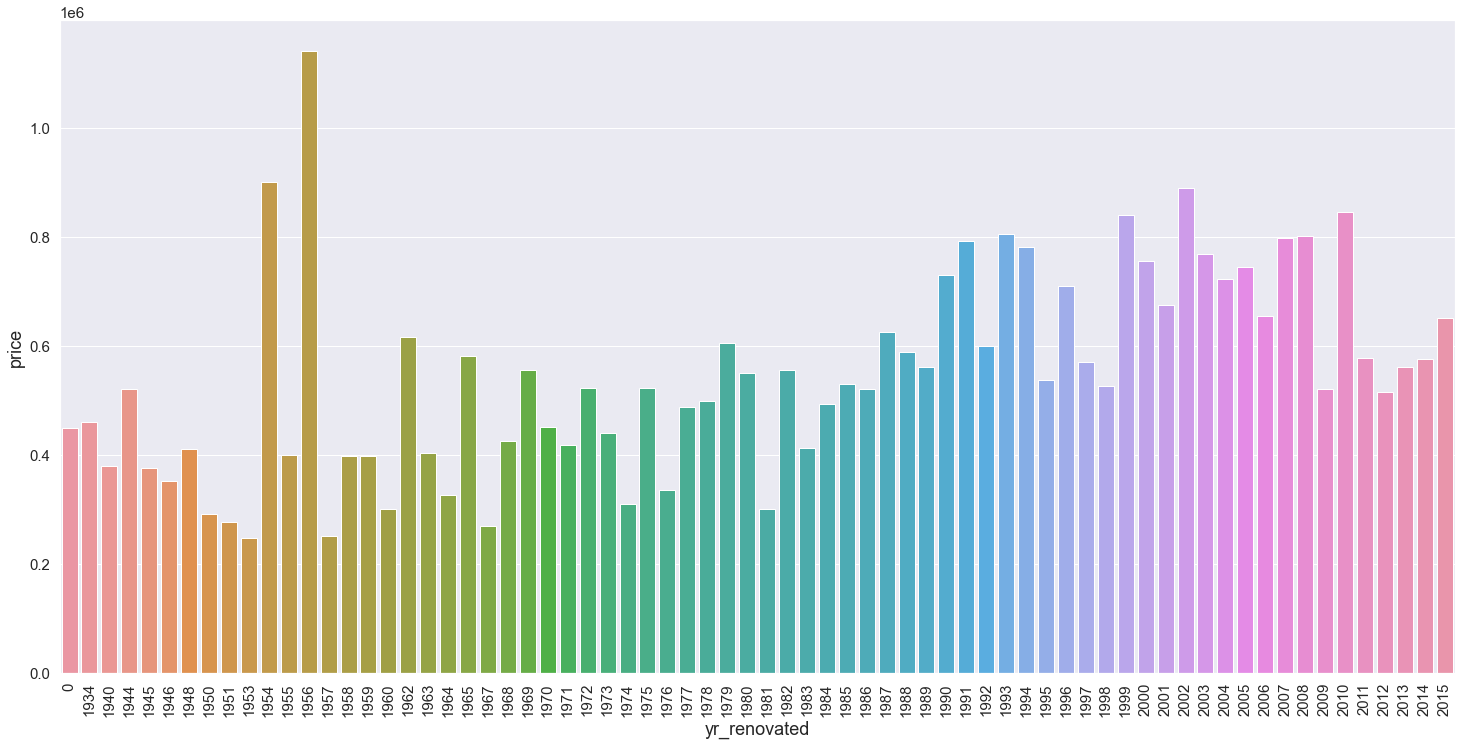

In [146]:
#mediana
aux1 = df4[['yr_renovated', 'price']].groupby('yr_renovated').median().reset_index()
sns.barplot(data = aux1, x = 'yr_renovated', y = 'price');
plt.xticks( rotation = 'vertical');

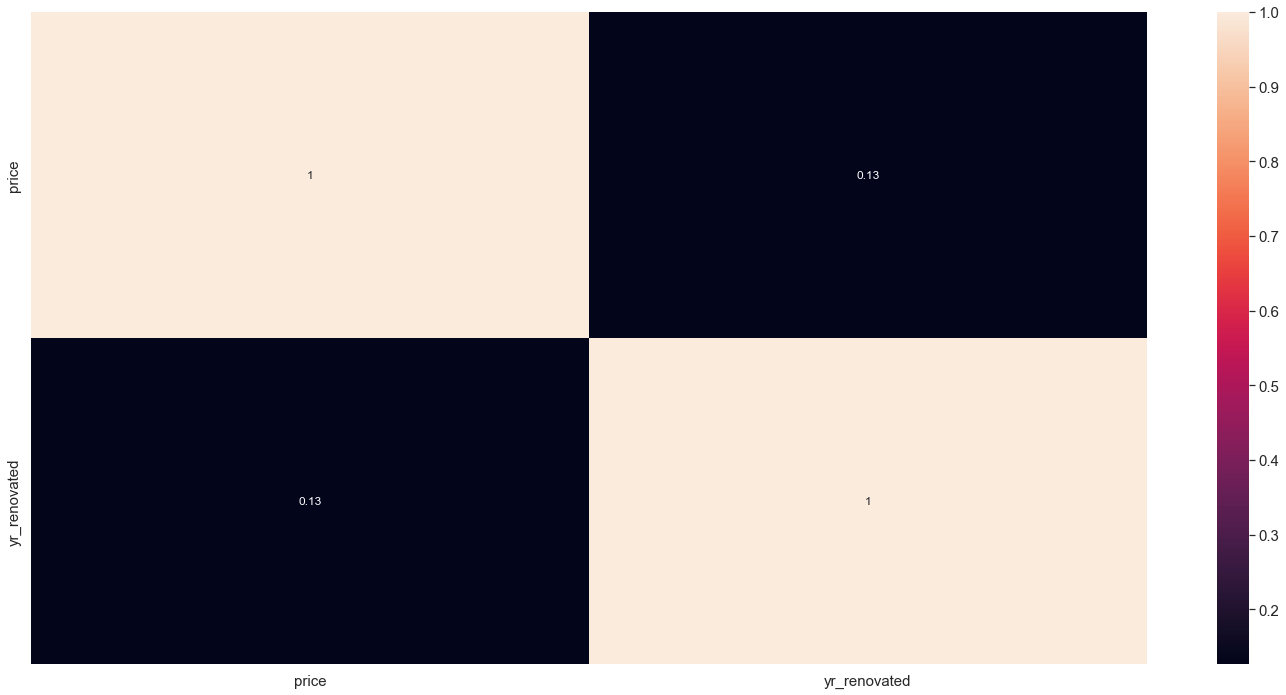

In [147]:
# correlacao com price
aux1 = df4[['price','yr_renovated']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.18 Hipótese 18: Imóveis reformados nos ultimos 3 anos possuem maiores preço/sqft2
Hipótese Falsa: Imóveis reformados nos últimos 3 anos não possuem maiores preços/sqft2

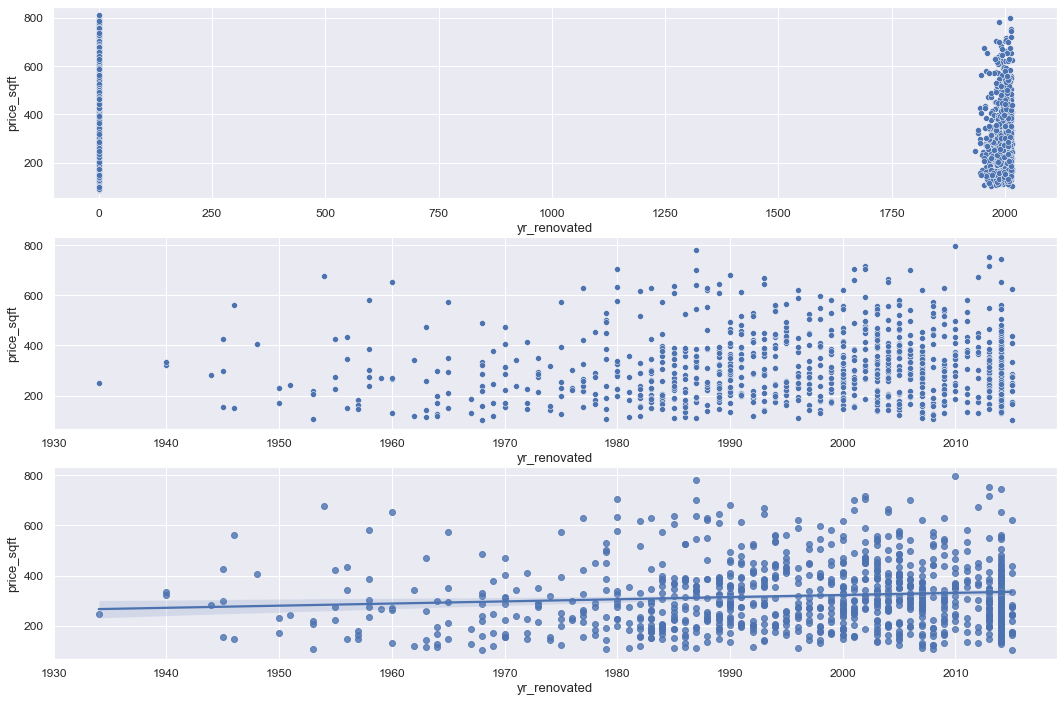

In [148]:
fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( nrows = 3, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )

#imóveis reformados e nao reformados
sns.scatterplot(data = df4, x = 'yr_renovated', y = 'price_sqft', ax = ax1);

#imoveis reformados
aux1 = df4.loc[df4['yr_renovated'] != 0 ]
sns.scatterplot(data = aux1, x = 'yr_renovated', y = 'price_sqft', ax = ax2);

sns.regplot(data = aux1, x = 'yr_renovated', y = 'price_sqft', ax = ax3);

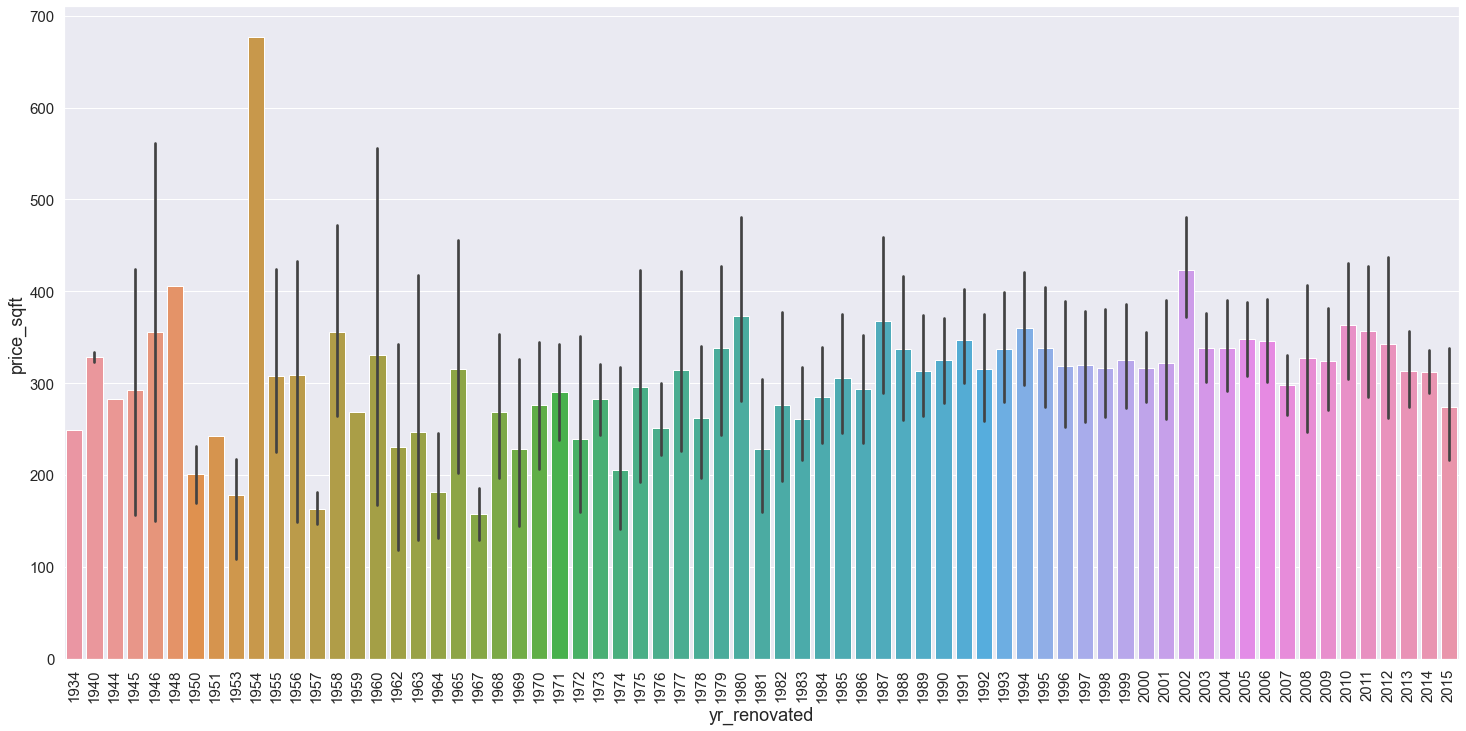

In [149]:
#média
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
sns.barplot(data = aux1, x = 'yr_renovated', y = 'price_sqft');
plt.xticks( rotation = 'vertical');

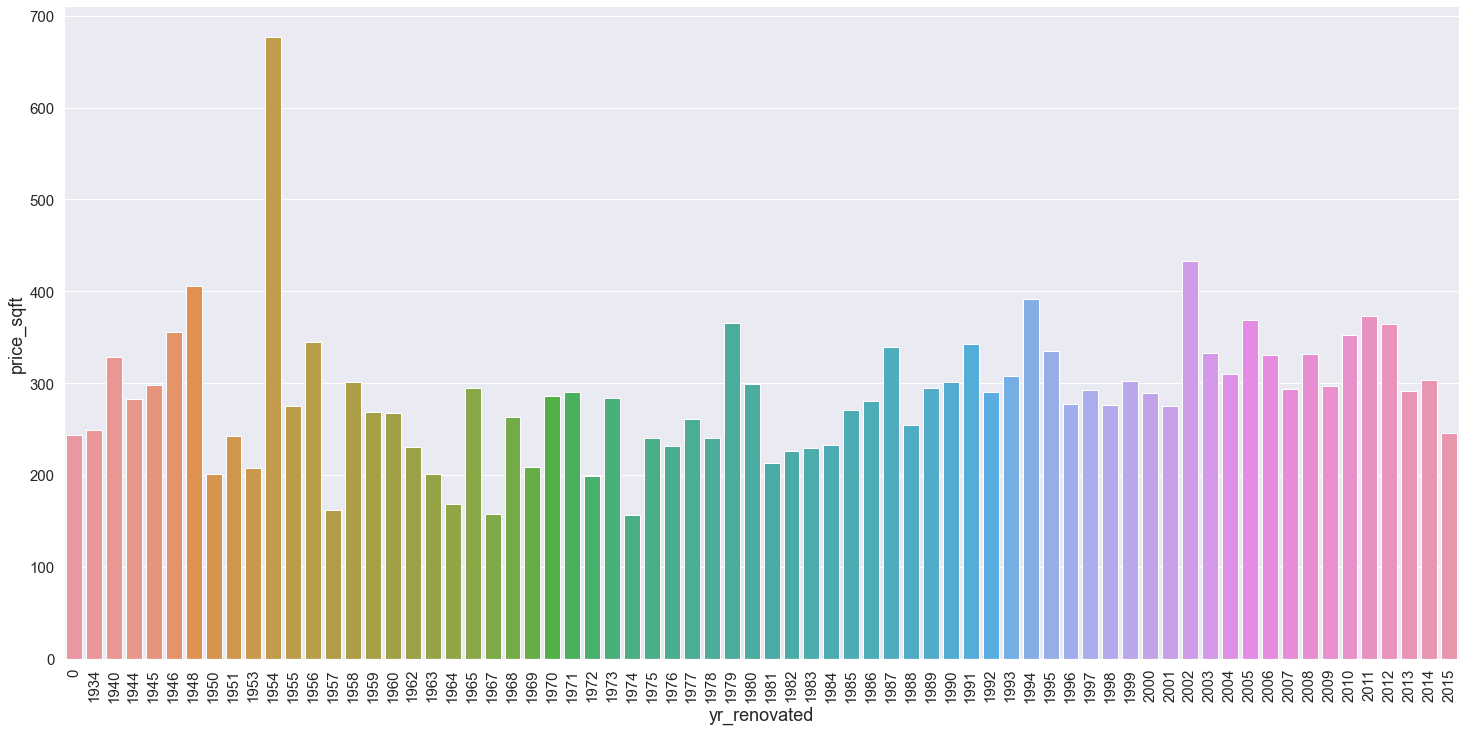

In [150]:
#mediana
aux1 = df4[['yr_renovated', 'price_sqft']].groupby('yr_renovated').median().reset_index()
sns.barplot(data = aux1, x = 'yr_renovated', y = 'price_sqft');
plt.xticks( rotation = 'vertical');

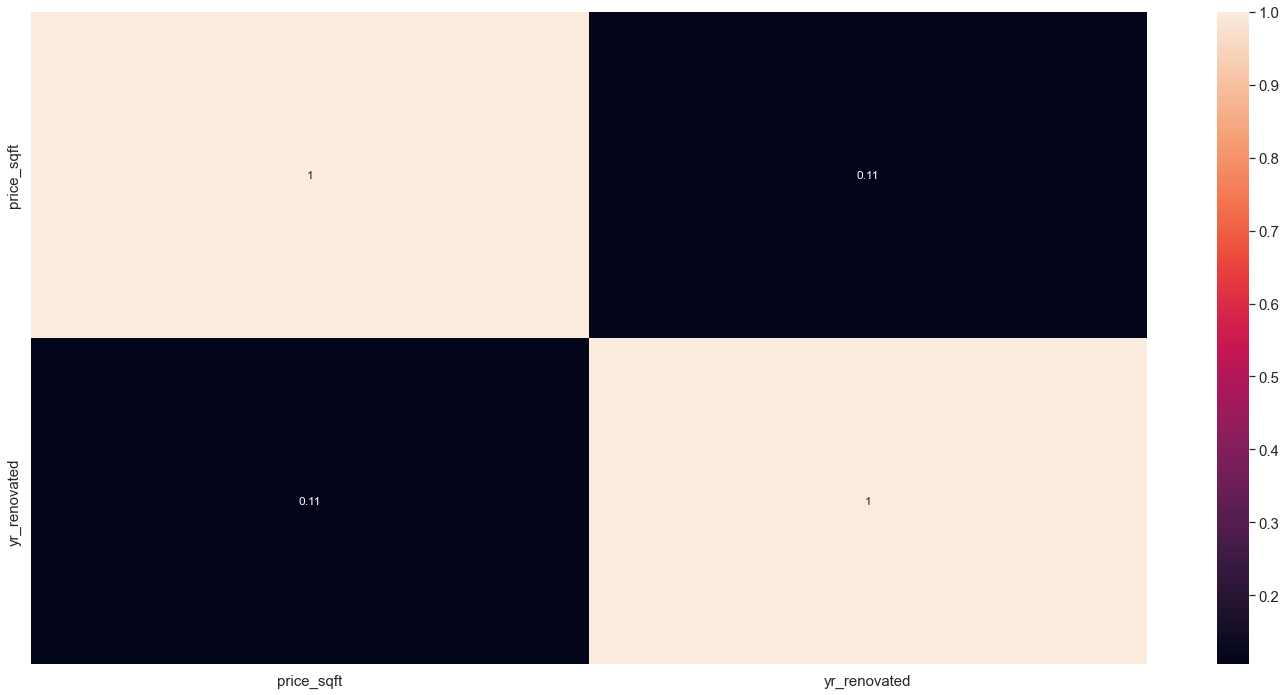

In [151]:
# correlacao com price
aux1 = df4[['price_sqft','yr_renovated']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.19 Hipótese 19: Imóveis com idade de construção superior a 50 anos possuem preços menores
Hipótese Falsa: Imóveis com idade de construção superior a 50 anos não possuem preços menores

In [152]:
df4['yr_built'].sort_values().unique()

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015])

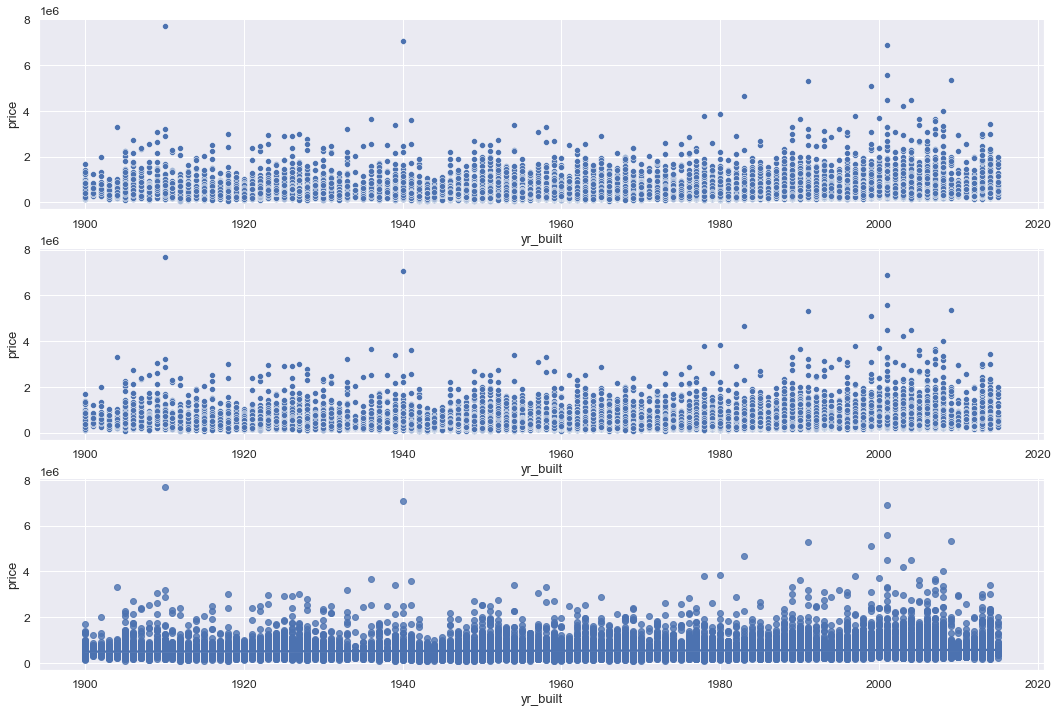

In [153]:
fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( nrows = 3, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )


#imóveis novos
sns.scatterplot(data = df4, x = 'yr_built', y = 'price', ax = ax1);

#imoveis reformados

sns.scatterplot(data = df4, x = 'yr_built', y = 'price', ax = ax2);

sns.regplot(data = df4, x = 'yr_built', y = 'price',  ax = ax3);
#sns.lineplot(data = df4, x = 'yr_renovated', y = 'price');

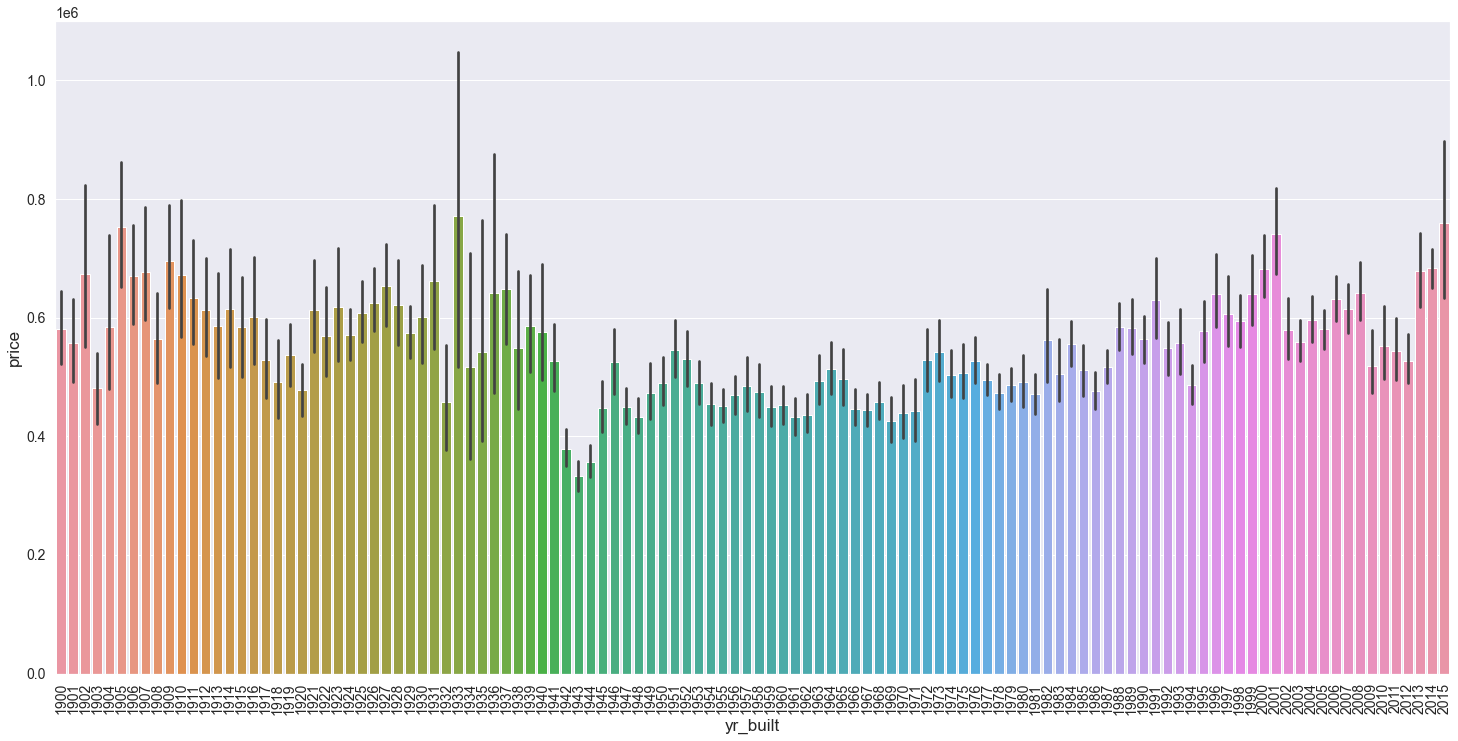

In [154]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes',  labelsize=17) 
sns.barplot(data = df4, x = 'yr_built', y = 'price');
plt.xticks( rotation = 'vertical');

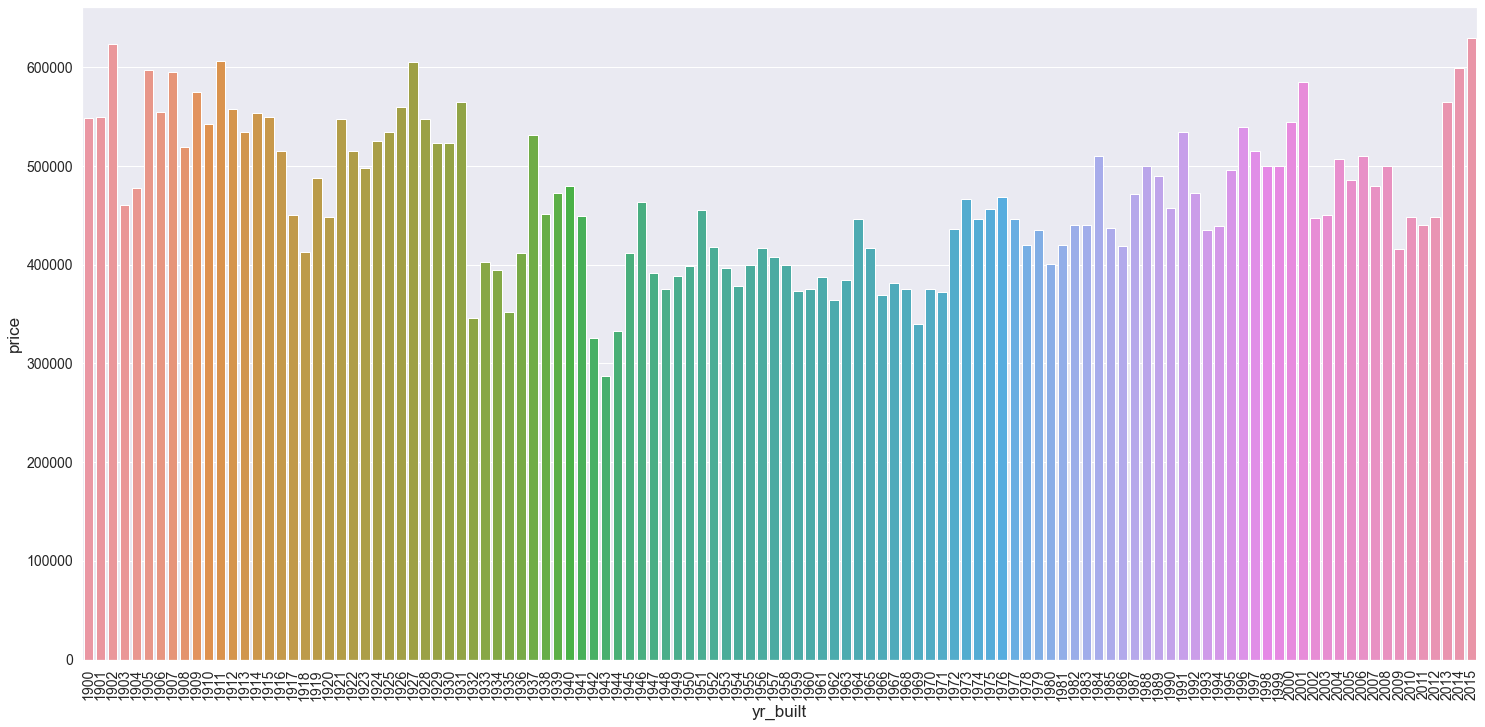

In [155]:
aux1 = df4[['yr_built', 'price']].groupby('yr_built').median().reset_index()
sns.barplot(data = aux1, x = 'yr_built', y = 'price');
plt.xticks( rotation = 'vertical');

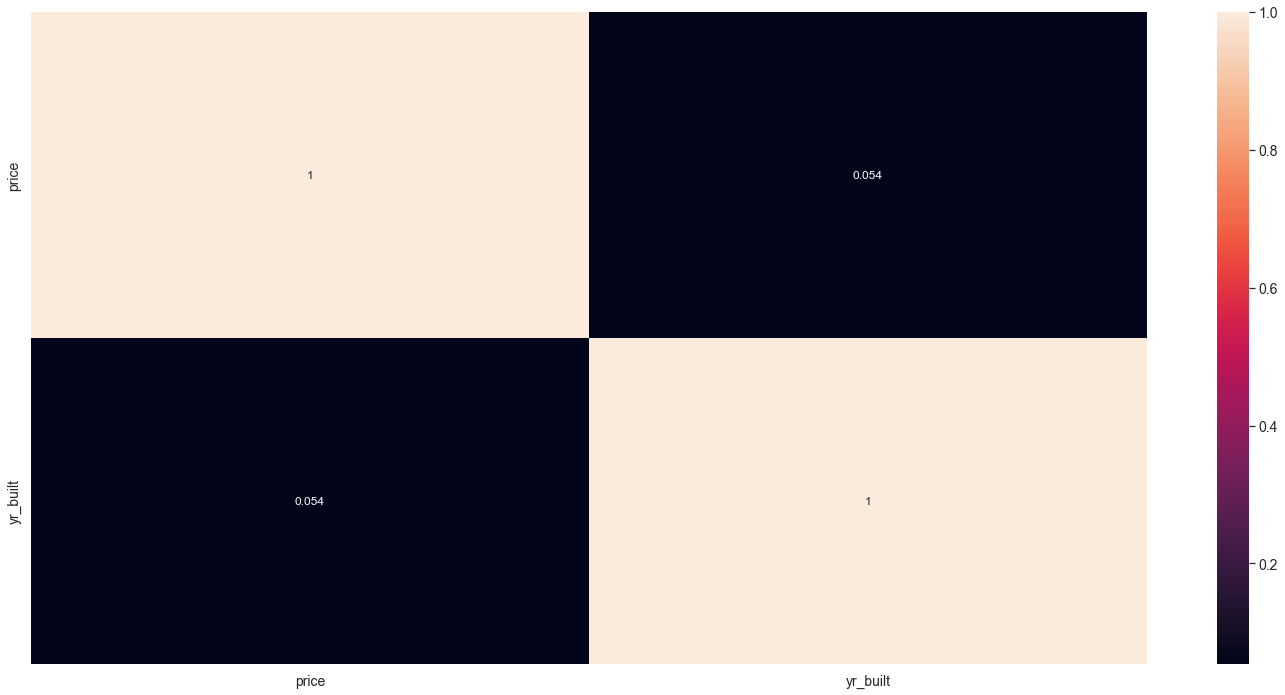

In [156]:
aux1 = df4[['price','yr_built']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.20 Hipótese 20: Imóveis com idade de construção superior a 50 anos possuem preço/sqft2 menores
Hipótese Falsa: Imóveis com mais de 50 anos não possuem preços/sqft2 menores

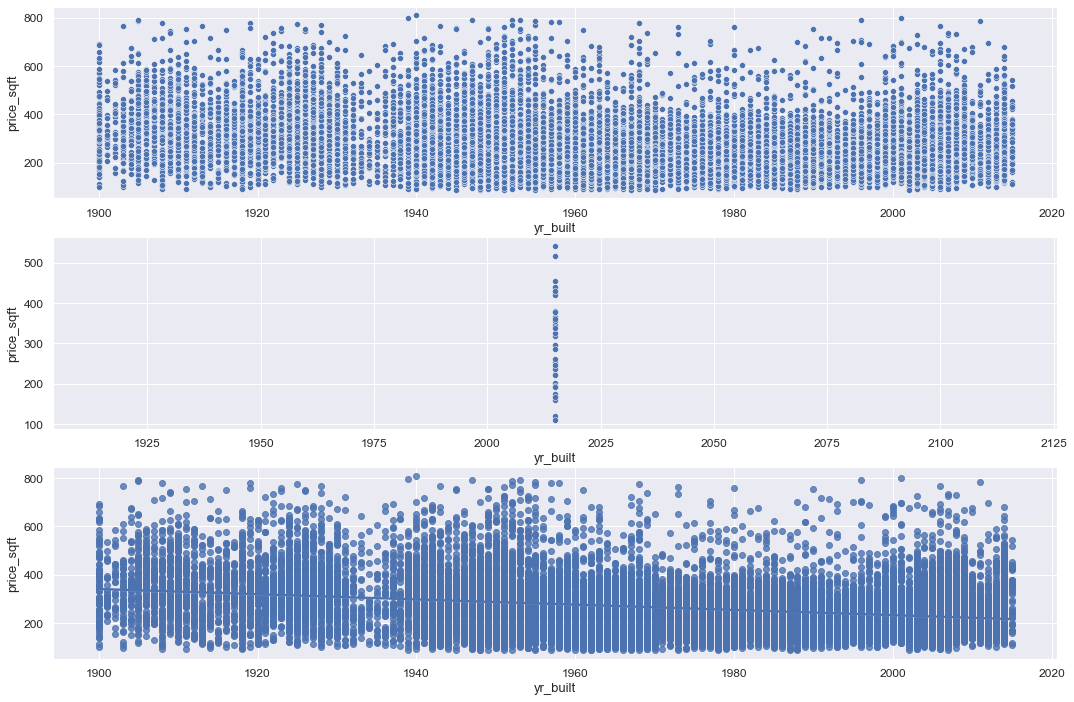

In [157]:
fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( nrows = 3, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )


#imóveis novos e antigos
sns.scatterplot(data = df4, x = 'yr_built', y = 'price_sqft', ax = ax1);

#imoveis novos
aux1 = df4.loc[ df4['yr_built'] == 2015 ]
sns.scatterplot(data = aux1, x = 'yr_built', y = 'price_sqft', ax = ax2);

sns.regplot(data = df4, x = 'yr_built', y = 'price_sqft', ax = ax3);

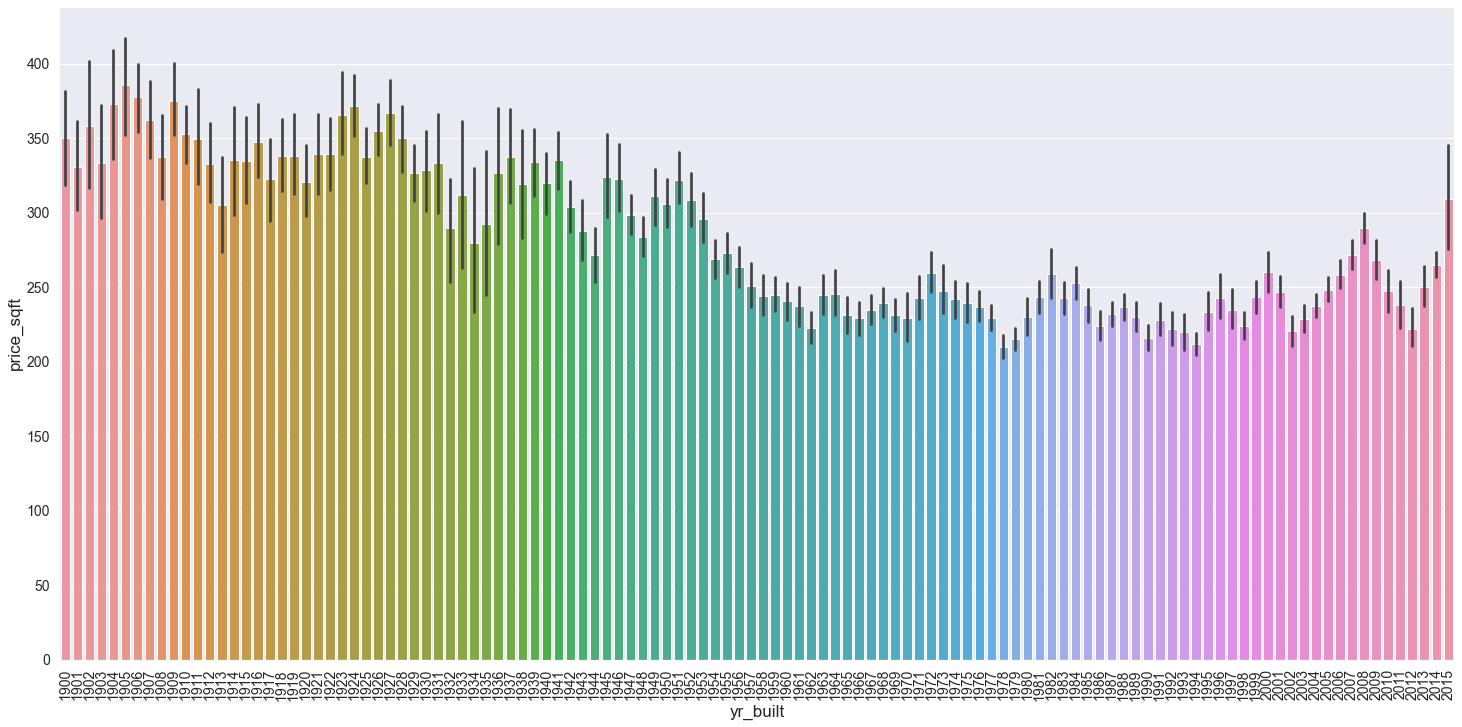

In [158]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes',  labelsize=17) 
sns.barplot(data = df4, x = 'yr_built', y = 'price_sqft');
plt.xticks( rotation = 'vertical');

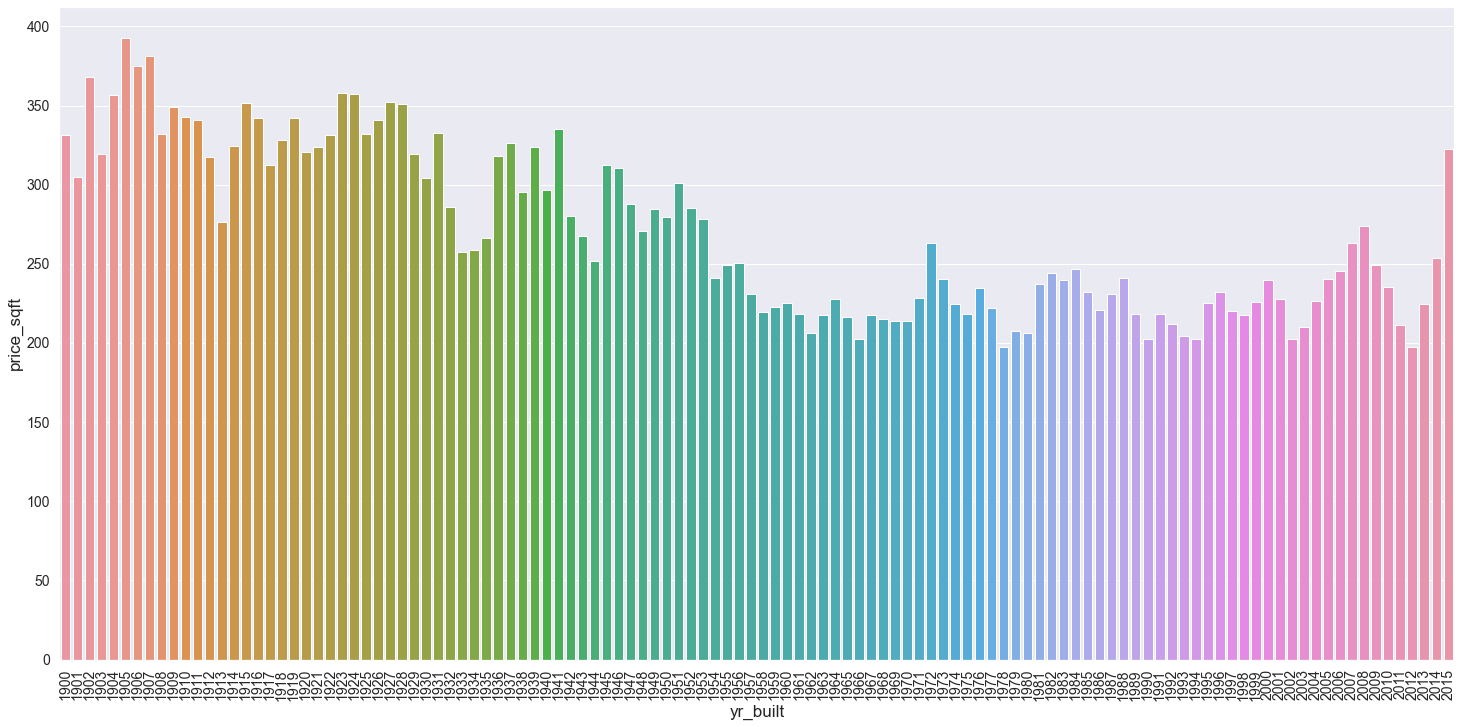

In [159]:
aux1 = df4[['yr_built', 'price_sqft']].groupby('yr_built').median().reset_index()
sns.barplot(data = aux1, x = 'yr_built', y = 'price_sqft');
plt.xticks( rotation = 'vertical');

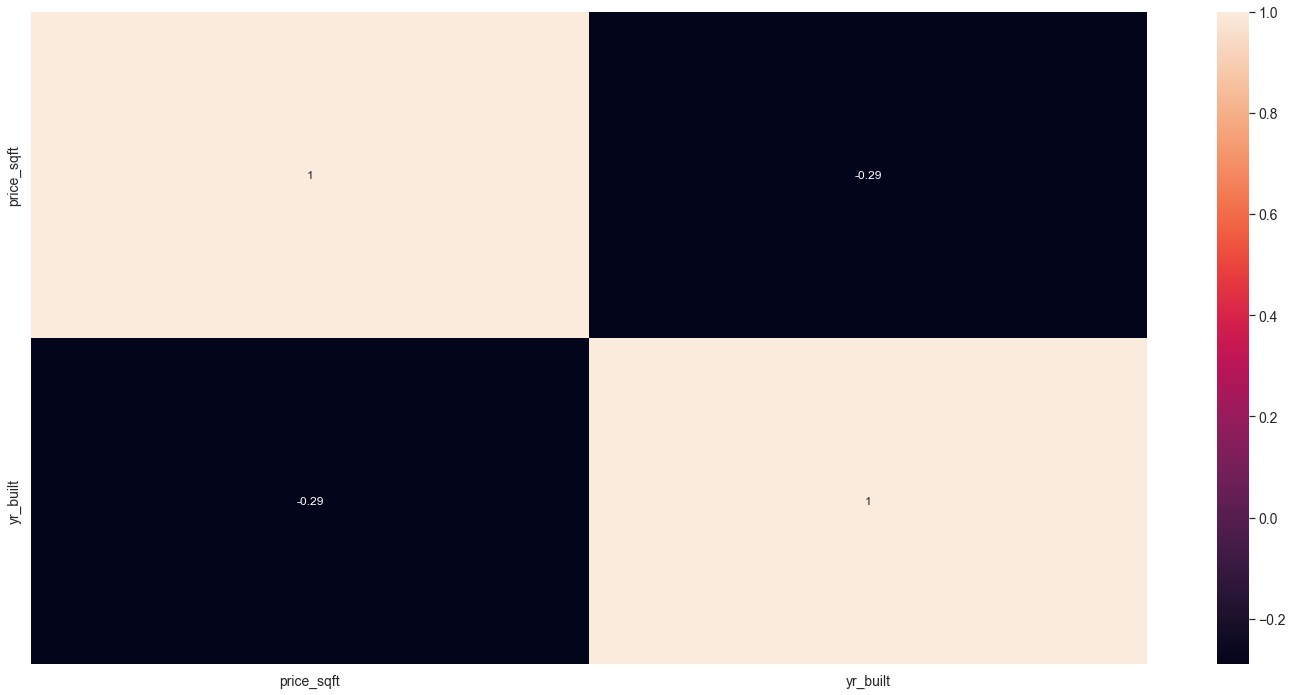

In [160]:
# correlacao com price
aux1 = df4[['price_sqft','yr_built']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.21 Hipótese 21: Imóveis com idade de construção inferior a 3 anos possuem preços maiores.
Hipótese verdadeira: Imóveis com idade de construção inferior a 3 anos possuem preços de venda maiores.

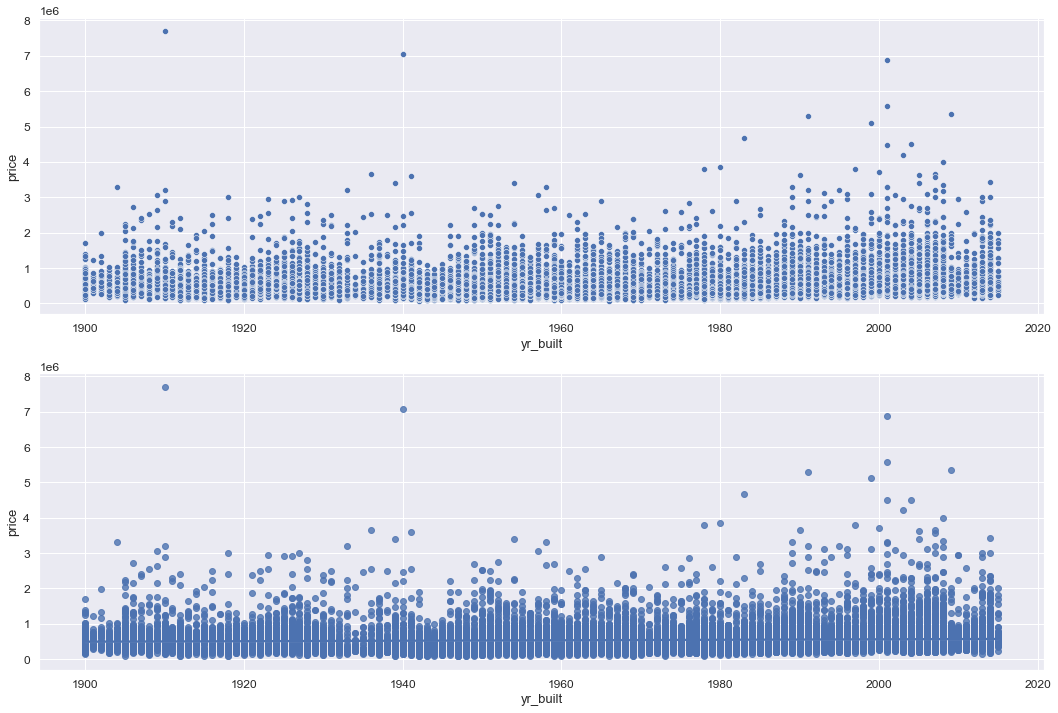

In [161]:
fig = plt.figure( figsize = (18,12) )
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=13) 
specs = gridspec.GridSpec( nrows = 2, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )


#imóveis novos
sns.scatterplot(data = df4, x = 'yr_built', y = 'price', ax = ax1);

#tendencia média
sns.regplot(data = df4, x = 'yr_built', y = 'price',  ax = ax2);
#sns.lineplot(data = df4, x = 'yr_renovated', y = 'price');

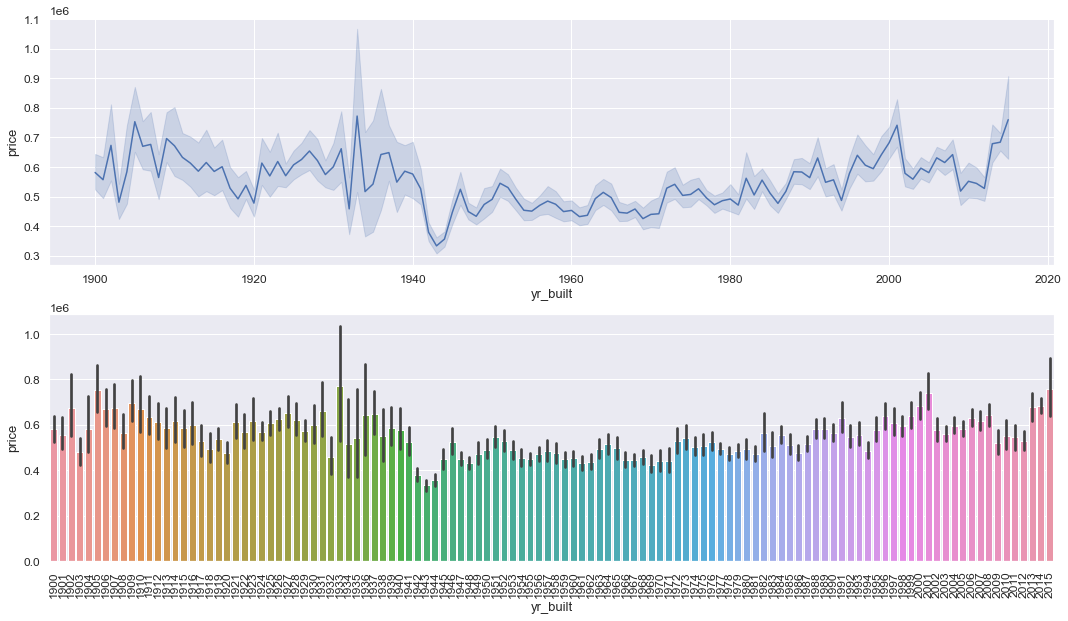

In [162]:
fig = plt.figure( figsize = (18,10) )

specs = gridspec.GridSpec( nrows = 2, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
#ax3 = fig.add_subplot( specs[ 2, 0 ] )

sns.lineplot(data = df4, x = 'yr_built', y = 'price', ax = ax1);

sns.barplot(data = df4, x = 'yr_built', y = 'price', ax = ax2);
plt.xticks( rotation = 'vertical');

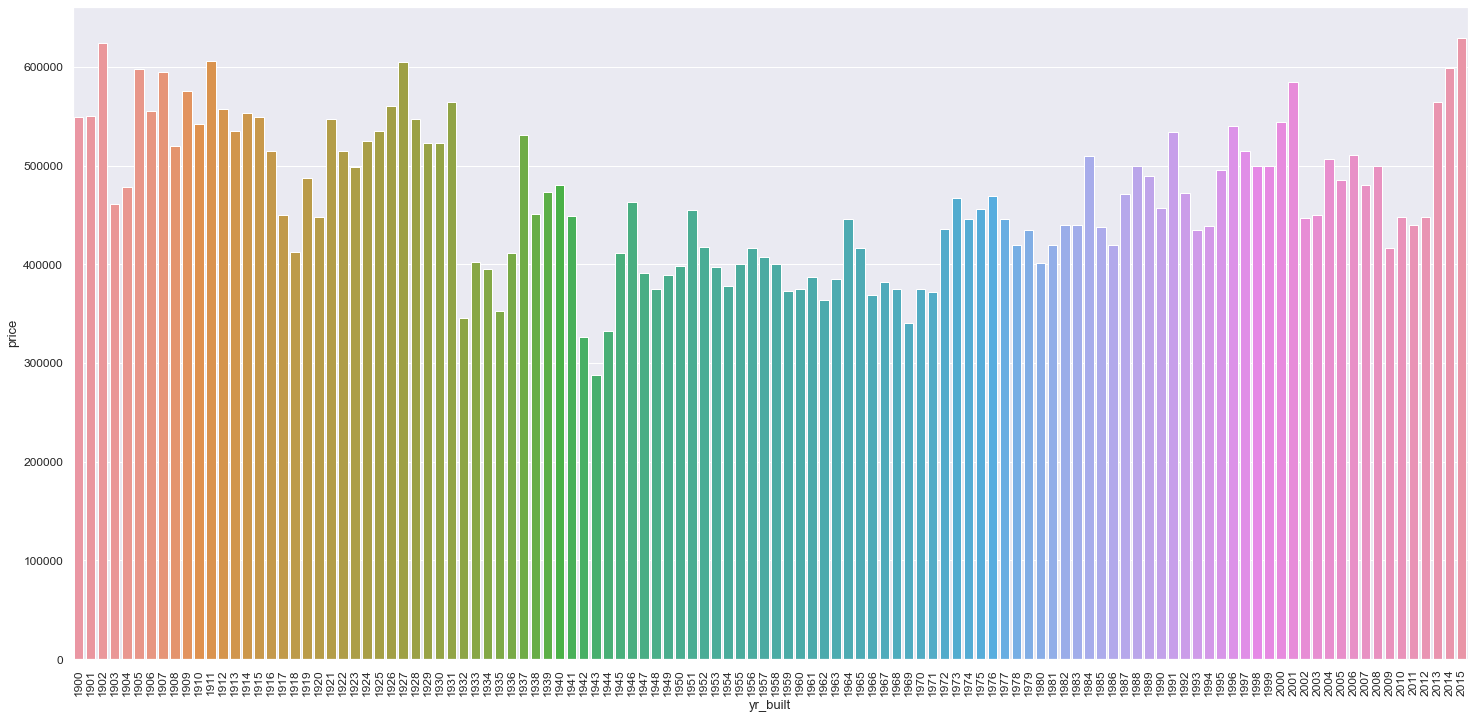

In [163]:
aux1 = df4[['yr_built', 'price']].groupby('yr_built').median().reset_index()
sns.barplot(data = aux1, x = 'yr_built', y = 'price');
plt.xticks( rotation = 'vertical');

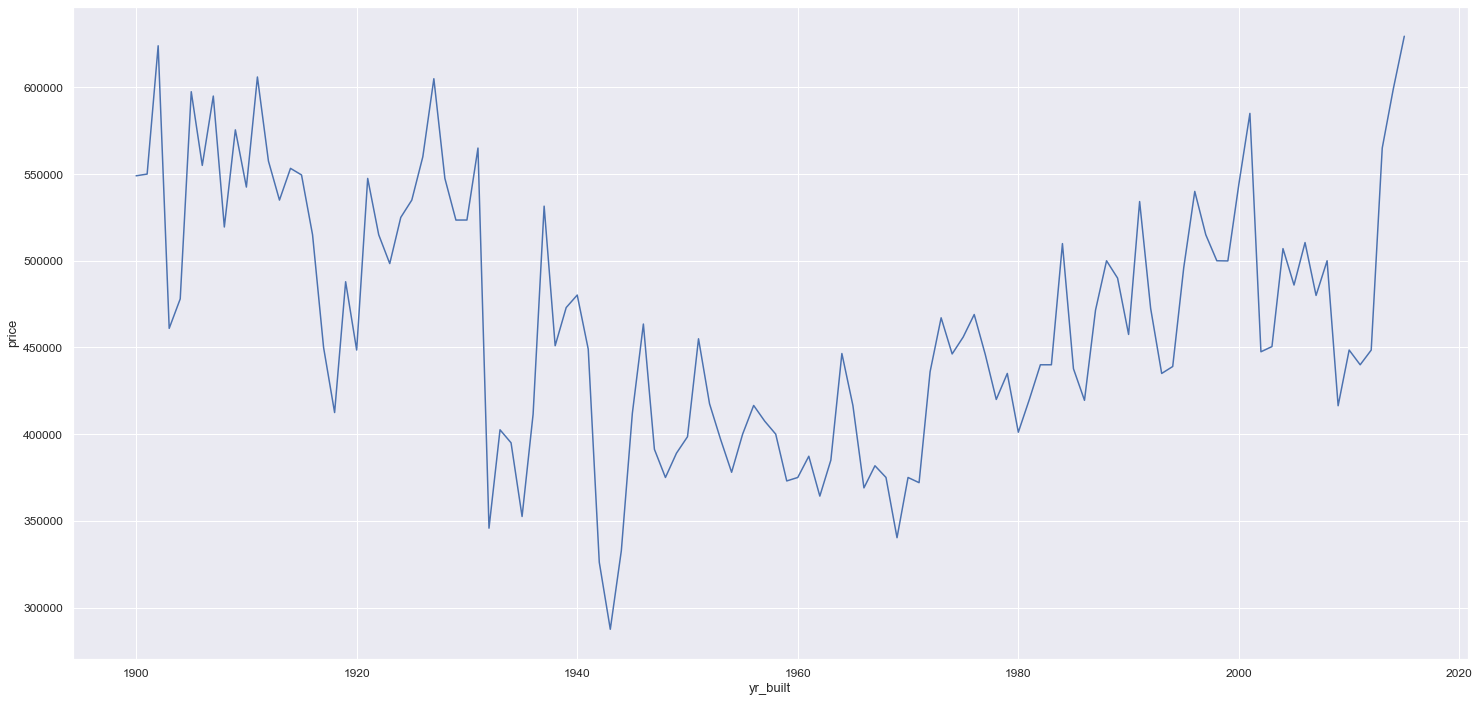

In [164]:
sns.lineplot(data = aux1, x = 'yr_built', y = 'price');

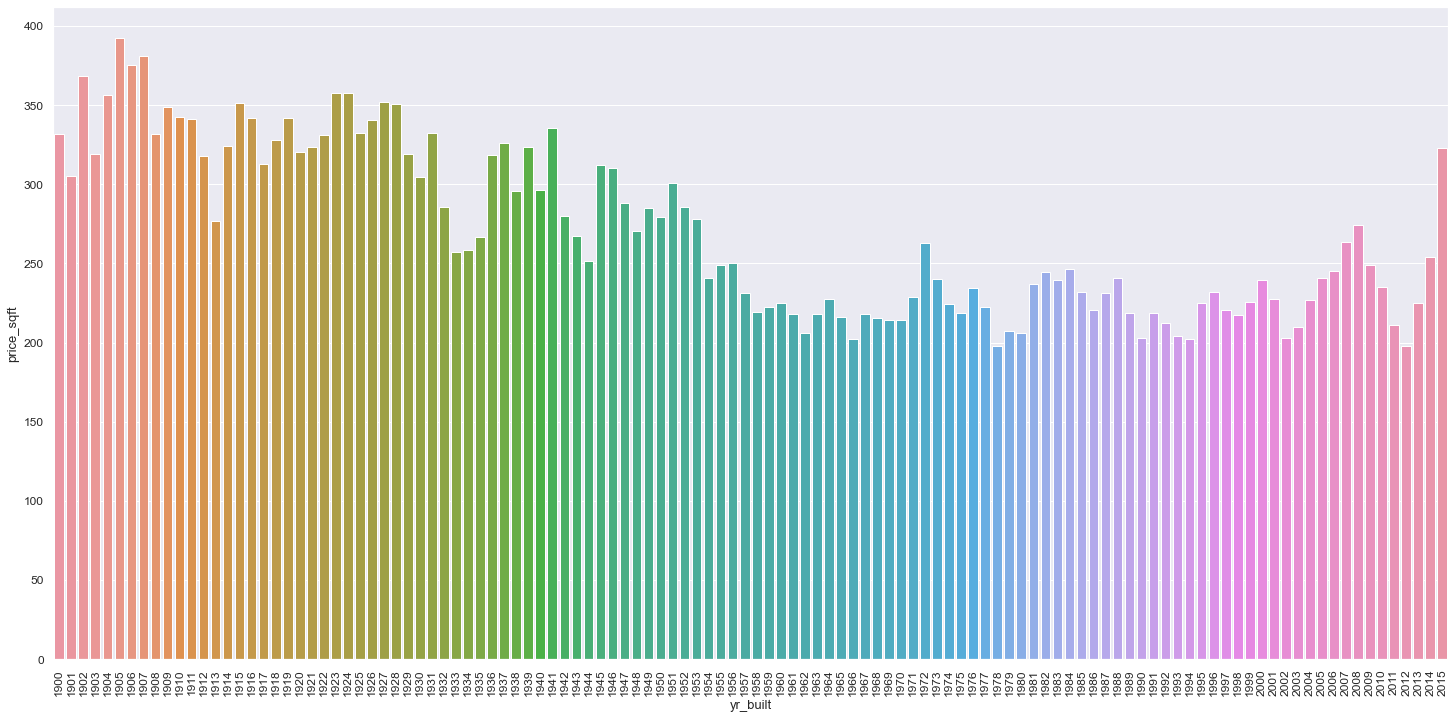

In [165]:
aux1 = df4[['yr_built', 'price_sqft']].groupby('yr_built').median().reset_index()
sns.barplot(data = aux1, x = 'yr_built', y = 'price_sqft');
plt.xticks( rotation = 'vertical');

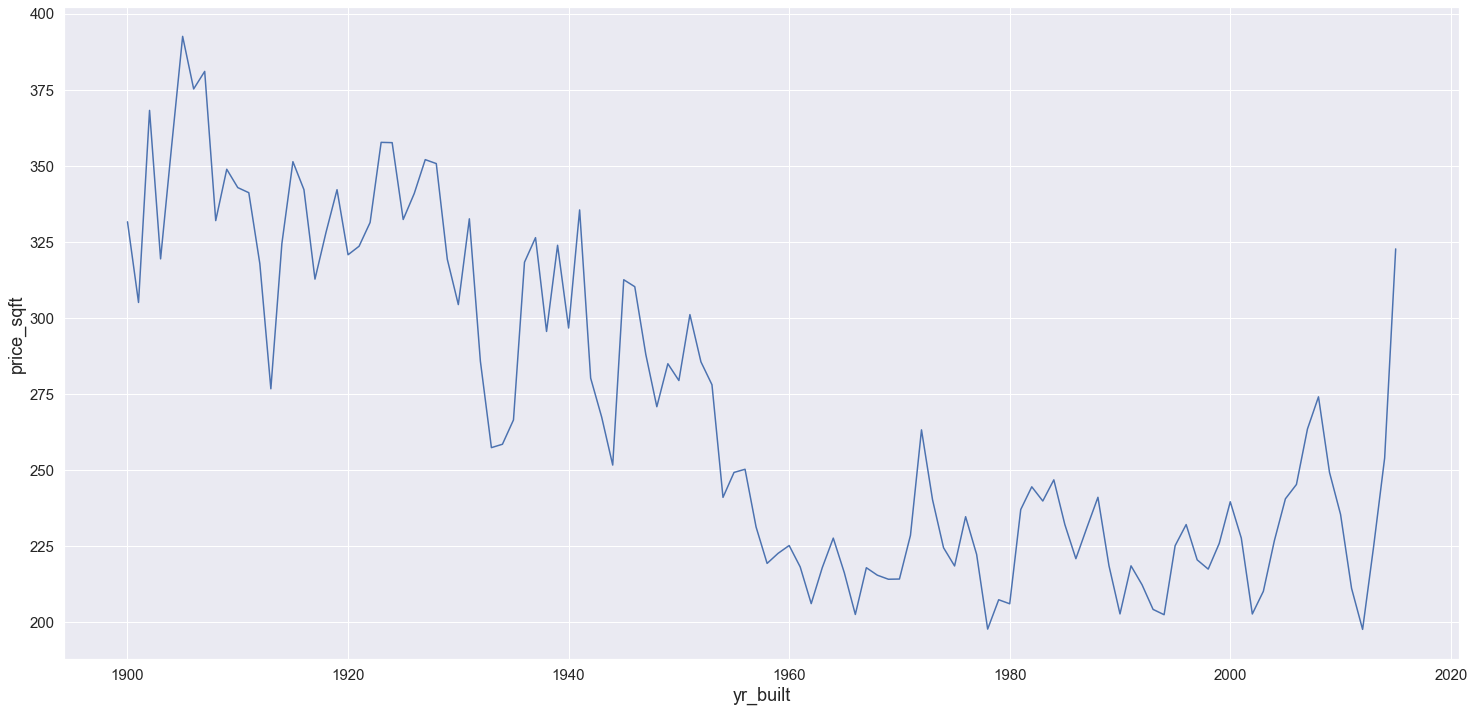

In [166]:
plt.rc('xtick', labelsize=15);
plt.rc('ytick', labelsize=15);
plt.rc('axes',  labelsize=18); 
sns.lineplot(data = aux1, x = 'yr_built', y = 'price_sqft');

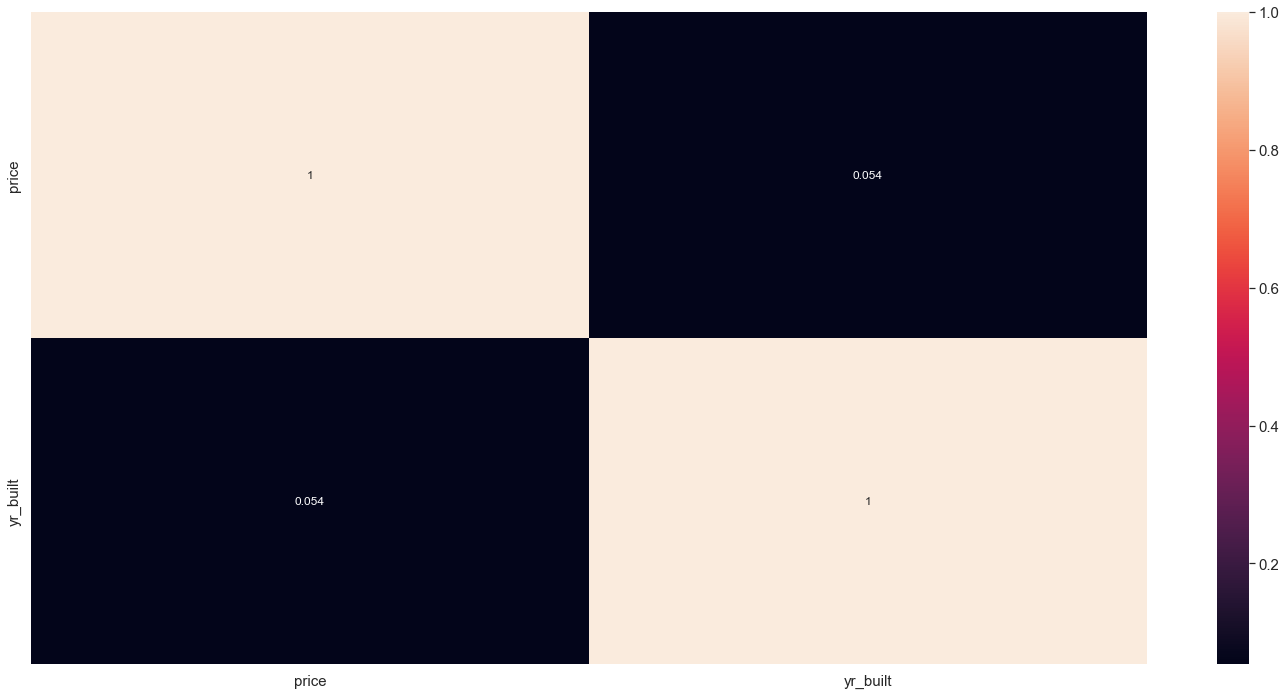

In [167]:
# correlacao com price
aux1 = df4[['price','yr_built']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 2.4.22 Hipótese 22: Imóveis vendidos no inverno possuem preços menores.
Hipótese verdadeira: Imóveis vendidos no inverno possuem preços menores.

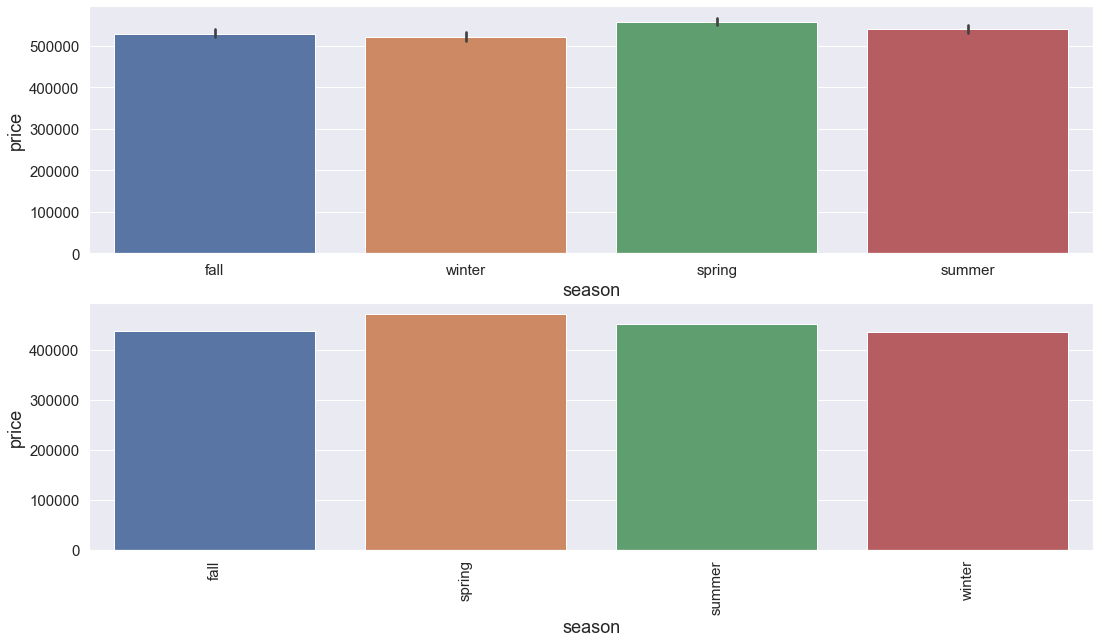

In [168]:
fig = plt.figure( figsize = (18,10) )
specs = gridspec.GridSpec( nrows = 2, ncols = 1, figure = fig )
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )

#média
sns.barplot(data = df4, x = 'season', y = 'price', ax = ax1);

#mediana
aux1 = df4[['season', 'price']].groupby('season').median().reset_index()
sns.barplot(data = aux1, x = 'season', y = 'price', ax = ax2);
plt.xticks( rotation = 'vertical');

### 4.2.23 Hipótese 23: Imóveis vendidos no final do mês tem preços menores.
Hipótese Falsa: Imóveis vendidos no final do mês não possuem preços de venda menores.

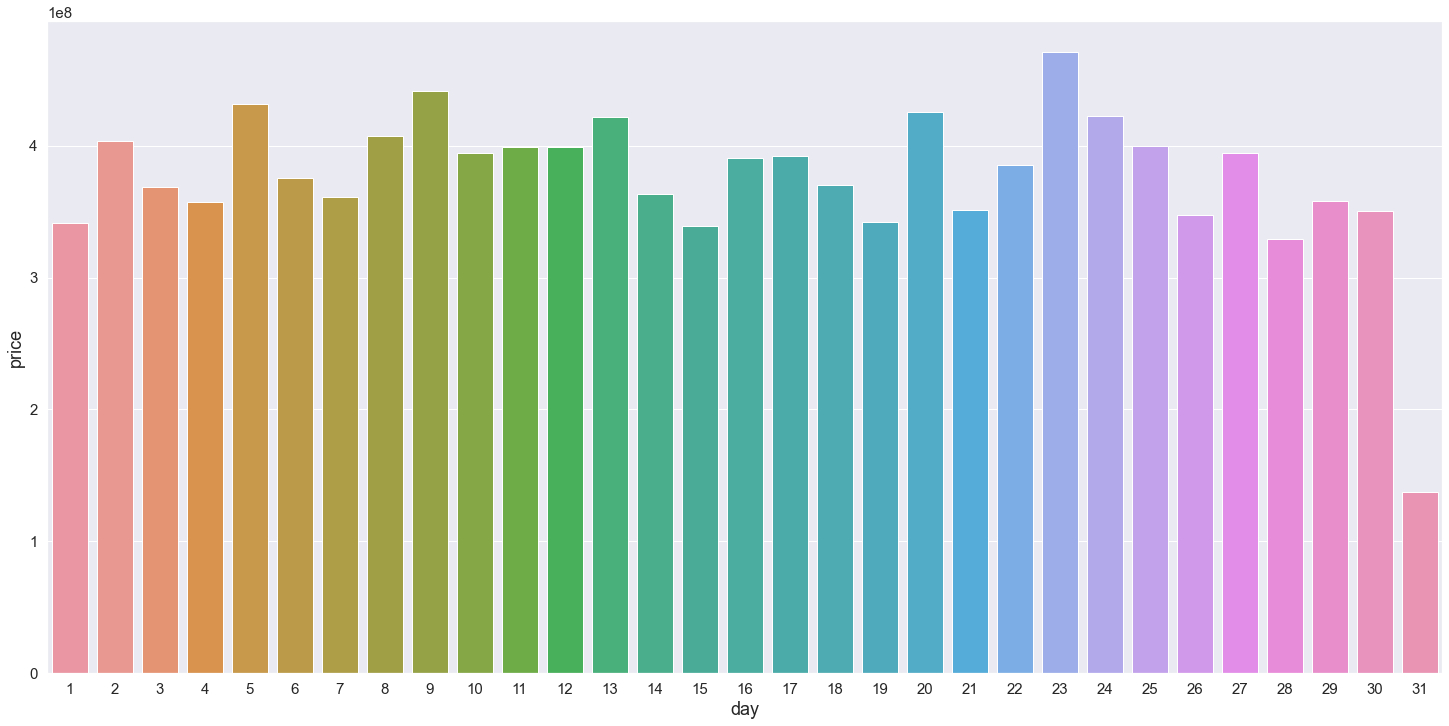

In [169]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=18) 
aux1 = df4[['day','price']].groupby('day').sum().reset_index()
sns.barplot( data = aux1, x = 'day', y = 'price');

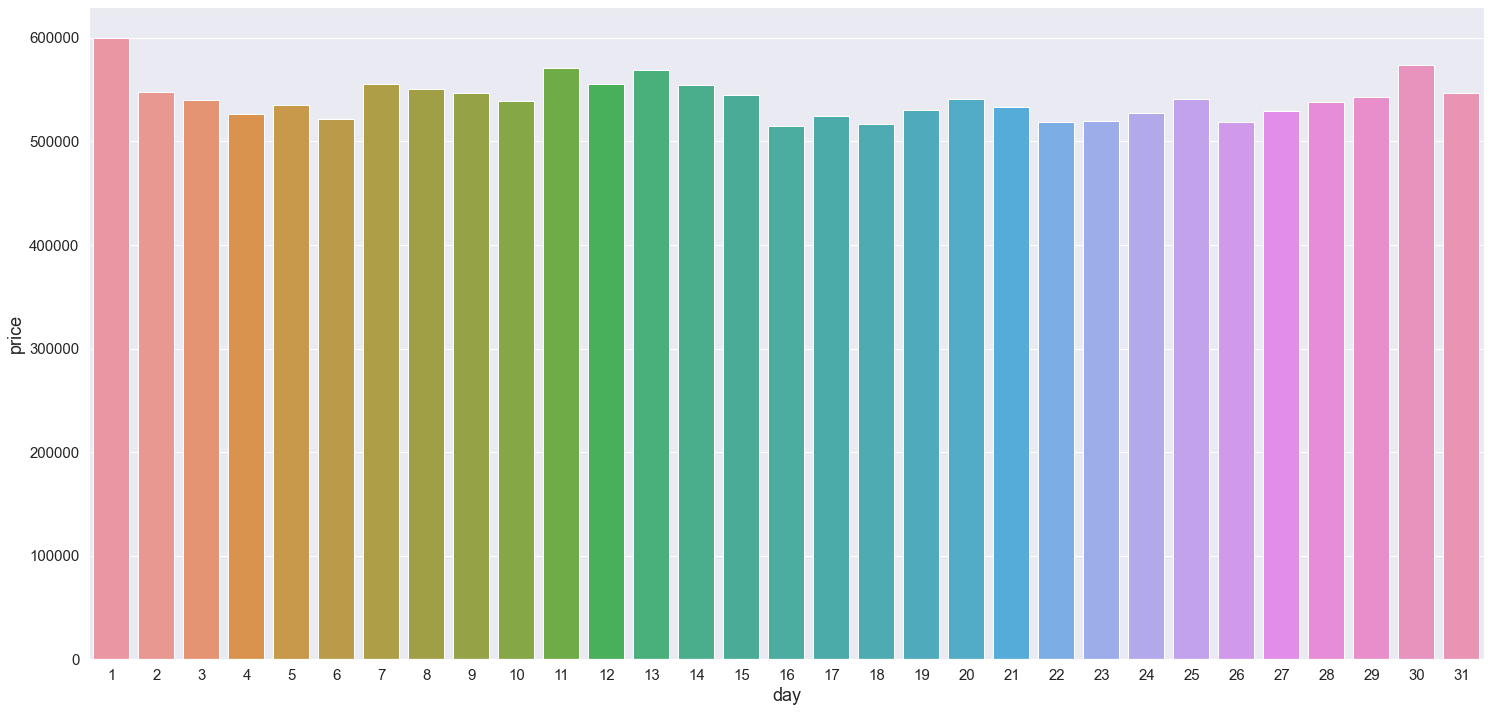

In [170]:
aux1 = df4[['day','price']].groupby('day').mean().reset_index()
sns.barplot( data = aux1, x = 'day', y = 'price');

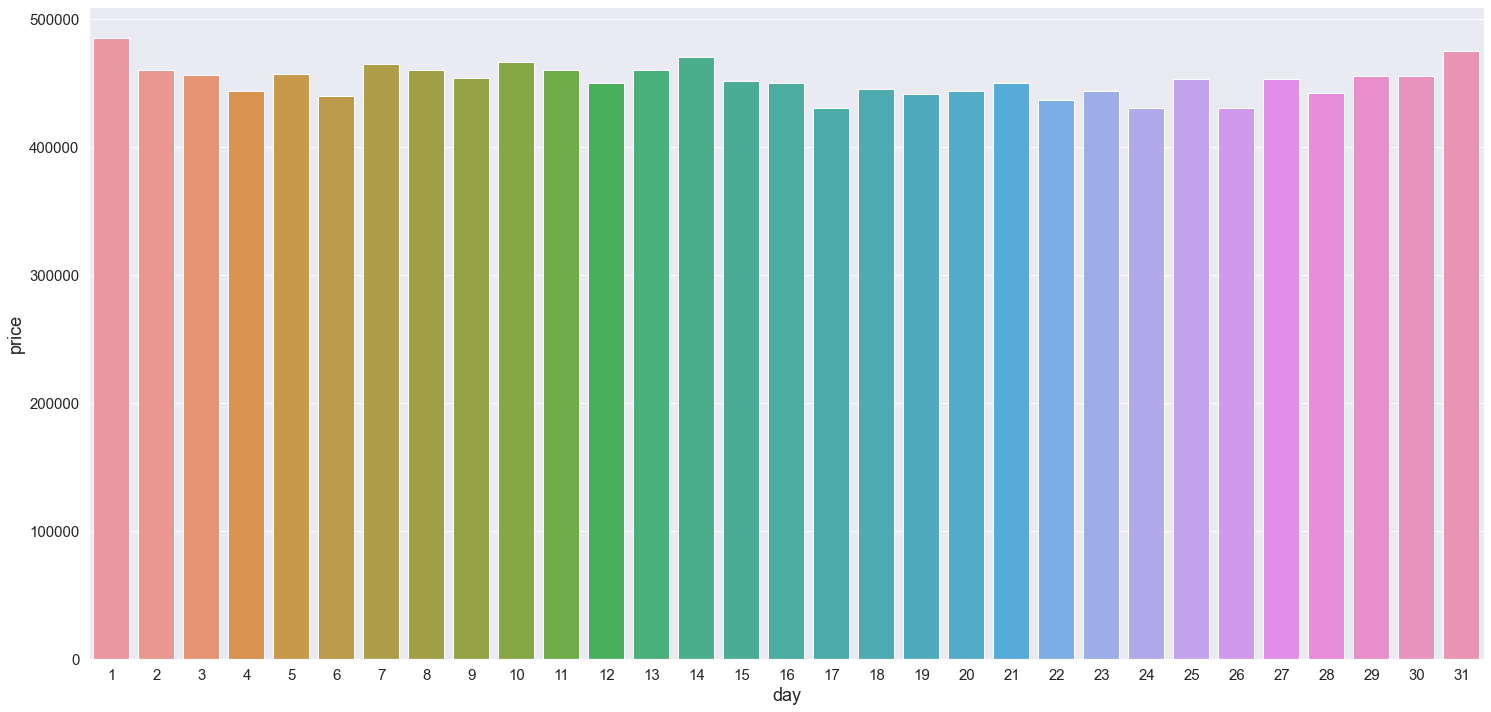

In [171]:
aux1 = df4[['day','price']].groupby('day').median().reset_index()
sns.barplot( data = aux1, x = 'day', y = 'price');

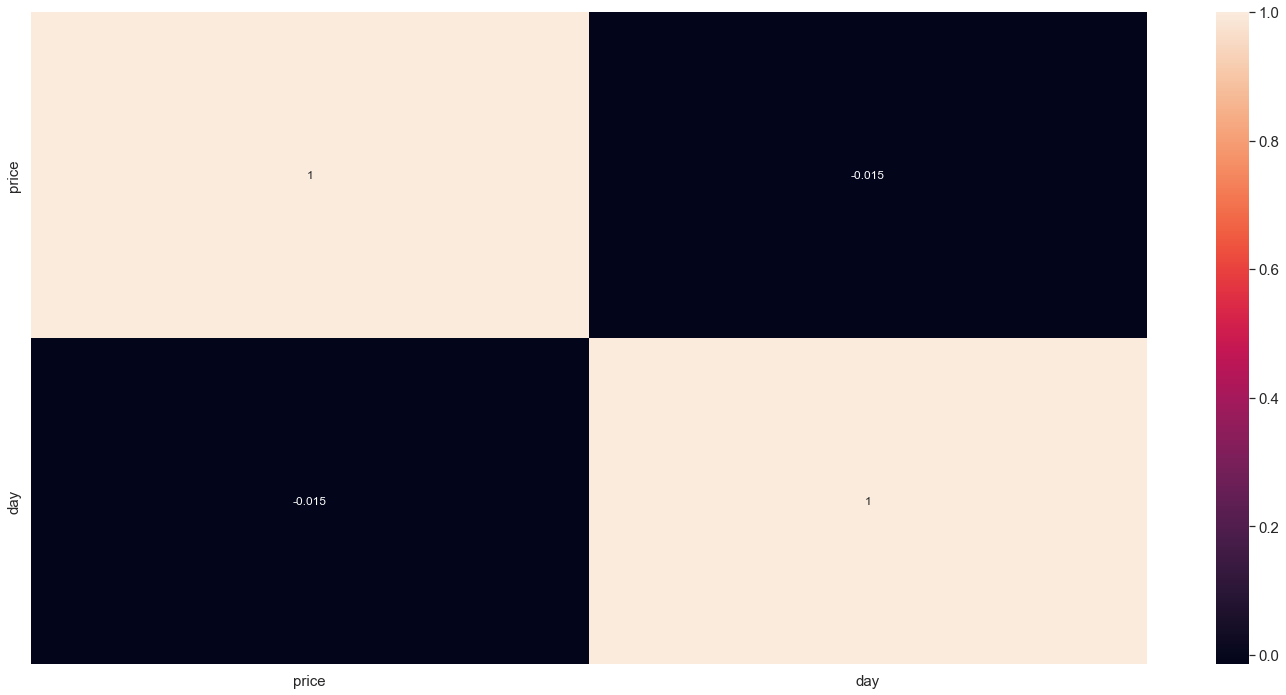

In [172]:
# correlacao com price
aux1 = df4[['price','day']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.24 Hipótese 24: Imóveis vendidos no ano de 2015 possuem preços maiores.
Hipótese Verdadeira: Imóveis vendidos no ano de 2015 possue preços de venda maiores.

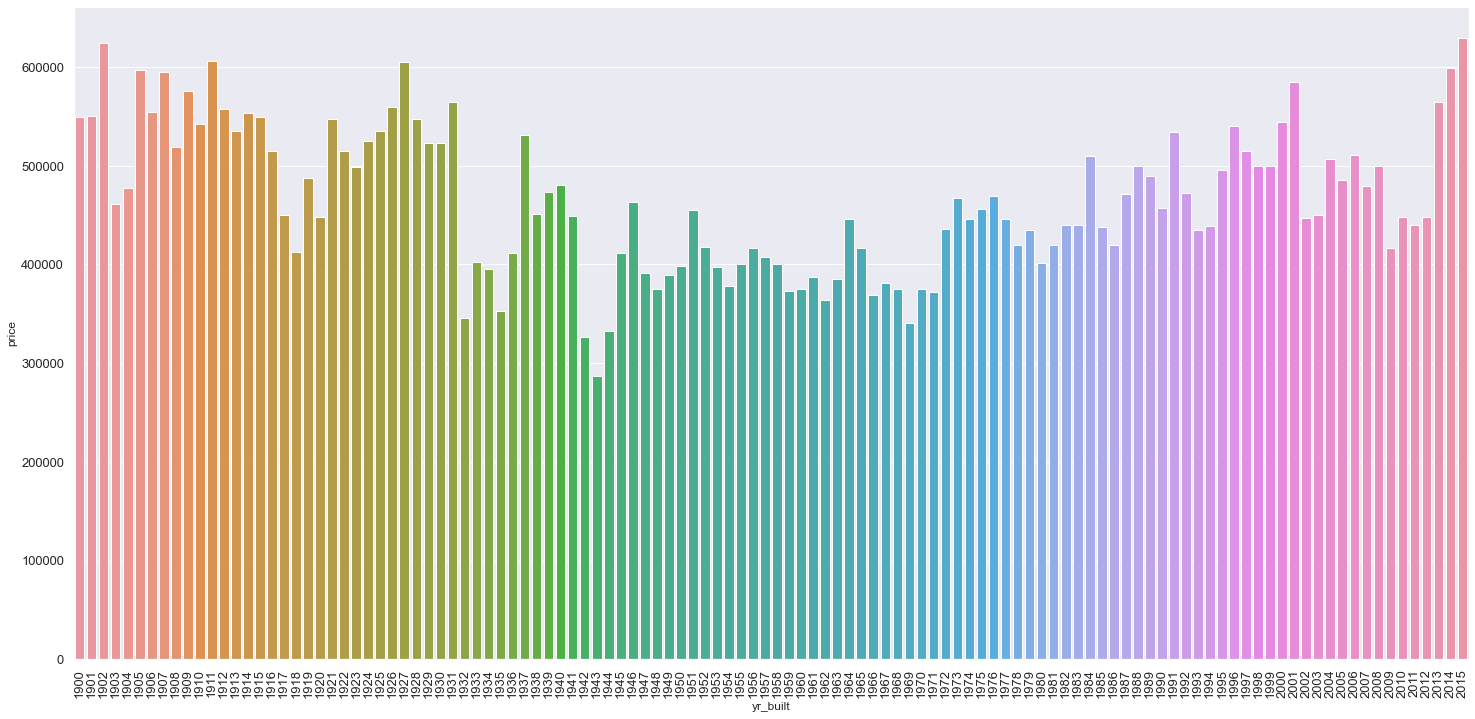

In [173]:
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes',  labelsize=12) 
aux1 = df4[['yr_built', 'price']].groupby('yr_built').median().reset_index()
sns.barplot(data = aux1, x = 'yr_built', y = 'price');
plt.xticks( rotation = 'vertical');

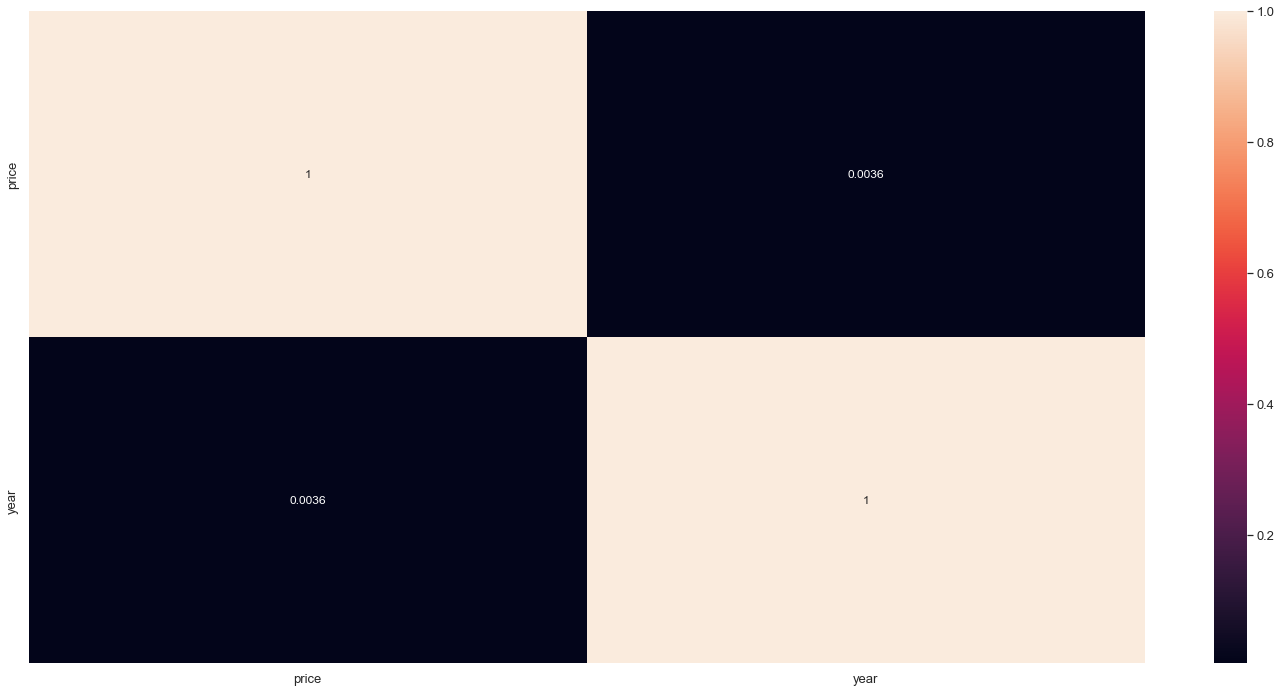

In [174]:
# correlacao com price
df4['year'] = df4['date'].dt.year
aux1 = df4[['price','year']]
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

### 4.2.25 Hipótese 25: Imóveis em melhores condições possuem preços maiores.
Hipótese Verdadeira: Imóveis em melhores condições possuem preços de venda maiores

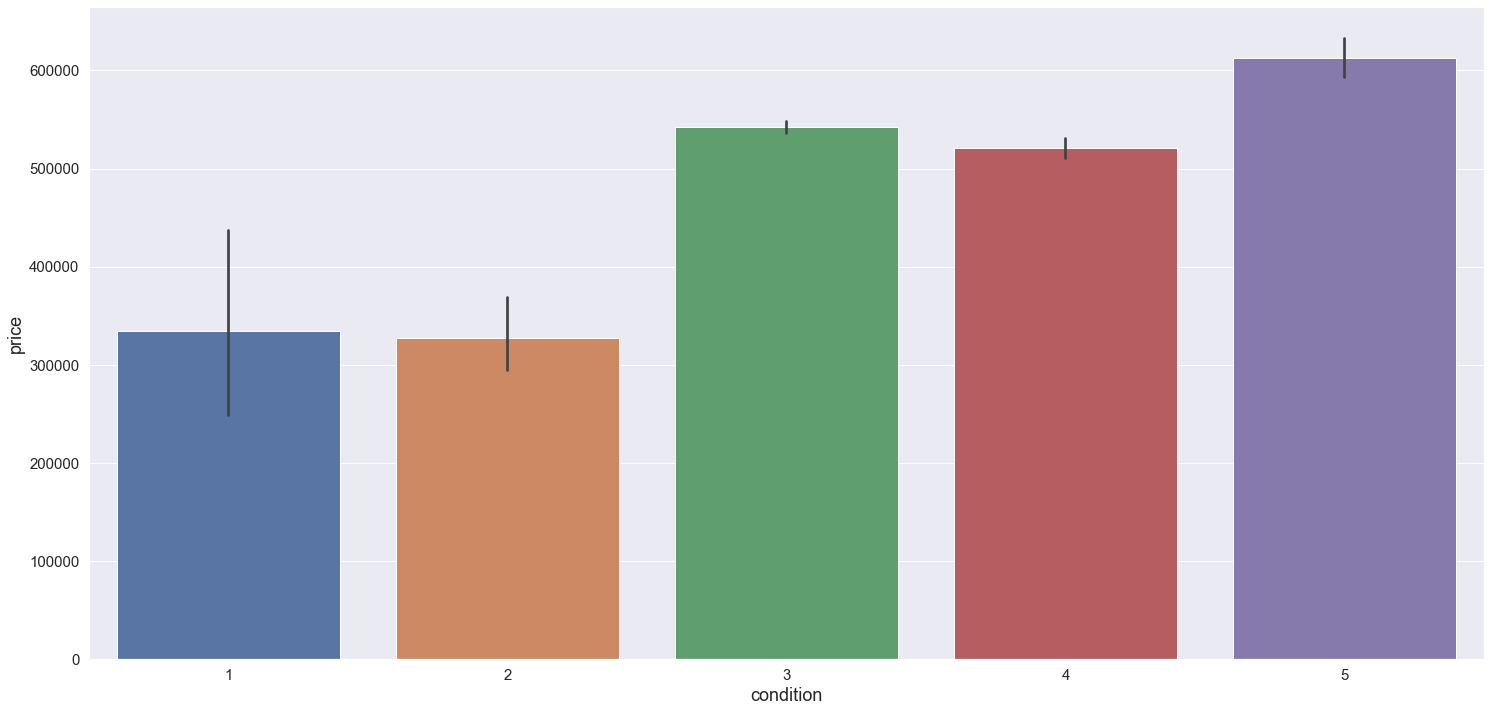

In [175]:
plt.rc('xtick', labelsize=15);
plt.rc('ytick', labelsize=15);
plt.rc('axes', labelsize=18);
sns.barplot(data = df4, x = 'condition', y = 'price');

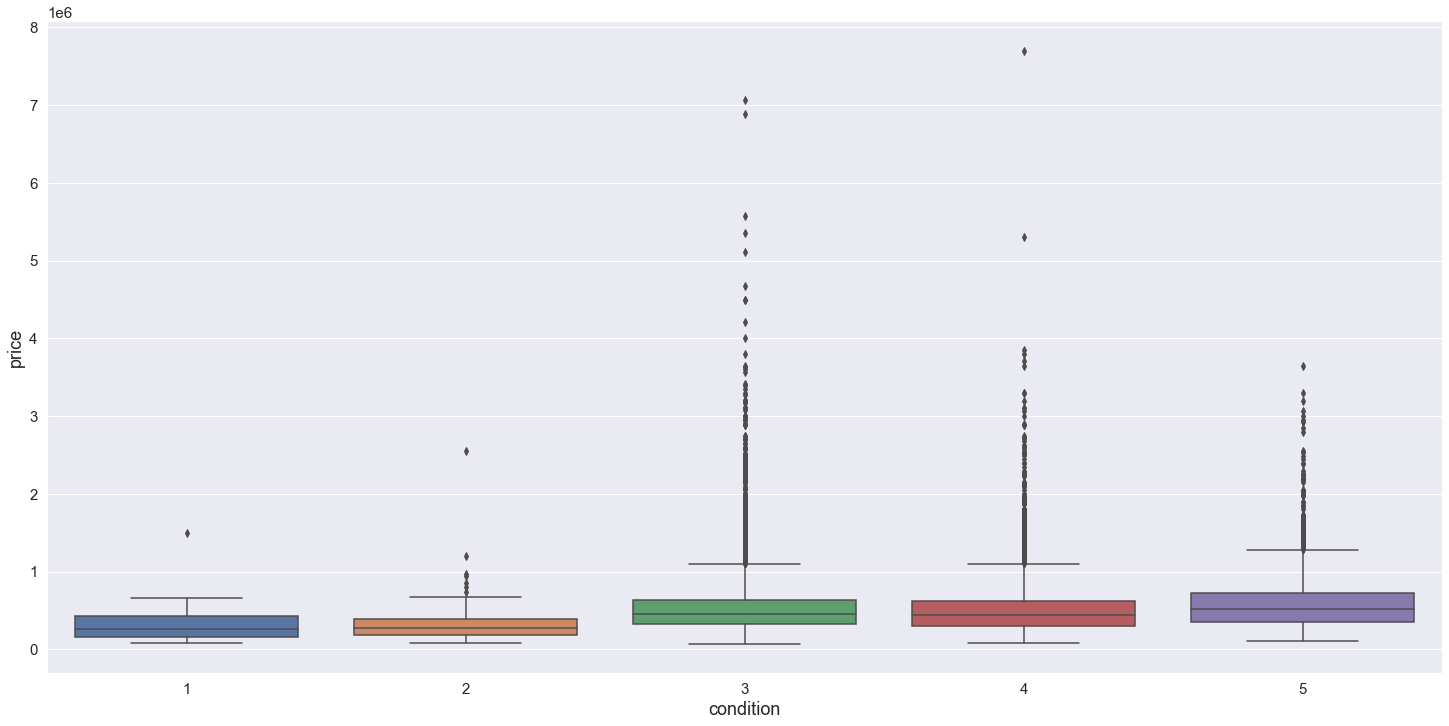

In [176]:
sns.boxplot(data = df4, x = 'condition', y = 'price');

### 4.2.26 Resumo Análise Bivariada

In [177]:
tab = [[ 'hipoteses', 'conclusao', 'relevancia' ],
       [ 'h1', 'verdadeira', 'alta'],
       [ 'h2', 'falsa', 'baixa'],
       [ 'h3', 'verdadeira', 'alta'],
       [ 'h4', 'verdadeira', 'baixa'],
       [ 'h5', 'verdadeira', 'media'],
       [ 'h6', 'verdadeira', 'media'],
       [ 'h7', 'verdadeira', 'media'],
       [ 'h8', 'verdadeira', 'baixa'],
       [ 'h9', 'verdadeira', 'alta'],
       [ 'h10', 'falsa', 'baixa'],
       [ 'h11', 'falsa', 'baixa'],
       [ 'h12', 'falsa', 'baixa'],
       [ 'h13', 'falsa', ''],
       [ 'h14', 'verdadeira', 'alta'],
       [ 'h15', 'falsa', 'alta'],
       [ 'h16', 'falsa', 'baixa'],
       [ 'h17', 'falsa', 'baixa'],
       [ 'h18', 'falsa', 'baixa'],
       [ 'h19', 'falsa', 'baixa'],
       [ 'h20', 'falsa', 'baixa'],
       [ 'h21', 'verdadeira', 'baixa'],
       [ 'h22', 'verdadeira', 'media'],
       [ 'h23', 'falsa', 'baixa'],
       [ 'h24', 'verdadeira', 'baixa'],
       [ 'h25', 'verdadeira', 'alta'] ]

print( tabulate( tab, headers = 'firstrow' ) )


hipoteses    conclusao    relevancia
-----------  -----------  ------------
h1           verdadeira   alta
h2           falsa        baixa
h3           verdadeira   alta
h4           verdadeira   baixa
h5           verdadeira   media
h6           verdadeira   media
h7           verdadeira   media
h8           verdadeira   baixa
h9           verdadeira   alta
h10          falsa        baixa
h11          falsa        baixa
h12          falsa        baixa
h13          falsa
h14          verdadeira   alta
h15          falsa        alta
h16          falsa        baixa
h17          falsa        baixa
h18          falsa        baixa
h19          falsa        baixa
h20          falsa        baixa
h21          verdadeira   baixa
h22          verdadeira   media
h23          falsa        baixa
h24          verdadeira   baixa
h25          verdadeira   alta


## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

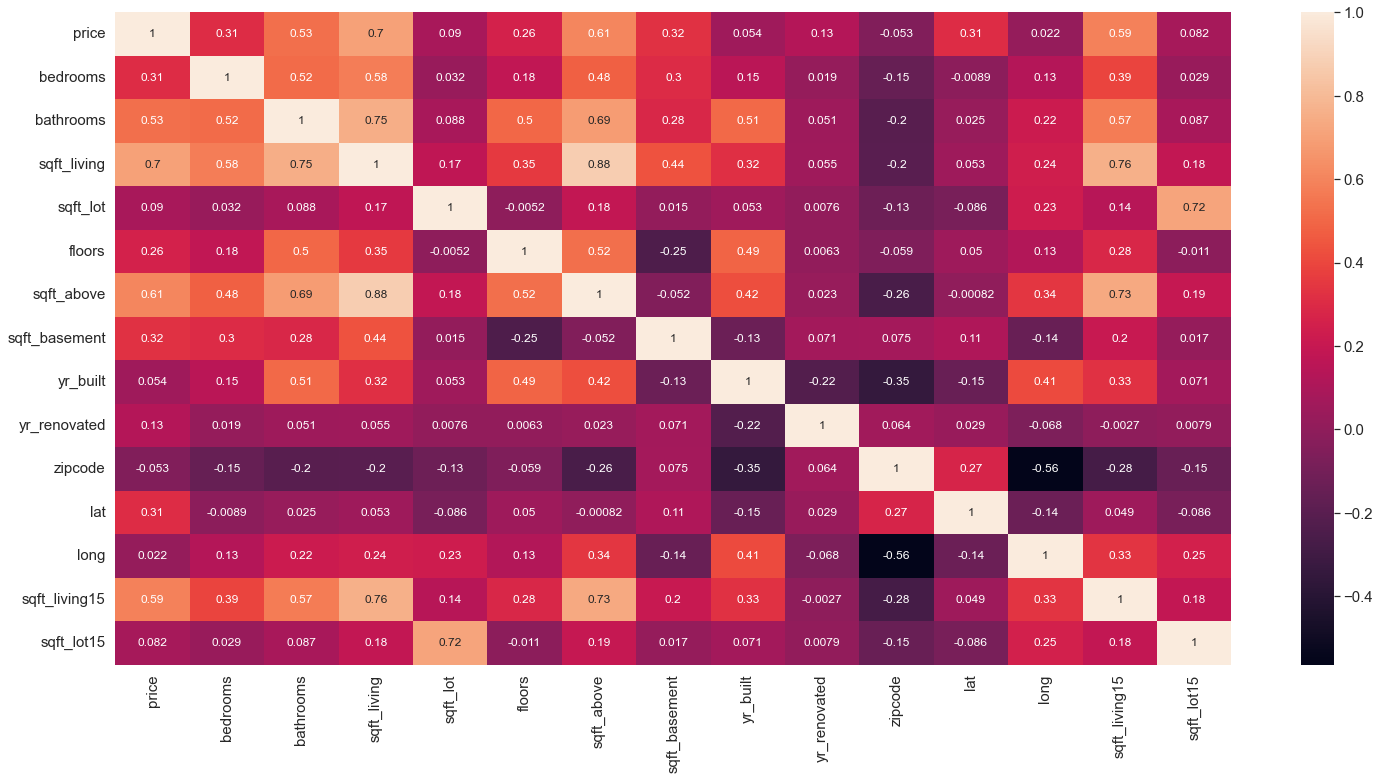

In [178]:
correlation = num_attributes.corr(method = 'pearson' )
sns.heatmap( correlation, annot = True);

### 4.3.2 Variáveis categoricas

In [179]:
cat_attributes.head()

waterfront  view  condition  grade zipcode  season       city  avenue  basement  sqft_living_compare  sqft_lot_compare
0           0     0          3      7   98178    fall    seattle       1         0                    0                 0
1           0     0          3      7   98125    fall    seattle       0         1                    1                 0
2           0     0          3      6   98028  winter    kenmore       1         0                    0                 1
3           0     0          5      7   98136    fall    seattle       0         1                    1                 0
4           0     0          3      8   98074  winter  sammamish       1         0                    0                 1

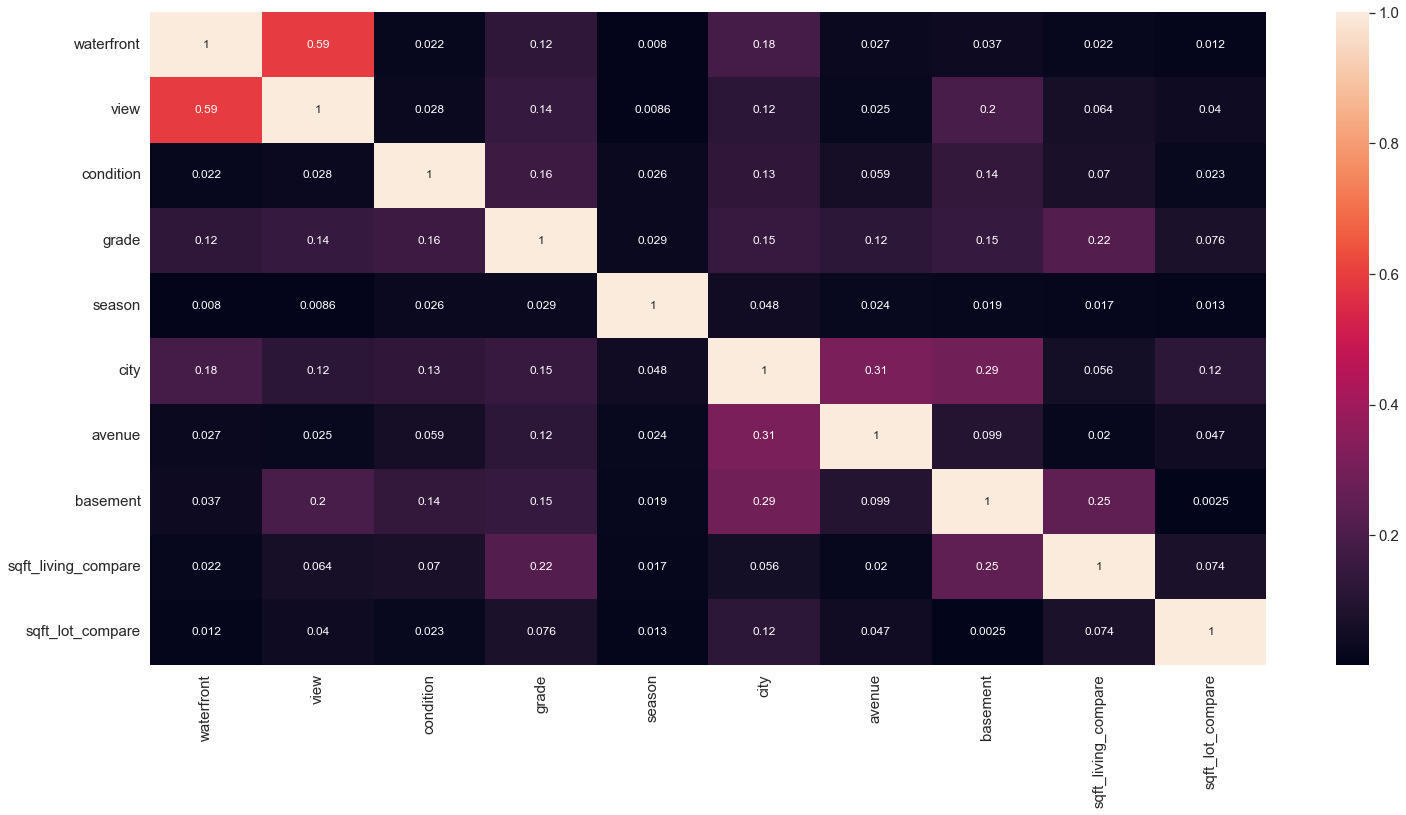

In [180]:
a = cat_attributes.copy()

#waterfront
a1 = cramer_v( a['waterfront'], a['waterfront'] )
a2 = cramer_v( a['waterfront'], a['view'])
a3 = cramer_v( a['waterfront'], a['condition' ] )
a4 = cramer_v( a['waterfront'], a['grade' ] )
a5 = cramer_v( a['waterfront'], a['season'] )
a6 = cramer_v( a['waterfront'], a['city' ] )
a7 = cramer_v( a['waterfront'], a['avenue' ] )
a8 = cramer_v( a['waterfront'], a['basement' ] )
a9 = cramer_v( a['waterfront'], a['sqft_living_compare' ] )
a10 = cramer_v( a['waterfront'], a['sqft_lot_compare' ] )

#view
a11 = cramer_v( a['view'], a['waterfront'] )
a12 = cramer_v( a['view'], a['view'])
a13 = cramer_v( a['view'], a['condition' ] )
a14 = cramer_v( a['view'], a['grade' ] )
a15 = cramer_v( a['view'], a['season'] )
a16 = cramer_v( a['view'], a['city' ] )
a17 = cramer_v( a['view'], a['avenue' ] )
a18 = cramer_v( a['view'], a['basement' ] )
a19 = cramer_v( a['view'], a['sqft_living_compare' ] )
a20 = cramer_v( a['view'], a['sqft_lot_compare' ] )

#condition
a21 = cramer_v( a['condition'], a['waterfront'] )
a22 = cramer_v( a['condition'], a['view'])
a23 = cramer_v( a['condition'], a['condition' ] )
a24 = cramer_v( a['condition'], a['grade' ] )
a25 = cramer_v( a['condition'], a['season'] )
a26 = cramer_v( a['condition'], a['city' ] )
a27 = cramer_v( a['condition'], a['avenue' ] )
a28 = cramer_v( a['condition'], a['basement' ] )
a29 = cramer_v( a['condition'], a['sqft_living_compare' ] )
a30 = cramer_v( a['condition'], a['sqft_lot_compare' ] )

#grade
a31 = cramer_v( a['grade'], a['waterfront'] )
a32 = cramer_v( a['grade'], a['view'])
a33 = cramer_v( a['grade'], a['condition' ] )
a34 = cramer_v( a['grade'], a['grade' ] )
a35 = cramer_v( a['grade'], a['season'] )
a36 = cramer_v( a['grade'], a['city' ] )
a37 = cramer_v( a['grade'], a['avenue' ] )
a38 = cramer_v( a['grade'], a['basement' ] )
a39 = cramer_v( a['grade'], a['sqft_living_compare' ] )
a40 = cramer_v( a['grade'], a['sqft_lot_compare' ] )

#season
a41 = cramer_v( a['season'], a['waterfront'] )
a42 = cramer_v( a['season'], a['view'])
a43 = cramer_v( a['season'], a['condition' ] )
a44 = cramer_v( a['season'], a['grade' ] )
a45 = cramer_v( a['season'], a['season'] )
a46 = cramer_v( a['season'], a['city' ] )
a47 = cramer_v( a['season'], a['avenue' ] )
a48 = cramer_v( a['season'], a['basement' ] )
a49 = cramer_v( a['season'], a['sqft_living_compare' ] )
a50 = cramer_v( a['season'], a['sqft_lot_compare' ] )

#city
a51 = cramer_v( a['city'], a['waterfront'] )
a52 = cramer_v( a['city'], a['view'])
a53 = cramer_v( a['city'], a['condition' ] )
a54 = cramer_v( a['city'], a['grade' ] )
a55 = cramer_v( a['city'], a['season'] )
a56 = cramer_v( a['city'], a['city' ] )
a57 = cramer_v( a['city'], a['avenue' ] )
a58 = cramer_v( a['city'], a['basement' ] )
a59 = cramer_v( a['city'], a['sqft_living_compare' ] )
a60 = cramer_v( a['city'], a['sqft_lot_compare' ] )

#avenue
a61 = cramer_v( a['avenue'], a['waterfront'] )
a62 = cramer_v( a['avenue'], a['view'])
a63 = cramer_v( a['avenue'], a['condition' ] )
a64 = cramer_v( a['avenue'], a['grade' ] )
a65 = cramer_v( a['avenue'], a['season'] )
a66 = cramer_v( a['avenue'], a['city' ] )
a67 = cramer_v( a['avenue'], a['avenue' ] )
a68 = cramer_v( a['avenue'], a['basement' ] )
a69 = cramer_v( a['avenue'], a['sqft_living_compare' ] )
a70 = cramer_v( a['avenue'], a['sqft_lot_compare' ] )

#avenue
a71 = cramer_v( a['basement'], a['waterfront'] )
a72 = cramer_v( a['basement'], a['view'])
a73 = cramer_v( a['basement'], a['condition' ] )
a74 = cramer_v( a['basement'], a['grade' ] )
a75 = cramer_v( a['basement'], a['season'] )
a76 = cramer_v( a['basement'], a['city' ] )
a77 = cramer_v( a['basement'], a['avenue' ] )
a78 = cramer_v( a['basement'], a['basement' ] )
a79 = cramer_v( a['basement'], a['sqft_living_compare' ] )
a80 = cramer_v( a['basement'], a['sqft_lot_compare' ] )

#sqft_living_compare
a81 = cramer_v( a['sqft_living_compare'], a['waterfront'] )
a82 = cramer_v( a['sqft_living_compare'], a['view'])
a83 = cramer_v( a['sqft_living_compare'], a['condition' ] )
a84 = cramer_v( a['sqft_living_compare'], a['grade' ] )
a85 = cramer_v( a['sqft_living_compare'], a['season'] )
a86 = cramer_v( a['sqft_living_compare'], a['city' ] )
a87 = cramer_v( a['sqft_living_compare'], a['avenue' ] )
a88 = cramer_v( a['sqft_living_compare'], a['basement' ] )
a89 = cramer_v( a['sqft_living_compare'], a['sqft_living_compare' ] )
a90 = cramer_v( a['sqft_living_compare'], a['sqft_lot_compare' ] )

#sqft_living_compare
a91 = cramer_v( a['sqft_lot_compare'], a['waterfront'] )
a92 = cramer_v( a['sqft_lot_compare'], a['view'])
a93 = cramer_v( a['sqft_lot_compare'], a['condition' ] )
a94 = cramer_v( a['sqft_lot_compare'], a['grade' ] )
a95 = cramer_v( a['sqft_lot_compare'], a['season'] )
a96 = cramer_v( a['sqft_lot_compare'], a['city' ] )
a97 = cramer_v( a['sqft_lot_compare'], a['avenue' ] )
a98 = cramer_v( a['sqft_lot_compare'], a['basement' ] )
a99 = cramer_v( a['sqft_lot_compare'], a['sqft_living_compare' ] )
a100 = cramer_v( a['sqft_lot_compare'], a['sqft_lot_compare' ] )

aux1 = pd.DataFrame( {'waterfront'          : [ a1 ,a2 ,a3 ,a4 ,a5 ,a6 ,a7 ,a8 ,a9, a10],
                      'view'                : [ a11,a12,a13,a14,a15,a16,a17,a18,a19,a20          ],
                      'condition'           : [ a21 ,a22 ,a23 ,a24 ,a25 ,a26 ,a27 ,a28 ,a29 ,a30 ],
                      'grade'               : [ a31 ,a32 ,a33 ,a34 ,a35 ,a36 ,a37 ,a38 ,a39 ,a40 ],
                      'season'              : [ a41 ,a42 ,a43 ,a44 ,a45 ,a46 ,a47 ,a48 ,a49 ,a50 ],
                      'city'                : [ a51 ,a52 ,a53 ,a54 ,a55 ,a56 ,a57 ,a58 ,a59 ,a60 ],
                      'avenue'              : [ a61 ,a62 ,a63 ,a64 ,a65 ,a66 ,a67 ,a68 ,a69 ,a70 ],
                      'basement'            : [ a71 ,a72 ,a73 ,a74 ,a75 ,a76 ,a77 ,a78 ,a79 ,a80 ],
                      'sqft_living_compare' : [ a81 ,a82 ,a83 ,a84 ,a85 ,a86 ,a87 ,a88 ,a89 ,a90 ],
                      'sqft_lot_compare'    : [ a91 ,a92 ,a93 ,a94 ,a95 ,a96 ,a97 ,a98 ,a99 ,a100] } )

aux1 = aux1.set_index(aux1.columns )

sns.heatmap( aux1, annot = True );

# 5.0 Preparação dos Dados

In [181]:
df5 = df4.copy()
df5.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated zipcode   lat    long  sqft_living15  sqft_lot15  basement  price_sqft  year  month  day  season  sqft_living_compare  sqft_lot_compare       city  avenue
0  7129300520 2014-10-13 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0   98178 47.51 -122.26           1340        5650         0      188.05  2014     10   13    fall                    0                 0    seattle       1
1  6414100192 2014-12-09 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991   98125 47.72 -122.32           1690        7639         1      209.34  2014     12    9    fall                    1                 0    seattle       0
2  5631500400 2015-02-25 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0   98028 47.74 -122.23           2720        8062         0      233.77  2015      2   25  winter                    0                 1    kenmore       1
3  2487200875 2014-12-09 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0   98136 47.52 -122.39           1360        5000         1      308.16  2014     12    9    fall                    1                 0    seattle       0
4  1954400510 2015-02-18 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0   98074 47.62 -122.05           1800        7503         0      303.57  2015      2   18  winter                    0                 1  sammamish       1

## 5.1 Variáveis Numericas

### 5.1.1 Normalização

In [182]:
#Não há variáveis com características de distribuição normal 

### 5.1.2 Rescaling

In [183]:
# variáveis selecionadas
#     bedrooms, bathrooms, floors, yr_built, year

#instanciar
mms = MinMaxScaler()

df5['bedrooms']  = mms.fit_transform( df5[ ['bedrooms'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/bedrooms_scaler.pkl','wb' ) )

df5['bathrooms'] = mms.fit_transform( df5[ [ 'bathrooms'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/bathrooms_scaler.pkl','wb' ) )

df5['floors']    = mms.fit_transform( df5[ [ 'floors'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/floors_scaler.pkl','wb' ) )

df5['yr_built']  = mms.fit_transform( df5[ [ 'yr_built'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/yr_built_scaler.pkl','wb' ) )

df5['year']  = mms.fit_transform( df5[ [ 'year'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/year_scaler.pkl','wb' ) )

df5['lat']  = mms.fit_transform( df5[ [ 'lat'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/lat_scaler.pkl','wb' ) )

df5['long']  = mms.fit_transform( df5[ [ 'long'] ].values )
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/kc_house/parameters/long_scaler.pkl','wb' ) )

### 5.1.2 Robust Scaler

In [184]:
# variáveis selecionadas
#     sqft_living, sqft_lot, sqft_above, sqft_basement, yr_renovated,sqft_living15,sqft_lot15

#instanciar
rs = RobustScaler()

df5['sqft_living']   = rs.fit_transform( df5[ ['sqft_living'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/sqft_living_scaler.pkl','wb' ) )

df5['sqft_lot']      = rs.fit_transform( df5[ [ 'sqft_lot'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/sqft_lot_scaler.pkl','wb' ) )

df5['sqft_above']    = rs.fit_transform( df5[ [ 'sqft_above'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/sqft_above_scaler.pkl','wb' ) )

df5['sqft_basement'] = rs.fit_transform( df5[ [ 'sqft_basement'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/sqft_basement_scaler.pkl','wb' ) )

df5['yr_renovated']  = rs.fit_transform( df5[ [ 'yr_renovated'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/yr_renovated_scaler.pkl','wb' ) )

df5['sqft_living15'] = rs.fit_transform( df5[ ['sqft_living15'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/sqft_living15_scaler.pkl','wb' ) )

df5['sqft_lot15']    = rs.fit_transform( df5[ [ 'sqft_lot15'] ].values )
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/kc_house/parameters/sqft_lot15_scaler.pkl','wb' ) )

## 5.2 Variáveis Categoricas - Encoding

In [185]:
cat_attributes.sample()

waterfront  view  condition  grade zipcode  season      city  avenue  basement  sqft_living_compare  sqft_lot_compare
19103           0     0          4      7   98005  winter  bellevue       0         0                    0                 1

In [186]:
# One Hot Encoding
#     waterfront, avenue, basement, sqft_living_compare, sqft_living_compare 

In [187]:
# Ordinal Enconding
#     view, condition, grade

In [188]:
# Season e zipcode - Label Enconding
le = LabelEncoder()
df5['season'] = le.fit_transform( df5['season'] )
pickle.dump( le, open( '/home/deivison/Documentos/projetos/kc_house/parameters/season_scaler.pkl','wb' ) )

df5['zipcode'] = le.fit_transform( df5['zipcode'] )
pickle.dump( le, open( '/home/deivison/Documentos/projetos/kc_house/parameters/zipcode_scaler.pkl','wb' ) )

In [189]:
#Frequency enconding

In [190]:
city_freq = {'seattle'      :percentage_pandas(( df5.loc[ df5['city'] == 'seattle' ]       ), df5['city'] ),
             'kenmore'      :percentage_pandas(( df5.loc[ df5['city'] == 'kenmore' ]       ), df5['city'] ),
             'sammamish'    :percentage_pandas(( df5.loc[ df5['city'] == 'sammamish' ]     ), df5['city'] ),
             'redmond'      :percentage_pandas(( df5.loc[ df5['city'] == 'redmond' ]       ), df5['city'] ),
             'federal_way'  :percentage_pandas(( df5.loc[ df5['city'] == 'federal_way' ]   ), df5['city'] ),
             'maple_valley' :percentage_pandas(( df5.loc[ df5['city'] == 'maple_valley' ]  ), df5['city'] ),
             'bellevue'     :percentage_pandas(( df5.loc[ df5['city'] == 'bellevue' ]      ), df5['city'] ),
             'duvall'       :percentage_pandas(( df5.loc[ df5['city'] == 'duvall' ]        ), df5['city'] ),
             'auburn'       :percentage_pandas(( df5.loc[ df5['city'] == 'auburn' ]        ), df5['city'] ),
             'mercer_island':percentage_pandas(( df5.loc[ df5['city'] == 'mercer_island' ] ), df5['city'] ),
             'kent'         :percentage_pandas(( df5.loc[ df5['city'] == 'kent' ]          ), df5['city'] ),
             'issaquah'     :percentage_pandas(( df5.loc[ df5['city'] == 'issaquah' ]      ), df5['city'] ),
             'renton'       :percentage_pandas(( df5.loc[ df5['city'] == 'renton' ]        ), df5['city'] ),
             'vashon'       :percentage_pandas(( df5.loc[ df5['city'] == 'vashon' ]        ), df5['city'] ),
             'kirkland'     :percentage_pandas(( df5.loc[ df5['city'] == 'kirkland' ]      ), df5['city'] ),
             'black_diamond':percentage_pandas(( df5.loc[ df5['city'] == 'black_diamond' ] ), df5['city'] ),
             'north_bend'   :percentage_pandas(( df5.loc[ df5['city'] == 'north_bend' ]    ), df5['city'] ),
             'woodinville'  :percentage_pandas(( df5.loc[ df5['city'] == 'woodinville' ]   ), df5['city'] ),
             'snoqualmie'   :percentage_pandas(( df5.loc[ df5['city'] == 'snoqualmie' ]    ), df5['city'] ),
             'enumclaw'     :percentage_pandas(( df5.loc[ df5['city'] == 'enumclaw' ]      ), df5['city'] ),
             'fall_city'    :percentage_pandas(( df5.loc[ df5['city'] == 'fall_city' ]     ), df5['city'] ),
             'bothell'      :percentage_pandas(( df5.loc[ df5['city'] == 'bothell' ]       ), df5['city'] ),
             'carnation'    :percentage_pandas(( df5.loc[ df5['city'] == 'carnation' ]     ), df5['city'] ),
             'medina'       :percentage_pandas(( df5.loc[ df5['city'] == 'medina' ]        ), df5['city'] ) }

In [191]:
city_freq

{'seattle': 41.53248195446974,
 'kenmore': 1.3094577086803627,
 'sammamish': 3.7016472330186936,
 'redmond': 4.529890801406626,
 'federal_way': 3.604478993151953,
 'maple_valley': 2.729964834351286,
 'bellevue': 6.510272071071626,
 'duvall': 0.8791412178419398,
 'auburn': 4.21987784564131,
 'mercer_island': 1.3048306496390893,
 'kent': 5.56635202665186,
 'issaquah': 3.3916342772533774,
 'renton': 7.389413288913567,
 'vashon': 0.5459929668702573,
 'kirkland': 4.52063668332408,
 'black_diamond': 0.4627059041273367,
 'north_bend': 1.022580048121414,
 'woodinville': 2.179344808439756,
 'snoqualmie': 1.4343883027947435,
 'enumclaw': 1.082731815657968,
 'fall_city': 0.3747917823431427,
 'bothell': 0.9022765130483066,
 'carnation': 0.5737553211178975,
 'medina': 0.23135295206366835}

In [192]:
city_freq ={'seattle': 41.53248195446974,'kenmore': 1.3094577086803627,'sammamish': 3.7016472330186936,'redmond': 4.529890801406626,
            'federal_way': 3.604478993151953,'maple_valley': 2.729964834351286,'bellevue': 6.510272071071626,'duvall': 0.8791412178419398,
            'auburn': 4.21987784564131,'mercer_island': 1.3048306496390893,'kent': 5.56635202665186,'issaquah': 3.3916342772533774,
            'renton': 7.389413288913567,'vashon': 0.5459929668702573,'kirkland': 4.52063668332408,'black_diamond': 0.4627059041273367,
            'north_bend': 1.022580048121414,'woodinville': 2.179344808439756,'snoqualmie': 1.4343883027947435,'enumclaw': 1.082731815657968,
            'fall_city': 0.3747917823431427,'bothell': 0.9022765130483066,'carnation': 0.5737553211178975,'medina': 0.23135295206366835}

In [193]:
df5['city'] = df5['city'].map(city_freq)
df5[['city']].head()

city
0 41.53
1 41.53
2  1.31
3 41.53
4  3.70

## 5.3 Transformação

### 5.3.1 Variável Resposta

In [194]:
df5['price'] = np.log1p( df5['price'] )

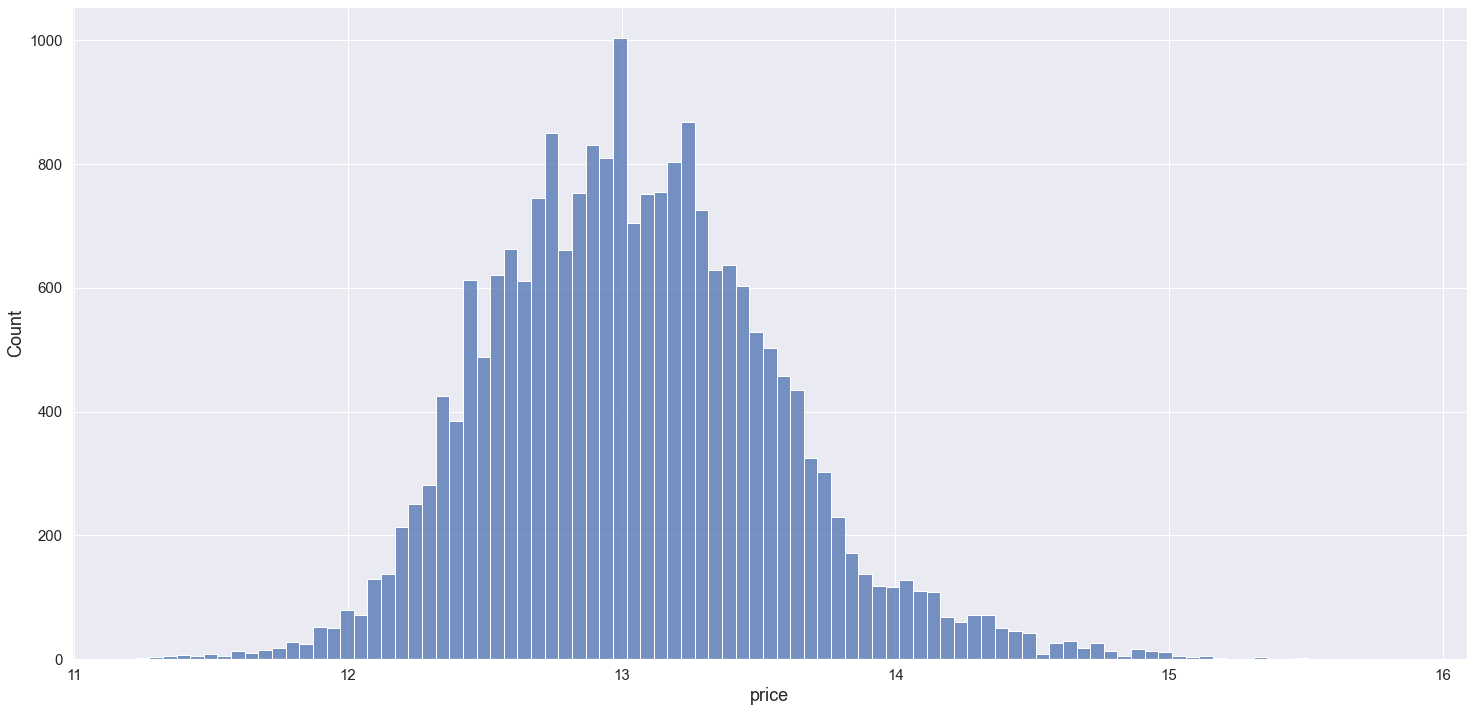

In [195]:
sns.histplot(df5['price']);

In [196]:
df5['price_sqft'] = np.log1p( df5['price_sqft'] )

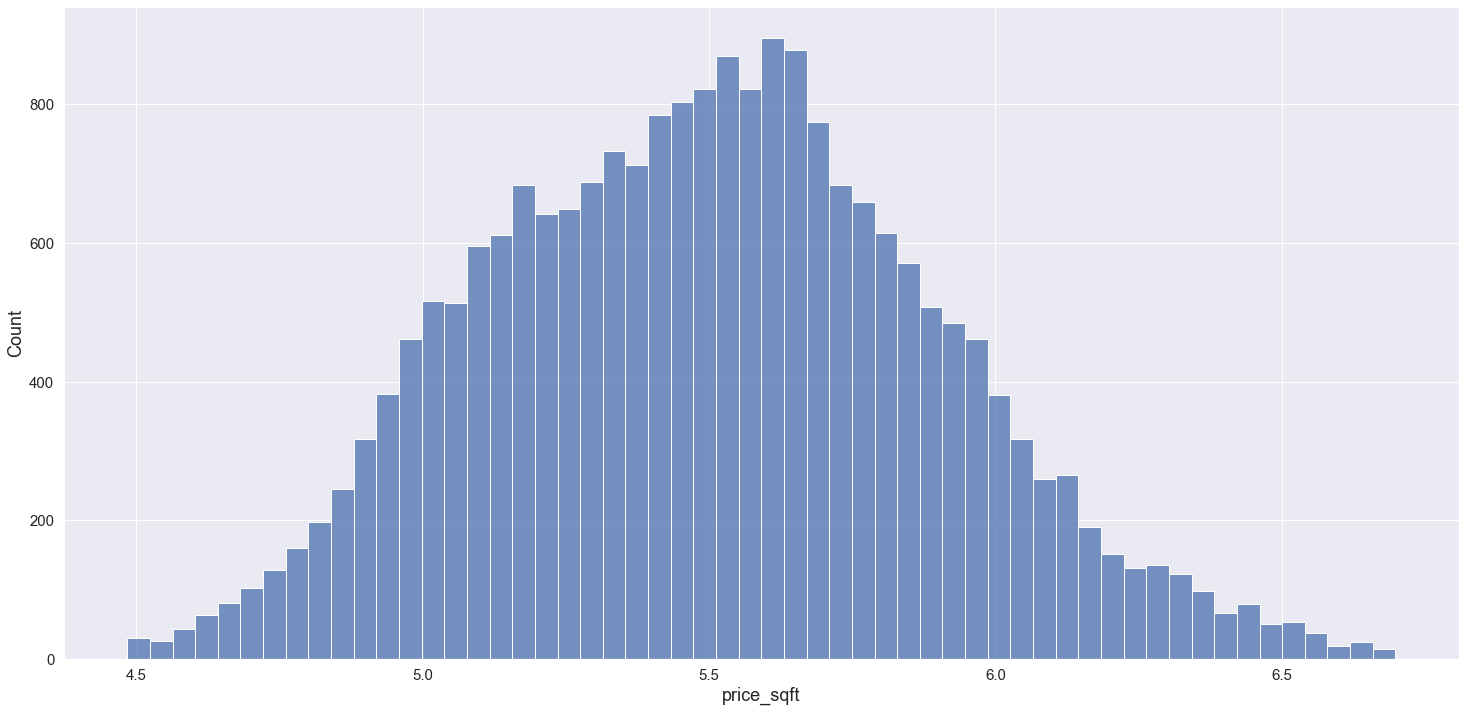

In [197]:
sns.histplot(df5['price_sqft']);

### 5.3.2 Transformação de Natureza

In [198]:
# mes
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

# dia
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

In [199]:
df5.head()

id       date  price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode  lat  long  sqft_living15  sqft_lot15  basement  price_sqft  year  month  day  season  sqft_living_compare  sqft_lot_compare  city  avenue  month_sin  month_cos  day_sin  day_cos
0  7129300520 2014-10-13  12.31      0.27       0.12        -0.65     -0.35    0.00           0     0          3      7       -0.37           0.00      0.48          0.00       66 0.57  0.22          -0.57       -0.40         0        5.24  0.00     10   13       0                    0                 0 41.53       1      -0.87       0.50     0.41    -0.91
1  6414100192 2014-12-09  13.20      0.27       0.28         0.59     -0.07    0.40           0     0          3      7        0.60           0.71      0.44       1991.00       55 0.91  0.17          -0.17        0.00         1        5.35  0.00     12    9       0                    1                 0 41.53       0      -0.00       1.00     0.95    -0.31
2  5631500400 2015-02-25  12.10      0.18       0.12        -1.01      0.42    0.00           0     0          3      6       -0.77           0.00      0.29          0.00       16 0.94  0.24           1.01        0.09         0        5.46  1.00      2   25       3                    0                 1  1.31       1       0.87       0.50    -0.87     0.50
3  2487200875 2014-12-09  13.31      0.36       0.38         0.04     -0.46    0.00           0     0          5      7       -0.50           1.62      0.57          0.00       58 0.59  0.10          -0.55       -0.53         1        5.73  0.00     12    9       0                    1                 0 41.53       0      -0.00       1.00     0.95    -0.31
4  1954400510 2015-02-18  13.14      0.27       0.25        -0.20      0.08    0.00           0     0          3      8        0.12           0.00      0.76          0.00       37 0.74  0.39          -0.05       -0.02         0        5.72  1.00      2   18       3                    0                 1  3.70       1       0.87       0.50    -0.59    -0.81

# 6.0 Seleção de Variáveis

In [200]:
df6 = df5.copy()
df6.shape

(21612, 35)

## 6.1 Separar dataframes de treino e teste

In [201]:
# retirar dia e mes
cols_drop = ['month','day']
df6 = df6.drop( cols_drop, axis = 1 )
df6.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'price_sqft',
       'year', 'season', 'sqft_living_compare', 'sqft_lot_compare', 'city',
       'avenue', 'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [202]:
# retirar variavel resposta e preco por pé quadrado do dataframe das variaveis
X  = df6.drop( ['price', 'price_sqft' ], axis = 1 )
X.shape

(21612, 31)

In [203]:
# dataframe variavel resposta - price
Y  = df6['price']
Y.shape

(21612,)

In [204]:
# separar conjuntos de treino e de teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [205]:
# verificando dimensionalidade dos dataframes
print( X_train.shape )
print( Y_train.shape )
print( X_test.shape )
print( Y_test.shape )

(15128, 31)
(15128,)
(6484, 31)
(6484,)


## 6.2 Boruta- Seleção de Variáveis

In [206]:
#remover date e id de X_train
cols = ['id','date']
X_train_b = X_train.drop( cols, axis = 1 )

# dataset de treino como vetor no boruta
X_train_n = X_train_b.values
Y_train_n = Y_train.values.ravel()

#Definir RandomForestRegressor para metodo boruta
rf = RandomForestRegressor( n_jobs = -1 )

#define boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state=42 ).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	17


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	17


In [207]:
#melhores variáveis selecionadas pelo boruta
cols_selected        = boruta.support_.tolist()
cols_selected_boruta = X_train_b.iloc[:, cols_selected ].columns.to_list()


#colunas não selecionadas pelo boruta
cols_excluded = list( np.setdiff1d( X_train_b.columns, cols_selected_boruta ) )

In [208]:
cols_selected_boruta

['sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [209]:
cols_excluded

['avenue',
 'basement',
 'bathrooms',
 'bedrooms',
 'city',
 'condition',
 'day_cos',
 'day_sin',
 'floors',
 'month_cos',
 'month_sin',
 'season',
 'sqft_basement',
 'sqft_living_compare',
 'sqft_lot_compare',
 'year',
 'yr_renovated']

### Tabela - Variáveis Análise de hipoteses EDA x Variáveis selecionadas pelo boruta

In [210]:
tab = [[ 'hipoteses', 'conclusao', 'relevancia', 'boruta', 'variavel'     ],
       [ 'h1', 'verdadeira',  'alta',  'alta',  'sqft_living'             ],
       [ 'h2', 'falsa',       'baixa', 'alta',  'sqft_lot'                ],
       [ 'h3', 'verdadeira',  'alta',  'alta',  'sqft_above'              ],
       [ 'h4', 'verdadeira',  'baixa', 'baixa', 'floors'                  ],
       [ 'h5', 'verdadeira',  'media', 'baixa', 'basement'                ],
       [ 'h6', 'verdadeira',  'media', 'baixa', 'sqft_basement'           ],
       [ 'h7', 'verdadeira',  'media', 'baixa', 'sqft_living_compare'     ],
       [ 'h8', 'verdadeira',  'baixa', 'baixa', 'sqft_lot_compare'        ],
       [ 'h9', 'verdadeira',  'alta',  'alta',  'waterfront'              ],
       [ 'h10', 'falsa',      'baixa', 'baixa', 'avenue'                  ],
       [ 'h11', 'falsa',      'baixa', 'alta',  'sqft_lot15'              ],
       [ 'h12', 'falsa',      'baixa', 'alta',  'sqft_lot15 - price_sqft' ],
       [ 'h13', 'falsa',      'media', 'baixa', 'city'                    ],  
       [ 'h14', 'verdadeira', 'alta',  'alta',  'grade'                   ], 
       [ 'h15', 'falsa',      'alta',  'alta',  'grade price_sqft'        ], 
       [ 'h16', 'falsa',      'baixa', 'alta',  'grade'                   ],
       [ 'h17', 'falsa',      'baixa', 'baixa', 'yr_renovated'            ],
       [ 'h18', 'falsa',      'baixa', 'baixa', 'yr_renovated-price_sqft' ],
       [ 'h19', 'falsa',      'baixa', 'alta',  'yr_built'                ],
       [ 'h20', 'falsa',      'baixa', 'alta',  'yr_built - price_sqft'   ],
       [ 'h21', 'verdadeira', 'baixa', 'alta',  'yr_built'                ],
       [ 'h22', 'verdadeira', 'media', 'baixa', 'season'                  ],
       [ 'h23', 'falsa',      'baixa', 'baixa', 'day'                     ],
       [ 'h24', 'verdadeira', 'baixa', 'alta',  'yr_built'                ],
       [ 'h25', 'verdadeira', 'alta',  'baixa', 'condition'               ] ]

print( tabulate( tab, headers = 'firstrow' ) )


hipoteses    conclusao    relevancia    boruta    variavel
-----------  -----------  ------------  --------  -----------------------
h1           verdadeira   alta          alta      sqft_living
h2           falsa        baixa         alta      sqft_lot
h3           verdadeira   alta          alta      sqft_above
h4           verdadeira   baixa         baixa     floors
h5           verdadeira   media         baixa     basement
h6           verdadeira   media         baixa     sqft_basement
h7           verdadeira   media         baixa     sqft_living_compare
h8           verdadeira   baixa         baixa     sqft_lot_compare
h9           verdadeira   alta          alta      waterfront
h10          falsa        baixa         baixa     avenue
h11          falsa        baixa         alta      sqft_lot15
h12          falsa        baixa         alta      sqft_lot15 - price_sqft
h13          falsa        media         baixa     city
h14          verdadeira   alta          alta      grade
h15 

## 6.3 Seleção Manual das Variáveis Selecionadas

In [211]:
cols_selected_boruta = ['sqft_living','sqft_lot','waterfront','view','grade','sqft_above','yr_built',
                        'zipcode','lat','long','sqft_living15','sqft_lot15']

#adicionar 'date' e 'price'
feat_to_add = [ 'id','date']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [212]:
cols_selected_boruta

['sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [213]:
cols_selected_boruta_full

['sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'id',
 'date']

# 7.0 Machine Learning Modeling

In [214]:
x_train = pd.DataFrame()
x_test  = pd.DataFrame()
y_train = pd.DataFrame()
y_test  = pd.DataFrame()

In [215]:
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]
y_train = Y_train
y_test  = Y_test

## 7.0.0 Verificação dos dataframes para a modelagem

### 7.0.1 Verificação Dataframes de treino

In [216]:
x_train.head()

sqft_living  sqft_lot  waterfront  view  grade  sqft_above  yr_built  zipcode  lat  long  sqft_living15  sqft_lot15
167           0.69     -0.55           0     0      9        1.10      0.86        5 0.66  0.33           1.24       -0.63
12412         0.38     -0.45           0     0      7       -0.38      0.21       49 0.83  0.17          -0.66       -0.87
7691          0.25      0.25           0     0      8        0.62      0.68       20 0.35  0.20           0.38        0.16
12460         0.31     48.39           0     2      9        0.32      0.91       10 0.77  0.48           1.17       42.53
9099          0.18     45.70           0     0      8        0.54      0.69       29 0.81  0.41           0.31       20.66

In [217]:
y_train.head()

167     13.60
12412   13.25
7691    12.68
12460   13.38
9099    13.25
Name: price, dtype: float64

In [218]:
x_train.shape

(15128, 12)

In [219]:
y_train.shape

(15128,)

### 7.0.2 Verificação Dataframes de teste

In [220]:
x_test.head()

sqft_living  sqft_lot  waterfront  view  grade  sqft_above  yr_built  zipcode  lat  long  sqft_living15  sqft_lot15
735           0.14      0.23           0     0      8        0.50      0.75       32 0.46  0.30           0.63        0.02
2830          0.88     -0.16           0     0      8        0.26      0.67       49 0.84  0.19           0.61       -0.27
4106          1.66      0.58           0     2     11        2.17      0.84        5 0.66  0.32           2.15        0.41
16219         0.18     -0.66           0     0      9        0.54      0.90       17 0.64  0.44           0.53       -0.75
20879        -0.10     -0.86           0     0      8        0.24      0.99       44 0.58  0.14          -0.22       -0.98

In [221]:
y_test.head()

735     12.81
2830    13.67
4106    13.85
16219   13.29
20879   12.77
Name: price, dtype: float64

In [222]:
x_test.shape

(6484, 12)

In [223]:
y_test.shape

(6484,)

## 7.1 Modelo de média

In [224]:
#dataset original conjunto de teste
aux1 = x_test.copy()
aux1['price']      = y_test.copy()
aux1['predictions'] = aux1['price'].mean()
aux1.head()

sqft_living  sqft_lot  waterfront  view  grade  sqft_above  yr_built  zipcode  lat  long  sqft_living15  sqft_lot15  price  predictions
735           0.14      0.23           0     0      8        0.50      0.75       32 0.46  0.30           0.63        0.02  12.81        13.05
2830          0.88     -0.16           0     0      8        0.26      0.67       49 0.84  0.19           0.61       -0.27  13.67        13.05
4106          1.66      0.58           0     2     11        2.17      0.84        5 0.66  0.32           2.15        0.41  13.85        13.05
16219         0.18     -0.66           0     0      9        0.54      0.90       17 0.64  0.44           0.53       -0.75  13.29        13.05
20879        -0.10     -0.86           0     0      8        0.24      0.99       44 0.58  0.14          -0.22       -0.98  12.77        13.05

In [225]:
#predição no conjunto de teste - média de preços dos imóveis
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Modelo de Média', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

Model Name       MAE  MAPE      RMSE
0  Modelo de Média 225930.37  0.44 385471.33

## 7.2 Regressão Linear

### 7.2.1 Regressão Linear - Modelo simples

In [226]:
# model
lr = LinearRegression().fit( x_train, y_train )

#predict
yhat = lr.predict(x_test)

#performance
lr_result = ml_error( 'Regressao Linear', np.expm1( y_test ), np.expm1( yhat ) )

In [227]:
lr_result

Model Name       MAE  MAPE      RMSE
0  Regressao Linear 119124.53  0.21 251353.19

### 7.2.1 Regressão Linear - Cross Validation

In [228]:
lr_result_cv = cross_validation(x_train, y_train, 5, 'Linear Regression', lr, False)
lr_result_cv

Model Name                MAE CV       MAPE CV                 RMSE CV  Score
0  Linear Regression  114327.87 +/- 429.42  0.21 +/- 0.0  195073.39 +/- 11292.29   0.76

## 7.3 Regressão Lasso

### 7.3.1 Regressão Lasso - Modelo simples

In [229]:
#model
lrr = Lasso( alpha = 0.01).fit( x_train, y_train )

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error( 'Regressao Lasso', np.expm1( y_test), np.expm1( yhat_lrr) )

In [230]:
lrr_result

Model Name       MAE  MAPE      RMSE
0  Regressao Lasso 123627.97  0.22 249630.58

### 7.3.2 Regressão Lasso - Cross Validation

In [231]:
lrr_result_cv = cross_validation( x_train, y_train, 5, 'Regressão Lasso', lrr, False )
lrr_result_cv

Model Name                MAE CV       MAPE CV                RMSE CV  Score
0  Regressão Lasso  117829.14 +/- 985.66  0.21 +/- 0.0  197182.74 +/- 3199.52   0.74

## 7.4 Random Forest Regressor

### 7.4.1 Random Forest Regressor - Modelo Simples

In [232]:
#model
rf = RandomForestRegressor( n_estimators = 3000, n_jobs = -1, random_state = 42).fit( x_train, y_train )

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error( 'Random Forest', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

Model Name      MAE  MAPE      RMSE
0  Random Forest 73527.42  0.13 138689.51

### 7.4.2 Random Forest Regressor - Cross Validation

In [233]:
rf_result_cv = cross_validation( x_train, y_train, 5, 'Random Forest', rf, False )
rf_result_cv

Model Name                MAE CV       MAPE CV                RMSE CV  Score
0  Random Forest  70444.27 +/- 1512.61  0.13 +/- 0.0  132115.14 +/- 5937.79   0.96

## 7.5 XGBoost Regressor

### 7.5.1 XGBoost Regressor - Modelo Simples

In [234]:
# model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                            n_estimators = 1500,
                            eta = 0.03,
                            max_depth = 5,
                            subsample = 0.1,
                            colsample_bytree = 0.9,
                            min_child_weight = 15 ).fit(x_train,y_train)

#predictions
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error( 'XGBoost', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

Model Name      MAE  MAPE      RMSE
0    XGBoost 68222.73  0.13 121313.36

### 7.5.2 XGBoost Regressor - Cross Validation

In [235]:
xgb_result_cv = cross_validation( x_train, y_train, 5, 'XGBoost Regressor', model_xgb, False )
xgb_result_cv

Model Name                MAE CV       MAPE CV                 RMSE CV  Score
0  XGBoost Regressor  67296.69 +/- 1802.76  0.13 +/- 0.0  126260.19 +/- 13604.96   0.92

## 7.6 Comparando os modelos

### 7.6.1 Performance - modelos simples

In [236]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

Model Name       MAE  MAPE      RMSE
0           XGBoost  68222.73  0.13 121313.36
0     Random Forest  73527.42  0.13 138689.51
0   Regressao Lasso 123627.97  0.22 249630.58
0  Regressao Linear 119124.53  0.21 251353.19
0   Modelo de Média 225930.37  0.44 385471.33

### 7.6.2 Real Performance - 5 kfold

In [278]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ])
modelling_result_cv.sort_values('RMSE CV')

Model Name                MAE CV       MAPE CV                 RMSE CV  Score
0  XGBoost Regressor  67296.69 +/- 1802.76  0.13 +/- 0.0  126260.19 +/- 13604.96   0.92
0      Random Forest  70444.27 +/- 1512.61  0.13 +/- 0.0   132115.14 +/- 5937.79   0.96
0  Linear Regression  114327.87 +/- 429.42  0.21 +/- 0.0  195073.39 +/- 11292.29   0.76
0    Regressão Lasso  117829.14 +/- 985.66  0.21 +/- 0.0   197182.74 +/- 3199.52   0.74

# 8.0 Hyper Parameter and Fine Tuning

## 8.1 Random Seach

In [280]:
# Random Search
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15] }

MAX_EVAL = 5

In [281]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    
    hp = { k: random.choices( v )[0] for k, v in param.items() } 
    print( '\n', hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )
    # performance
    result = cross_validation( x_train, y_train, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result


 {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

kfold Number: 1
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 69646.07  0.13 142556.06

kfold Number: 2
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 69731.87  0.13 136377.69

kfold Number: 3
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 65254.13  0.13 109811.35

kfold Number: 4
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 65927.23  0.12 115225.14

kfold Number: 5
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 66922.37  0.13 119681.31

 {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}

kfold Number: 1
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 70015.78  0.13 143970.61

kfold Number: 2
          Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 69308.31  0.13 14374

Model Name                MAE CV       MAPE CV                 RMSE CV  Score
0  XGBoost Regressor  67496.33 +/- 1867.51  0.13 +/- 0.0  124730.31 +/- 12584.39   0.93
0  XGBoost Regressor   67462.0 +/- 1896.95  0.13 +/- 0.0  127448.61 +/- 13595.77   0.92
0  XGBoost Regressor   66605.44 +/- 593.95  0.13 +/- 0.0   117222.04 +/- 4109.45   0.91
0  XGBoost Regressor  65955.33 +/- 1884.56  0.12 +/- 0.0  126441.48 +/- 14151.77   0.93
0  XGBoost Regressor  67629.91 +/- 1659.97  0.13 +/- 0.0  128920.75 +/- 13298.77   0.91

In [282]:
melhores_parametros = {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
melhores_parametros

{'n_estimators': 3000,
 'eta': 0.03,
 'max_depth': 5,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'min_child_weight': 3}

## 8.2 Modelo Final

In [283]:
param_tuned = {'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3  }

In [284]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective        = 'reg:squarederror',
                                    n_estimators     = param_tuned['n_estimators'], 
                                    eta              = param_tuned['eta'], 
                                    max_depth        = param_tuned['max_depth'], 
                                    subsample        = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )
 
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

Model Name      MAE  MAPE      RMSE
0  XGBoost Regressor 65408.17  0.12 115833.97

In [285]:
##salvando modelo em formato serializado pickle
#pickle.dump(model_xgb_tuned, open('/home/deivison/Documentos/projetos/kc_house/model/model_kc_house.pkl', 'wb') )

# 9.0 Resultados e interpretação dos Erros

In [286]:
import warnings
warnings.filterwarnings('ignore')

In [287]:
X_test.head()

id       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode  lat  long  sqft_living15  sqft_lot15  basement  year  season  sqft_living_compare  sqft_lot_compare  city  avenue  month_sin  month_cos  day_sin  day_cos
735    2591820310 2014-10-06      0.36       0.28         0.14      0.23    0.40           0     0          4      8        0.50           0.00      0.75          0.00       32 0.46  0.30           0.63        0.02         0  0.00       0                    0                 1  7.39       0      -0.87       0.50     0.95     0.31
2830   7974200820 2014-08-21      0.45       0.38         0.88     -0.16    0.00           0     0          5      8        0.26           1.91      0.67          0.00       49 0.84  0.19           0.61       -0.27         1  0.00       2                    1                 1 41.53       1      -0.87      -0.50    -0.95    -0.31
4106   7701450110 2014-08-15      0.36       0.31         1.66      0.58    0.40           0     2          3     11        2.17           0.00      0.84          0.00        5 0.66  0.32           2.15        0.41         0  0.00       2                    1                 1  6.51       0      -0.87      -0.50     0.00    -1.00
16219  3629910470 2014-07-29      0.27       0.31         0.18     -0.66    0.40           0     0          3      9        0.54           0.00      0.90          0.00       17 0.64  0.44           0.53       -0.75         0  0.00       2                    0                 0  3.39       0      -0.50      -0.87    -0.21     0.98
20879  2895800610 2014-09-26      0.36       0.28        -0.10     -0.86    0.40           0     0          3      8        0.24           0.00      0.99          0.00       44 0.58  0.14          -0.22       -0.98         0  0.00       0                    1                 0 41.53       0      -1.00      -0.00    -0.74     0.67

In [288]:
df9 = X_test[cols_selected_boruta_full]
df9['price'] = np.expm1( y_test )
df9['predictions'] = np.expm1( yhat_xgb_tuned )
df9.head()

sqft_living  sqft_lot  waterfront  view  grade  sqft_above  yr_built  zipcode  lat  long  sqft_living15  sqft_lot15          id       date      price  predictions
735           0.14      0.23           0     0      8        0.50      0.75       32 0.46  0.30           0.63        0.02  2591820310 2014-10-06  365000.00    380523.59
2830          0.88     -0.16           0     0      8        0.26      0.67       49 0.84  0.19           0.61       -0.27  7974200820 2014-08-21  865000.00    800029.62
4106          1.66      0.58           0     2     11        2.17      0.84        5 0.66  0.32           2.15        0.41  7701450110 2014-08-15 1038000.00   1215603.12
16219         0.18     -0.66           0     0      9        0.54      0.90       17 0.64  0.44           0.53       -0.75  3629910470 2014-07-29  590000.00    657255.88
20879        -0.10     -0.86           0     0      8        0.24      0.99       44 0.58  0.14          -0.22       -0.98  2895800610 2014-09-26  352800.00    321534.84

## 9.1 Business Performance

In [289]:
df9['error'] = df9['price'] - df9['predictions']
df9['absolut_error'] = df9.apply( lambda x: np.abs( x['price'] - x['predictions'] ), axis =1 )
df9['mae'] = df9['absolut_error'].mean()
df9['abs_percentage_error'] = df9.apply( lambda x: np.abs( ( x['price'] - x['predictions'] ) / x['price'] ), axis = 1 )
df9['mape'] = df9['abs_percentage_error'].mean()
df9['sq_error'] = df9.apply( lambda x: np.power( x['error'], 2 ), axis =1 )
df9['rmse'] = np.sqrt( df9['sq_error'].mean() )

In [290]:
df9.head()

sqft_living  sqft_lot  waterfront  view  grade  sqft_above  yr_built  zipcode  lat  long  sqft_living15  sqft_lot15          id       date      price  predictions      error  absolut_error      mae  abs_percentage_error  mape       sq_error      rmse
735           0.14      0.23           0     0      8        0.50      0.75       32 0.46  0.30           0.63        0.02  2591820310 2014-10-06  365000.00    380523.59  -15523.59       15523.59 65408.17                  0.04  0.12   240981962.92 115833.97
2830          0.88     -0.16           0     0      8        0.26      0.67       49 0.84  0.19           0.61       -0.27  7974200820 2014-08-21  865000.00    800029.62   64970.37       64970.37 65408.17                  0.08  0.12  4221149627.64 115833.97
4106          1.66      0.58           0     2     11        2.17      0.84        5 0.66  0.32           2.15        0.41  7701450110 2014-08-15 1038000.00   1215603.12 -177603.13      177603.13 65408.17                  0.17  0.12 31542870009.77 115833.97
16219         0.18     -0.66           0     0      9        0.54      0.90       17 0.64  0.44           0.53       -0.75  3629910470 2014-07-29  590000.00    657255.88  -67255.87       67255.87 65408.17                  0.11  0.12  4523352722.02 115833.97
20879        -0.10     -0.86           0     0      8        0.24      0.99       44 0.58  0.14          -0.22       -0.98  2895800610 2014-09-26  352800.00    321534.84   31265.16       31265.16 65408.17                  0.09  0.12   977509995.34 115833.97

In [291]:
print( 'mae : {}'.format( mean_absolute_error( df9['price'], df9['predictions'] ) ) )
print( 'mape: {}'.format( mean_absolute_percentage_error( df9['price'], df9['predictions'] ) ) )
print( 'rmse: {}'.format( np.sqrt( mean_squared_error( df9['price'], df9['predictions'] ) ) ) )

mae : 65408.17365823567
mape: 0.12374812307883988
rmse: 115833.96972601776


In [292]:
df9['lim_inferior'] = df9['predictions'] - df9['mae']
df9['lim_superior'] = df9['predictions'] + df9['mae']
df9[['price', 'lim_inferior','predictions','lim_superior','mae','mape','rmse']].head()

price  lim_inferior  predictions  lim_superior      mae  mape      rmse
735    365000.00     315115.42    380523.59     445931.77 65408.17  0.12 115833.97
2830   865000.00     734621.45    800029.62     865437.80 65408.17  0.12 115833.97
4106  1038000.00    1150194.95   1215603.12    1281011.30 65408.17  0.12 115833.97
16219  590000.00     591847.70    657255.88     722664.05 65408.17  0.12 115833.97
20879  352800.00     256126.67    321534.84     386943.02 65408.17  0.12 115833.97

In [293]:
df9['confidence'] = df9.apply( lambda x: 1 if ( x['price'] >= x['lim_inferior'] ) or ( x['price'] <= x['lim_superior'] ) else 0 , axis = 1 )
df9[['price', 'lim_inferior','predictions','lim_superior','confidence','mae','mape','rmse']].head()

price  lim_inferior  predictions  lim_superior  confidence      mae  mape      rmse
735    365000.00     315115.42    380523.59     445931.77           1 65408.17  0.12 115833.97
2830   865000.00     734621.45    800029.62     865437.80           1 65408.17  0.12 115833.97
4106  1038000.00    1150194.95   1215603.12    1281011.30           1 65408.17  0.12 115833.97
16219  590000.00     591847.70    657255.88     722664.05           1 65408.17  0.12 115833.97
20879  352800.00     256126.67    321534.84     386943.02           1 65408.17  0.12 115833.97

In [294]:
prediction_price = ( df9[ df9['confidence'] == 1 ].shape[0] / df9.shape[0] ) * 100
print(prediction_price, '%' )

100.0 %


## 9.2 Total Business Performance

In [295]:
df9_total = df9[['price','predictions','lim_inferior','lim_superior']].apply( lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'scenarios', 0: 'values'})
df9_total['n_imoveis'] = df9.shape[0]
df9_total['values'] = df9_total['values'].map( '${:,.2f}'.format )
df9_total

scenarios             values  n_imoveis
0         price  $3,520,714,846.00       6484
1   predictions  $3,478,717,952.00       6484
2  lim_inferior  $3,054,611,390.47       6484
3  lim_superior  $3,902,824,586.47       6484

## 9.3 Machine Learning Performance

In [296]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
print('Erro medio percentual do modelo: {} %'.format(mpe*100) )

Erro medio percentual do modelo: -1.5229488015948132 %


In [297]:
plt.figure( figsize = ( 18, 10 ) )

aux1 = df9.index

#erro e taxa de erro
df9['error_rate'] = df9['predictions'] / df9['price']

<Figure size 1296x720 with 0 Axes>

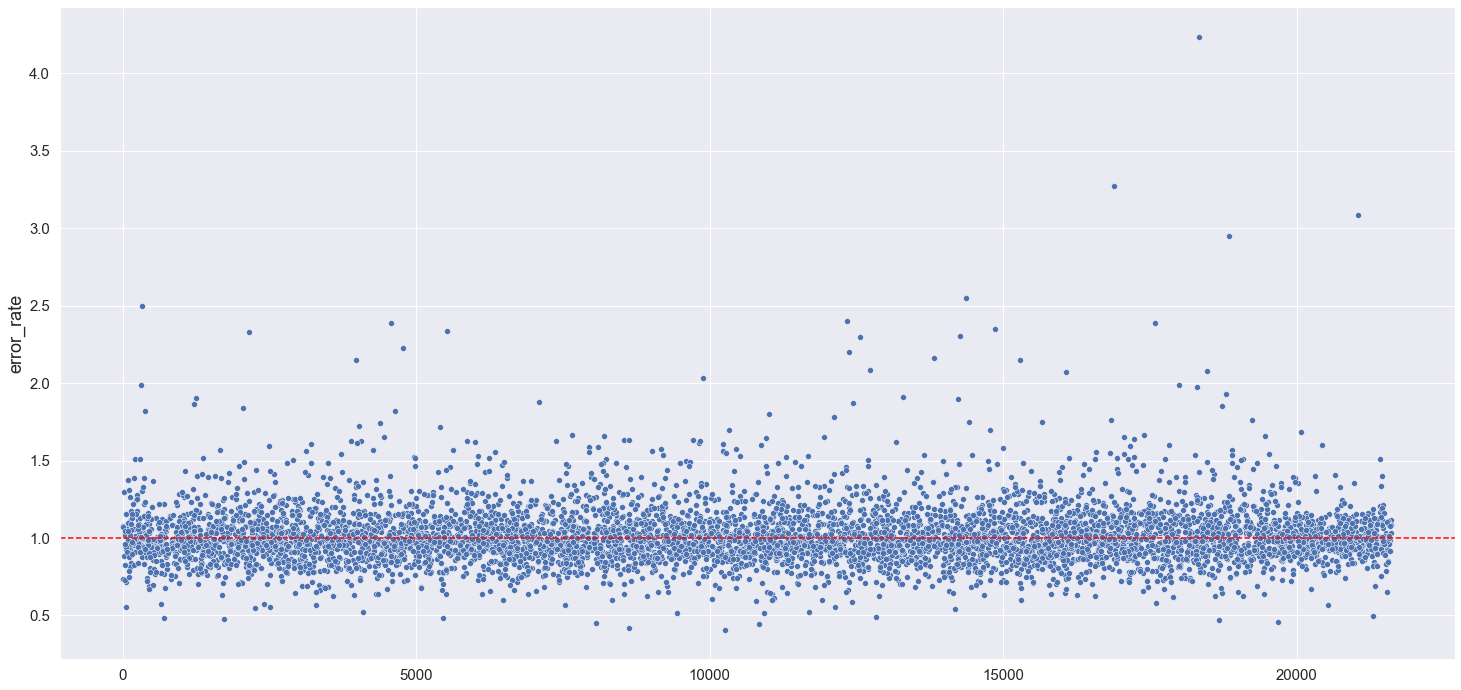

In [298]:
# Dispersao da taxa de erro 
sns.scatterplot( data = df9, x = df9.index , y = 'error_rate');
plt.axhline( 1, linestyle='--', color = 'red');

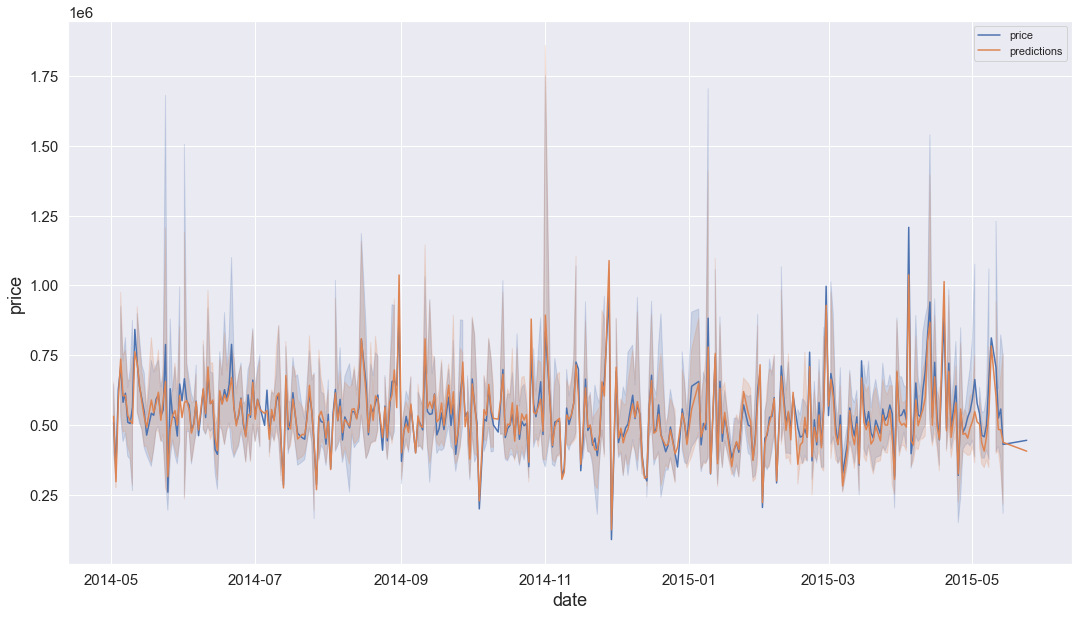

In [299]:
plt.figure(figsize = (18,10) )
plt.subplot(1,1,1)
sns.lineplot( data = df9, x = 'date', y = 'price', label = 'price');
sns.lineplot( data = df9, x = 'date', y = 'predictions', label = 'predictions');

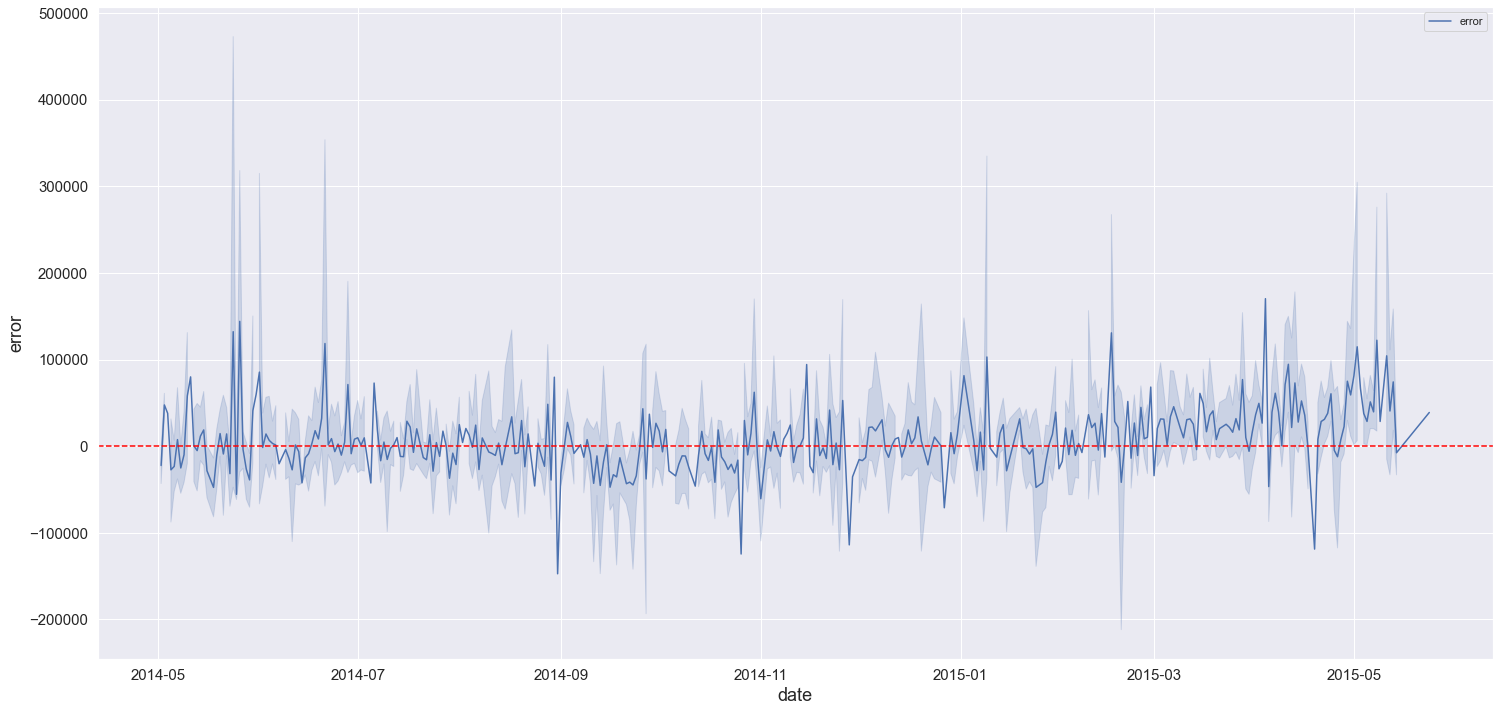

In [300]:
# Erro ao longo das datas de vendas
sns.lineplot( data = df9, x = 'date', y = 'error', label = 'error');
plt.axhline(0, linestyle = '--', color = 'red');

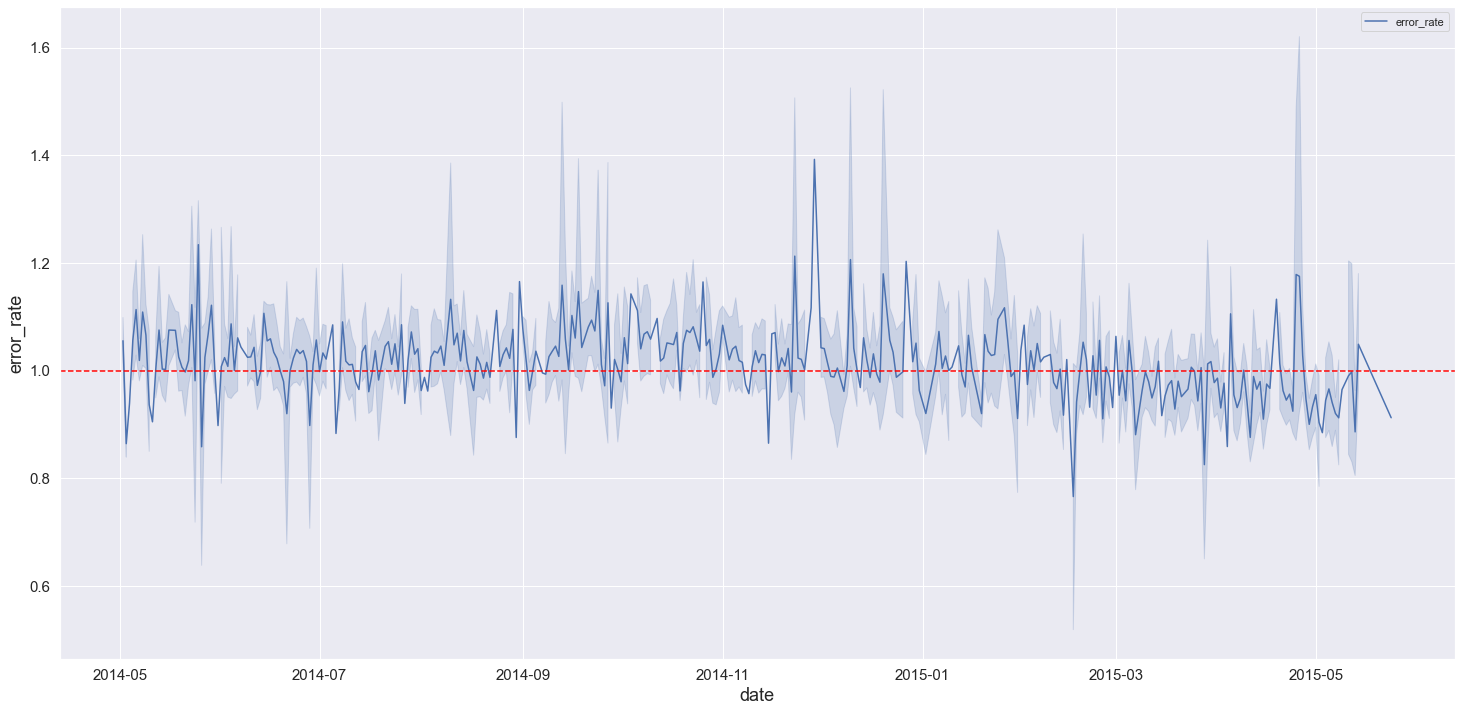

In [301]:
# taxa de erro ao longo das datas de vendas 
sns.lineplot( data = df9, x = 'date', y = 'error_rate', label = 'error_rate');
plt.axhline(1, linestyle = '--', color = 'red');

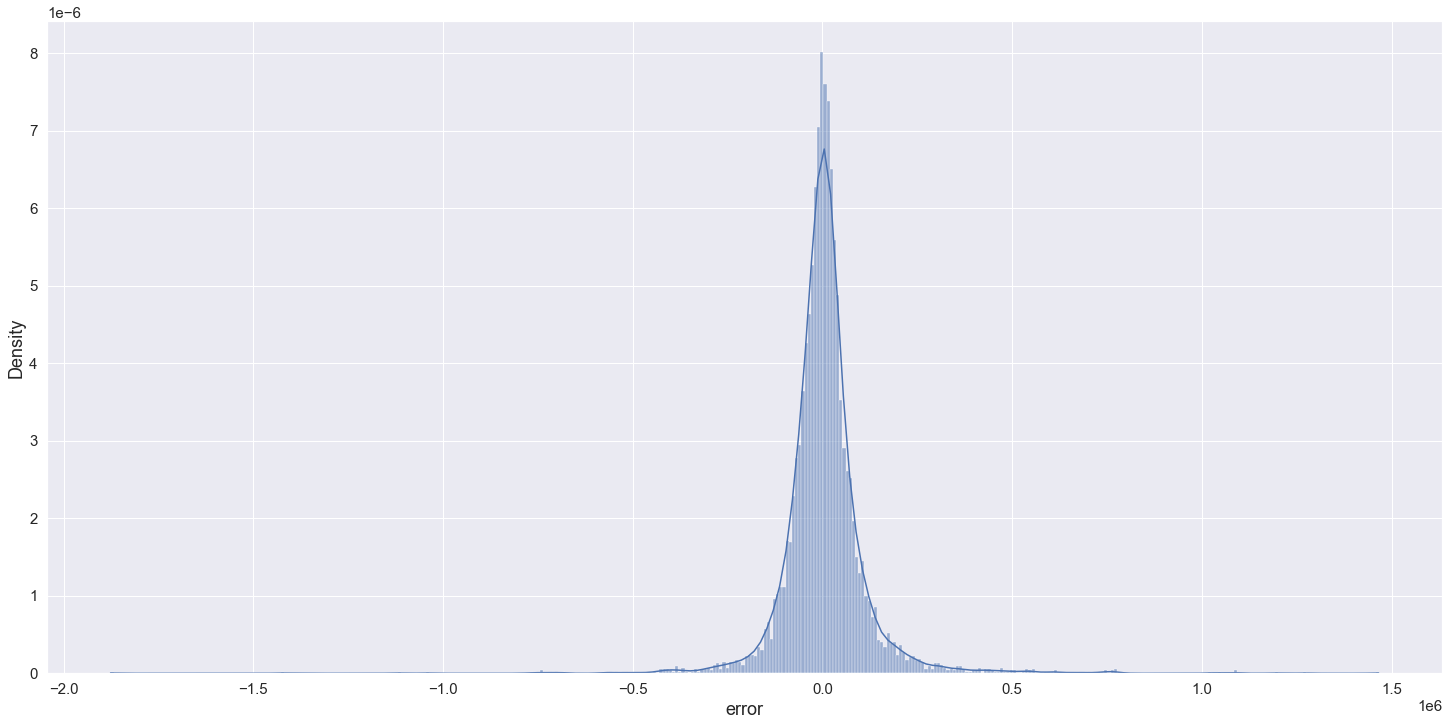

In [302]:
# histograma da distribuicao do erro
sns.histplot( x = 'error', data = df9, stat = 'density', kde = True);

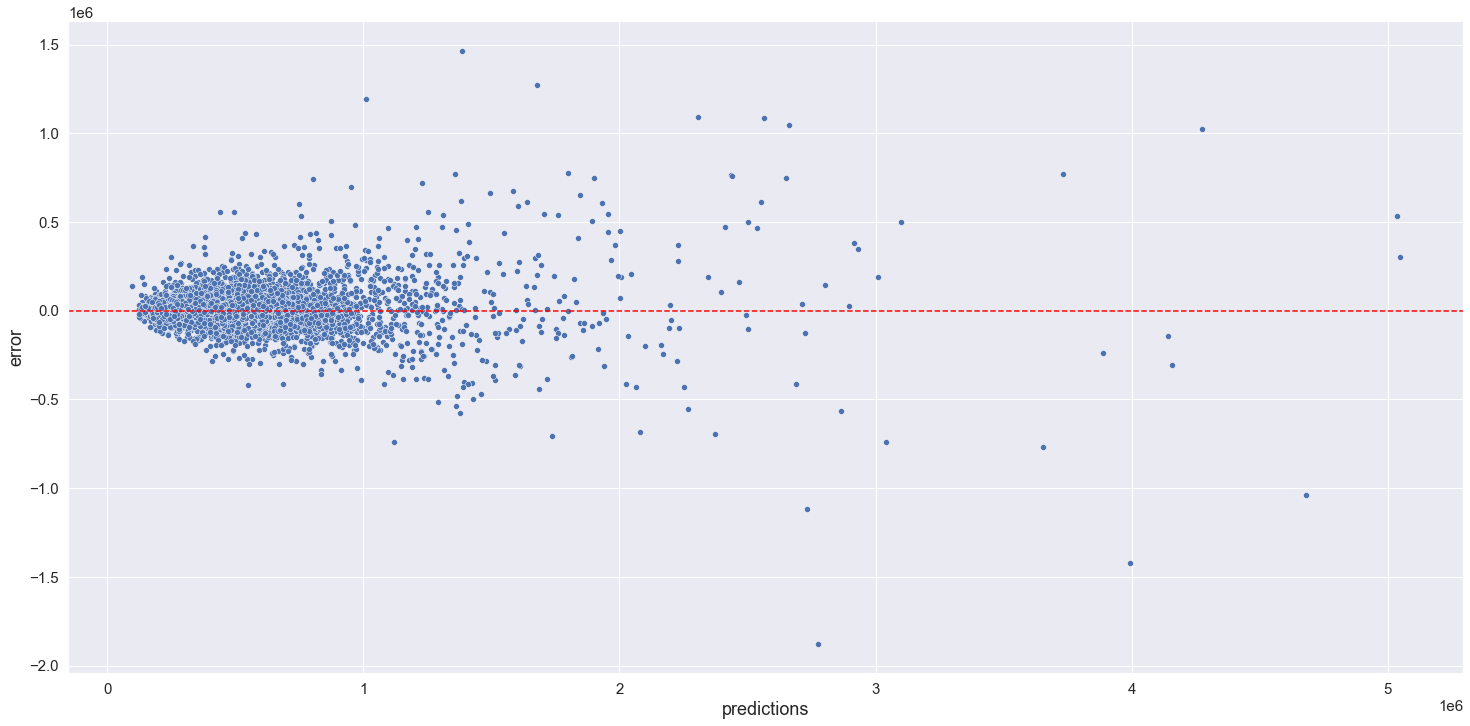

In [303]:
#dispersao do erro entorno do valor zero
sns.scatterplot( data = df9, x = 'predictions', y = 'error');
plt.axhline( 0, linestyle = '--', color = 'red');

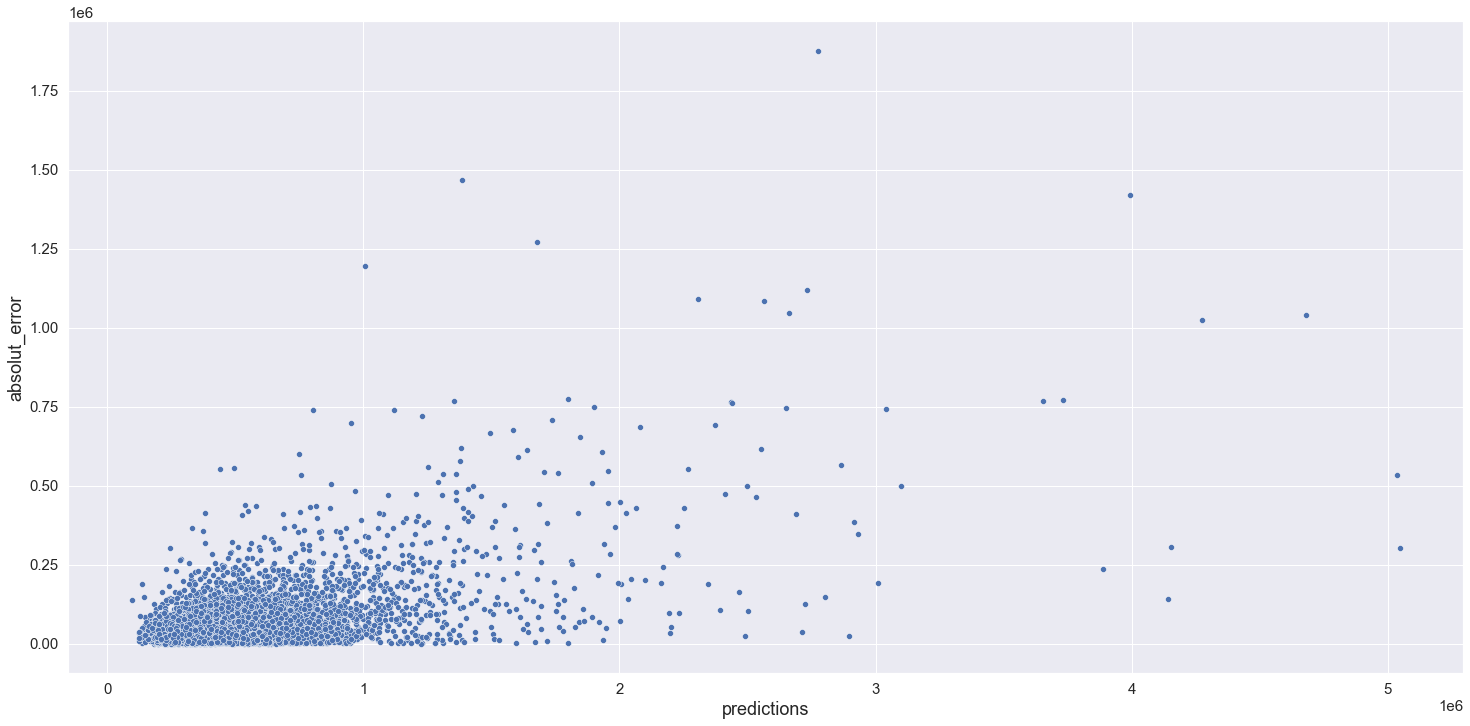

In [304]:
# Dispersao do erro absoluto
sns.scatterplot( data = df9, x = 'predictions', y = 'absolut_error');

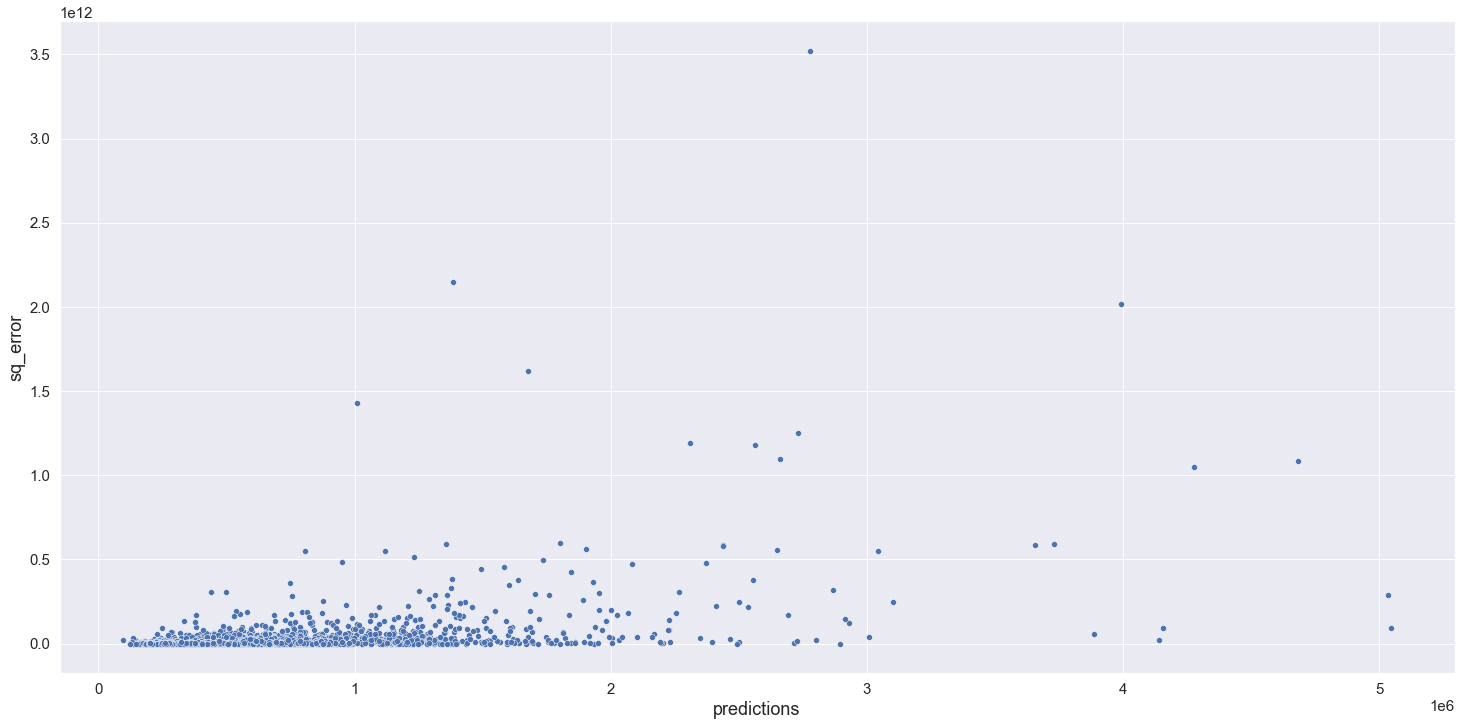

In [305]:
# Dispersao do erro quadratico
sns.scatterplot( data = df9, x = 'predictions', y = 'sq_error');

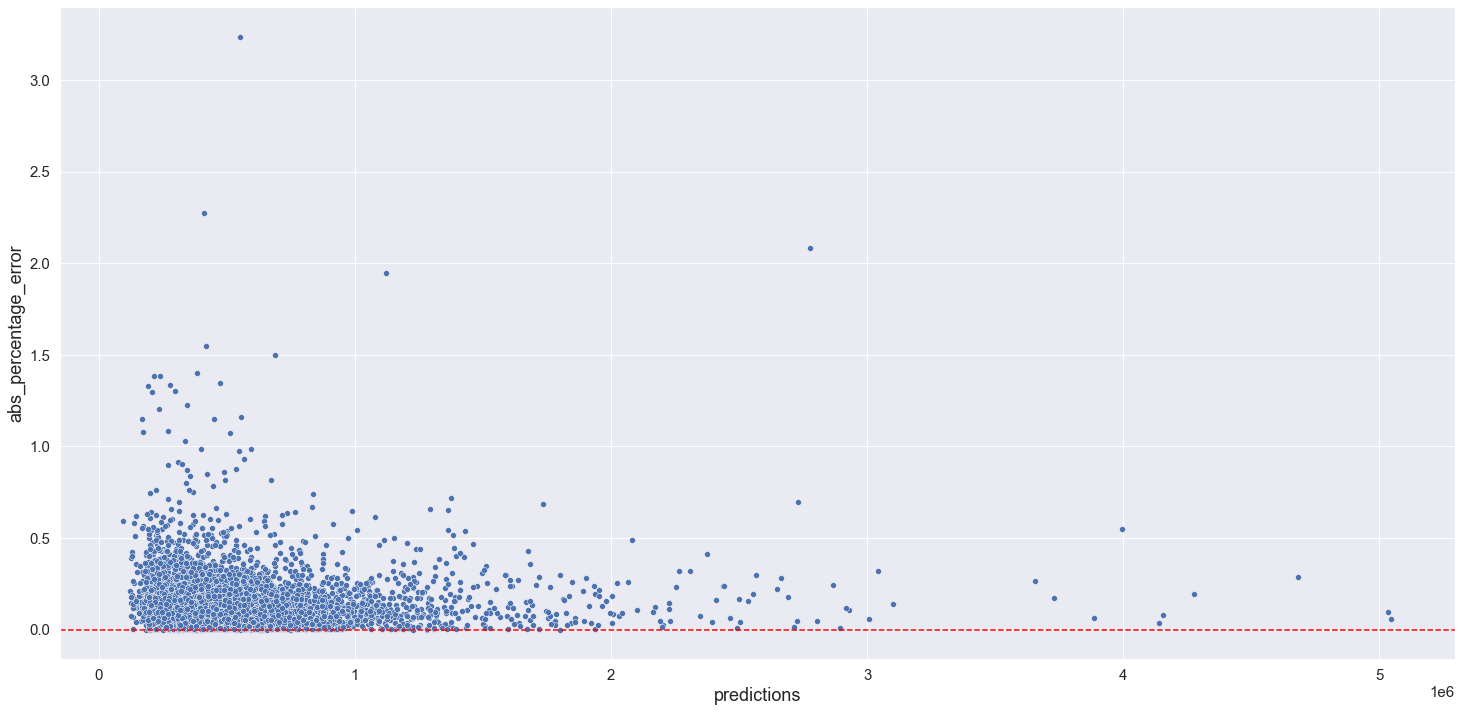

In [306]:
# Dispersao do erro absoluto percentual
sns.scatterplot( data = df9, x = 'predictions', y = 'abs_percentage_error');
plt.axhline(0, linestyle = '--', color = 'red');

# 10.0 Deploy do Modelo em Produção

In [307]:
#pickle.dump(model_xgb_tuned, open('/home/deivison/Documentos/projetos/kc_house/model/model_rossmann.pkl', 'wb') )

## 10.1 Deploy Heroku

### API Handler.py

In [308]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from kc_house.KcHouse  import KcHouse
# import os

# #loading model
# model = pickle.load( open( 'model/model_kc_house.pkl', 'rb' ) )

# # iniciar API
# app = Flask( __name__ )

# #criar endpoint
# @app.route( '/kc_house/predict', methods = ['POST'] )

# def kc_house_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         #se tiver dado
#         if isinstance( test_json, dict ): #se for um dicionario
#             test_raw = pd.DataFrame( test_json, index = [0] )
#         else: #se for varios jsons
#             test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
#         #instanciar Rossmann Class
#         pipeline = KcHouse()
        
#         #data cleaning
#         df1 = pipeline.data_cleaning( test_raw )
        
#         #featuring engineering
#         df2 = pipeline.featuring_engineering( df1 )
        
#         #data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         #prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
            
#     else:
#         return Response ( '{}', status = 200 , mimetype = 'application/json' )

# if __name__ == '__main__':
#     port = os.environ.get('PORT',5000 )
#     app.run( host = '0.0.0.0', port = port )

### Modulo Preparação dos dados - kc_house.py

In [309]:
# import pickle
# import inflection
# import pandas as pd
# import numpy as np
# import math
# import datetime


# class KcHouse( object ):
    
#     def __init__( self ):
#         self.home_path = ''
#         self.bedrooms_scaler      = pickle.load( open( self.home_path + 'parameters/bedrooms_scaler.pkl','rb' ) )
#         self.bathrooms_scaler     = pickle.load( open( self.home_path + 'parameters/bathrooms_scaler.pkl','rb' ) )
#         self.floors_scaler        = pickle.load( open( self.home_path + 'parameters/floors_scaler.pkl','rb' ) )
#         self.yr_built_scaler      = pickle.load( open( self.home_path + 'parameters/yr_built_scaler.pkl','rb' ) )
#         self.year_scaler          = pickle.load( open( self.home_path + 'parameters/year_scaler.pkl','rb' ) )
#         self.lat_scaler           = pickle.load( open( self.home_path + 'parameters/lat_scaler.pkl','rb' ) )
#         self.long_scaler          = pickle.load( open( self.home_path + 'parameters/long_scaler.pkl','rb' ) )
#         self.sqft_living_scaler   = pickle.load( open( self.home_path + 'parameters/sqft_living_scaler.pkl','rb' ) )
#         self.sqft_lot_scaler      = pickle.load( open( self.home_path + 'parameters/sqft_lot_scaler.pkl','rb' ) )
#         self.sqft_above_scaler    = pickle.load( open( self.home_path + 'parameters/sqft_above_scaler.pkl','rb' ) )
#         self.sqft_basement_scaler = pickle.load( open( self.home_path + 'parameters/sqft_basement_scaler.pkl','rb' ) )
#         self.yr_renovated_scaler  = pickle.load( open( self.home_path + 'parameters/yr_renovated_scaler.pkl','rb' ) )
#         self.sqft_living15_scaler = pickle.load( open( self.home_path + 'parameters/sqft_living15_scaler.pkl','rb' ) )
#         self.sqft_lot15_scaler    = pickle.load( open( self.home_path + 'parameters/sqft_lot15_scaler.pkl','rb' ) )
#         self.season_scaler        = pickle.load( open( self.home_path + 'parameters/season_scaler.pkl','rb' ) )
#         self.zipcode_scaler       = pickle.load( open( self.home_path + 'parameters/zipcode_scaler.pkl','rb' ) )
        
        
#     def data_cleaning( self, df1 ):
        
           
#         ## 1.3 Data Type

#         # Convert data in datetime variable
#         df1['date'] = pd.to_datetime(df1['date'])
        
#         return df1

#     def featuring_engineering( self, df2 ): 
        
#         ## 2.4 Feature Engineering
        
#         #basement
#         df2['basement'] = df2.apply(lambda x: 0 if ( x['sqft_basement'] == 0)  else 1, axis =1 ).astype(int)
        
#         # price_sqft
#         #df2['price_sqft'] = df2.apply( lambda x: x['price'] / x['sqft_living'], axis = 1 )   

#         #year
#         df2['year'] = df2['date'].dt.year.astype(str)
        
#         #month
#         df2['month'] = df2['date'].dt.month
        
#         #day
#         df2['day'] = df2['date'].dt.day
        
#         #season of year
#         df2['season'] = df2.apply( lambda x: 'spring' if x['date'] in pd.date_range( start = x['year'] + '/3/21' , end= x['year'] + '/6/20'  , freq='D' ) else
#                                              'summer' if x['date'] in pd.date_range( start = x['year'] + '/6/21' , end= x['year'] + '/9/20'  , freq='D' ) else
#                                              'fall'   if x['date'] in pd.date_range( start = x['year'] + '/9/21' , end= x['year'] + '/12/20' , freq='D' ) else 
#                                              'winter', axis = 1 )
        
#         #sqft_living compare
#         df2['sqft_living_compare'] = df2.apply( lambda x: 1 if x['sqft_living'] > x['sqft_living15'] else 0, axis = 1 )
        
#         #sqft_lot compare
#         df2['sqft_lot_compare']    = df2.apply( lambda x: 1 if x['sqft_lot'] > x['sqft_lot15'] else 0, axis = 1 )
        
#         #city
#         dic_zip = {'98001': 'Auburn','98002': 'Auburn','98003': 'Federal Way','98004': 'Bellevue',
#            '98005': 'Bellevue','98006': 'Bellevue','98007': 'Bellevue','98008': 'Bellevue',
#            '98009': 'Bellevue','98010': 'Black Diamond','98011': 'Bothell','98013': 'Burton',
#            '98014': 'Carnation','98015': 'Bellevue','98019': 'Duvall','98022': 'Enumclaw',
#            '98023': 'Federal Way','98024': 'Fall City','98025': 'Hobart','98027': 'Issaquah',
#            '98028': 'Kenmore','98029': 'Issaquah','98030': 'Kent','98031': 'Kent','98032': 'Kent',
#            '98033': 'Kirkland','98034': 'Kirkland','98035': 'Kent','98038': 'Maple Valley',
#            '98039': 'Medina','98040': 'Mercer Island','98041': 'Bothell','98042': 'Kent',
#            '98045': 'North Bend','98047': 'Pacific','98050': 'Preston','98051': 'Ravensdale',
#            '98052': 'Redmond','98053': 'Redmond','98055': 'Renton','98056': 'Renton',
#            '98057': 'Renton','98058': 'Renton','98059': 'Renton','98062': 'Seahurst',
#            '98063': 'Federal Way','98064': 'Kent','98065': 'Snoqualmie','98070': 'Vashon',
#            '98071': 'Auburn','98072': 'Woodinville','98073': 'Redmond','98074': 'Sammamish',
#            '98075': 'Sammamish','98077': 'Woodinville','98083': 'Kirkland','98089': 'Kent',
#            '98092': 'Auburn','98093': 'Federal Way','98101': 'Seattle','98102': 'Seattle',
#            '98103': 'Seattle','98104': 'Seattle','98105': 'Seattle','98106': 'Seattle','98107': 'Seattle',
#            '98108': 'Seattle','98109': 'Seattle','98111': 'Seattle','98112': 'Seattle','98113': 'Seattle',
#            '98114': 'Seattle','98115': 'Seattle','98116': 'Seattle','98117': 'Seattle','98118': 'Seattle',
#            '98119': 'Seattle','98121': 'Seattle','98122': 'Seattle','98124': 'Seattle','98125': 'Seattle',
#            '98126': 'Seattle','98127': 'Seattle','98129': 'Seattle','98131': 'Seattle','98133': 'Seattle',
#            '98134': 'Seattle','98136': 'Seattle','98138': 'Seattle','98139': 'Seattle','98141': 'Seattle',
#            '98144': 'Seattle','98145': 'Seattle','98146': 'Seattle','98148': 'Seattle','98154': 'Seattle',
#            '98155': 'Seattle','98158': 'Seattle','98160': 'Seattle','98161': 'Seattle','98164': 'Seattle',
#            '98165': 'Seattle','98166': 'Seattle','98168': 'Seattle','98170': 'Seattle','98174': 'Seattle',
#            '98175': 'Seattle','98177': 'Seattle','98178': 'Seattle','98181': 'Seattle','98185': 'Seattle',
#            '98188': 'Seattle','98190': 'Seattle','98191': 'Seattle','98194': 'Seattle','98195': 'Seattle',
#            '98198': 'Seattle','98199': 'Seattle','98224': 'Baring','98288': 'Skykomish'}
        
#         df2['zipcode'] = df2['zipcode'].astype(str)
#         df2['city'] = df2['zipcode'].map(dic_zip)
#         df2['city'] = df2['city'].apply( lambda x: inflection.underscore(x).replace(' ', '_') )
        
#         #road
#         df2['road'].fillna('not_available', inplace = True )
        
#         #avenue
#         df2['avenue'] = df2['road'].str.contains('Avenue', regex = False)
#         df2['avenue'] = df2['avenue'].apply( lambda x: 1 if (x==True) else 0 ).astype(int)
        
        
#         # 3.0 FILTRAGEM DE VARIAVEIS

#         ## 3.1 Filtragem de linhas

#         df2 = df2[ df2['bedrooms'] < 33 ]

#         return df2

#     def data_preparation( self, df5 ):

#         ## 5.1.2 Rescaling
        
#         # min-max
#         df5['bedrooms']      = self.bedrooms_scaler.transform(      df5[['bedrooms']].values )
#         df5['bathrooms']     = self.bathrooms_scaler.transform(     df5[['bathrooms']].values )
#         df5['floors']        = self.floors_scaler.transform(        df5[['floors']].values )
#         df5['yr_built']      = self.yr_built_scaler.transform(      df5[['yr_built']].values)
#         df5['year']          = self.year_scaler.transform(          df5[['year']].values )
#         df5['lat']           = self.lat_scaler.transform(           df5[['lat']].values )
#         df5['long']          = self.long_scaler.transform(          df5[['long']].values )
        
#         ## Robust 
#         df5['sqft_living']   = self.sqft_living_scaler.transform(   df5[['sqft_living']].values )
#         df5['sqft_lot']      = self.sqft_lot_scaler.transform(      df5[['sqft_lot']].values )
#         df5['sqft_above']    = self.sqft_above_scaler.transform(    df5[['sqft_above']].values )
#         df5['sqft_basement'] = self.sqft_basement_scaler.transform( df5[['sqft_basement']].values )
#         df5['yr_renovated']  = self.yr_renovated_scaler.transform(  df5[['yr_renovated']].values )
#         df5['sqft_living15'] = self.sqft_living15_scaler.transform( df5[['sqft_living15']].values)
#         df5['sqft_lot15']    = self.sqft_lot15_scaler.transform(    df5[['sqft_lot15']].values)

#         ## 5.2 Enconding
        
#         # label enconding
#         df5['season']  = self.season_scaler.transform( df5['season'] )
#         df5['zipcode'] = self.zipcode_scaler.transform(df5['zipcode'] )
        
#         # frequency enconding
        
#         city_freq ={'seattle': 41.53248195446974,'kenmore': 1.3094577086803627,'sammamish': 3.7016472330186936,'redmond': 4.529890801406626,
#                     'federal_way': 3.604478993151953,'maple_valley': 2.729964834351286,'bellevue': 6.510272071071626,'duvall':0.8791412178419398,
#                     'auburn': 4.21987784564131,'mercer_island': 1.3048306496390893,'kent': 5.56635202665186,'issaquah': 3.3916342772533774,
#                     'renton': 7.389413288913567,'vashon': 0.5459929668702573,'kirkland': 4.52063668332408,'black_diamond': 0.4627059041273367,
#                     'north_bend': 1.022580048121414,'woodinville': 2.179344808439756,'snoqualmie': 1.4343883027947435,
#                     'enumclaw':1.082731815657968,'fall_city': 0.3747917823431427,'bothell': 0.9022765130483066,
#                     'carnation': 0.5737553211178975,'medina': 0.23135295206366835}
#         df5['city'] = df5['city'].map(city_freq)
        
        
#         ## 5.3 Transformacao

#         ### 5.3.2 Nature Transformation

#         #month
#         df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
#         df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )
        
#         # day
#         df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
#         df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )
        
#         cols_selected = ['sqft_living','sqft_lot','waterfront','view','grade','sqft_above','yr_built','zipcode','lat',
#                          'long','sqft_living15','sqft_lot15']
        
#         return df5[ cols_selected ]
    
#     def get_prediction( self, model, original_data, test_data ):
        
#         #prediction
#         pred = model.predict( test_data )
        
#         #join pred into the original data
#         original_data['prediction'] = np.expm1( pred )
        
#         return original_data.to_json( orient = 'records', date_format = 'iso' )

### Arquivo procfile

In [310]:
# web: python handler.py

### API CALL

In [311]:
#https://kc-house-model.herokuapp.com/

#https://git.heroku.com/kc-house-model.git

In [312]:
#loading test dataset com novos dados
df_test = pd.read_csv( '/home/deivison/Documentos/projetos/kc_house/data/test.csv' )

In [313]:
#choose store for prediction
df_test = df_test.drop( ['price','price_sqft', 'city'], axis =1)
df_test.head()

bathrooms  bedrooms                           road  sqft_living  sqft_lot  yr_built  zipcode  floors  waterfront  view  grade  sqft_above  sqft_basement  yr_renovated   lat    long  sqft_living15  sqft_lot15        date        id
0          1         3            9241 34TH Avenue SW      1040.00   8881.88      1953    98126       1           0     0     10           0              0             0 47.52 -122.38        1200.00     9100.00  2014-10-13  71298753
1          3         4              25418 KANASKET DR      1790.00  10516.00      1994    98010       1           0     0     10           0              0             0 47.33 -122.00        1800.00    10600.00  2014-10-21  71298758
2          1         2  27412 SE GREEN RIVER GORGE RD      1200.00  40075.00      1961    98010       1           1     4      7           0              0             0 47.32 -122.98        2000.00    40000.00  2015-01-21  71298759
3          2         3                 32409 MCKAY LN      1700.00  10428.00      2002    98010       1           0     0      7           0              0             0 47.31 -122.00        1700.00    10500.00  2015-09-29  71298754

In [314]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient = 'records') )

In [315]:
#API call

#url = 'http://127.0.0.1:5000/kc_house/predict'
url = 'https://kc-house-model.herokuapp.com/kc_house/predict'
header ={'Content-type':'application/json'}
data = data

r = requests.post( url, data = data, headers = header )
print('Status Code {}'.format( r.status_code ) )

Status Code 200


In [316]:
r.json()[0]

{'bathrooms': 1,
 'bedrooms': 3,
 'road': '9241 34TH Avenue SW',
 'sqft_living': 1040.0,
 'sqft_lot': 8881.88,
 'yr_built': 1953,
 'zipcode': '98126',
 'floors': 1,
 'waterfront': 0,
 'view': 0,
 'grade': 10,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_renovated': 0,
 'lat': 47.51911,
 'long': -122.37575,
 'sqft_living15': 1200.0,
 'sqft_lot15': 9100.0,
 'date': '2014-10-13T00:00:00.000Z',
 'id': 71298753,
 'basement': 0,
 'year': '2014',
 'month': 10,
 'day': 13,
 'season': 'fall',
 'sqft_living_compare': 0,
 'sqft_lot_compare': 0,
 'city': 'seattle',
 'avenue': 1,
 'prediction': 467747.9375}

In [317]:
r.json()[1]

{'bathrooms': 3,
 'bedrooms': 4,
 'road': '25418 KANASKET DR',
 'sqft_living': 1790.0,
 'sqft_lot': 10516.0,
 'yr_built': 1994,
 'zipcode': '98010',
 'floors': 1,
 'waterfront': 0,
 'view': 0,
 'grade': 10,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_renovated': 0,
 'lat': 47.32787,
 'long': -122.00176,
 'sqft_living15': 1800.0,
 'sqft_lot15': 10600.0,
 'date': '2014-10-21T00:00:00.000Z',
 'id': 71298758,
 'basement': 0,
 'year': '2014',
 'month': 10,
 'day': 21,
 'season': 'fall',
 'sqft_living_compare': 0,
 'sqft_lot_compare': 0,
 'city': 'black_diamond',
 'avenue': 0,
 'prediction': 401459.125}

In [318]:
r.json()[2]

{'bathrooms': 1,
 'bedrooms': 2,
 'road': '27412 SE GREEN RIVER GORGE RD',
 'sqft_living': 1200.0,
 'sqft_lot': 40075.0,
 'yr_built': 1961,
 'zipcode': '98010',
 'floors': 1,
 'waterfront': 1,
 'view': 4,
 'grade': 7,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_renovated': 0,
 'lat': 47.32385,
 'long': -122.97687,
 'sqft_living15': 2000.0,
 'sqft_lot15': 40000.0,
 'date': '2015-01-21T00:00:00.000Z',
 'id': 71298759,
 'basement': 0,
 'year': '2015',
 'month': 1,
 'day': 21,
 'season': 'winter',
 'sqft_living_compare': 0,
 'sqft_lot_compare': 1,
 'city': 'black_diamond',
 'avenue': 0,
 'prediction': 355639.375}

In [319]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [320]:
print( d1[['id','prediction']] )

         id  prediction
0  71298753   467747.94
1  71298758   401459.12
2  71298759   355639.38
3  71298754   342190.22
